## Import libraries and set device

In [1]:
import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Prepare datasets

In [3]:
train_data = datasets.EMNIST(
    root="data",
    split="letters",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)
test_data = datasets.EMNIST(
    root="data",
    split="letters",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

100%|██████████| 561753746/561753746 [00:06<00:00, 84497706.35it/s] 


Extracting data/EMNIST/raw/gzip.zip to data/EMNIST/raw


In [4]:
len(train_data), len(test_data)

(124800, 20800)

In [5]:
class_names = train_data.classes
class_names

['N/A',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

#### Look at sample image

(-0.5, 27.5, 27.5, -0.5)

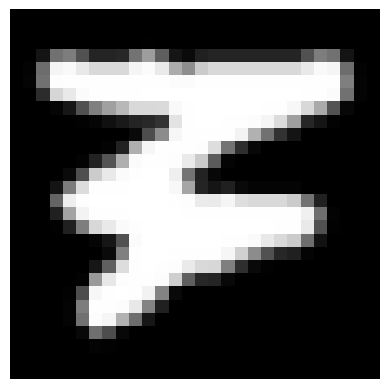

In [6]:
image = train_data[0][0]
plt.imshow(image.squeeze(), cmap="gray")
plt.axis(False)

#### Use dataloader to split data into batches

In [7]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

## Make accuracy, training, and testing functions

In [8]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [9]:
def train_step(model,
               data_loader,
               loss_fn,
               optimizer,
               accuracy_fn,
               device=device):
    train_loss, train_acc = 0, 0
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        acc = accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        train_acc += acc
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train Loss: {train_loss:.5f} | Train Acc: {train_acc:.2f}%")

In [10]:
def test_step(model,
              data_loader,
              loss_fn,
              optimizer,
              accuracy_fn,
              device=device):
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for batch, (X,y) in enumerate(data_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss
            acc = accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
            test_acc += acc
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")


## Make Tiny VGG CNN model

In [11]:
class MNIST_CNN(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )
    def forward(self, x):
        x=self.conv_block_1(x)
        x=self.conv_block_2(x)
        x=self.classifier(x)
        return x

#### Initialize model and set loss function and optimizer

In [12]:
model = MNIST_CNN(input_shape=1,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.1)

## Train and test model. Print out loss and accuracy

In [13]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 10
for epoch in range(epochs):
    print(f"Epoch {epoch}\n --------------------------")
    train_step(model=model,
            accuracy_fn=accuracy_fn,
            loss_fn=loss_fn,
            data_loader=train_dataloader,
            optimizer=optimizer)
    test_step(model=model,
              accuracy_fn=accuracy_fn,
              loss_fn=loss_fn,
              data_loader=test_dataloader,
              optimizer=optimizer)

Epoch 0
 --------------------------
Train Loss: 0.89190 | Train Acc: 73.10%
Test Loss: 0.34936 | Test Acc: 89.24%
Epoch 1
 --------------------------
Train Loss: 0.32630 | Train Acc: 89.60%
Test Loss: 0.30578 | Test Acc: 90.44%
Epoch 2
 --------------------------
Train Loss: 0.28491 | Train Acc: 90.85%
Test Loss: 0.29411 | Test Acc: 90.63%
Epoch 3
 --------------------------
Train Loss: 0.26433 | Train Acc: 91.41%
Test Loss: 0.28285 | Test Acc: 91.20%
Epoch 4
 --------------------------
Train Loss: 0.25127 | Train Acc: 91.79%
Test Loss: 0.28227 | Test Acc: 91.17%
Epoch 5
 --------------------------
Train Loss: 0.24391 | Train Acc: 91.95%
Test Loss: 0.26924 | Test Acc: 91.65%
Epoch 6
 --------------------------
Train Loss: 0.23500 | Train Acc: 92.31%
Test Loss: 0.27727 | Test Acc: 91.13%
Epoch 7
 --------------------------
Train Loss: 0.23223 | Train Acc: 92.35%
Test Loss: 0.27284 | Test Acc: 91.35%
Epoch 8
 --------------------------
Train Loss: 0.22599 | Train Acc: 92.48%
Test Loss: 0

## Visualize the performancce of the model

#### Plot a confusion matrix to see the most common classification mistakes

In [14]:
pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 12.1 MB/s eta 0:00:00


In [15]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

y_preds = []
model.eval()
with torch.inference_mode():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        y_logit = model(X)
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        y_preds.append(y_pred.cpu())
y_pred_tensor = torch.cat(y_preds)

In [16]:
len(y_pred_tensor)

20800

/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


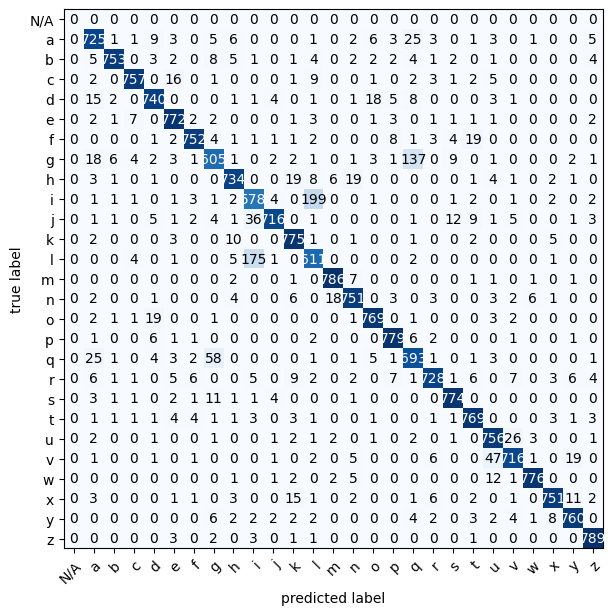

In [17]:
confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets)
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10,7)
)

#### Plot every incorrect prediction, and label what the model predicted and what the actual label was

<ipython-input-18-43fbcd74ce41>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(20, 20))


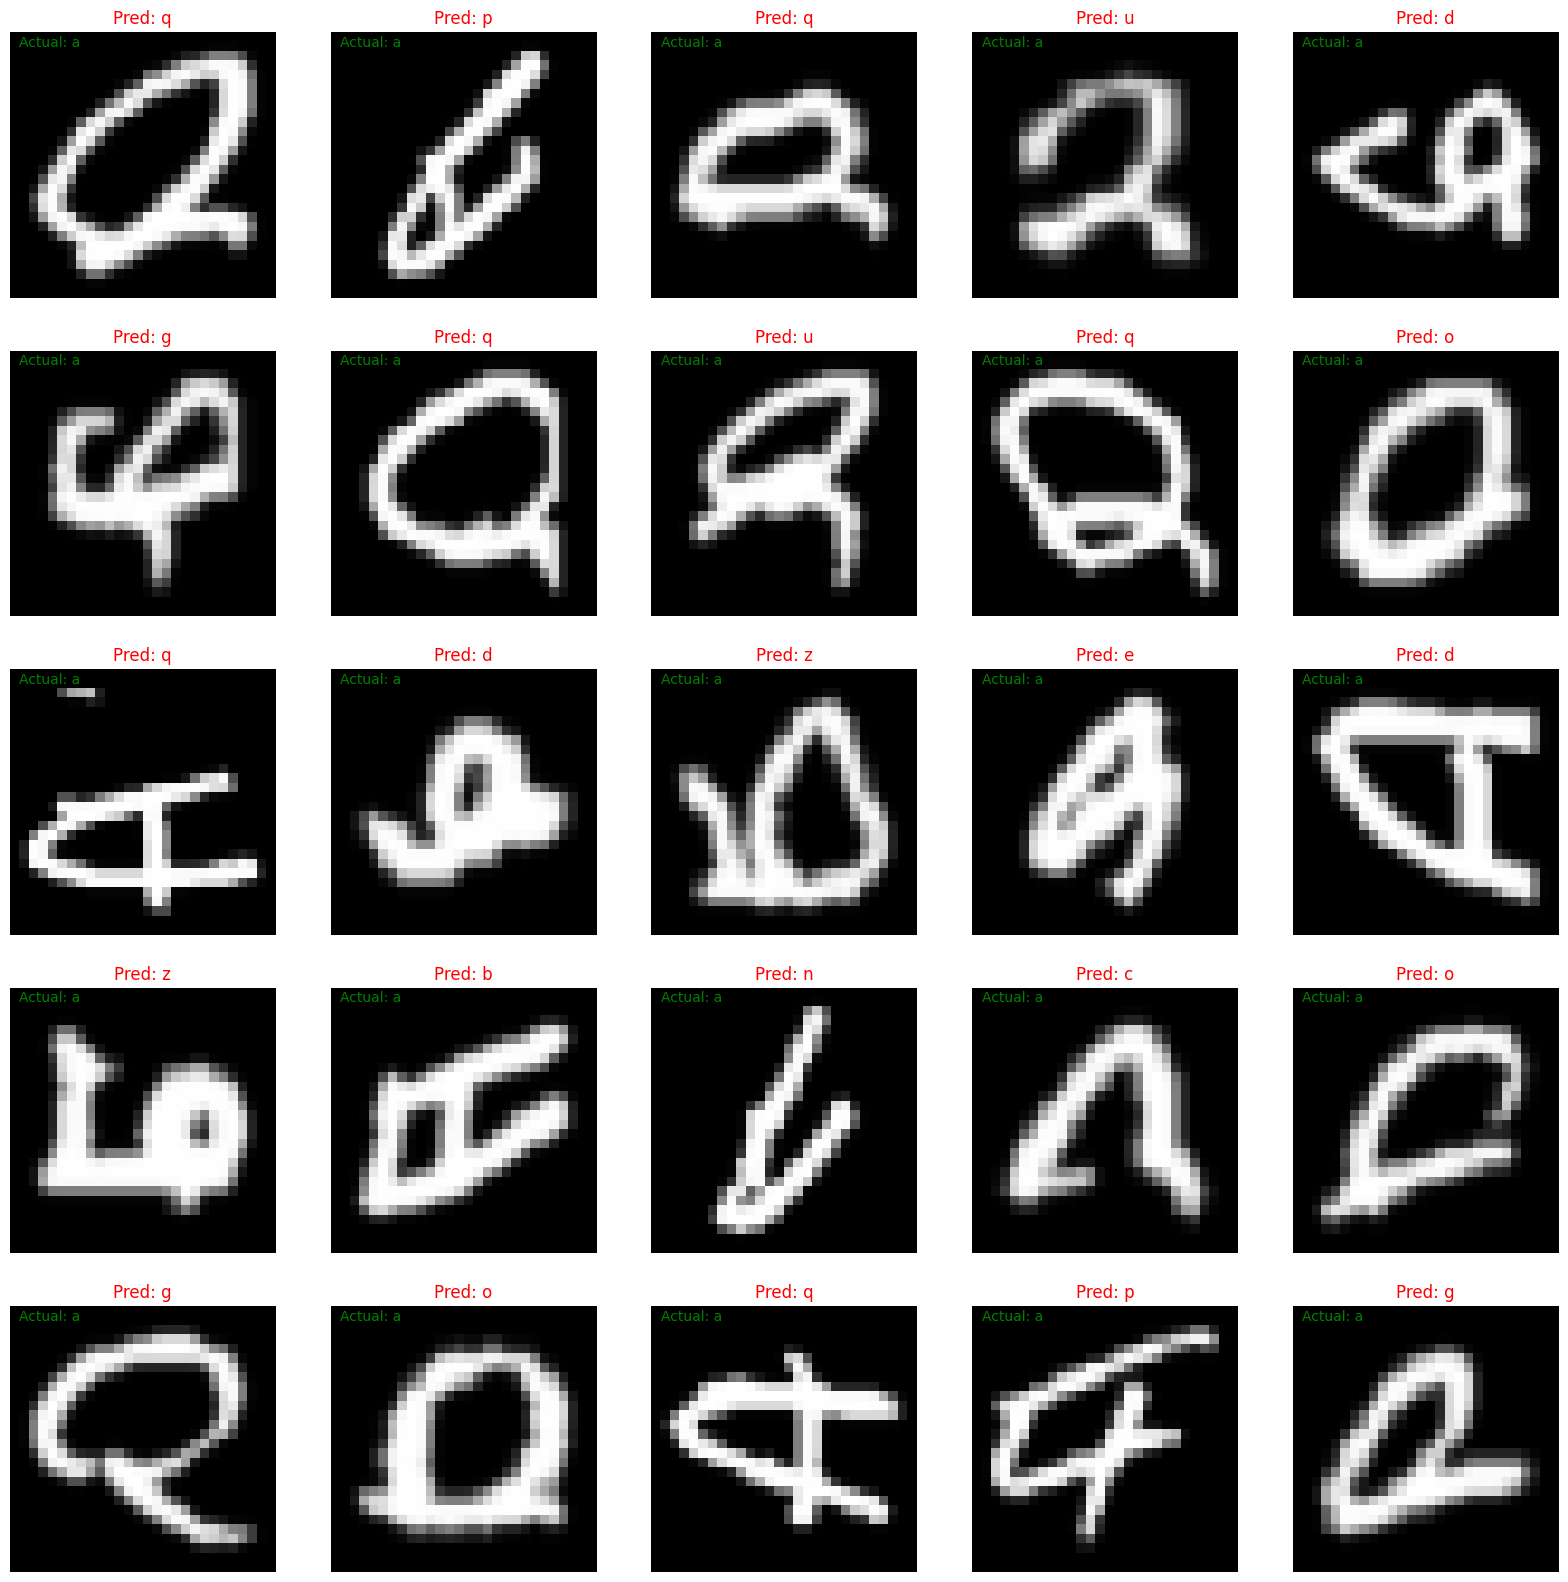

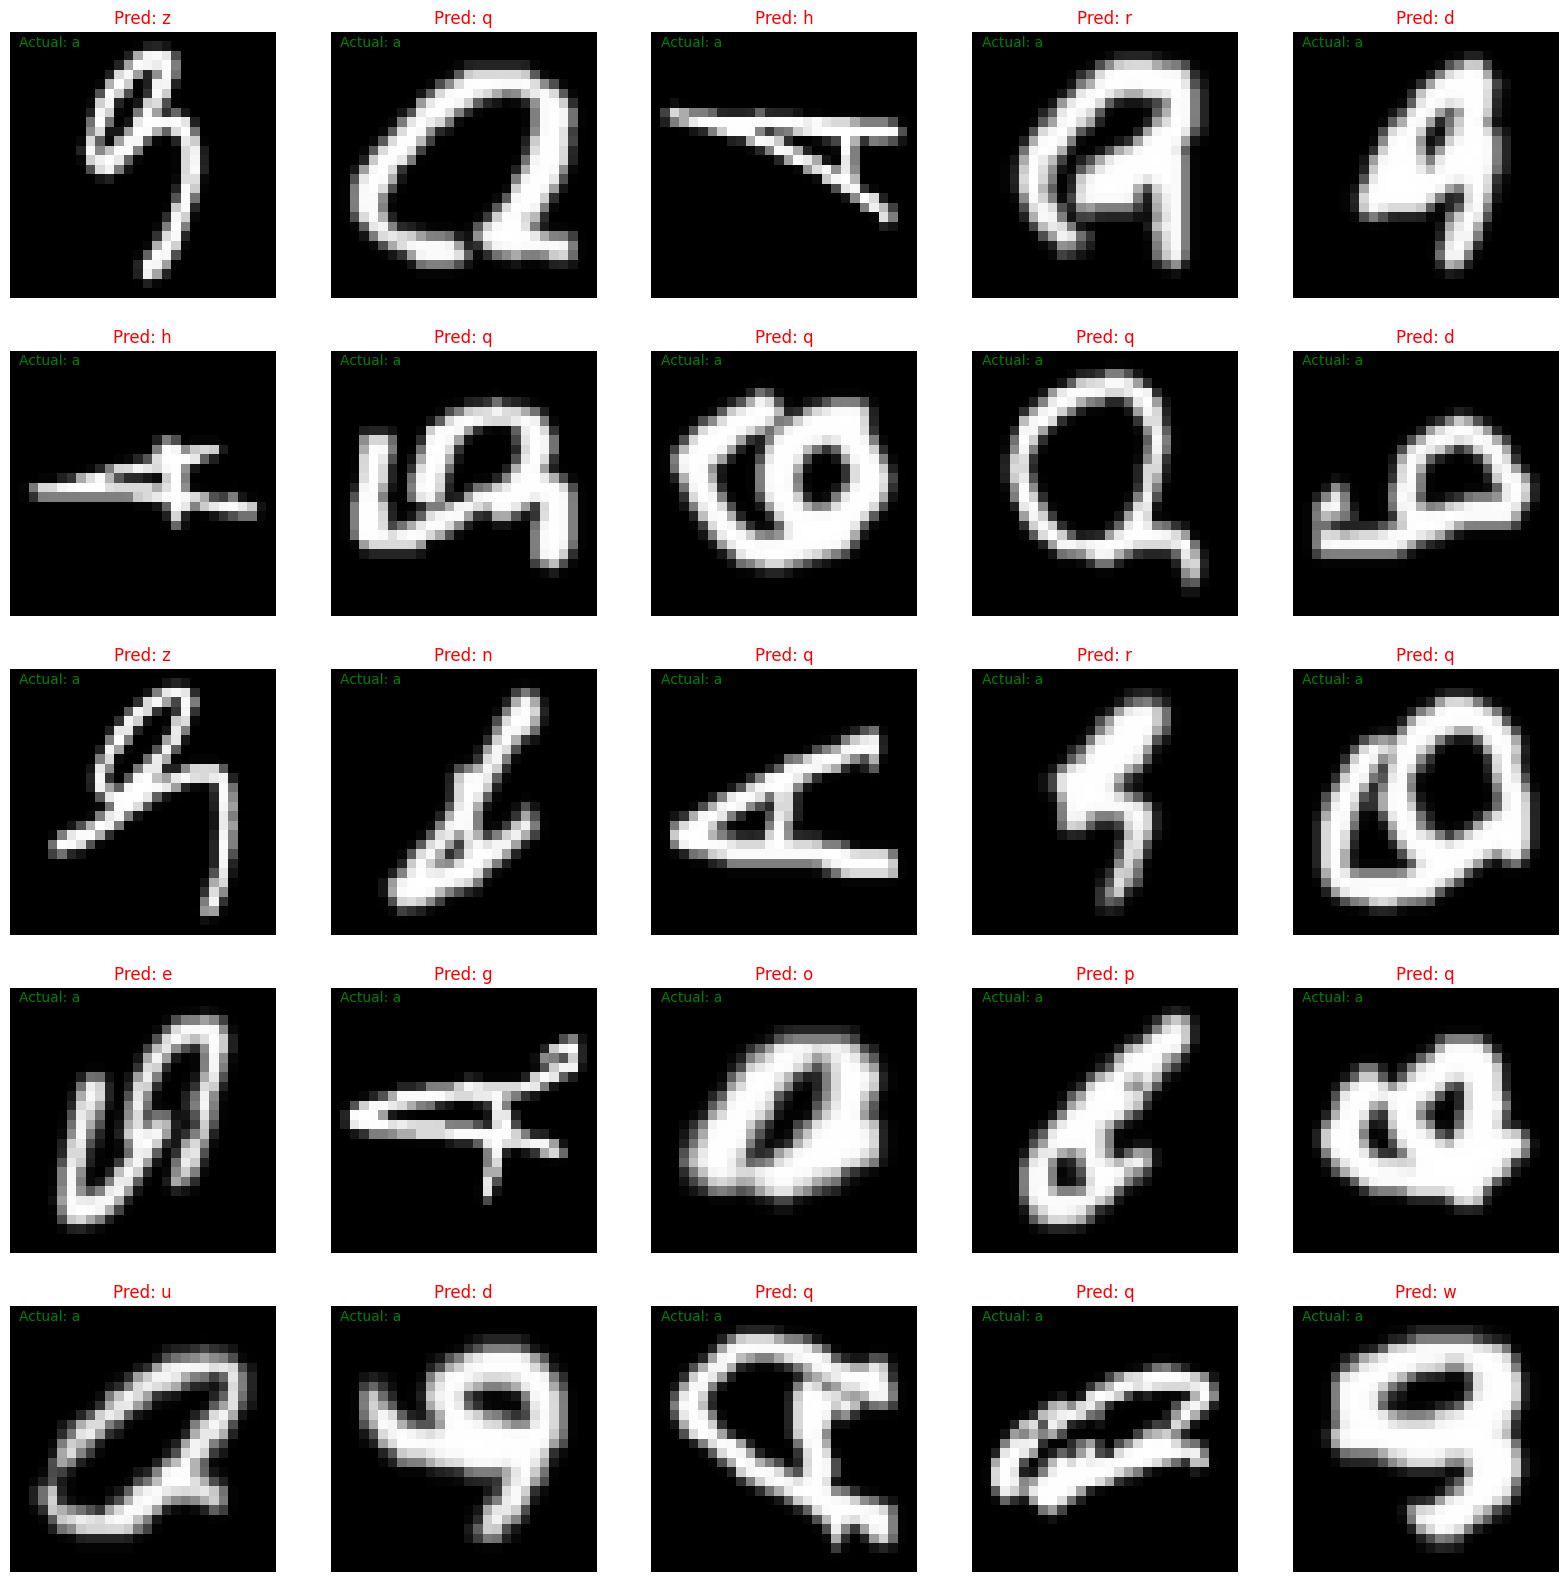

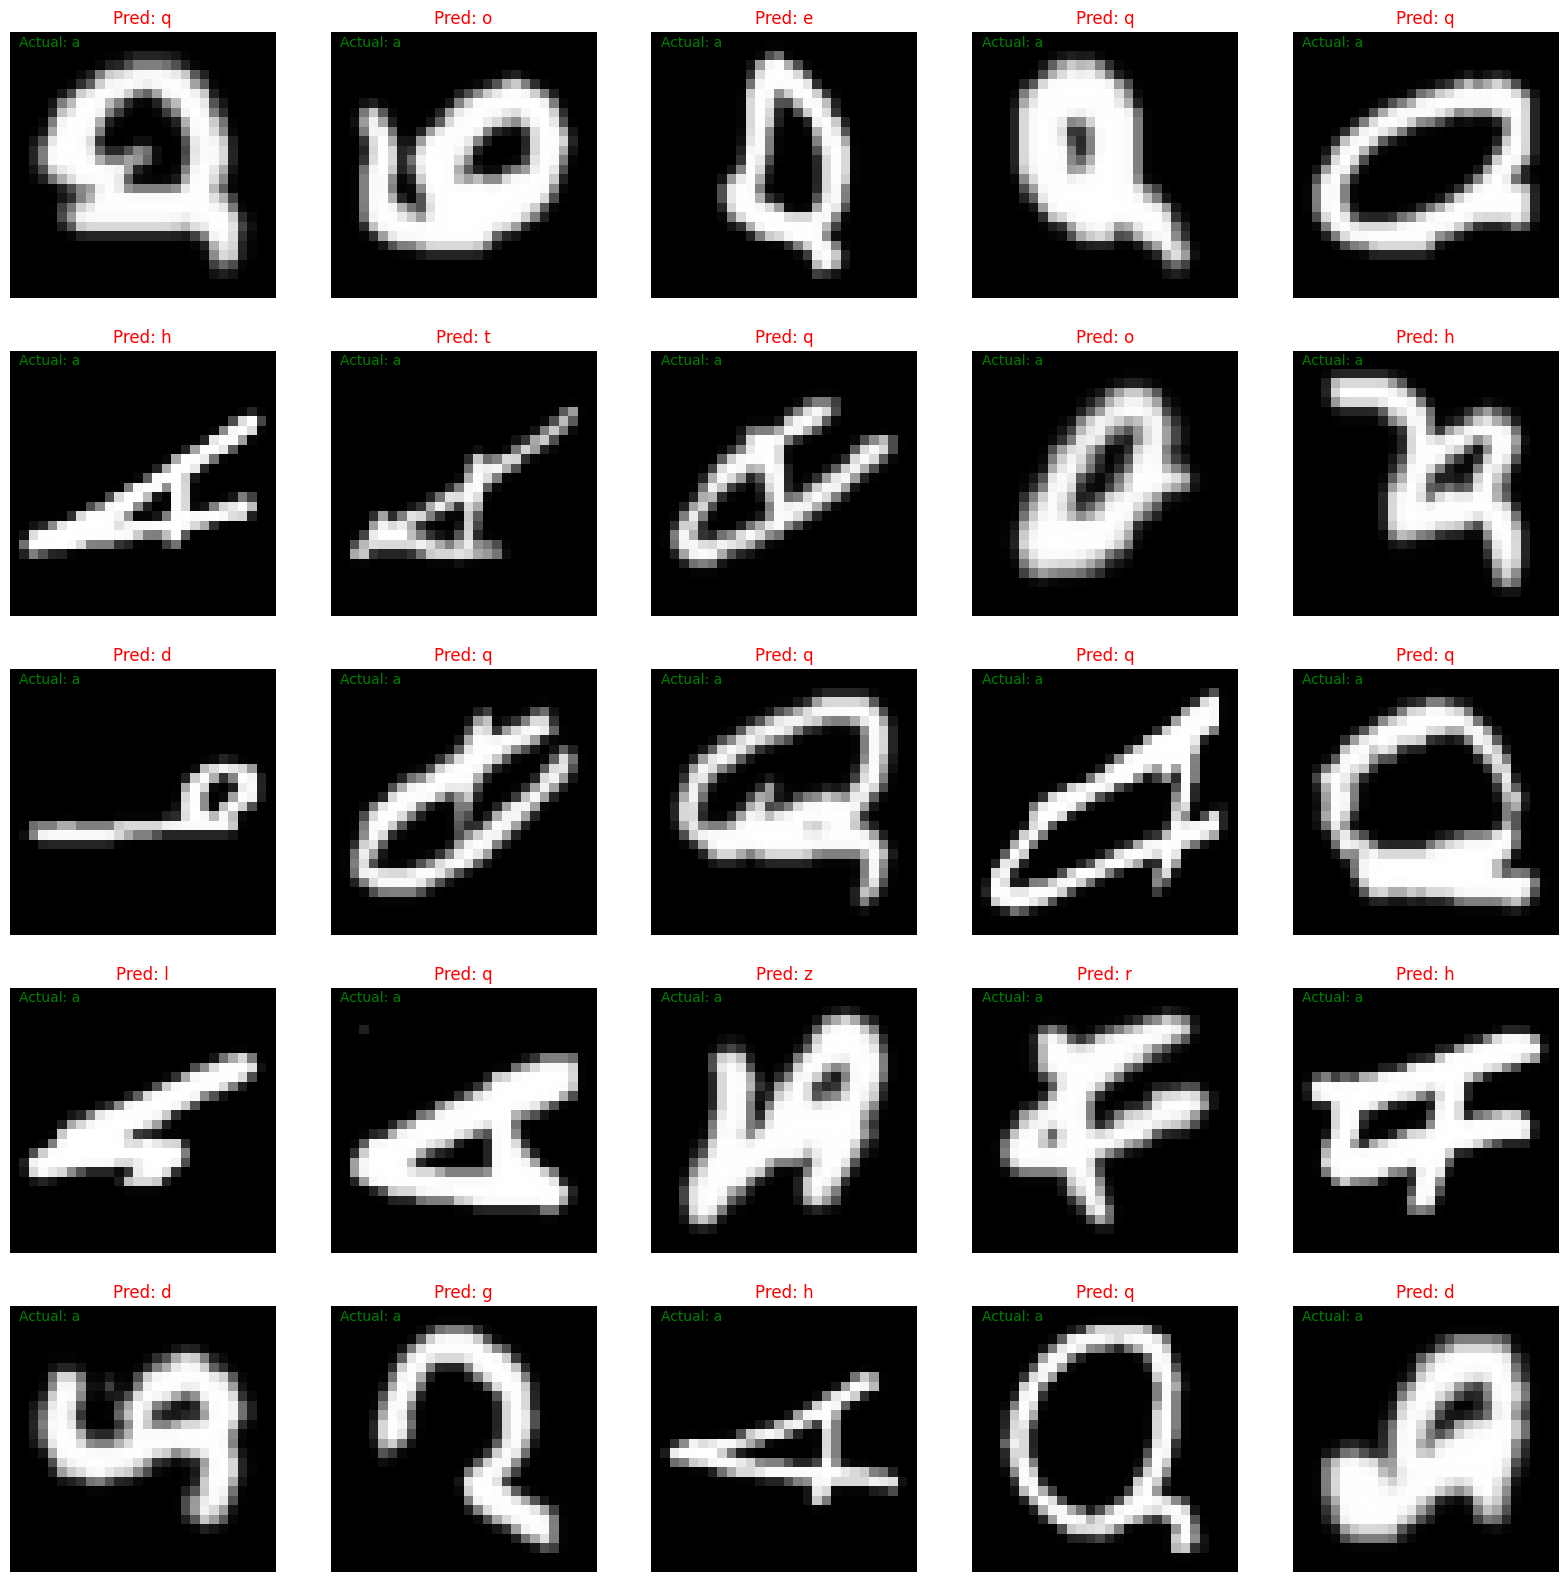

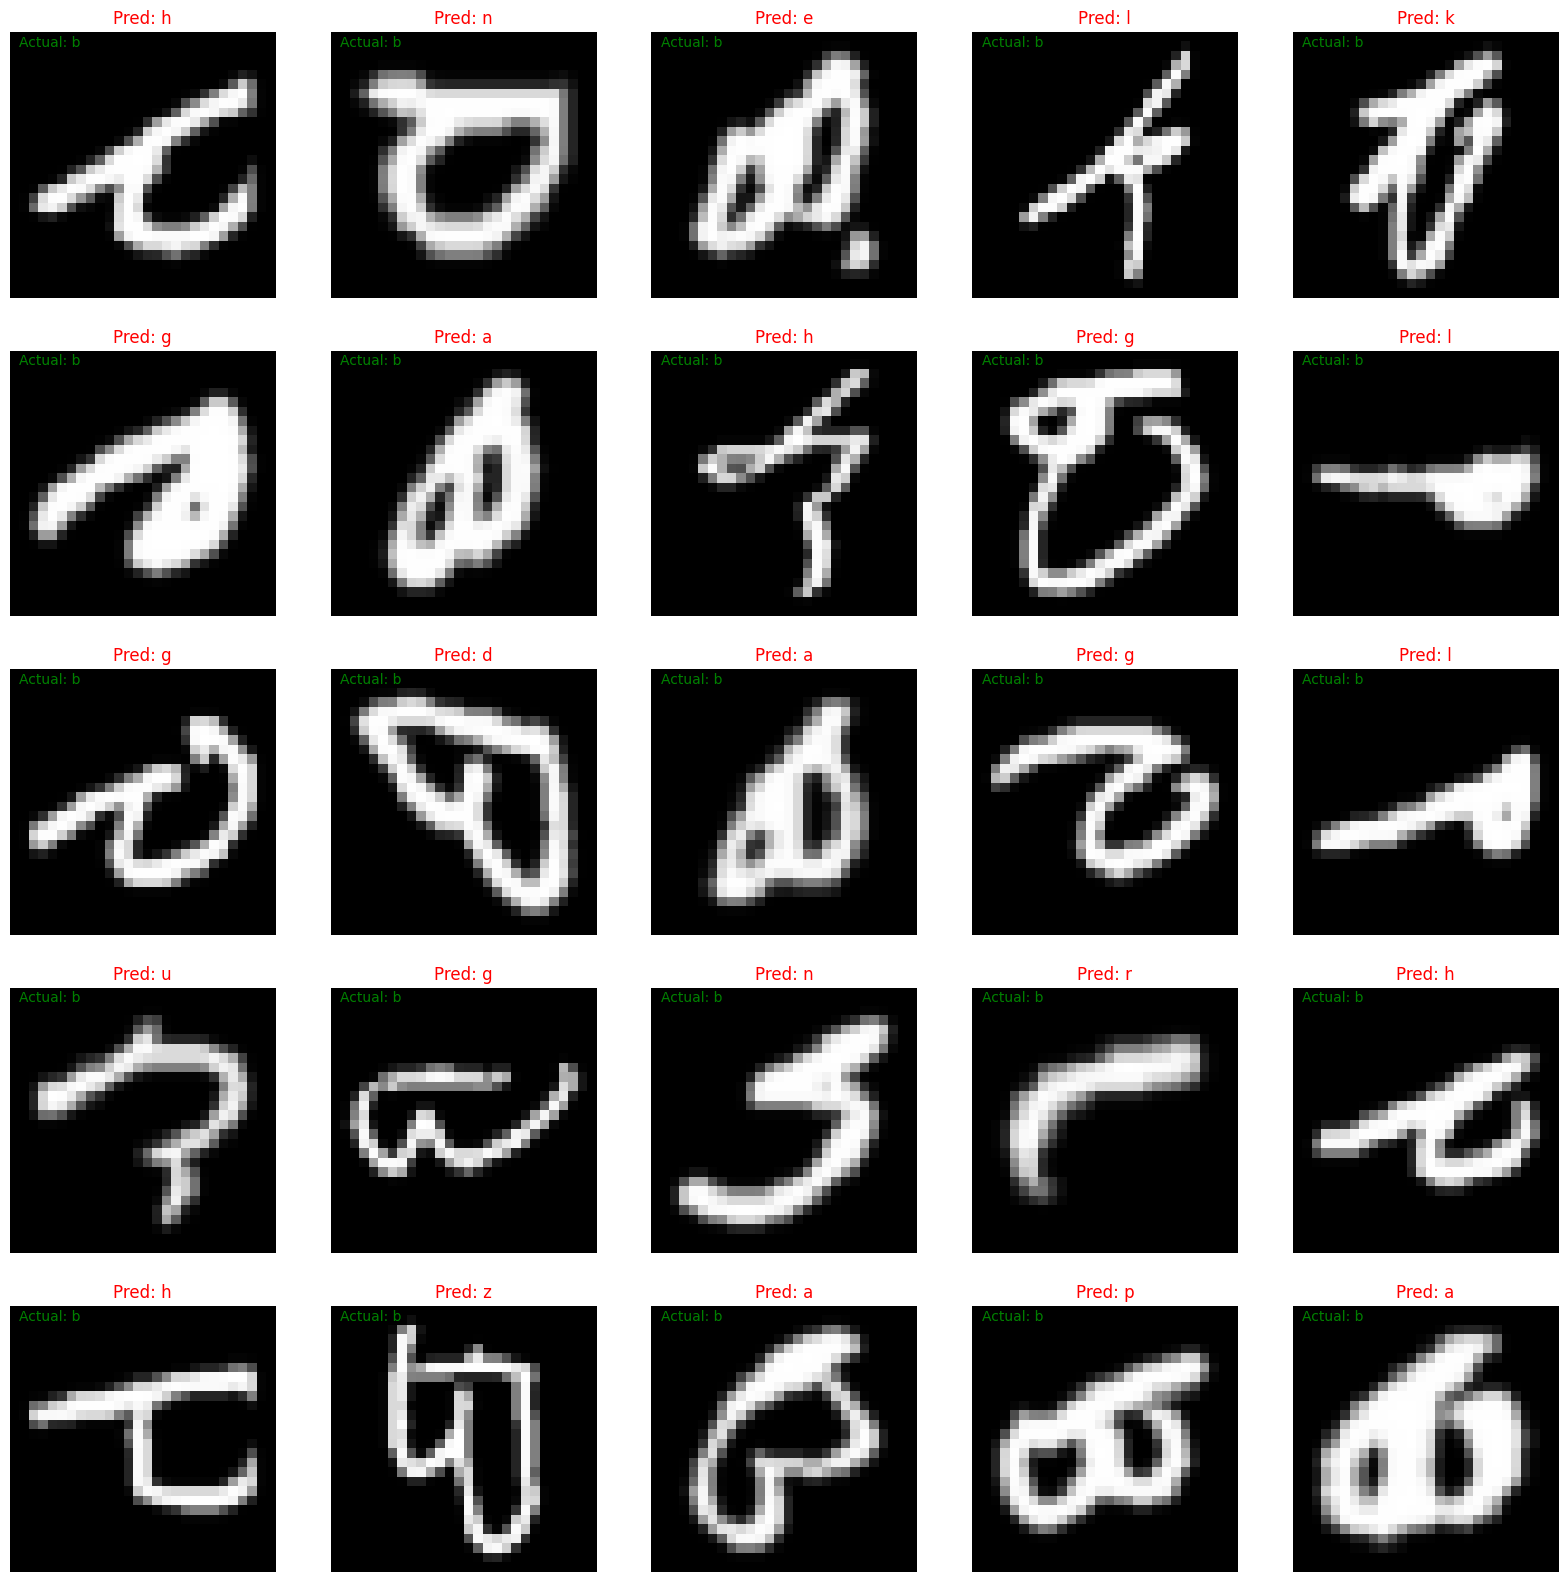

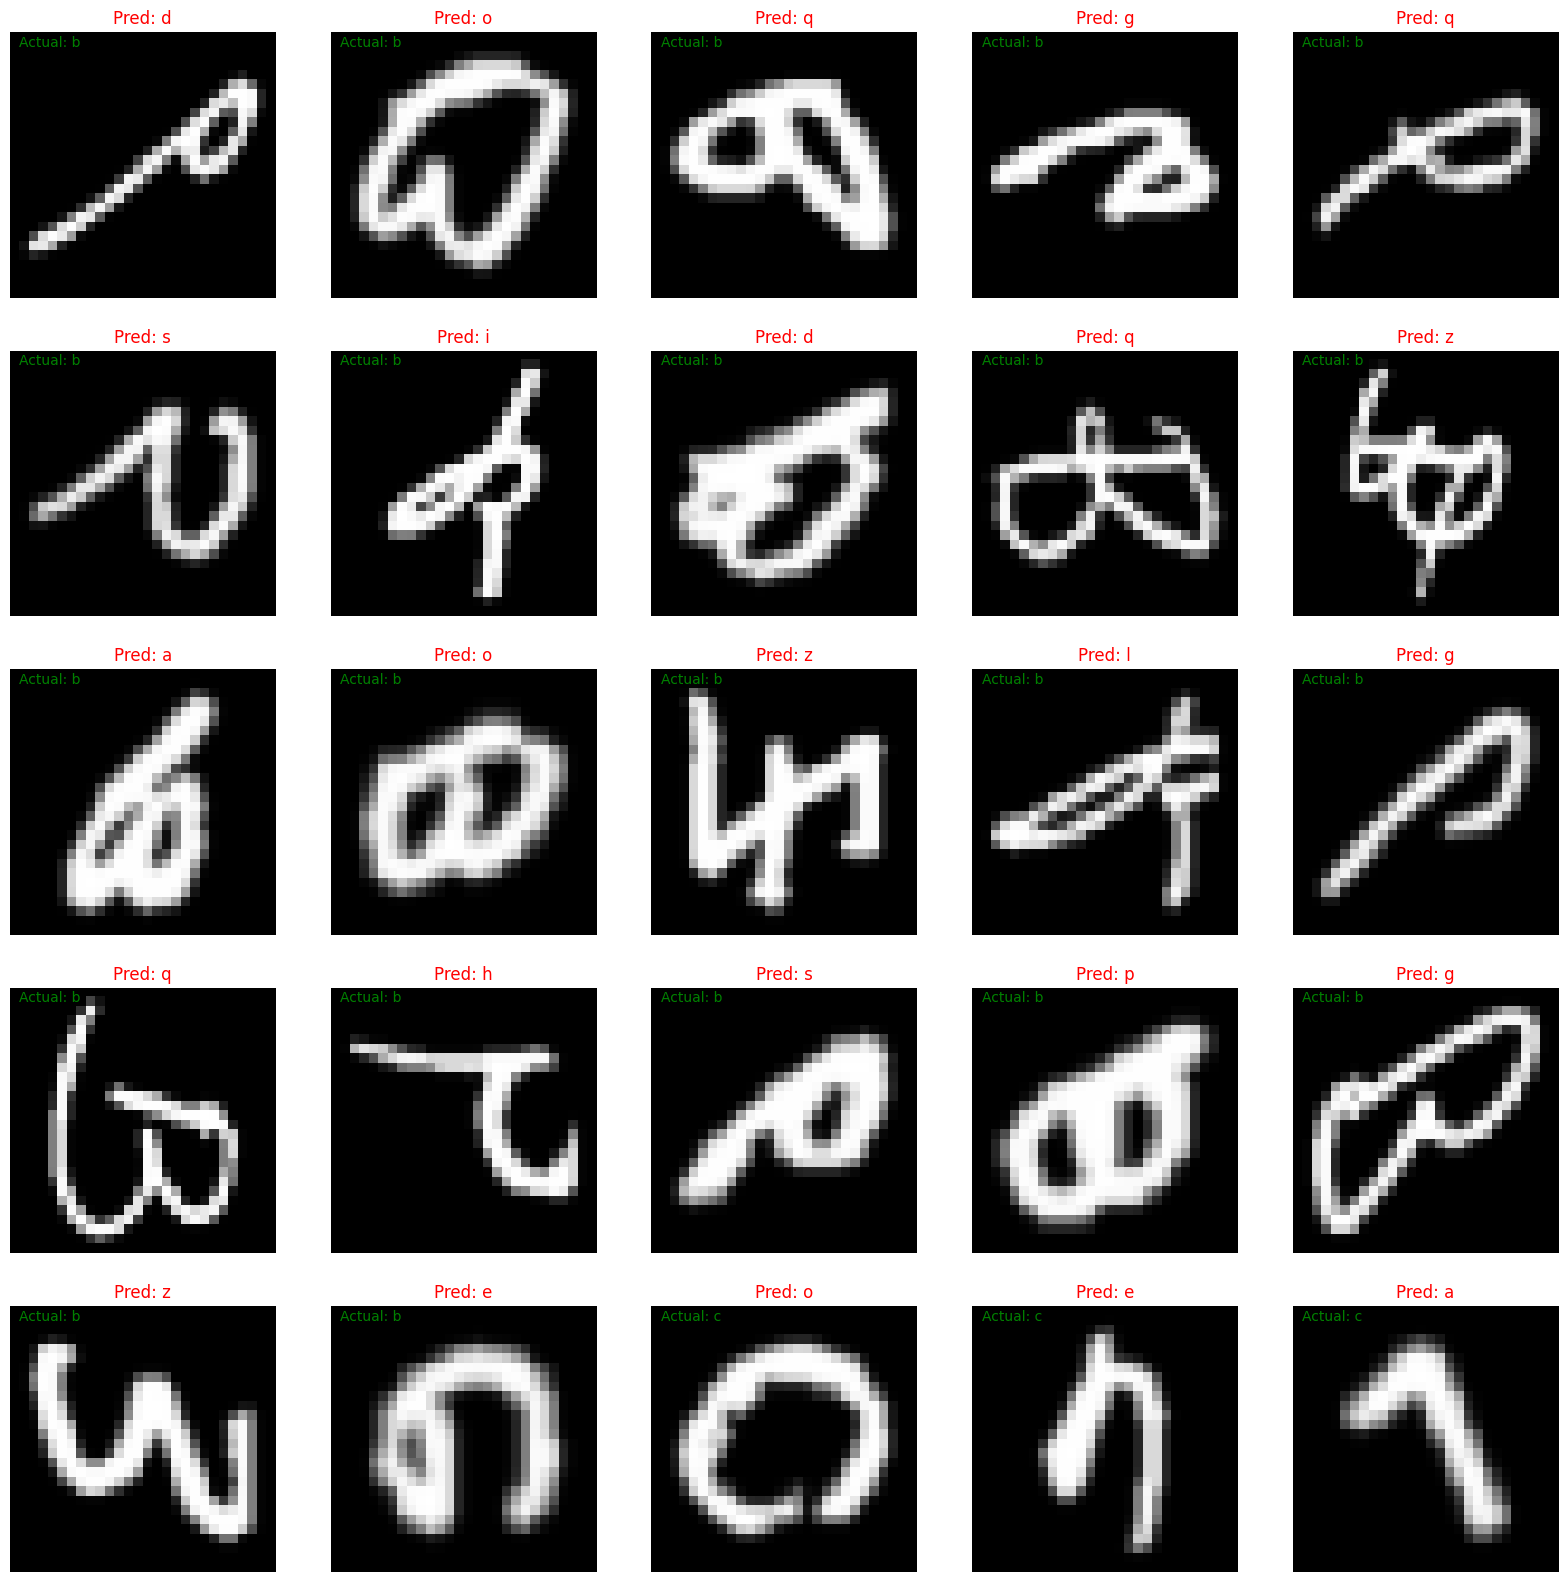

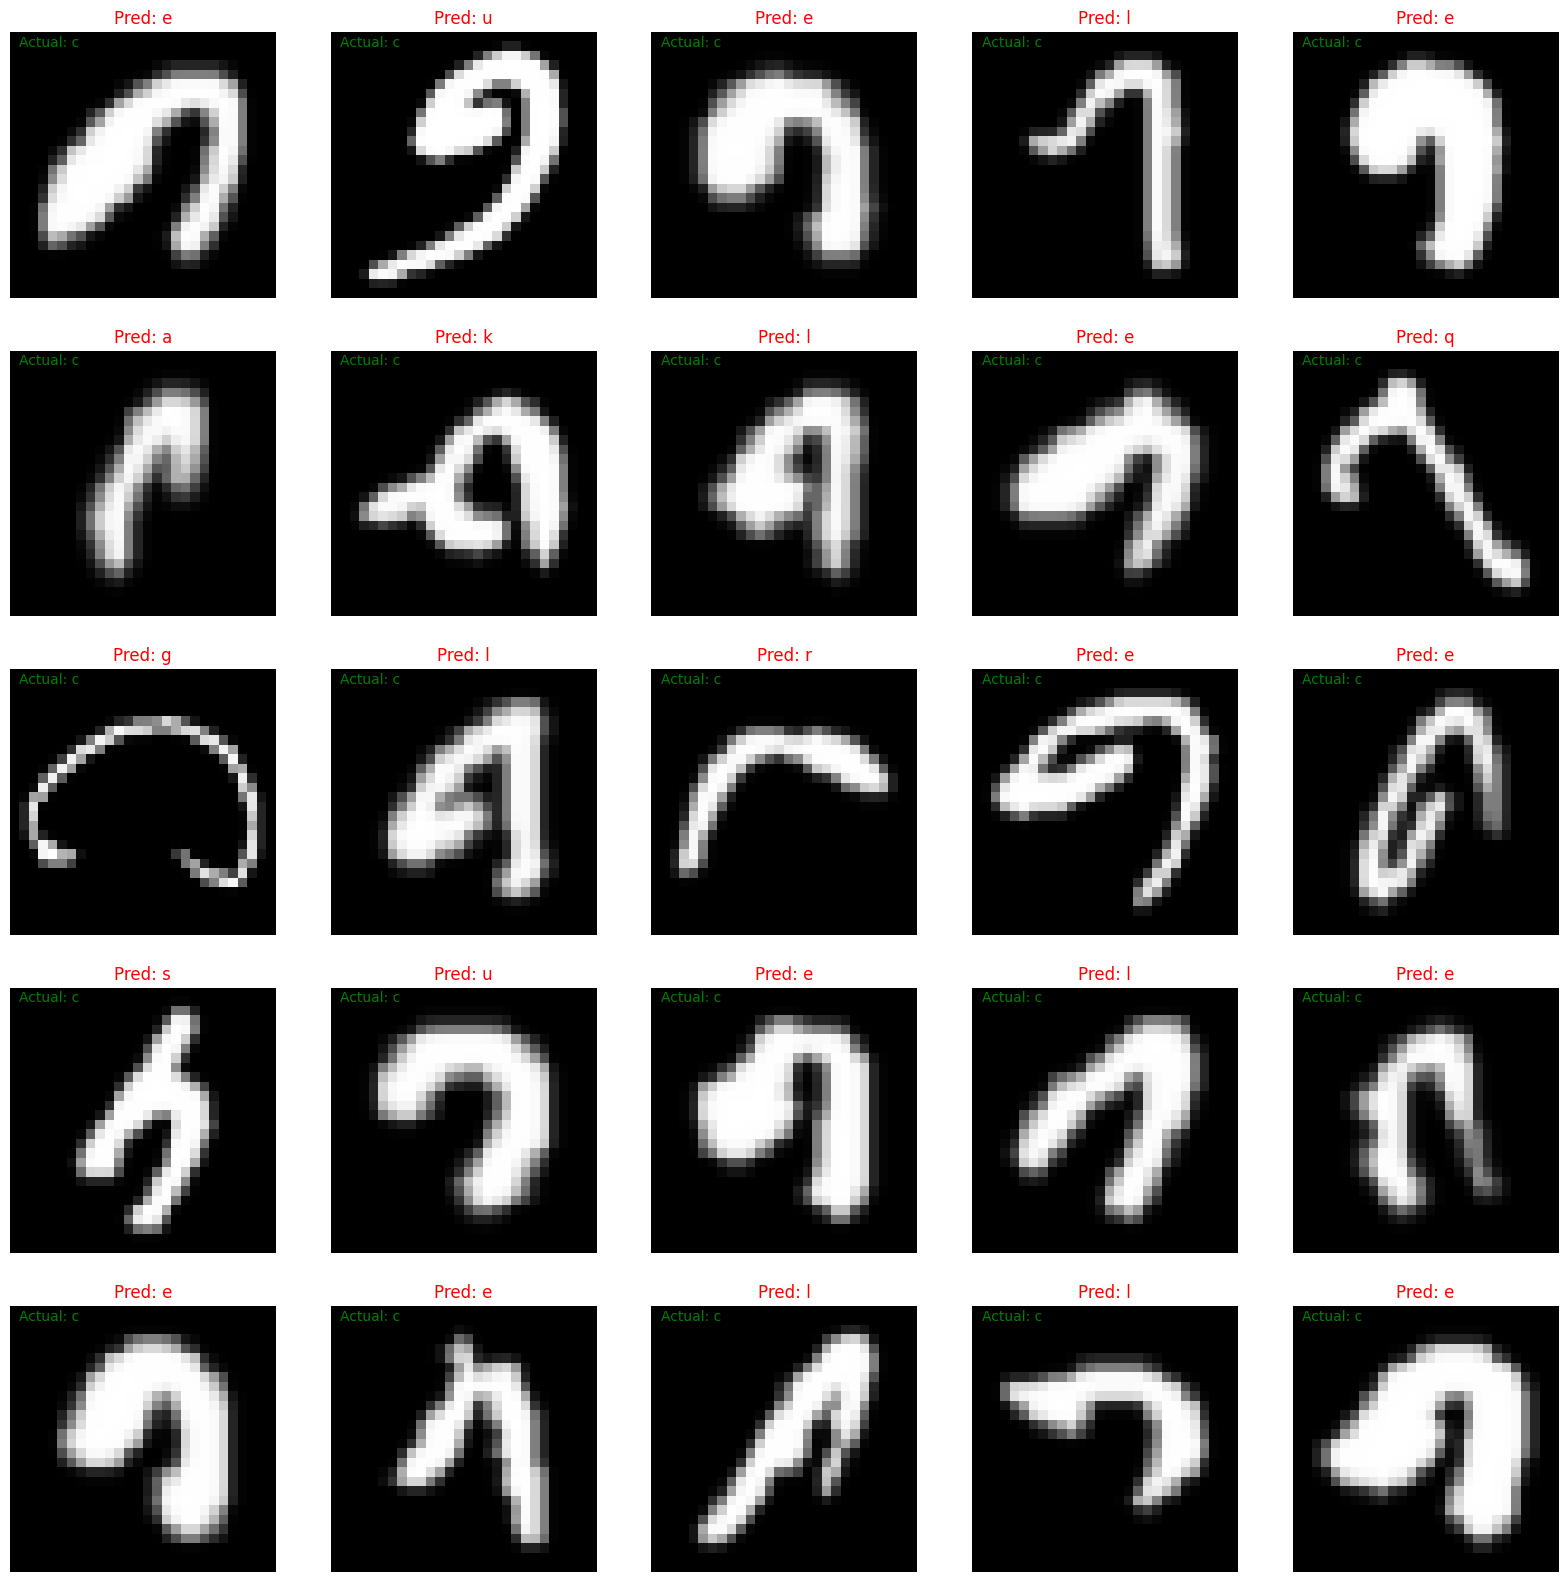

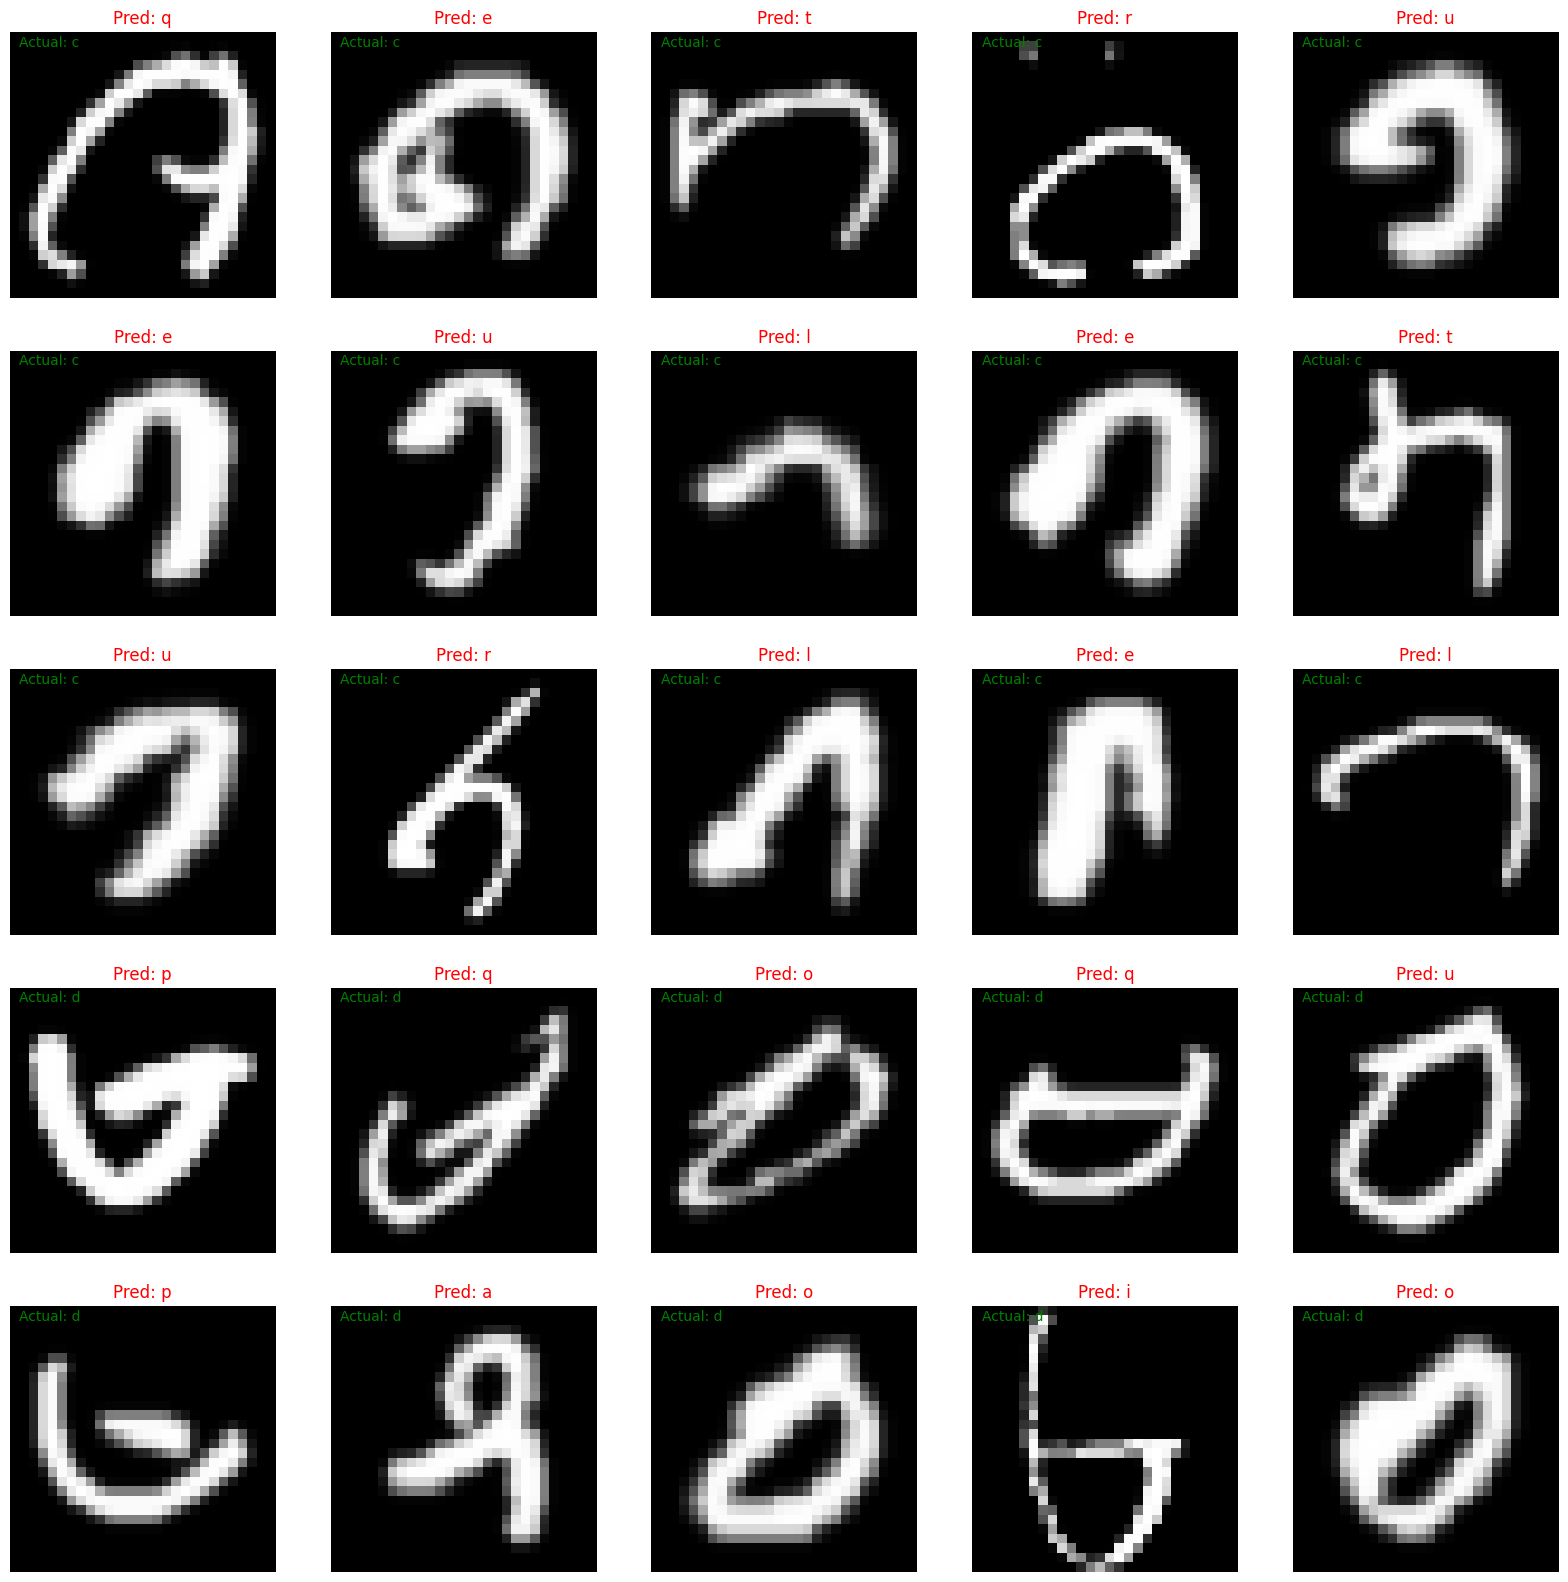

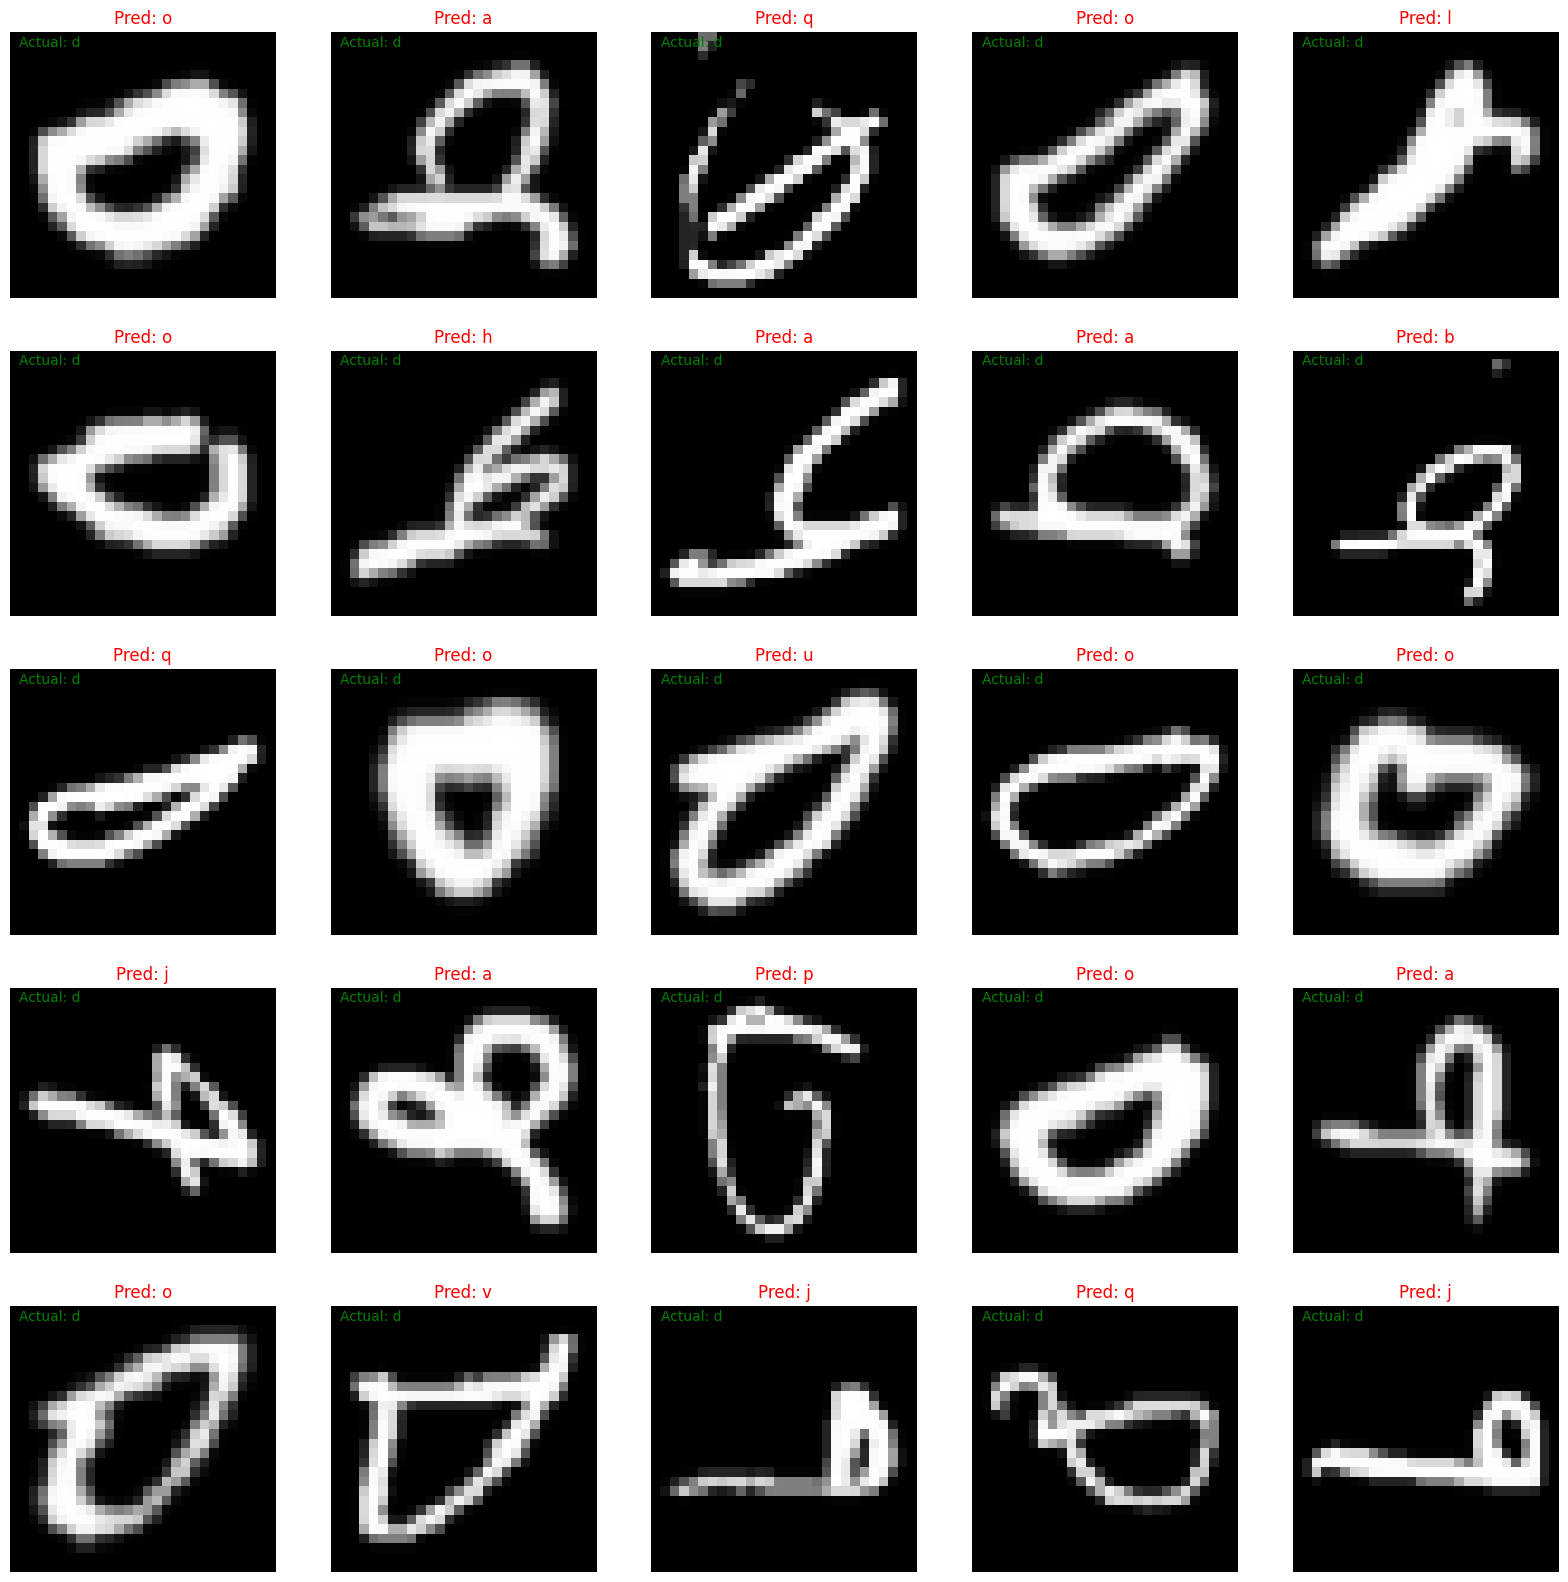

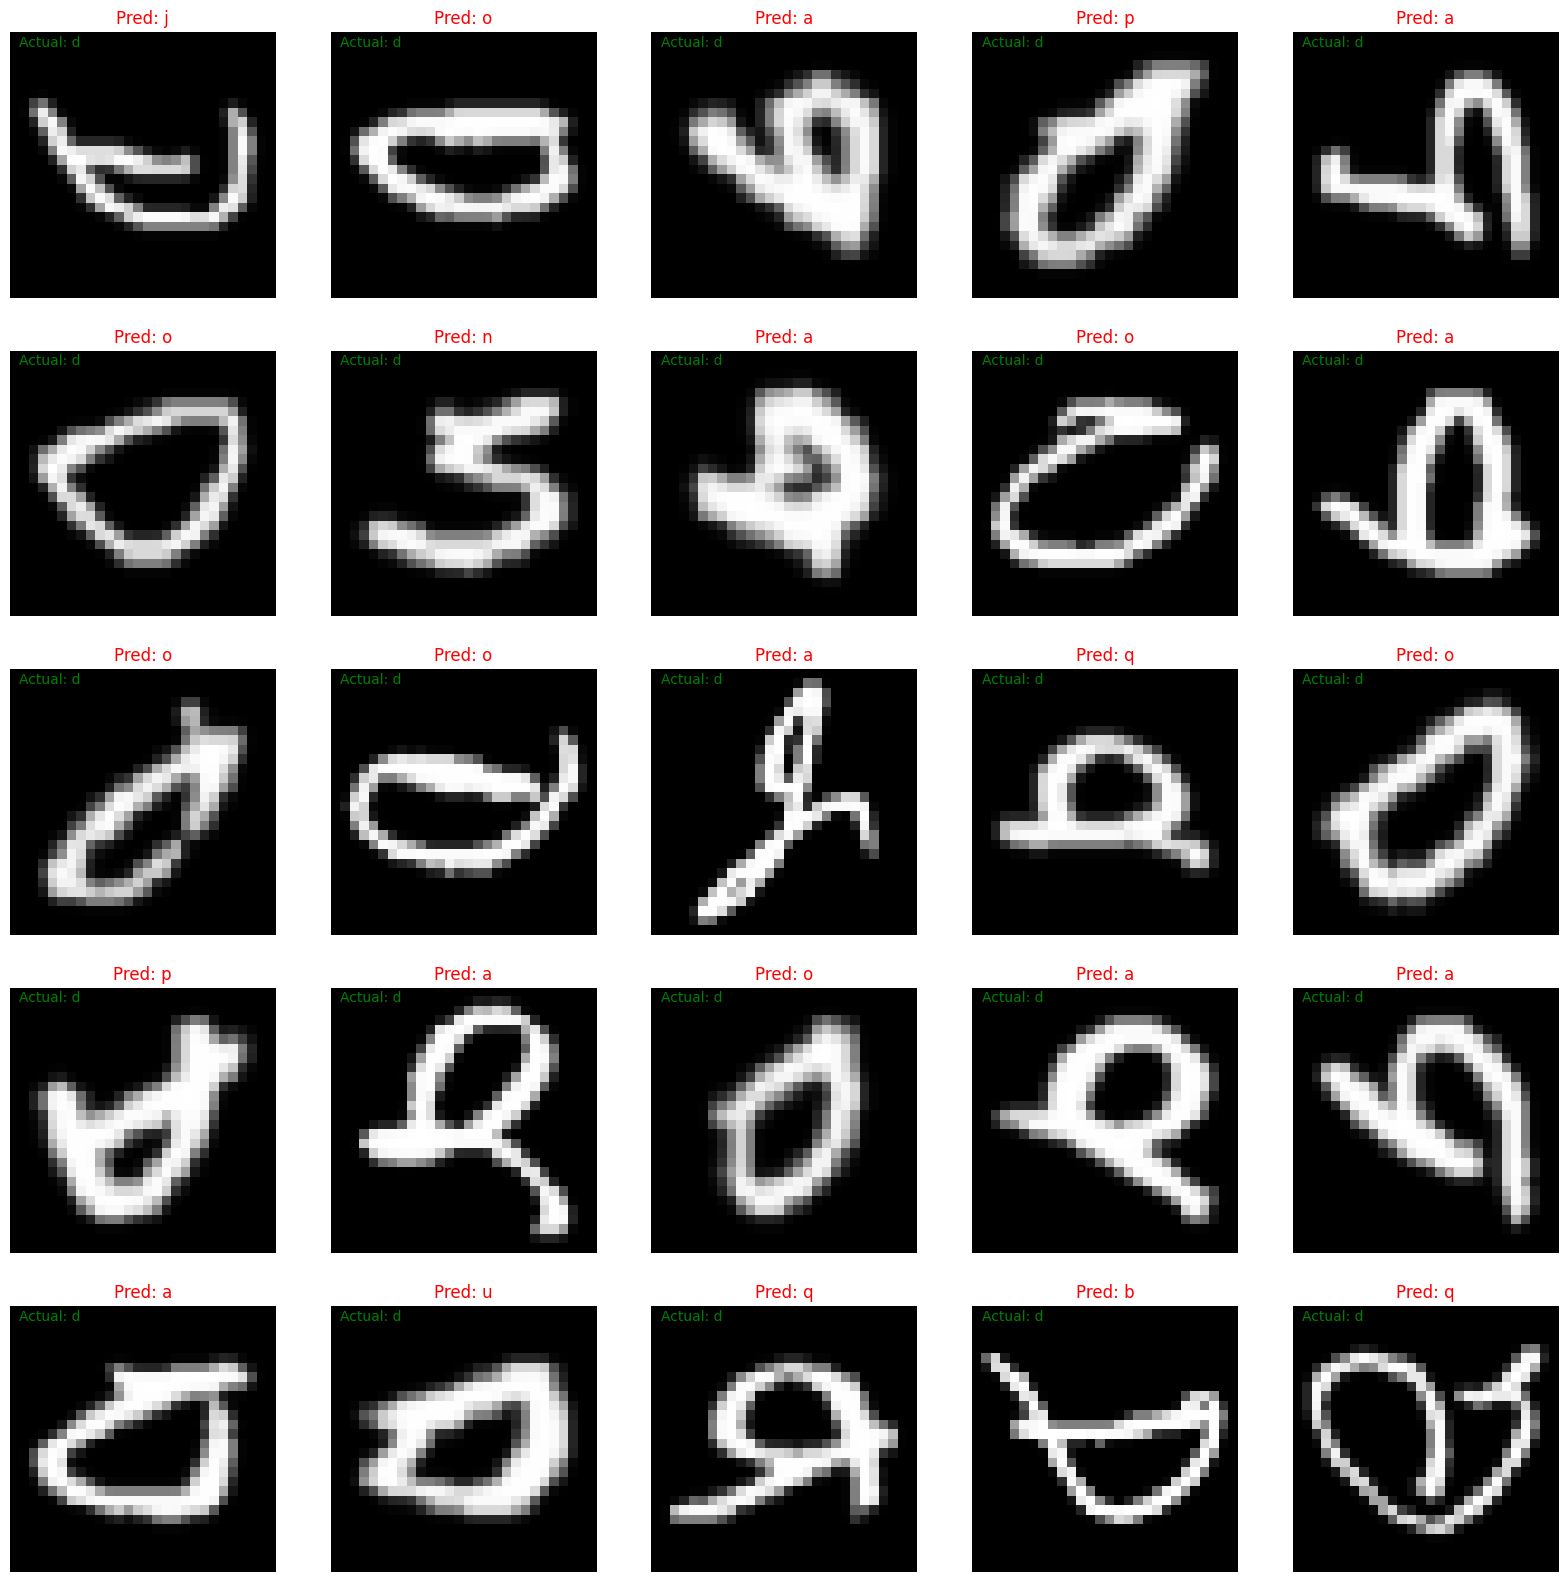

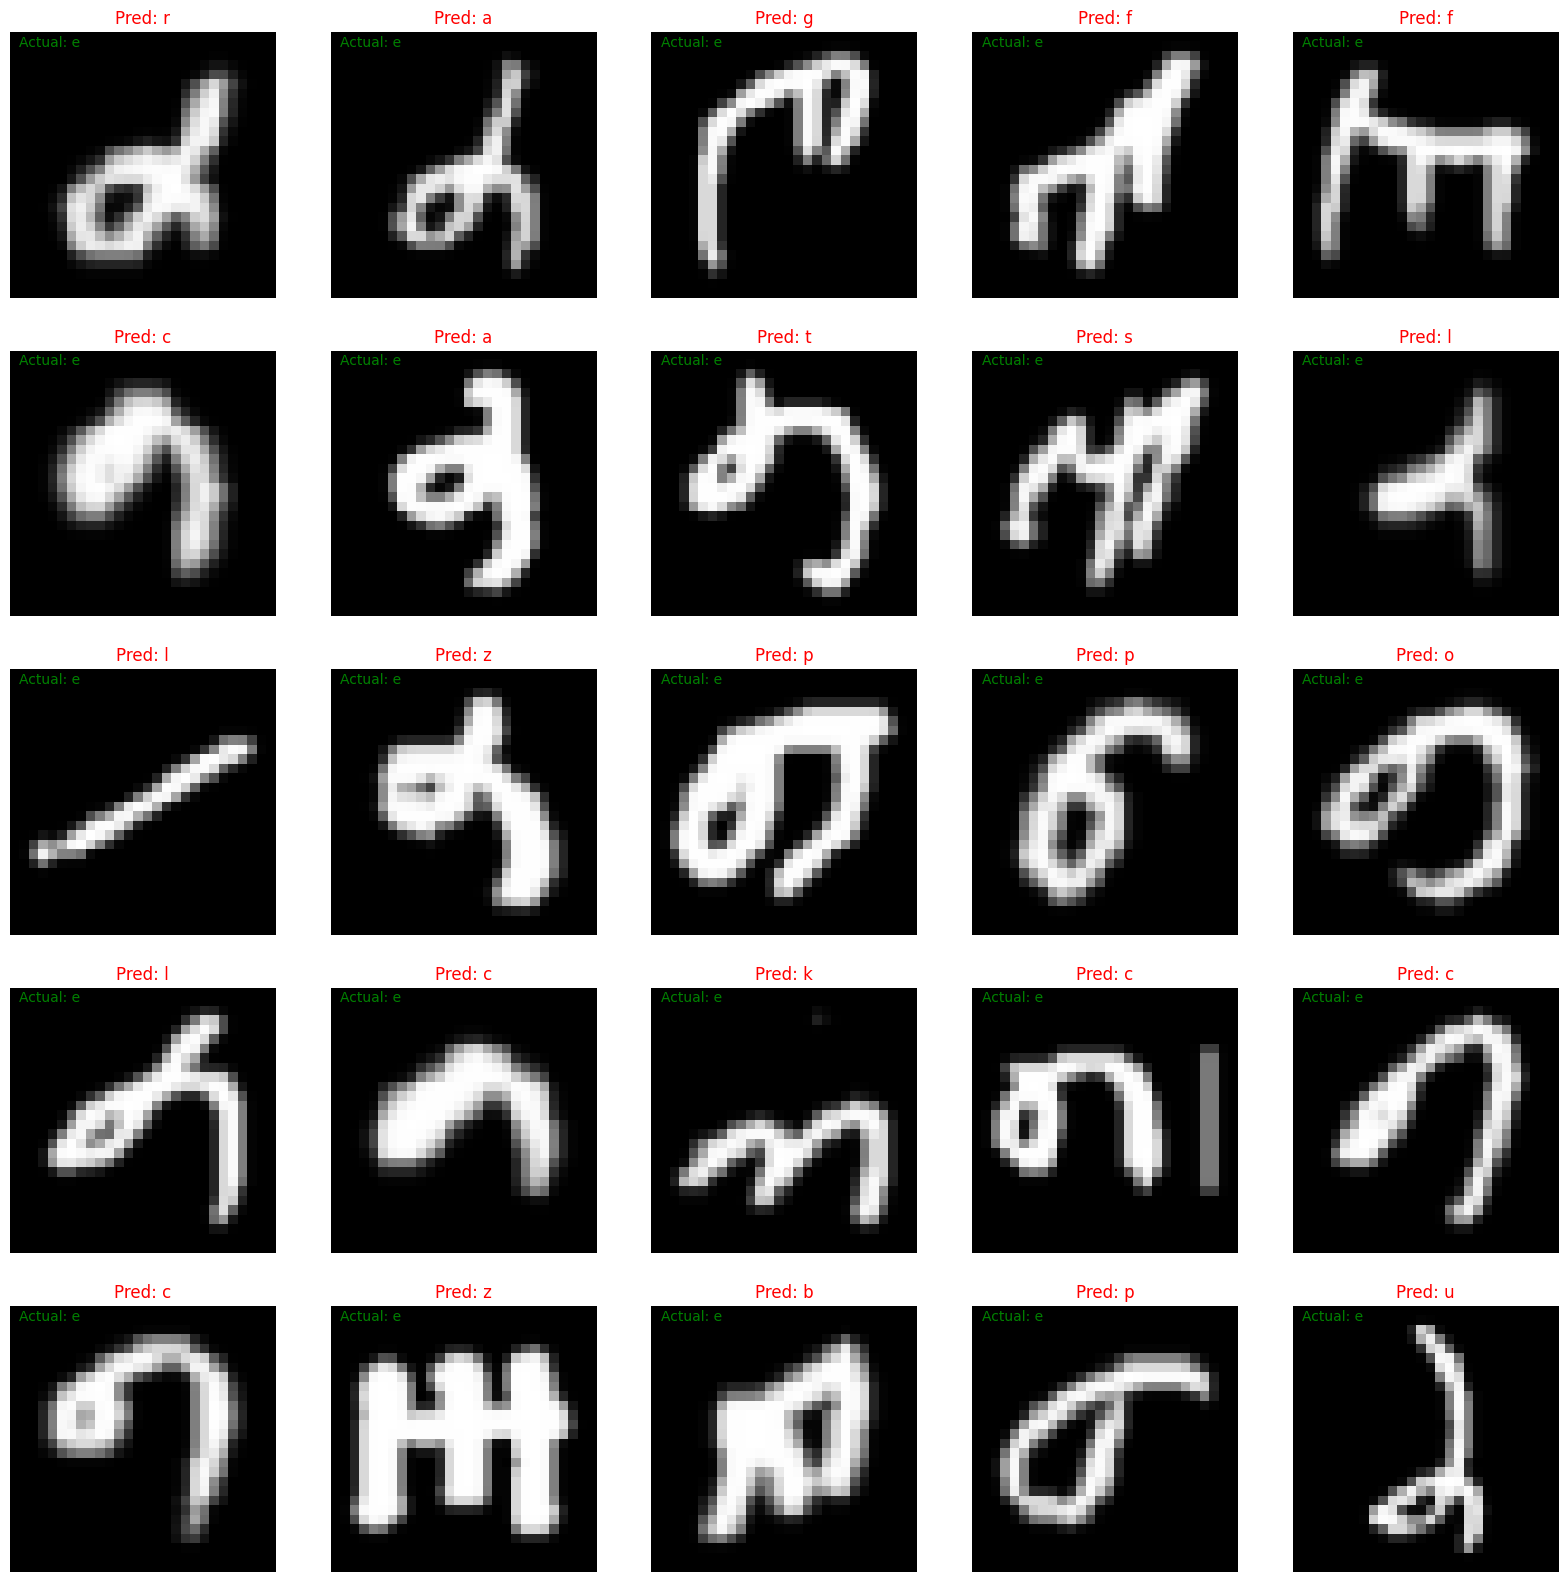

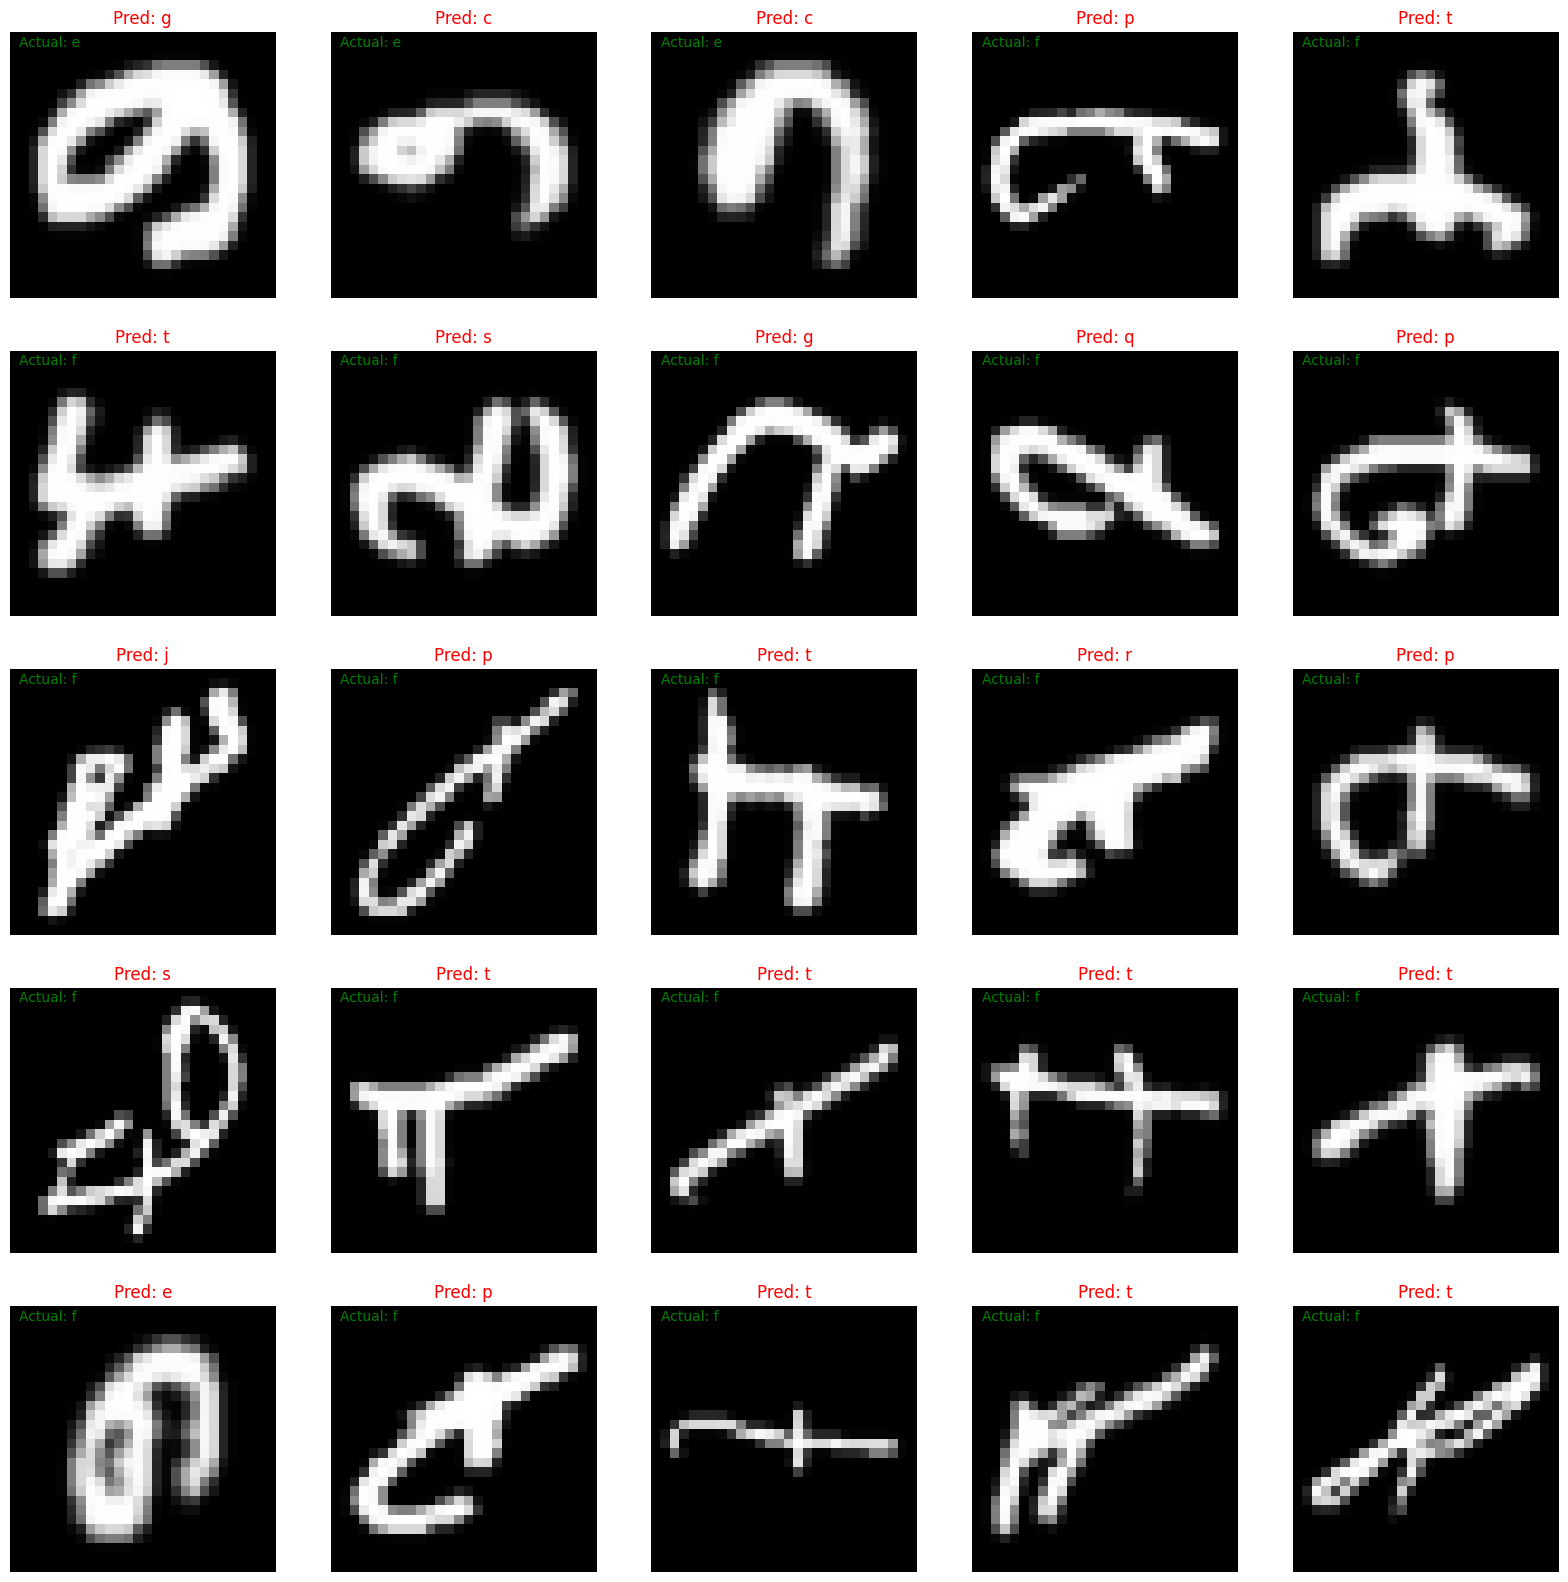

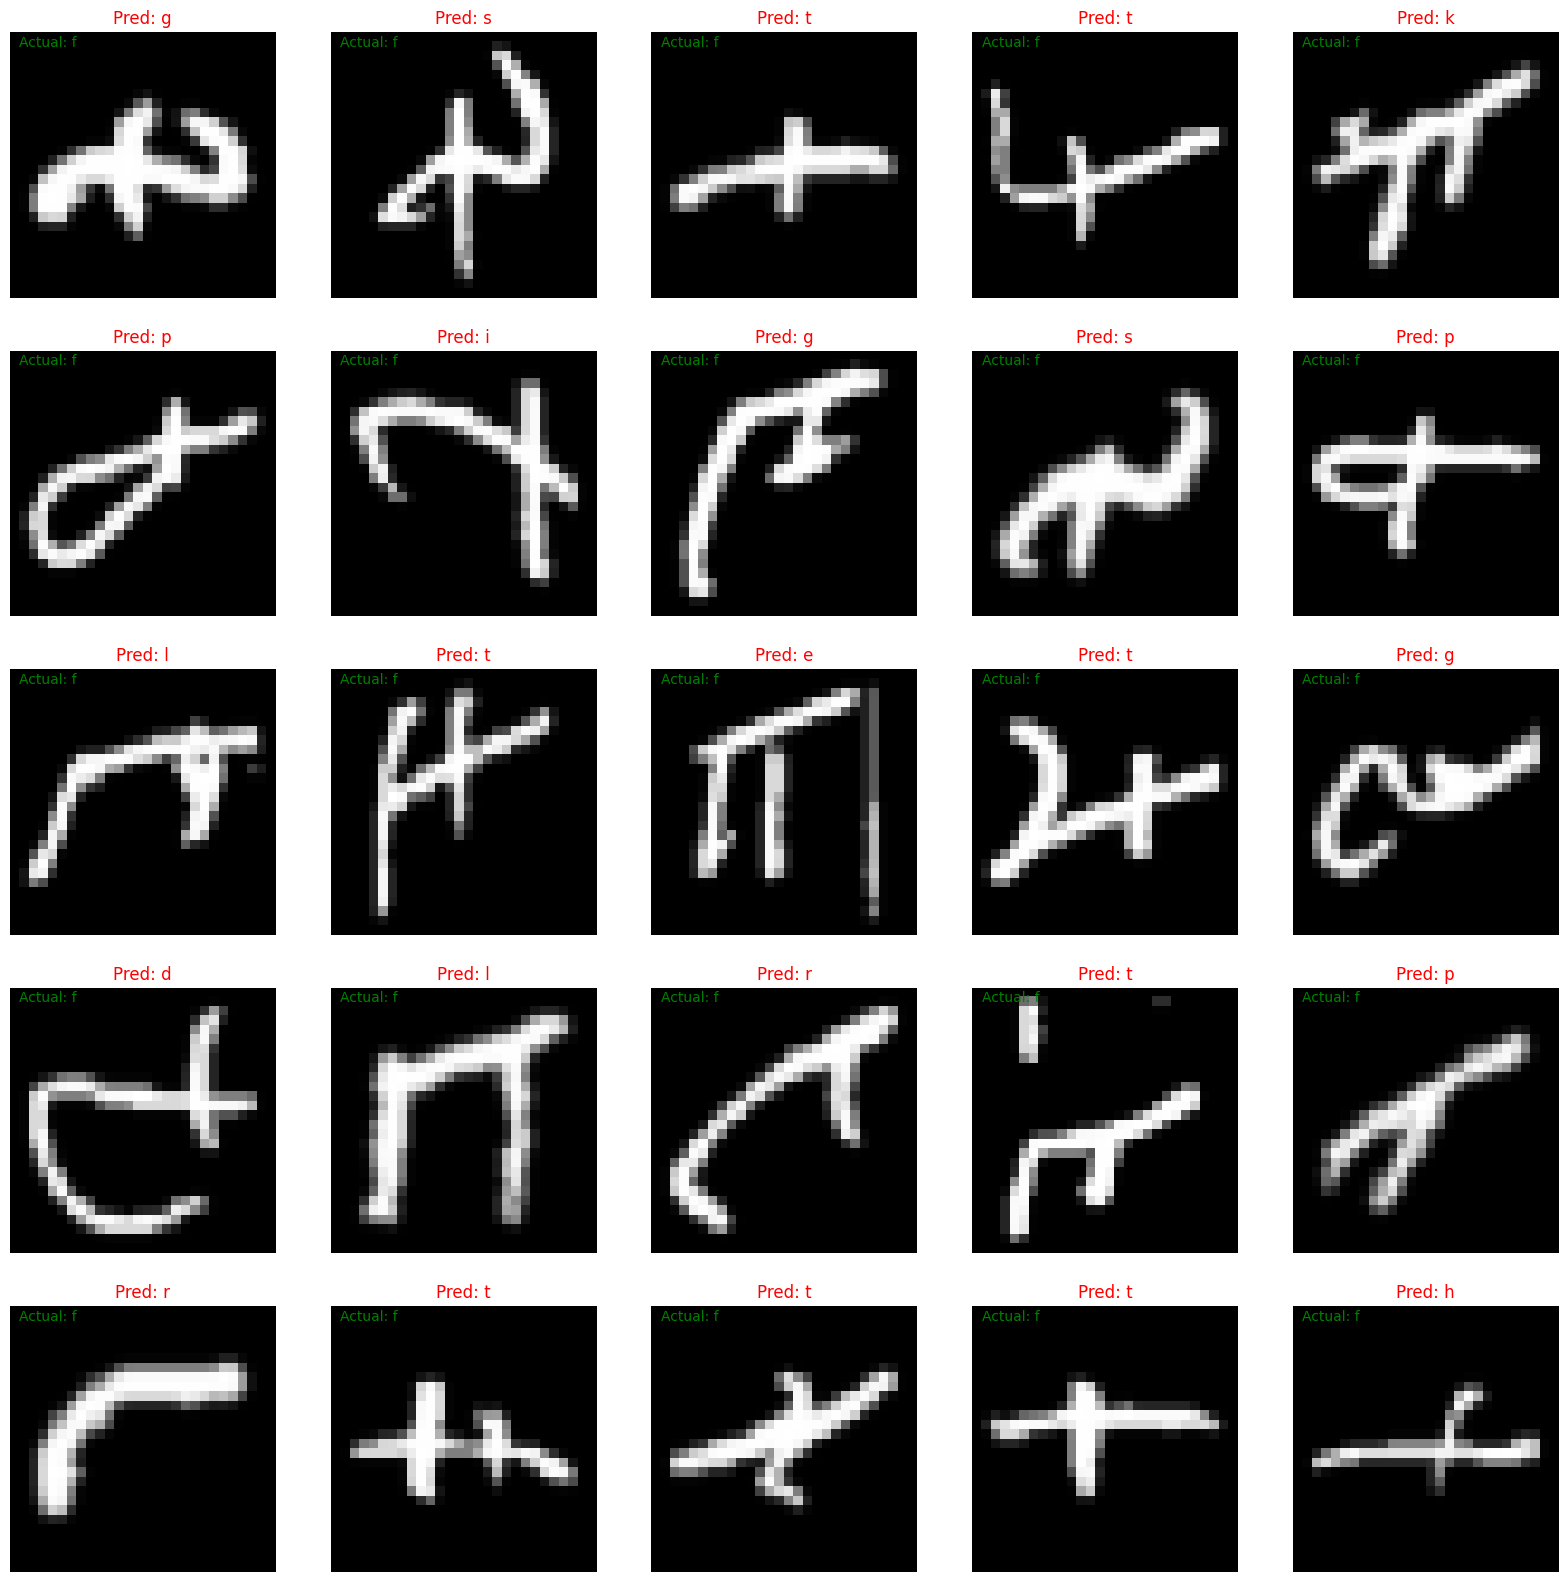

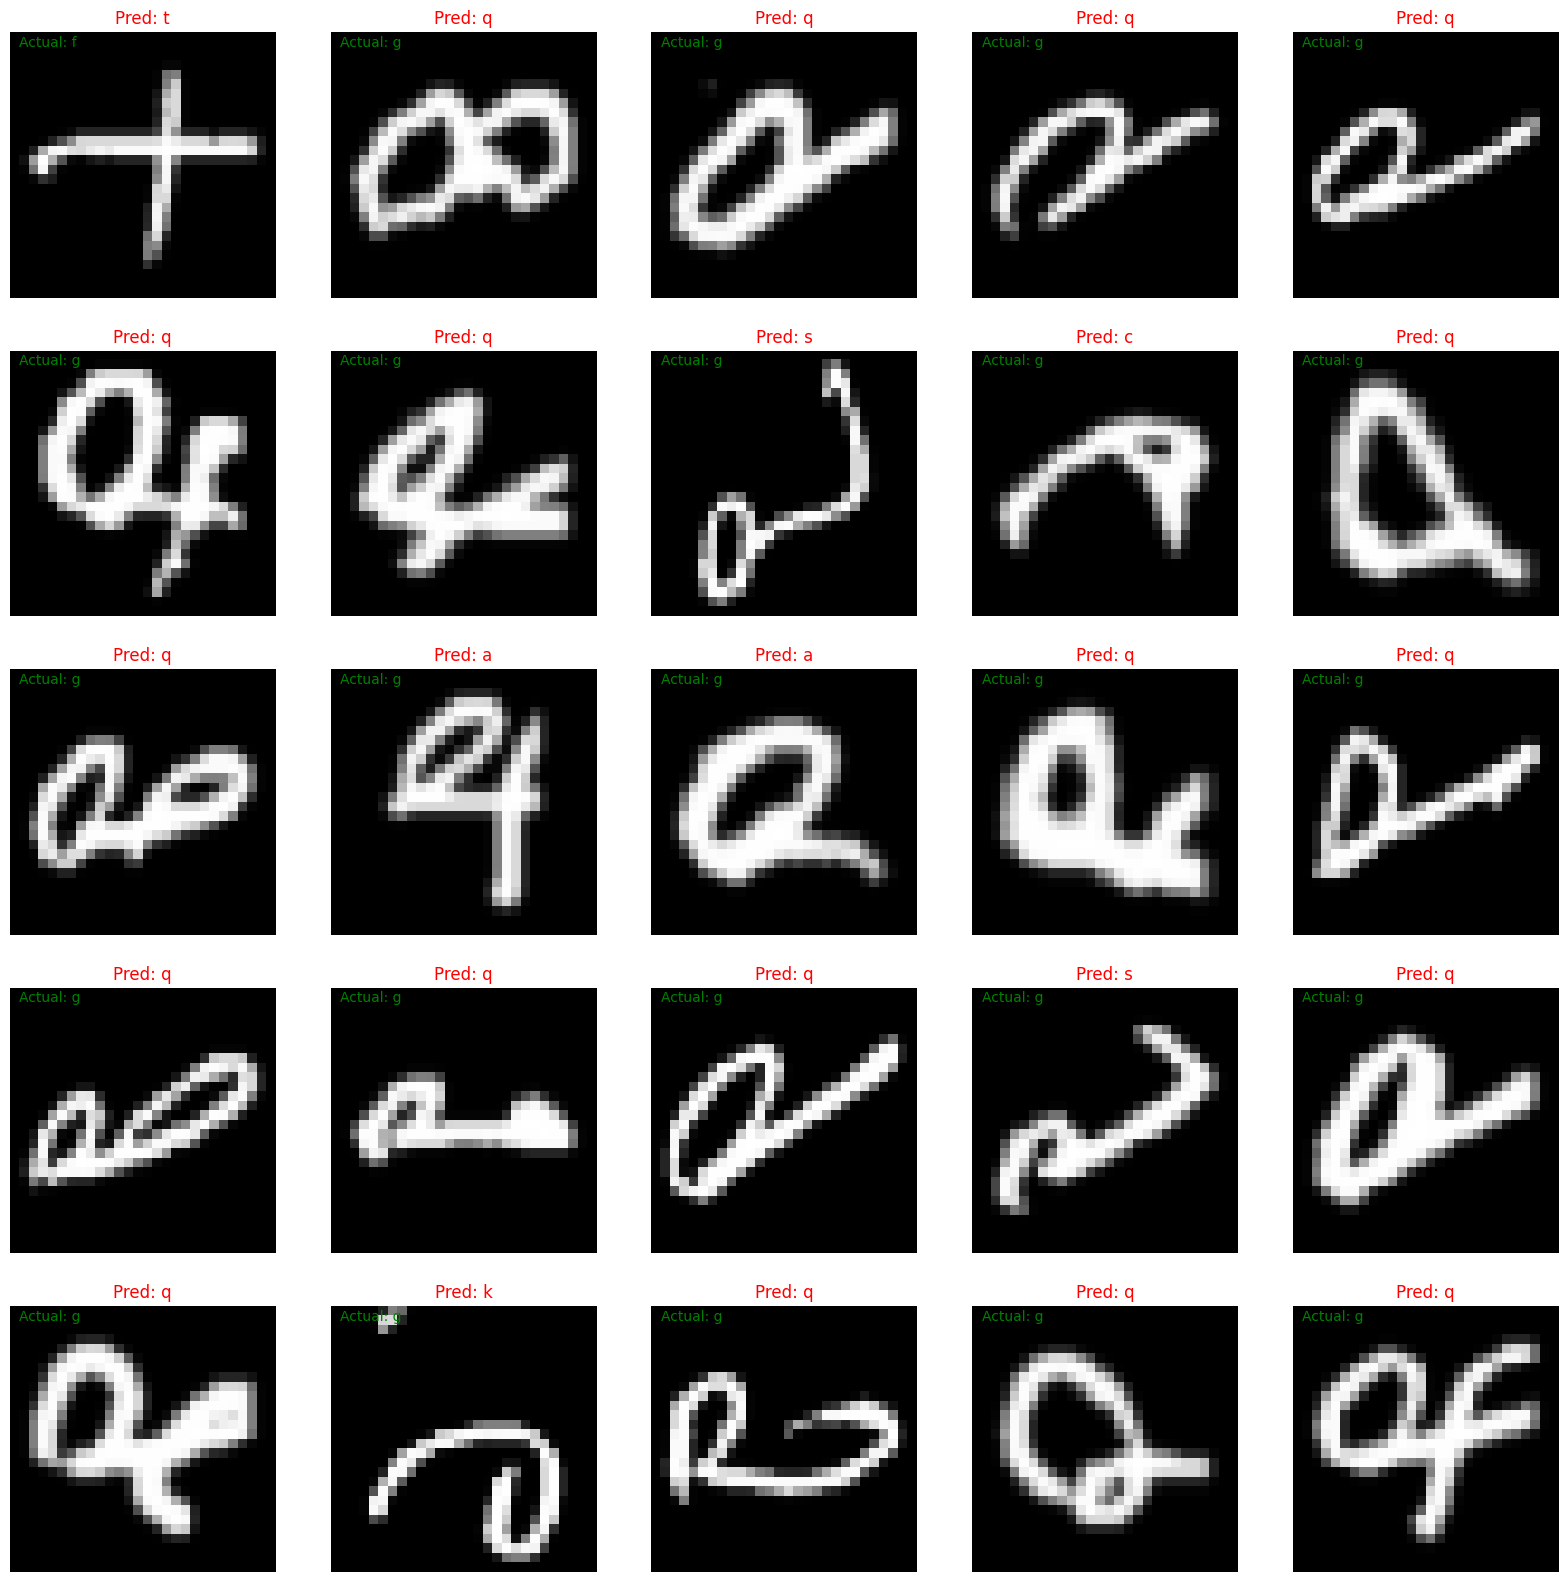

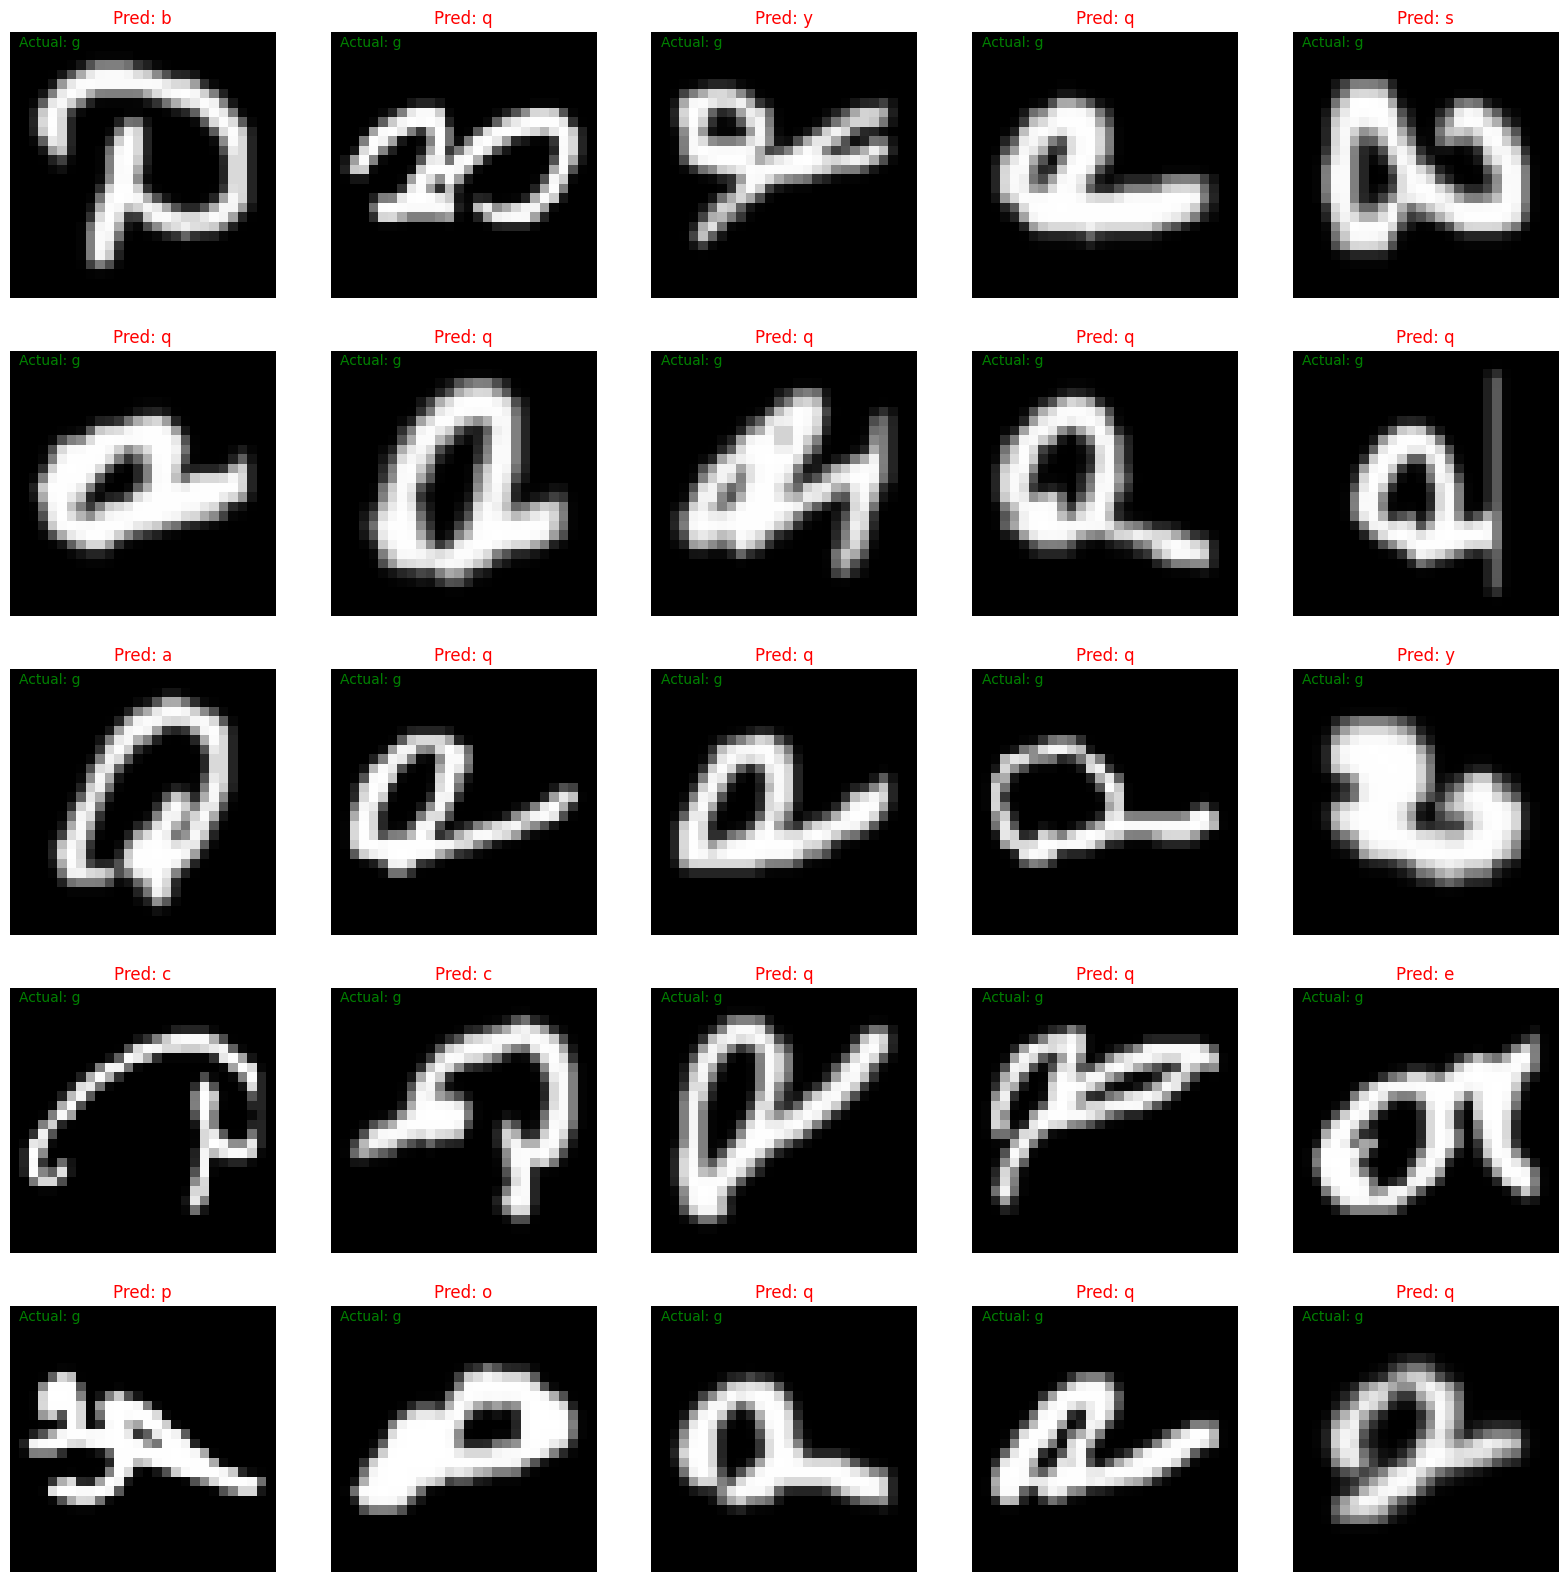

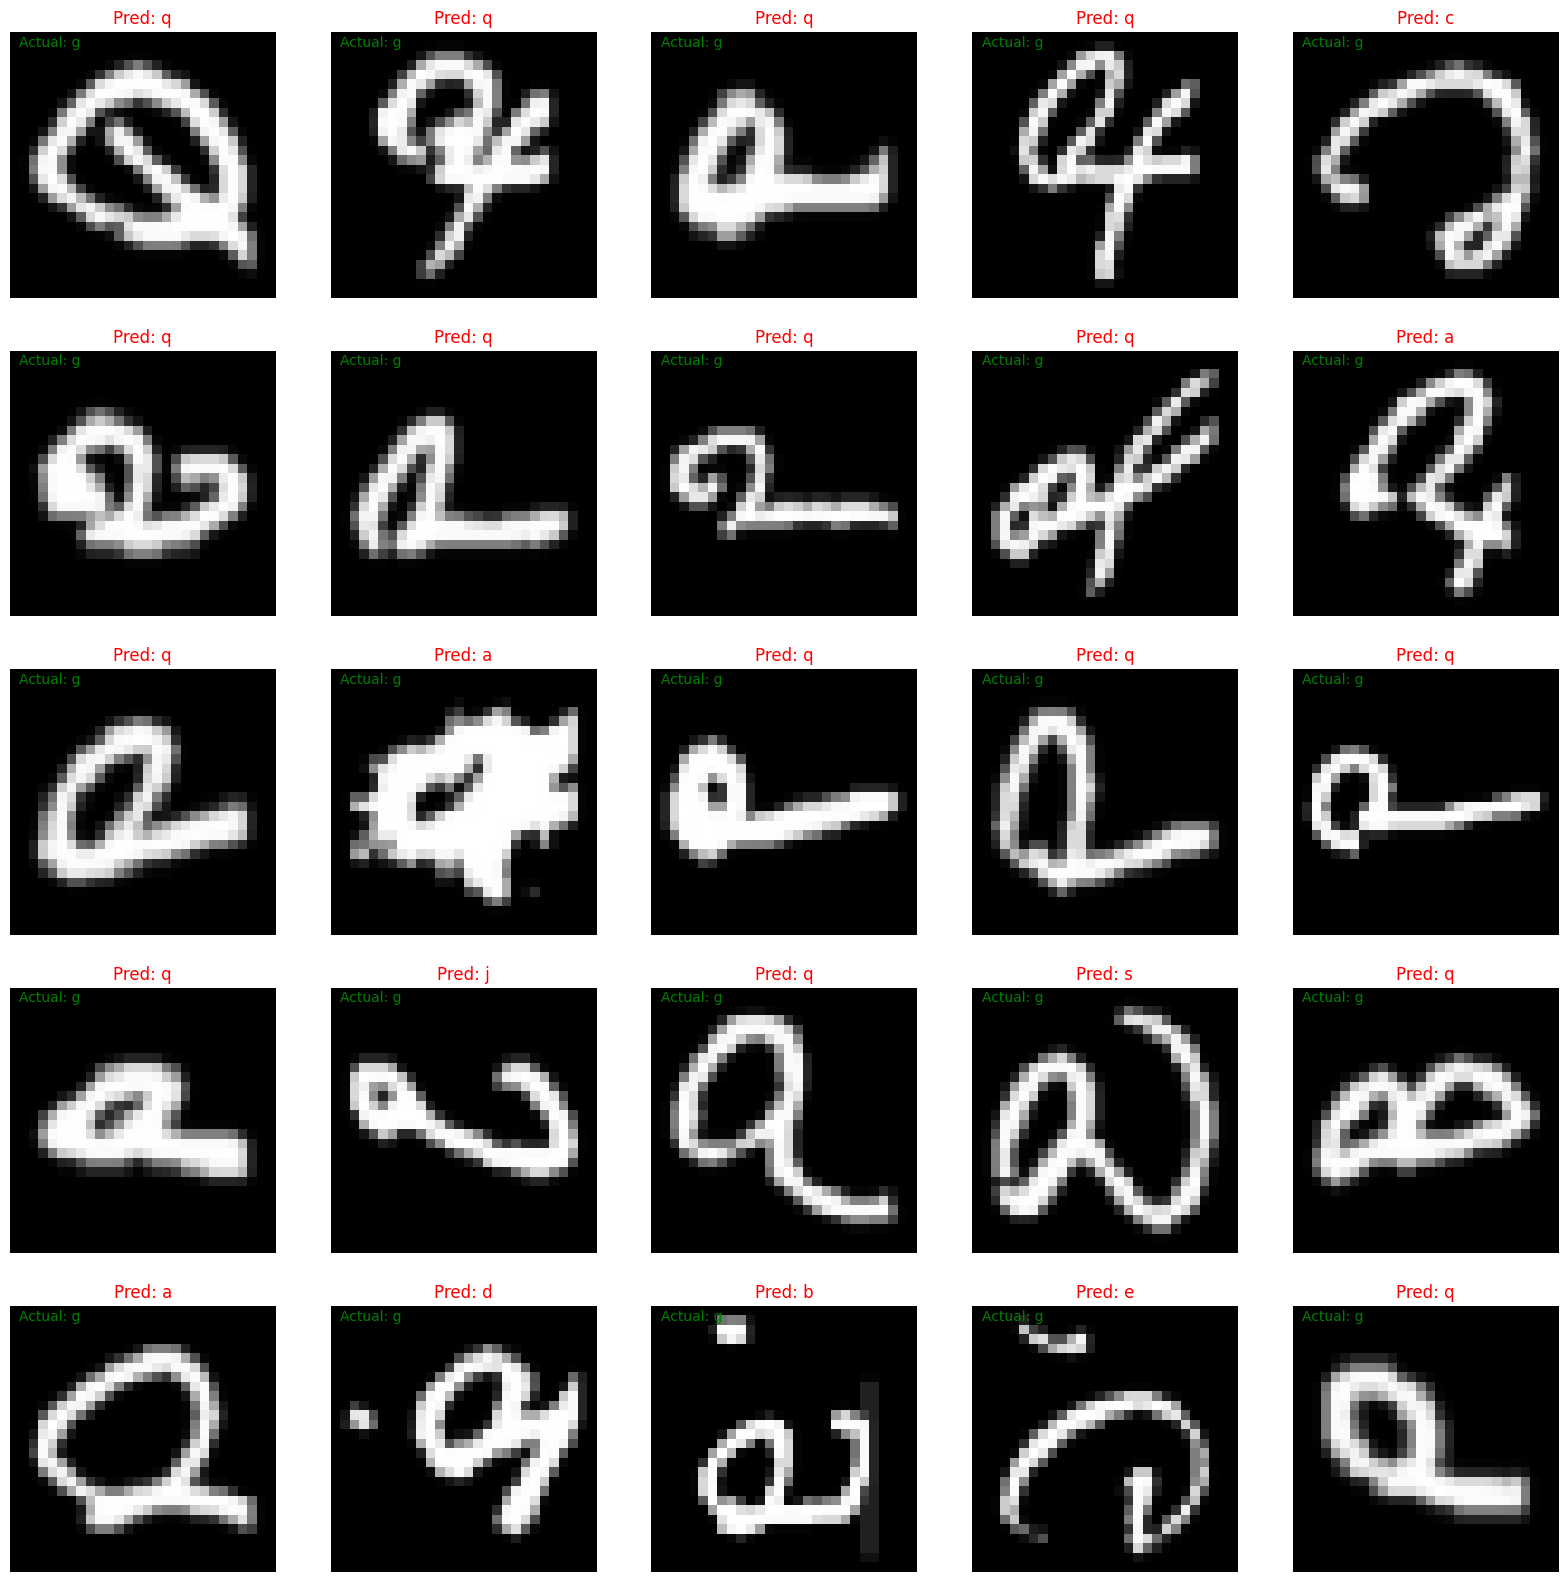

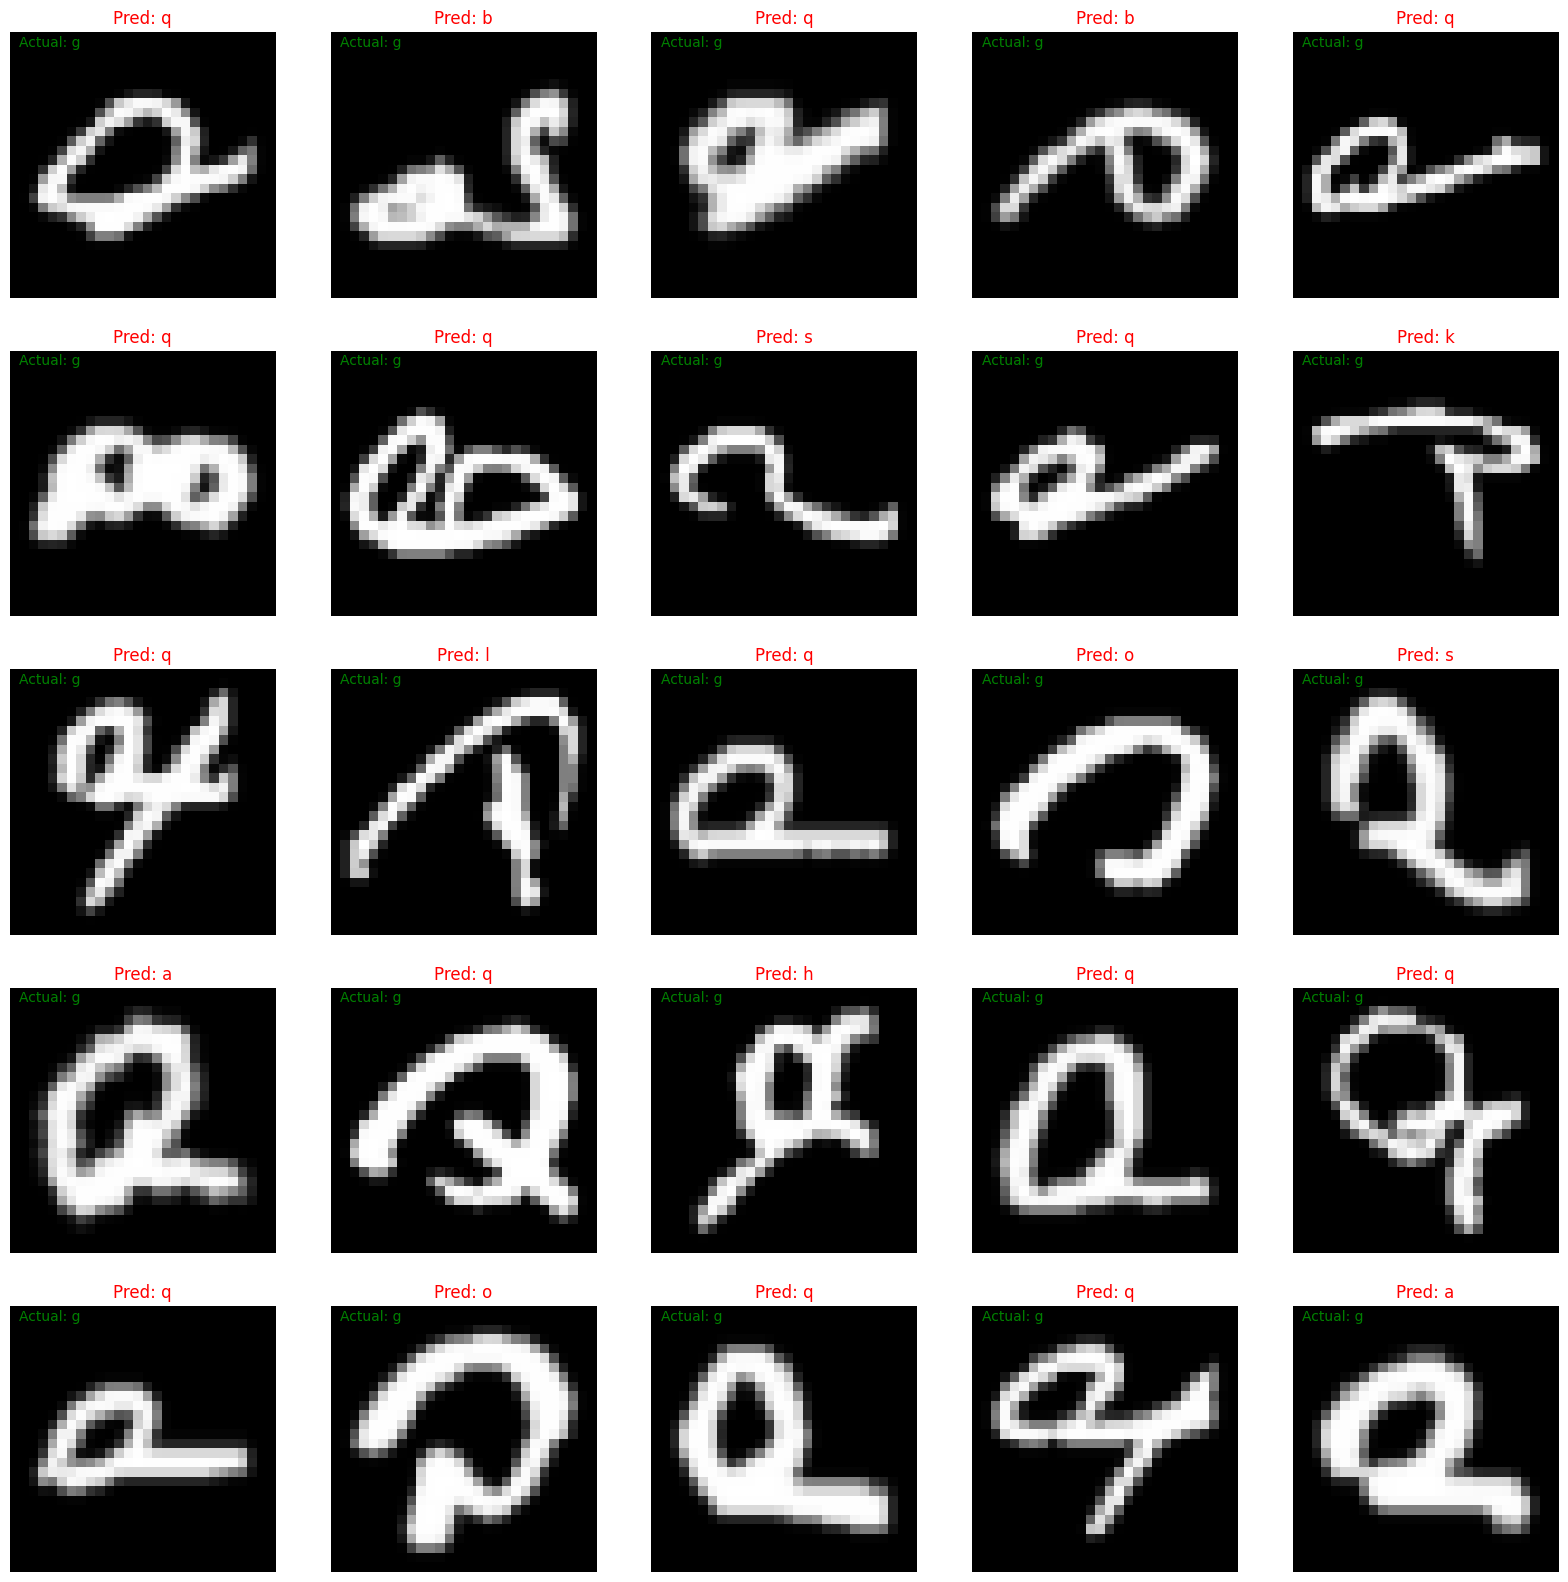

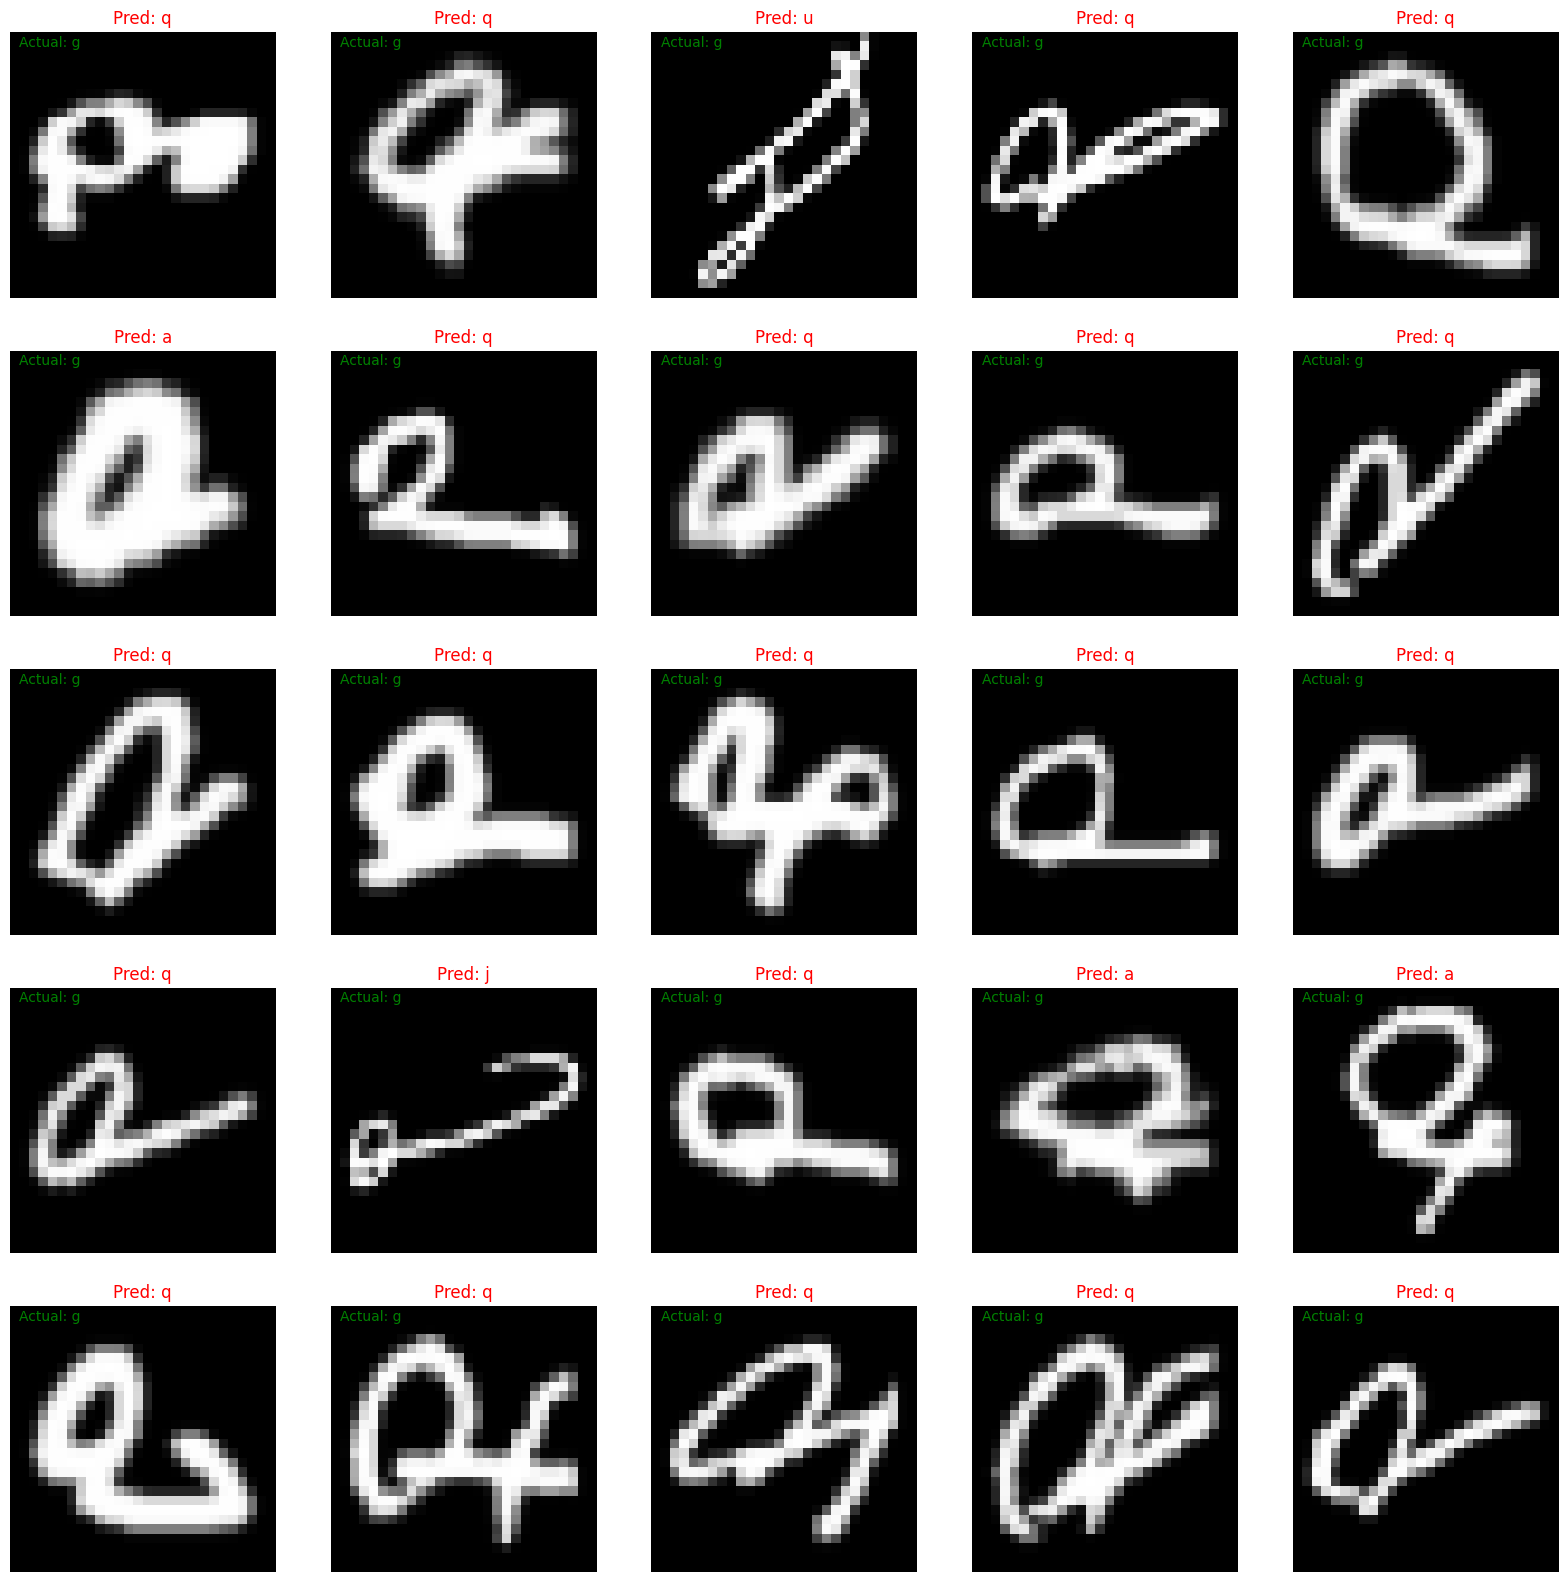

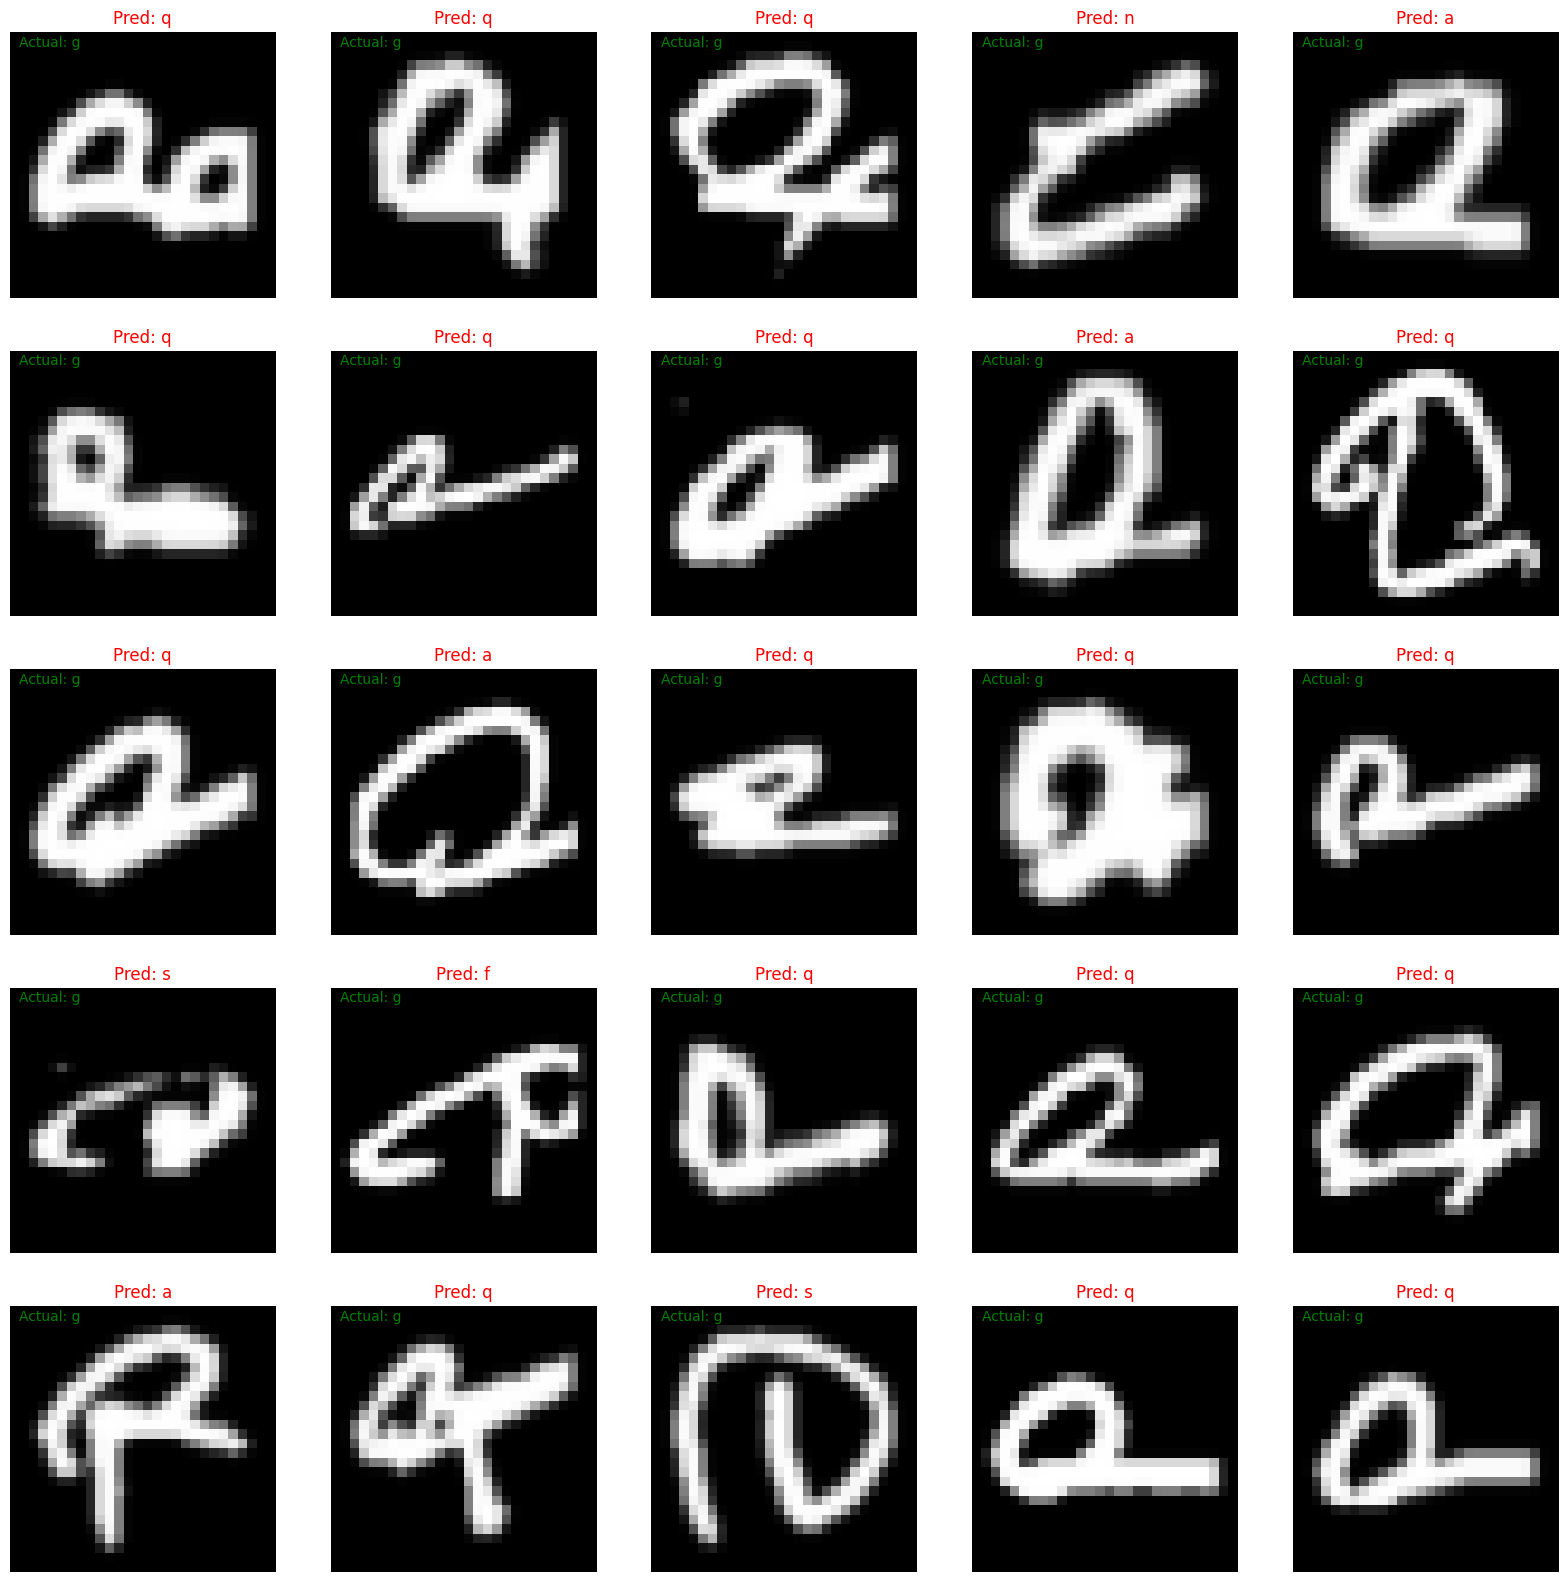

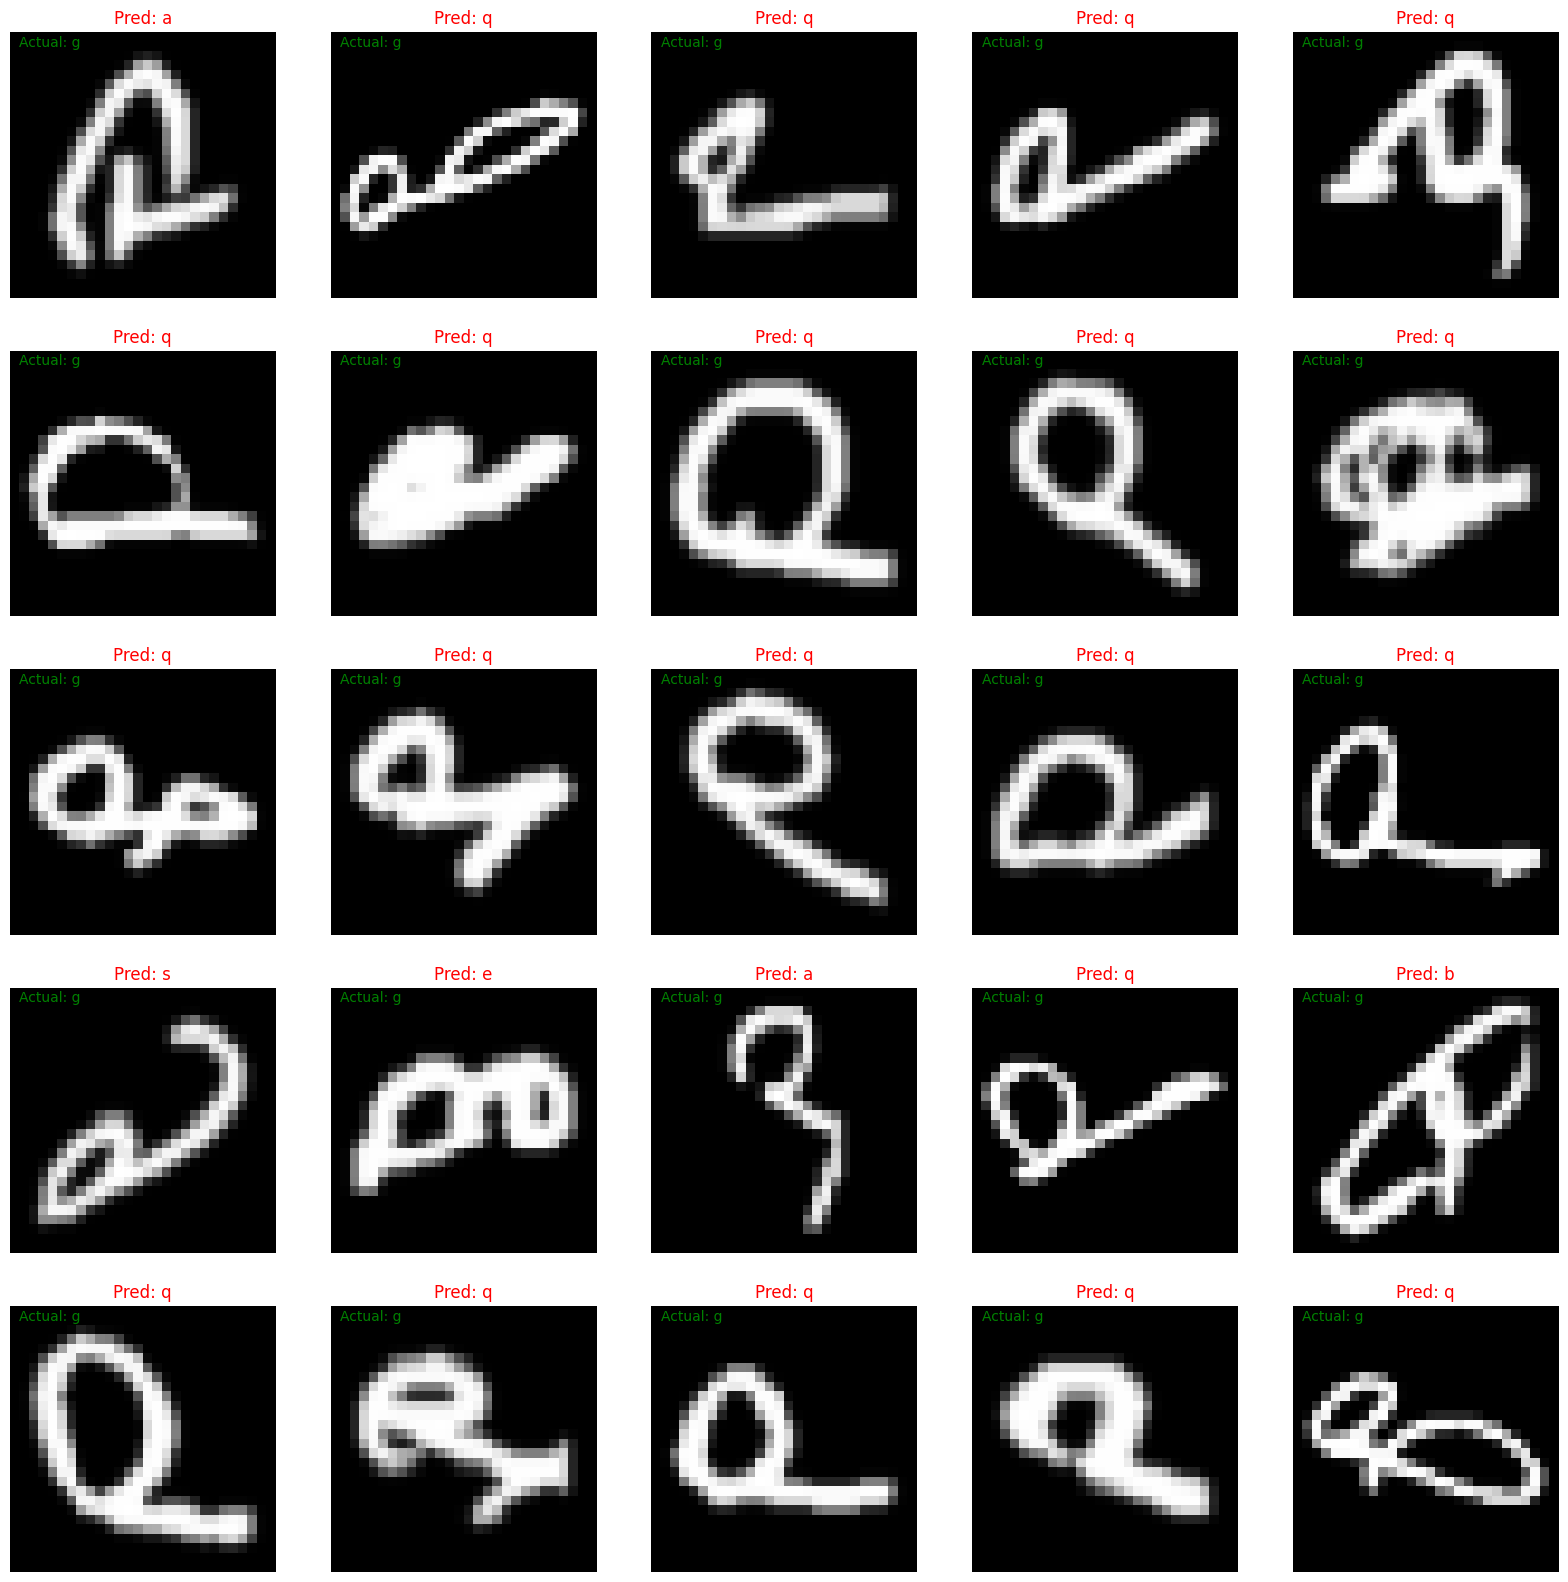

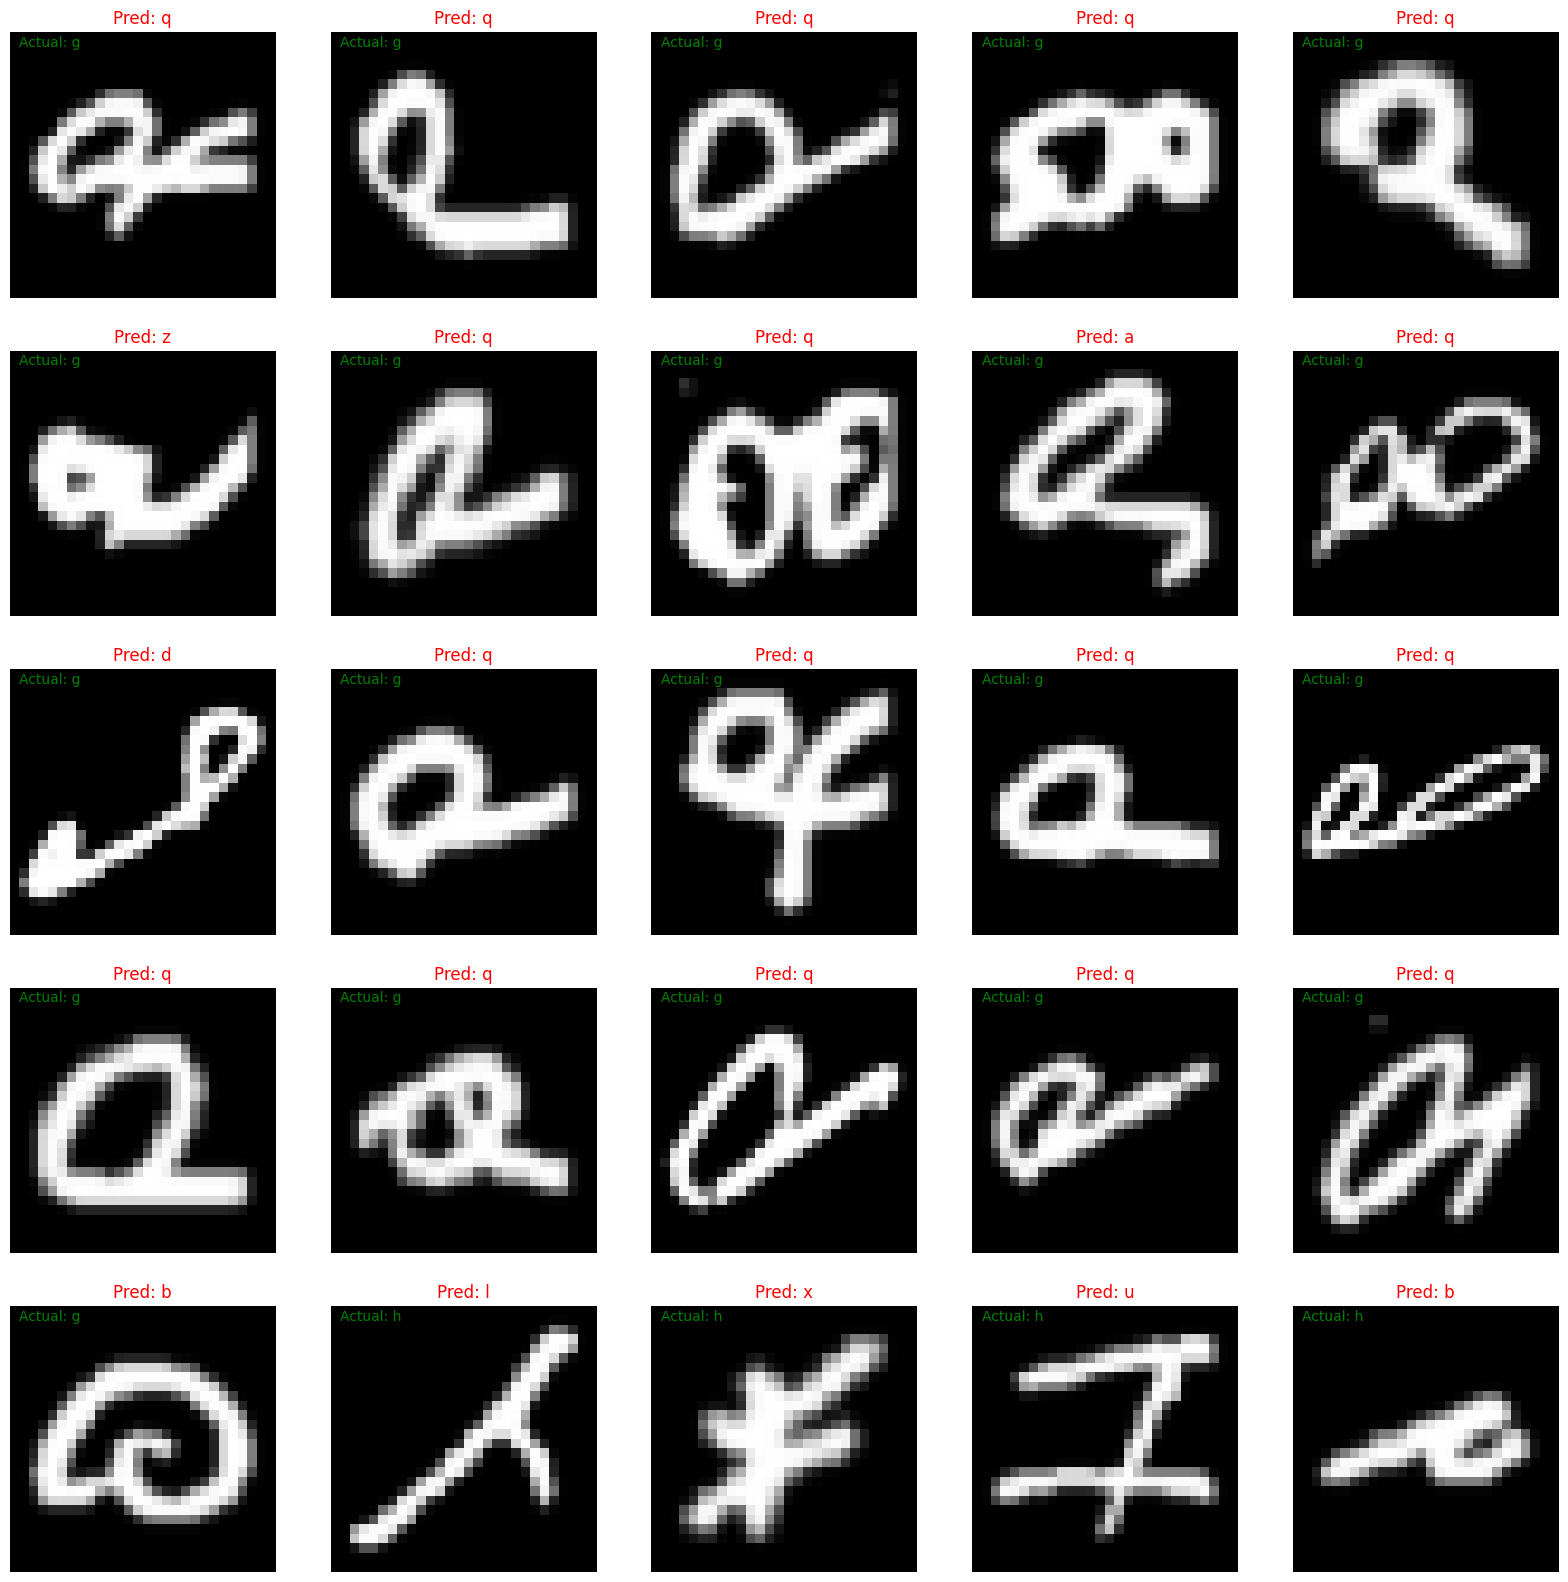

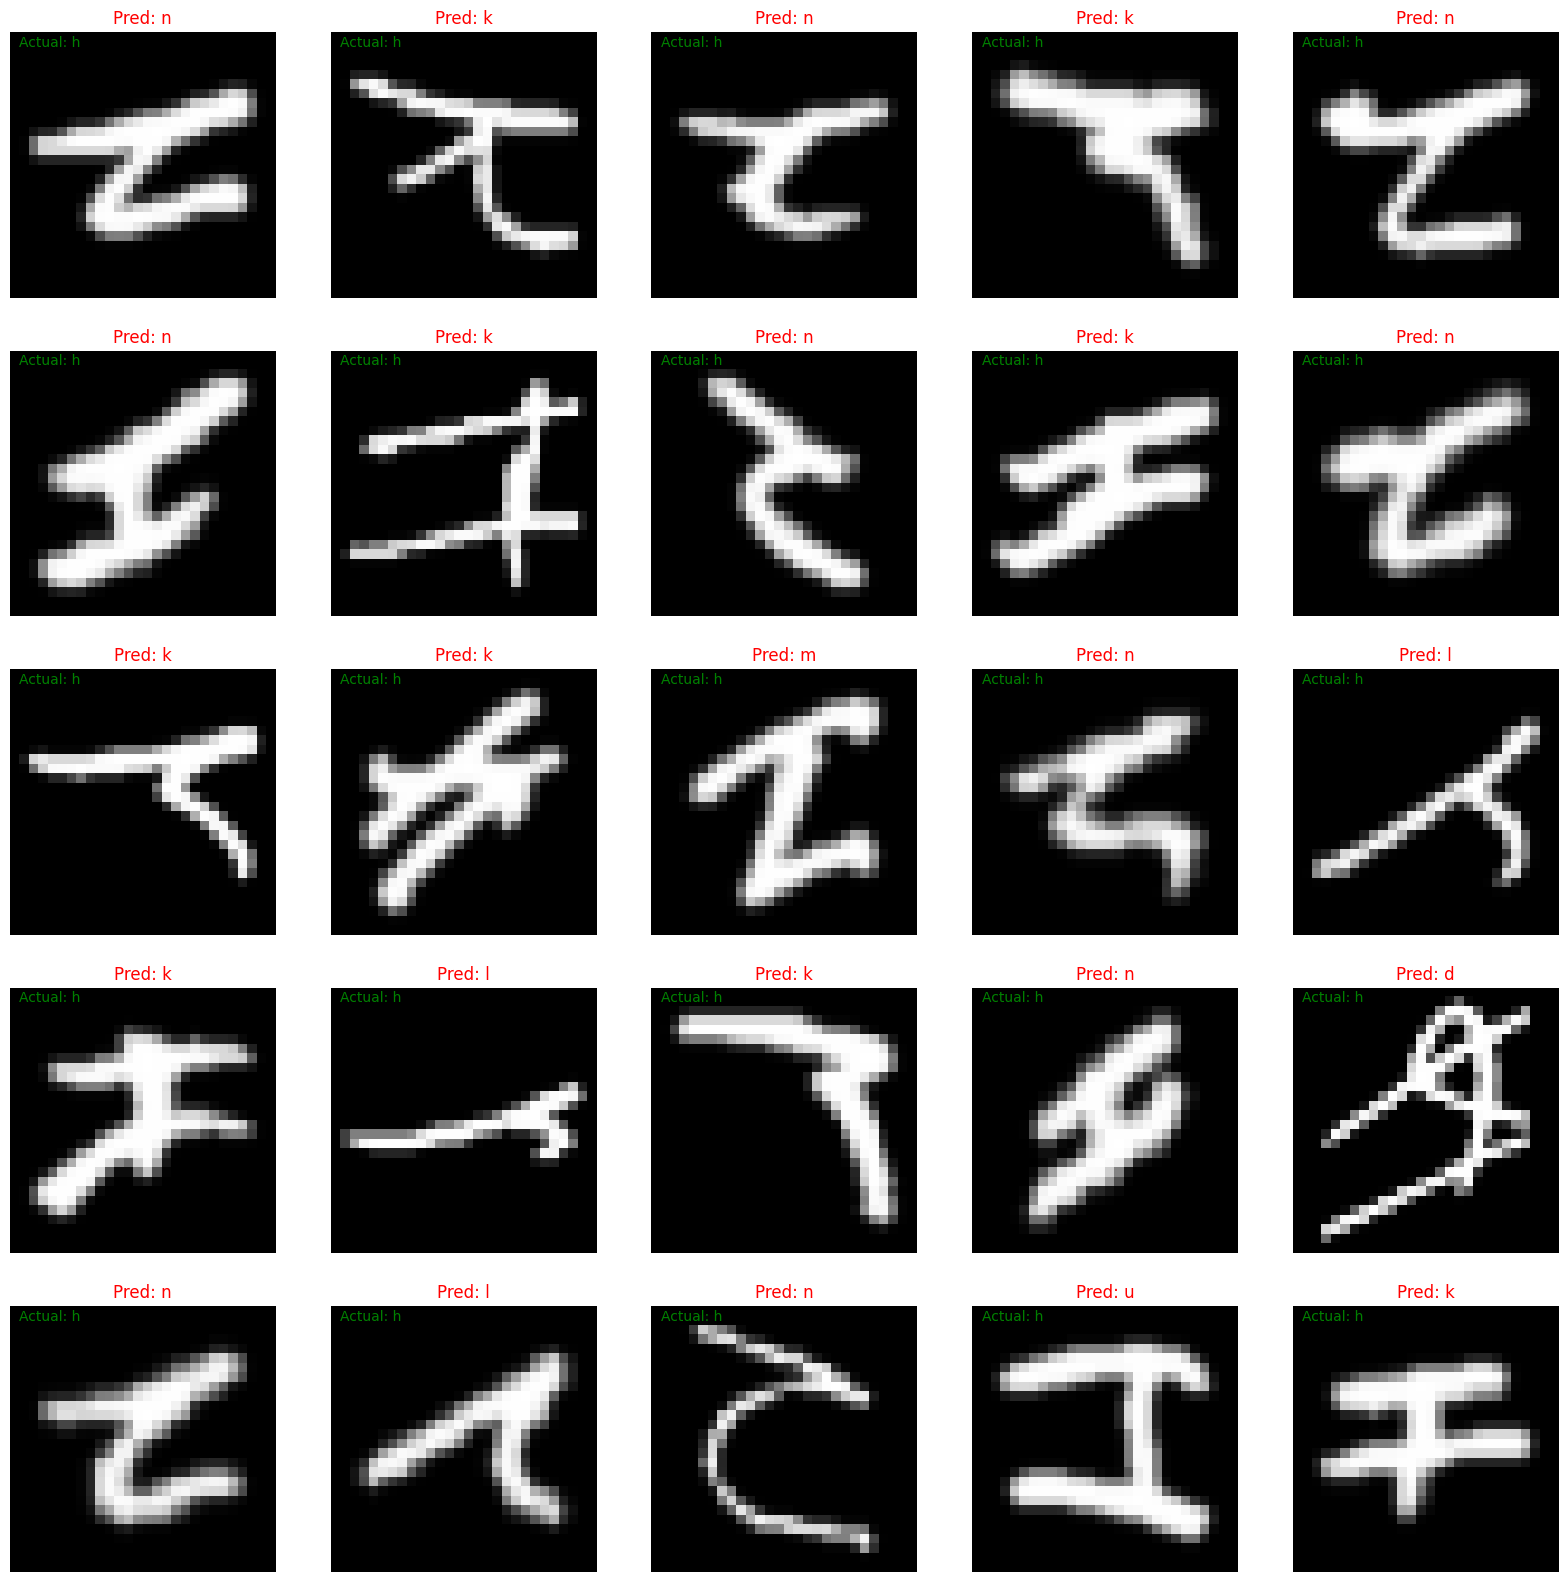

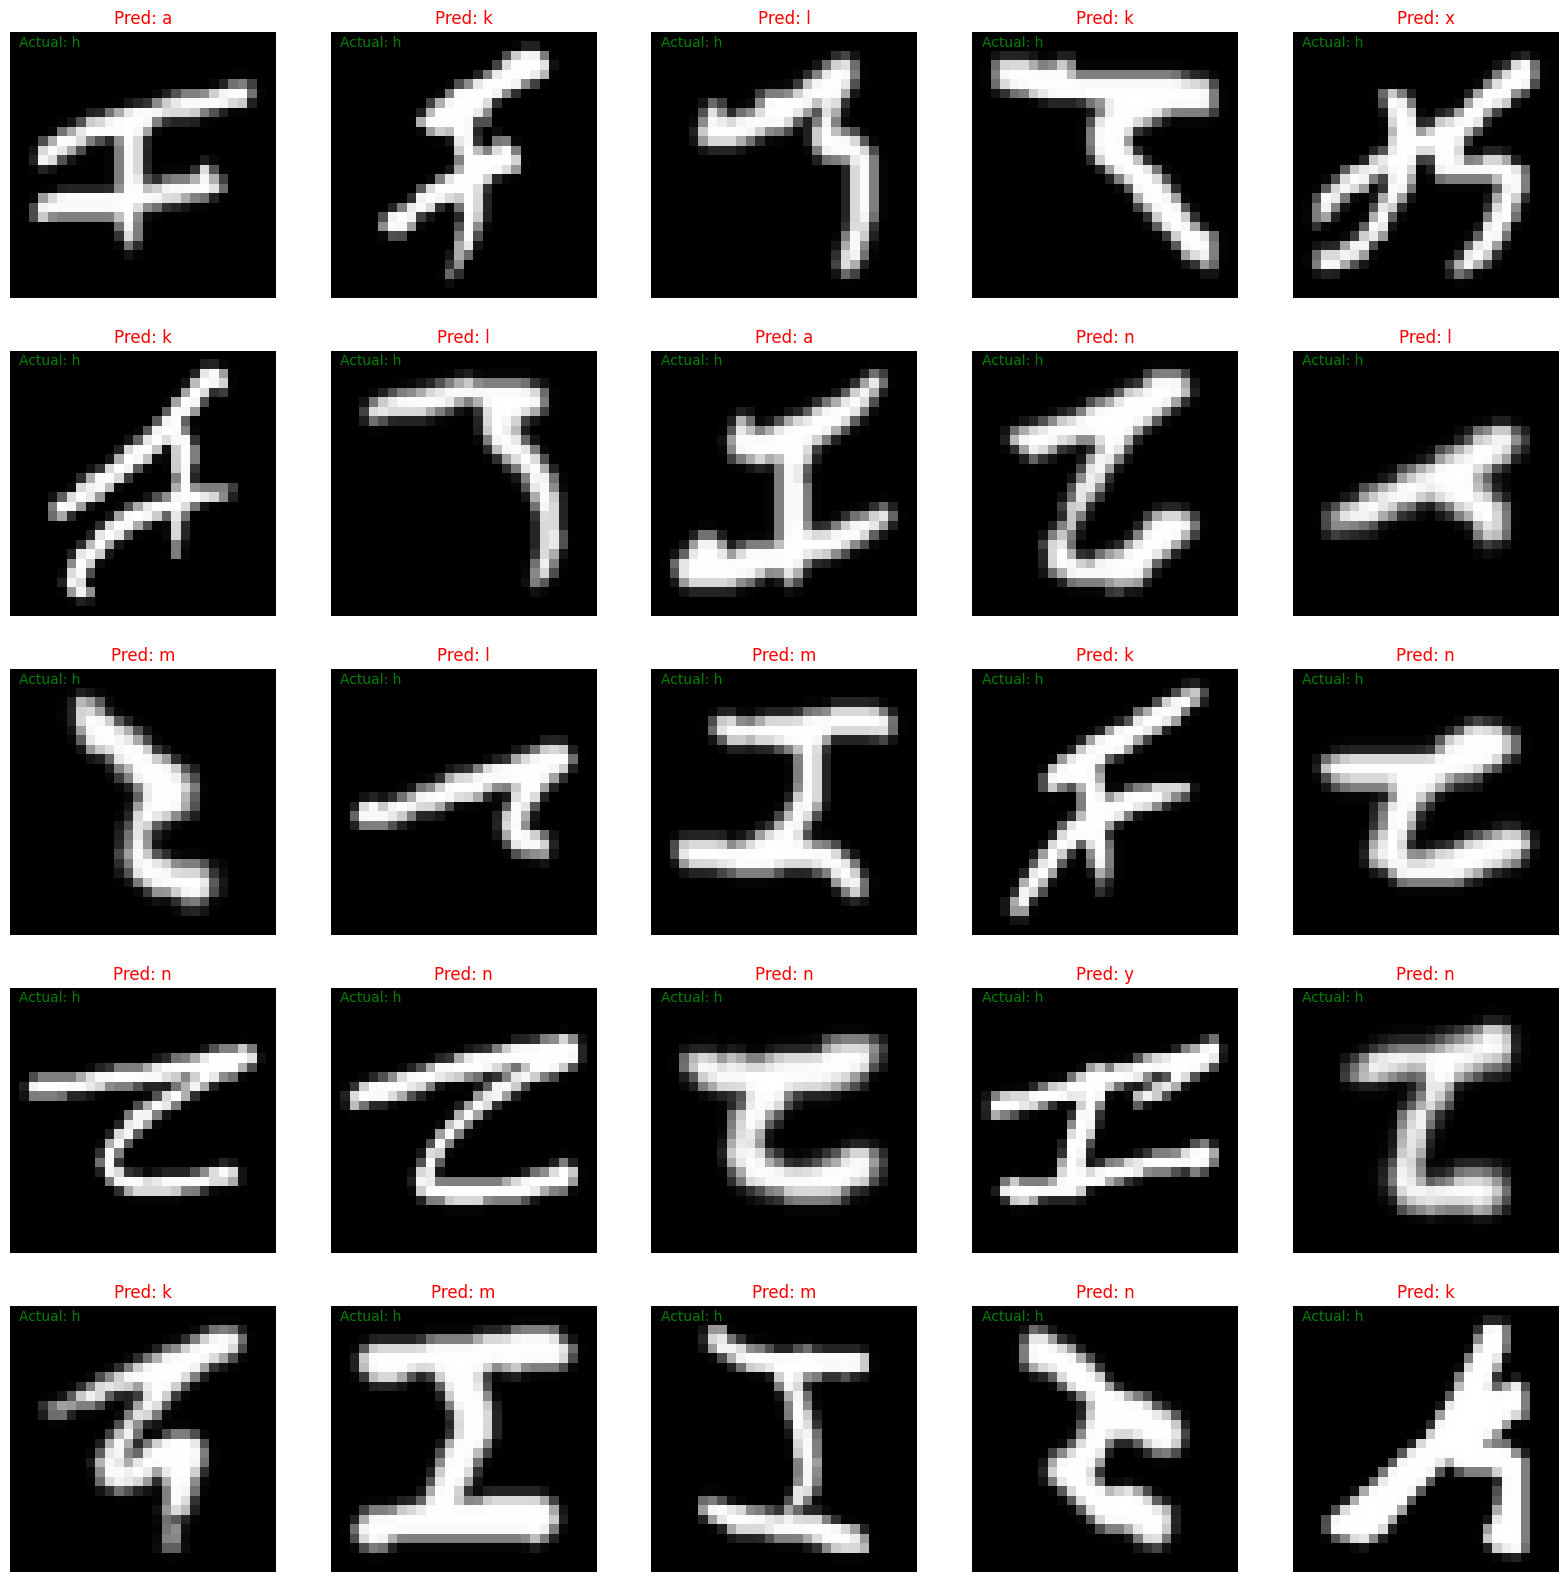

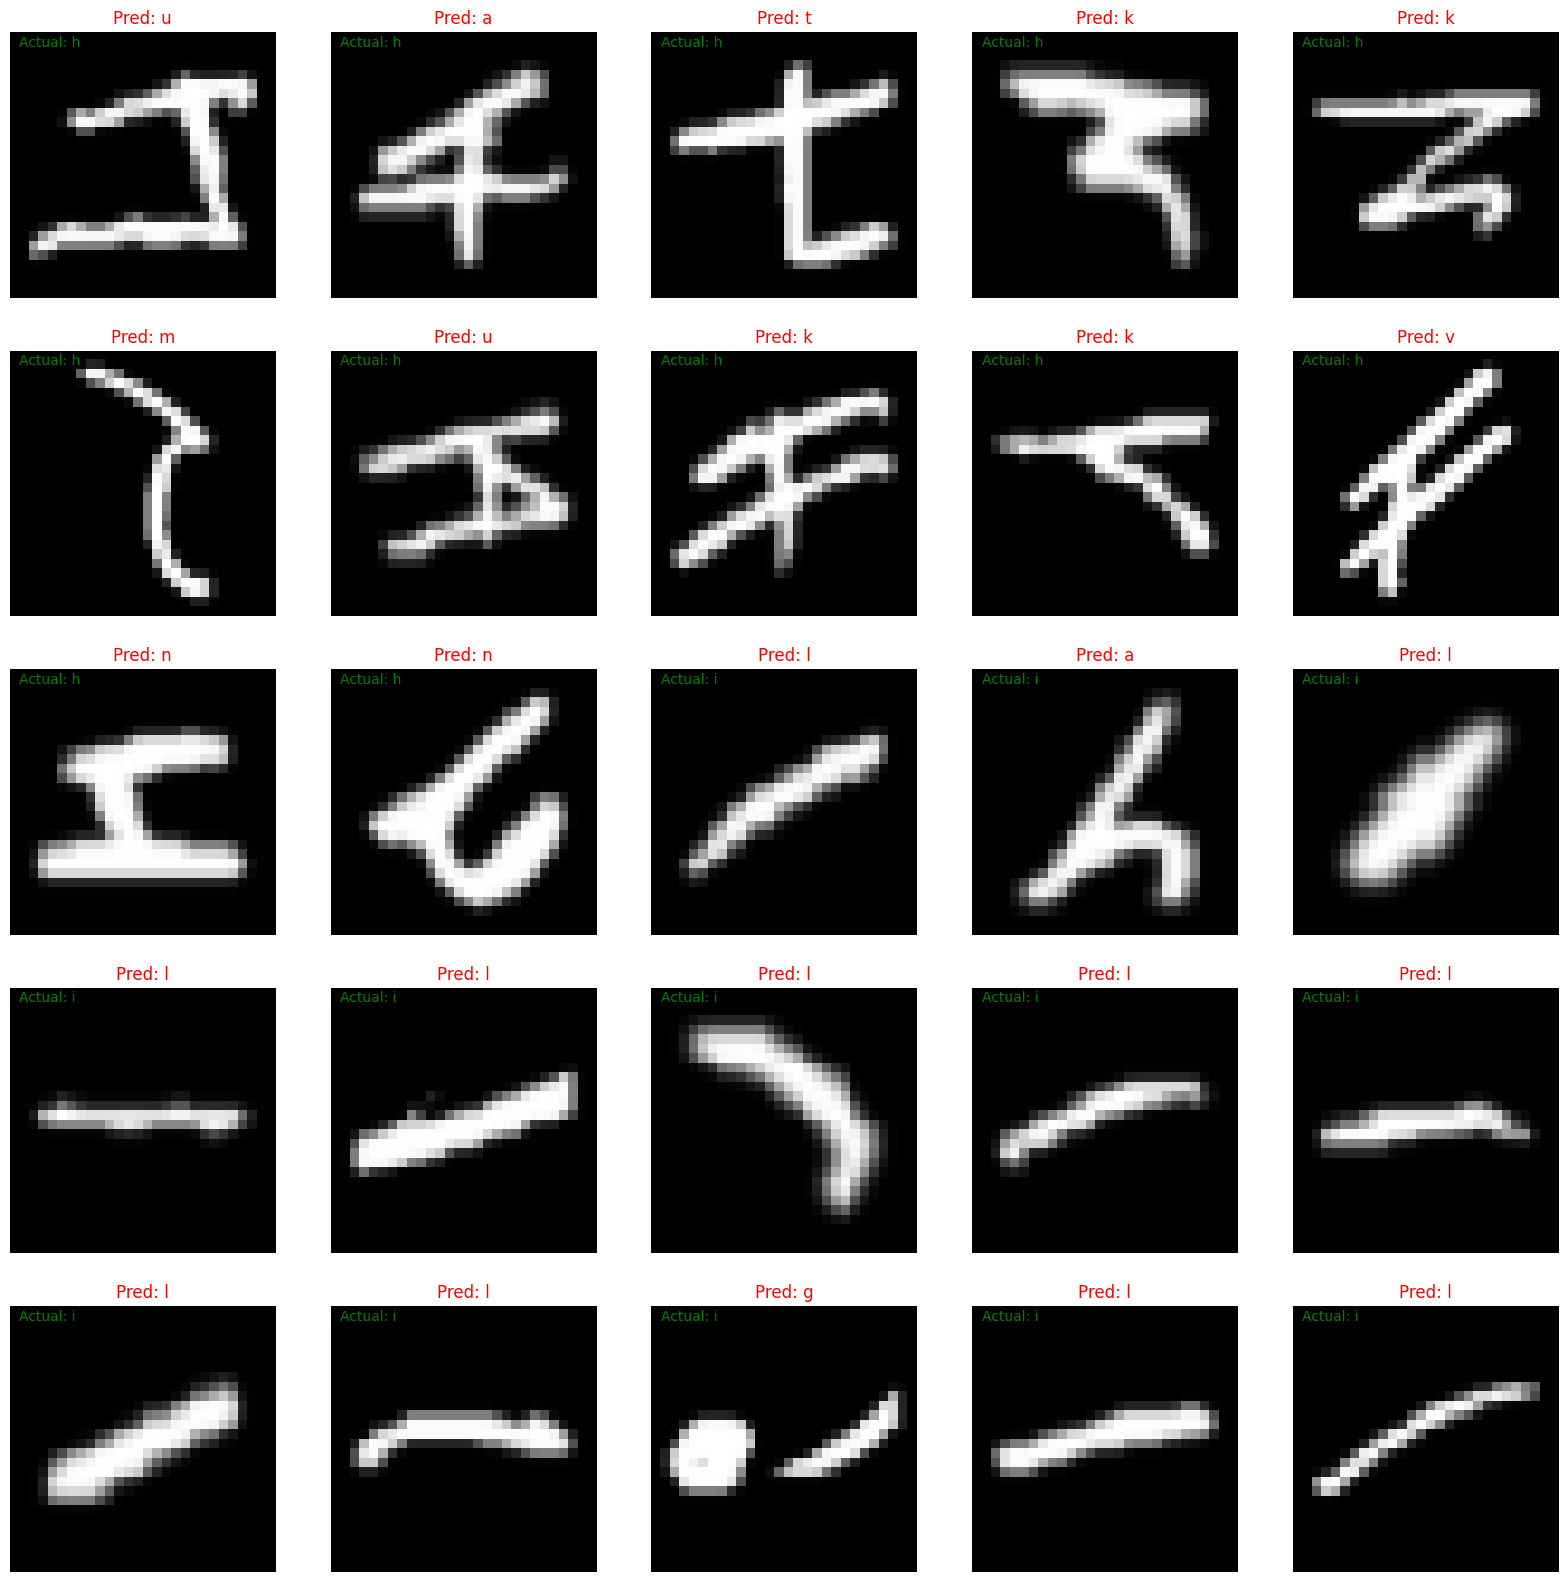

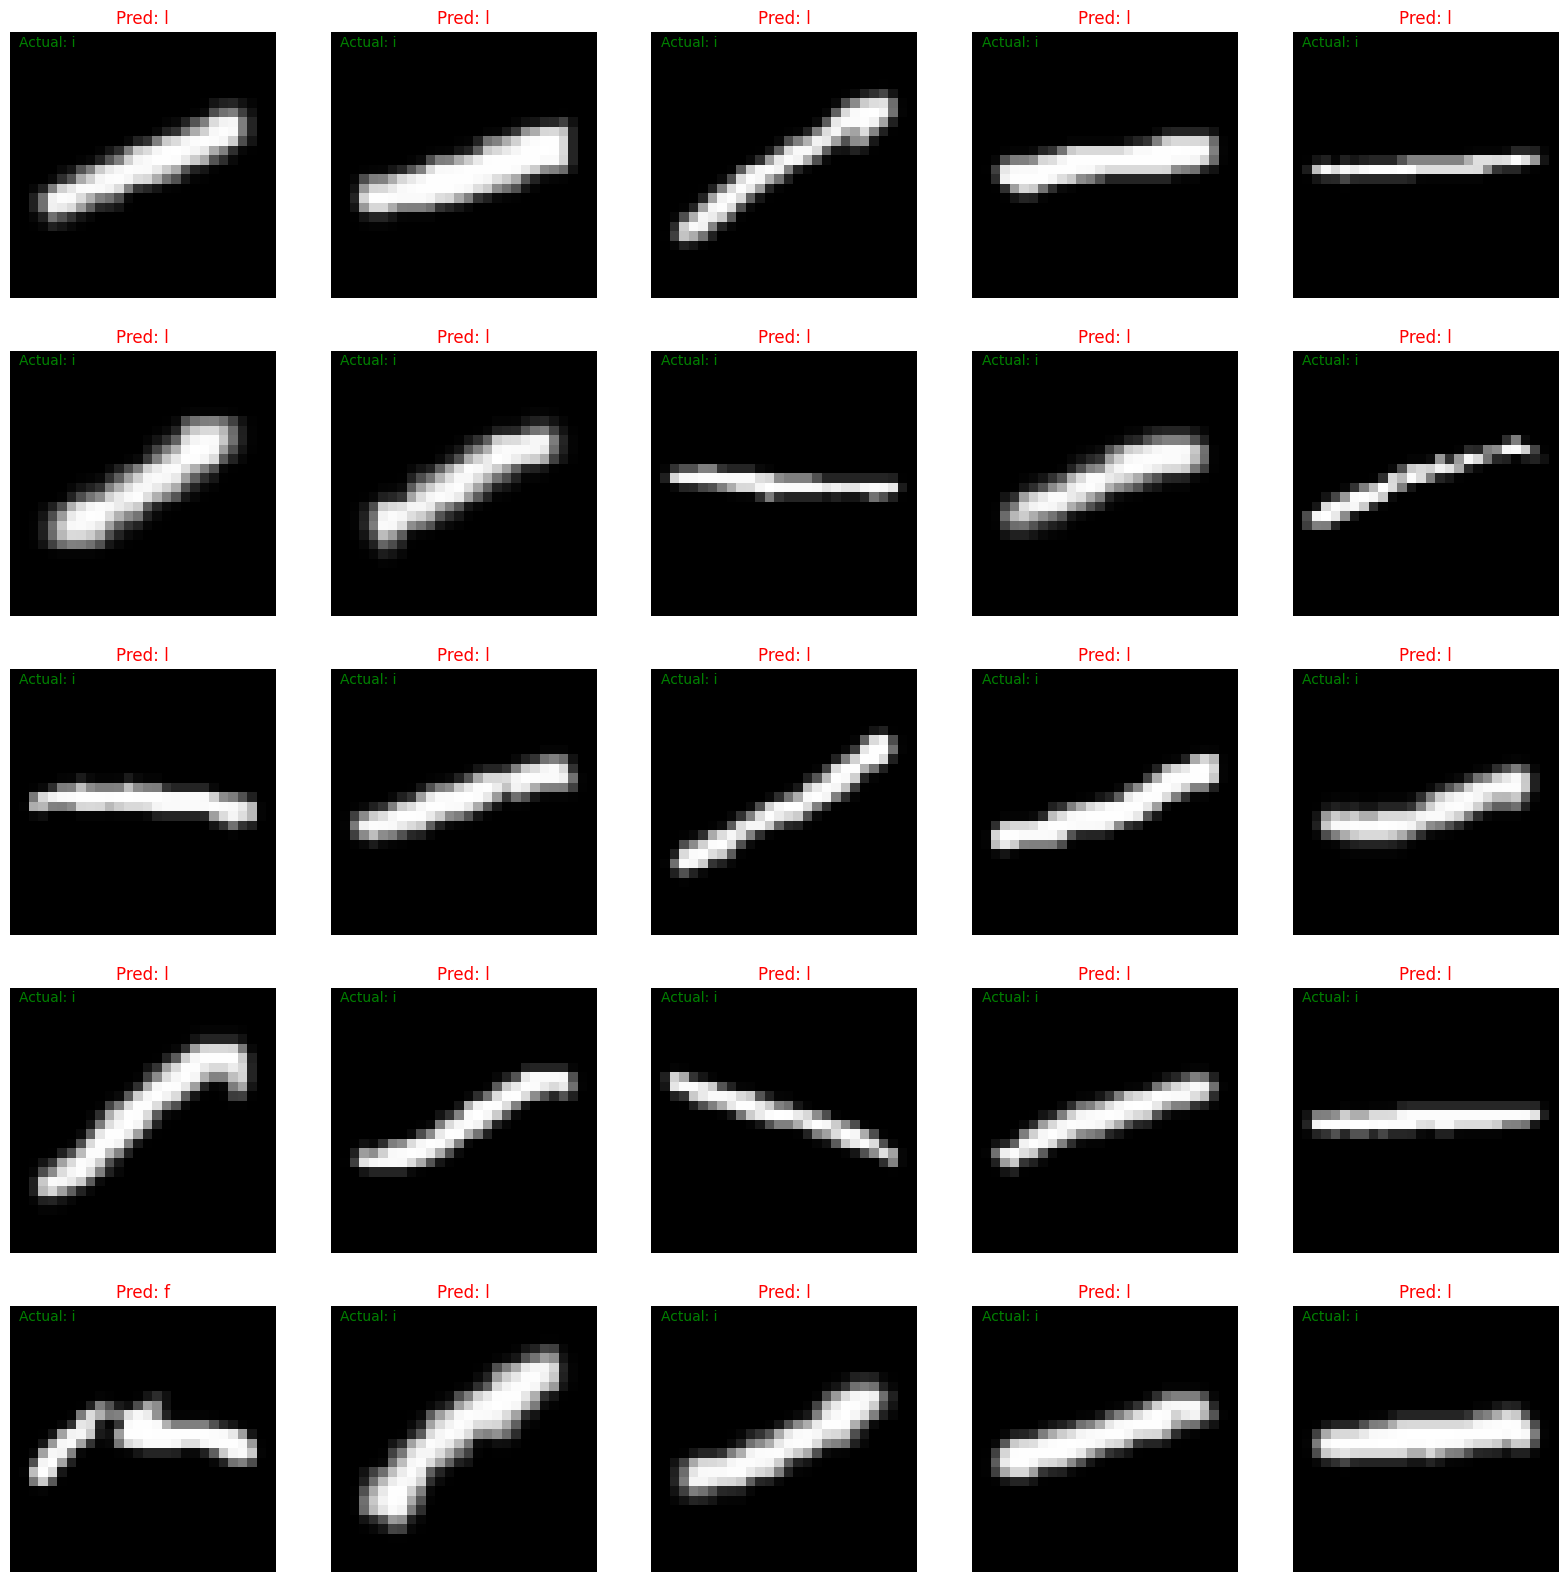

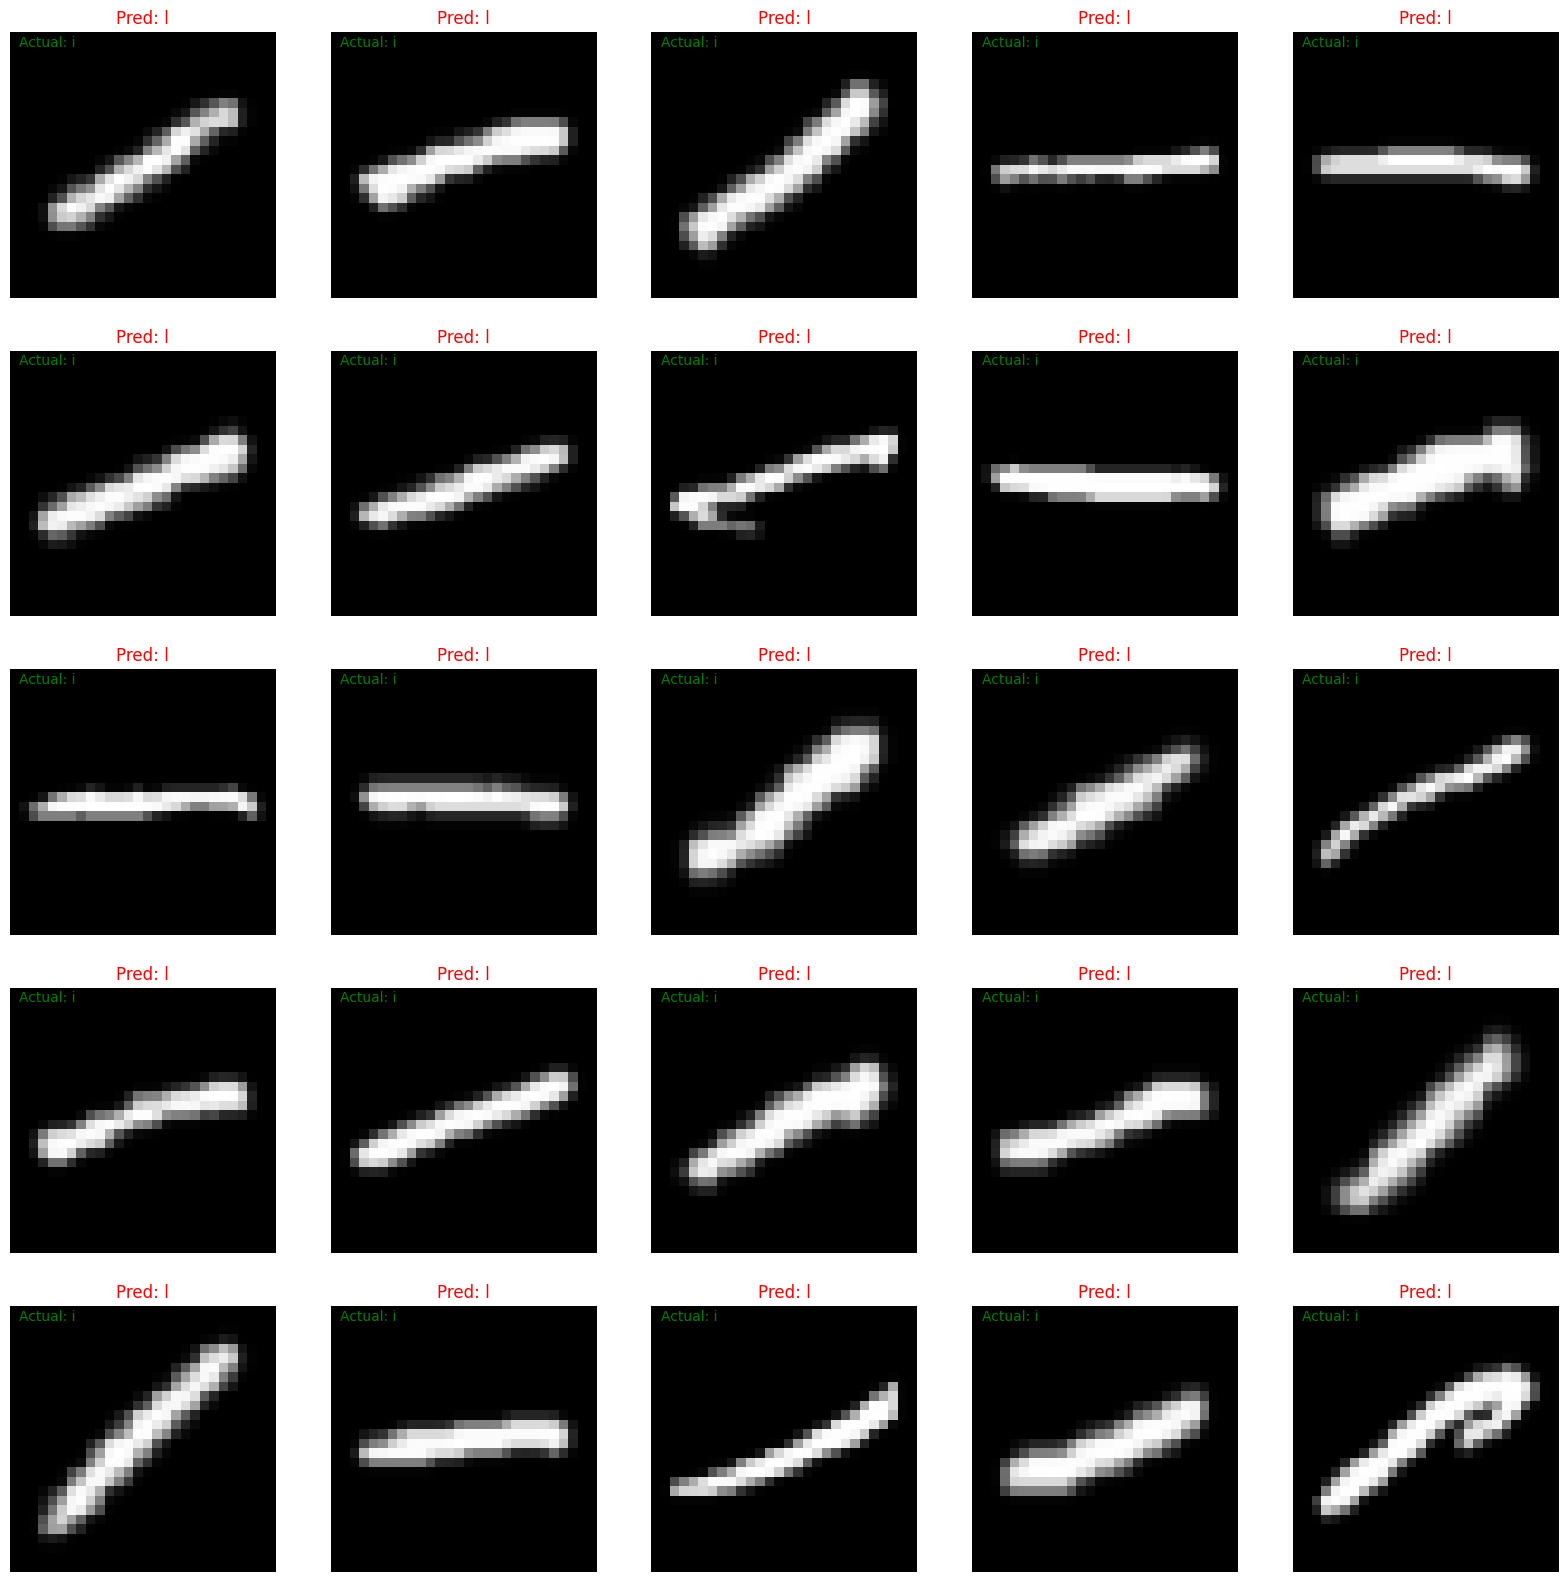

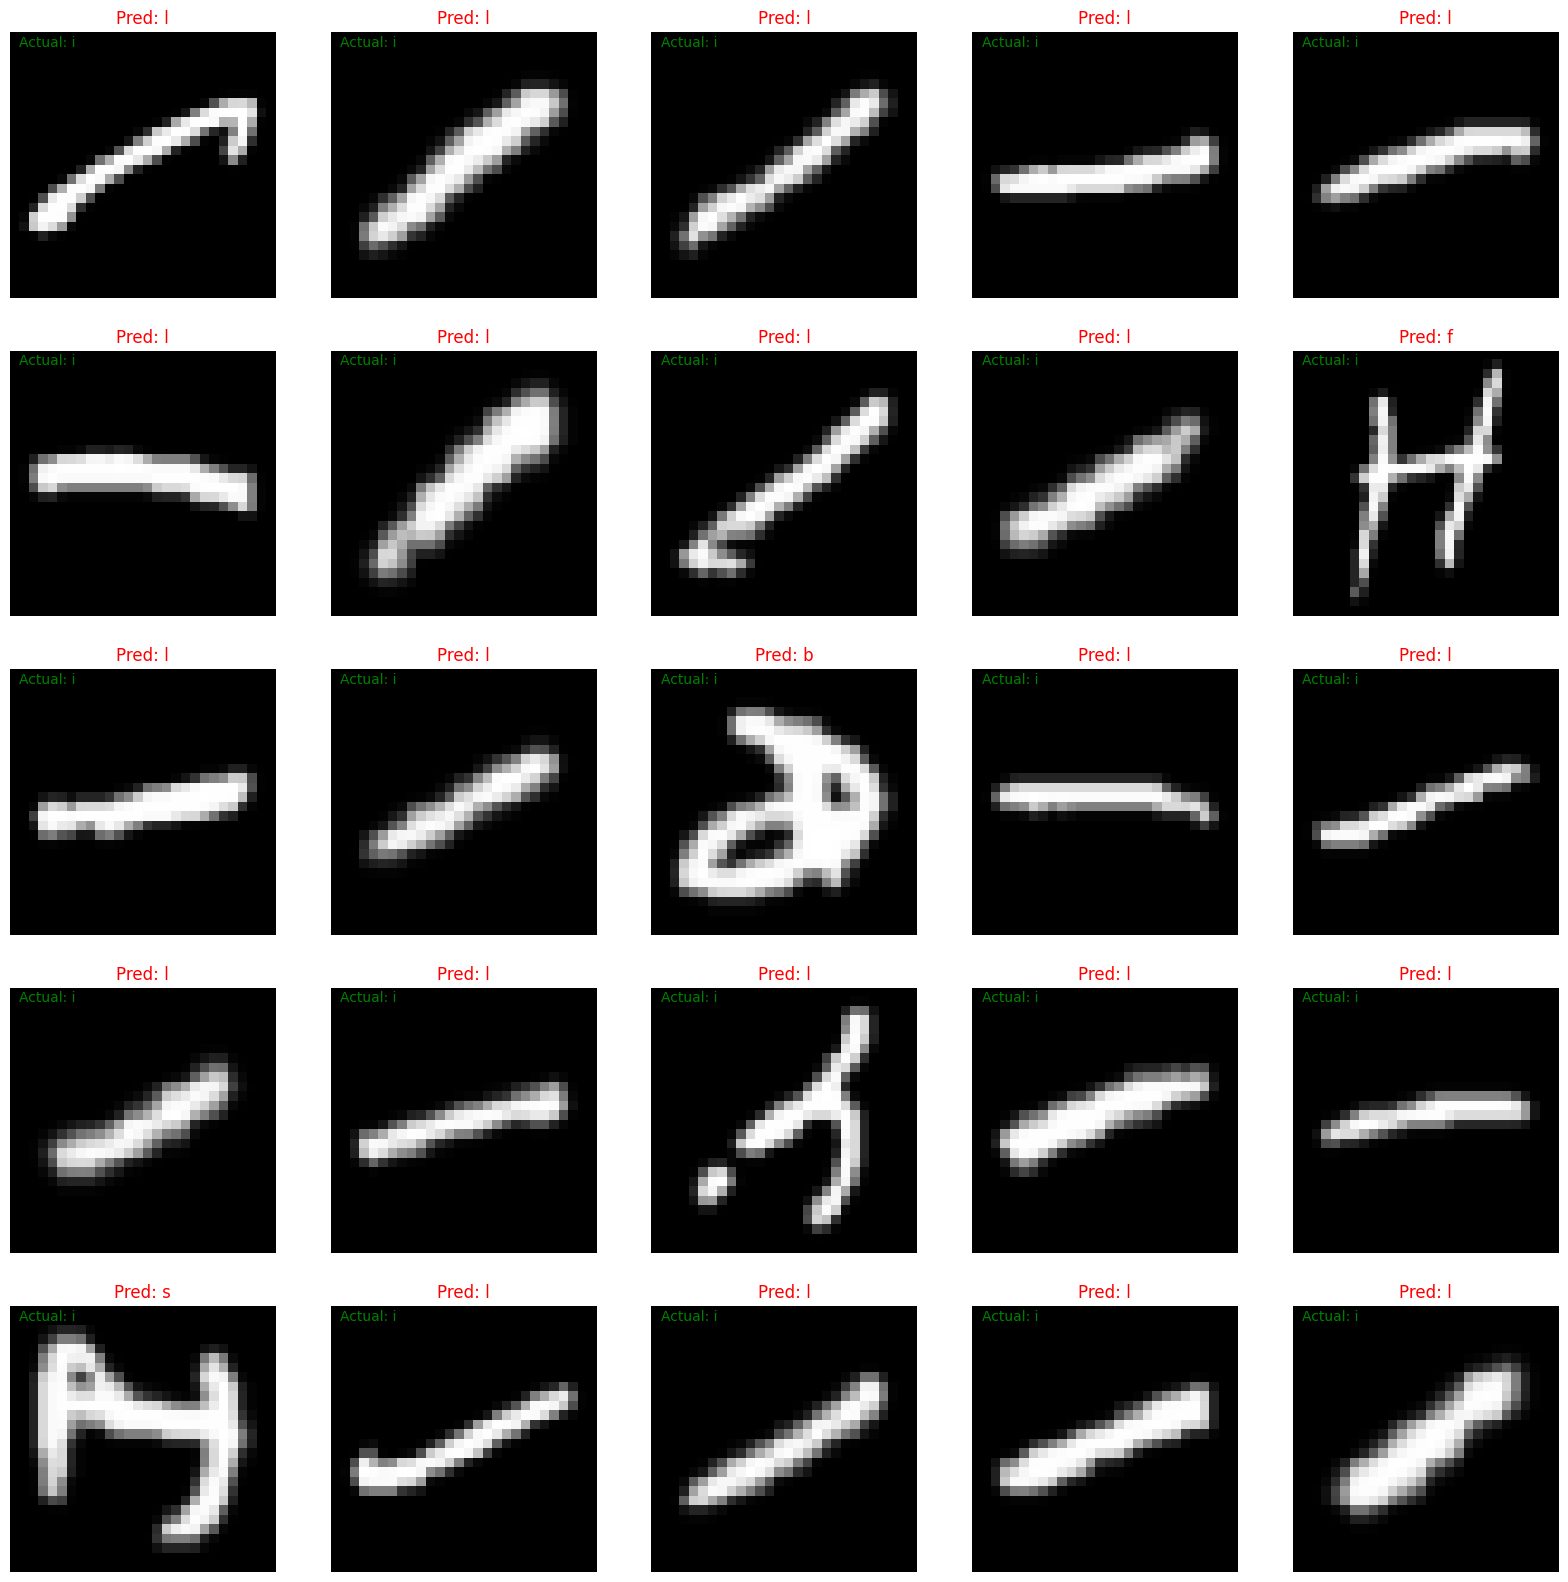

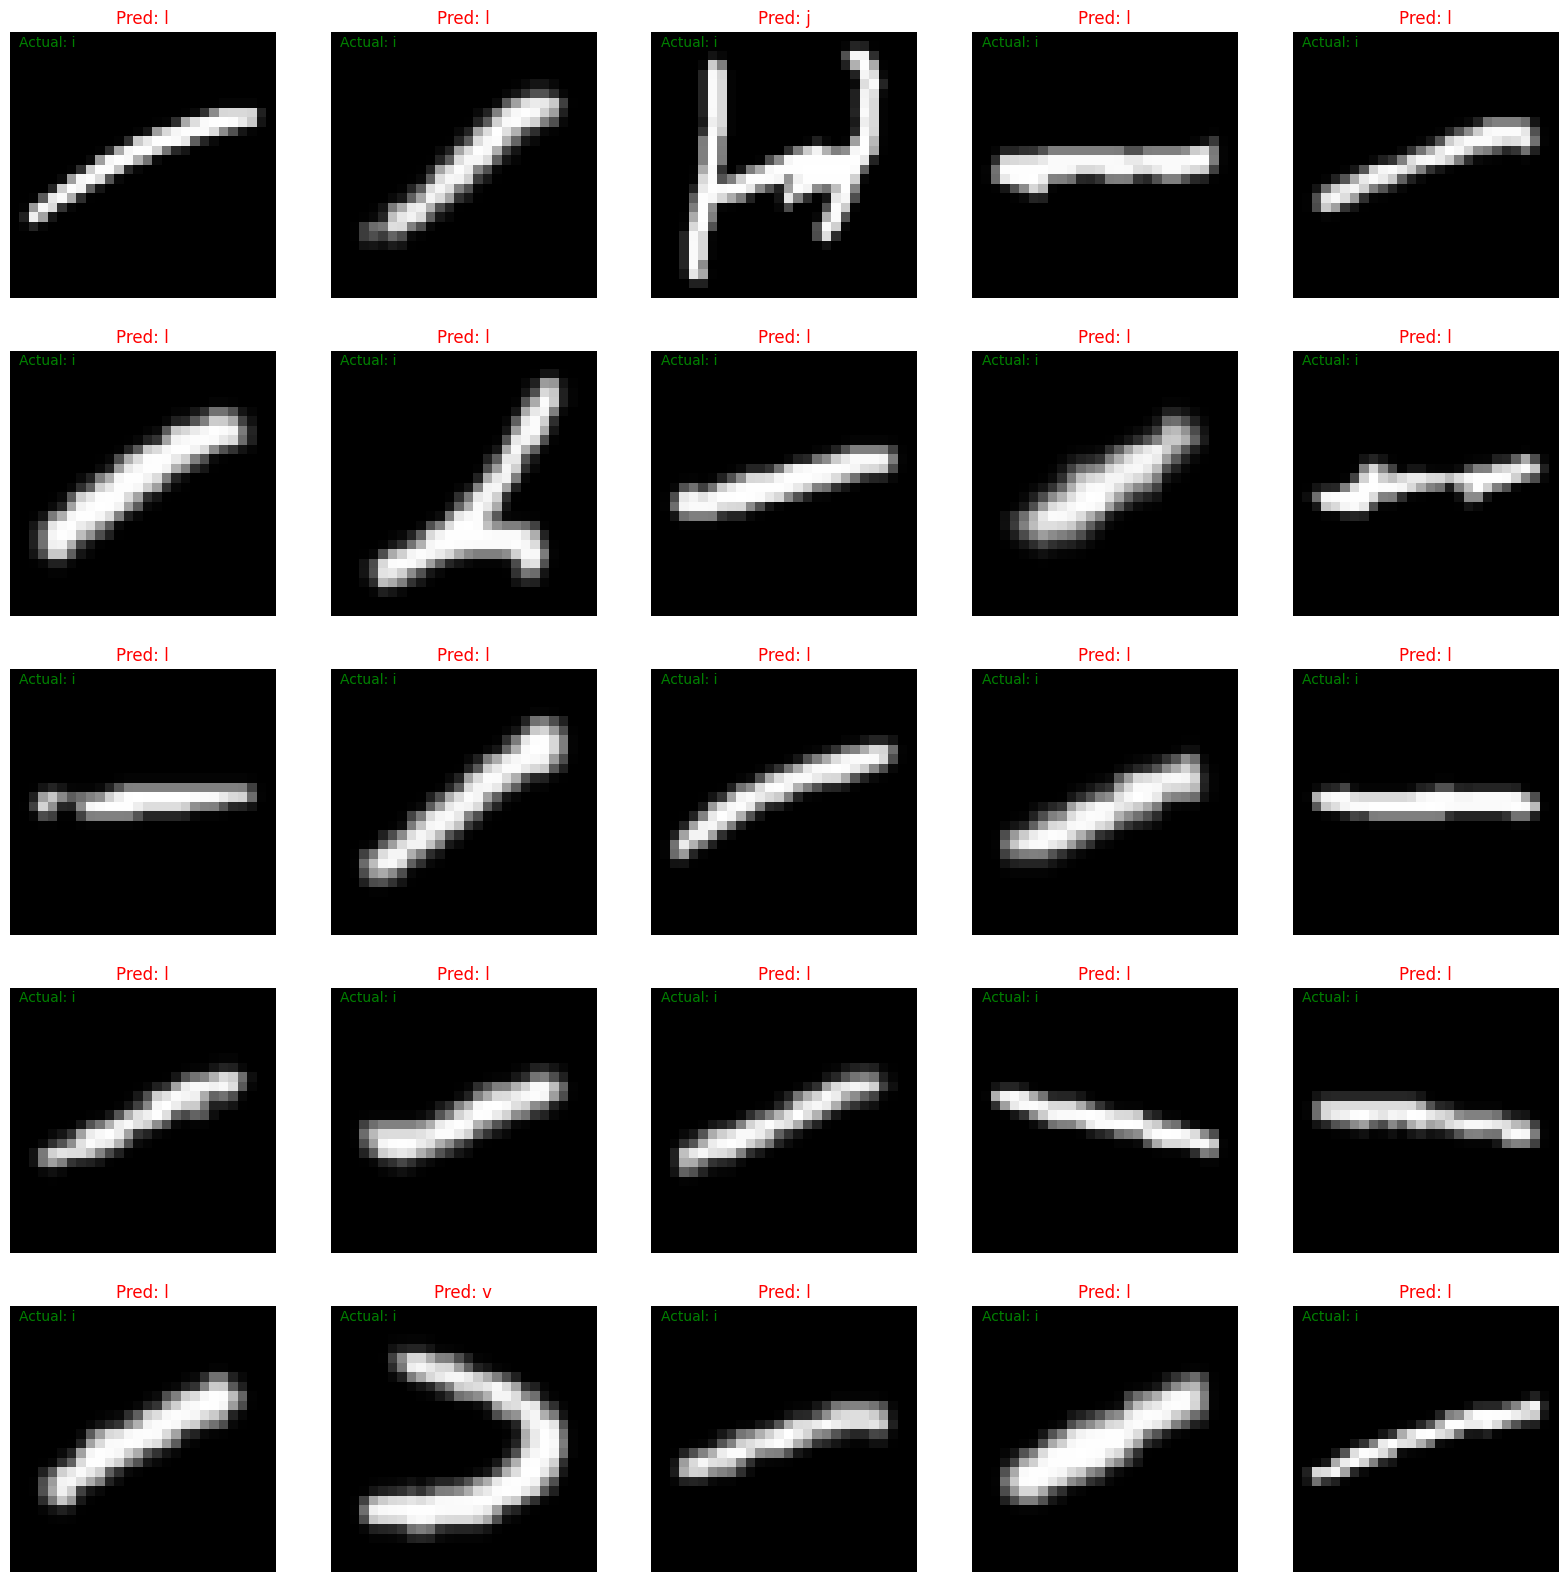

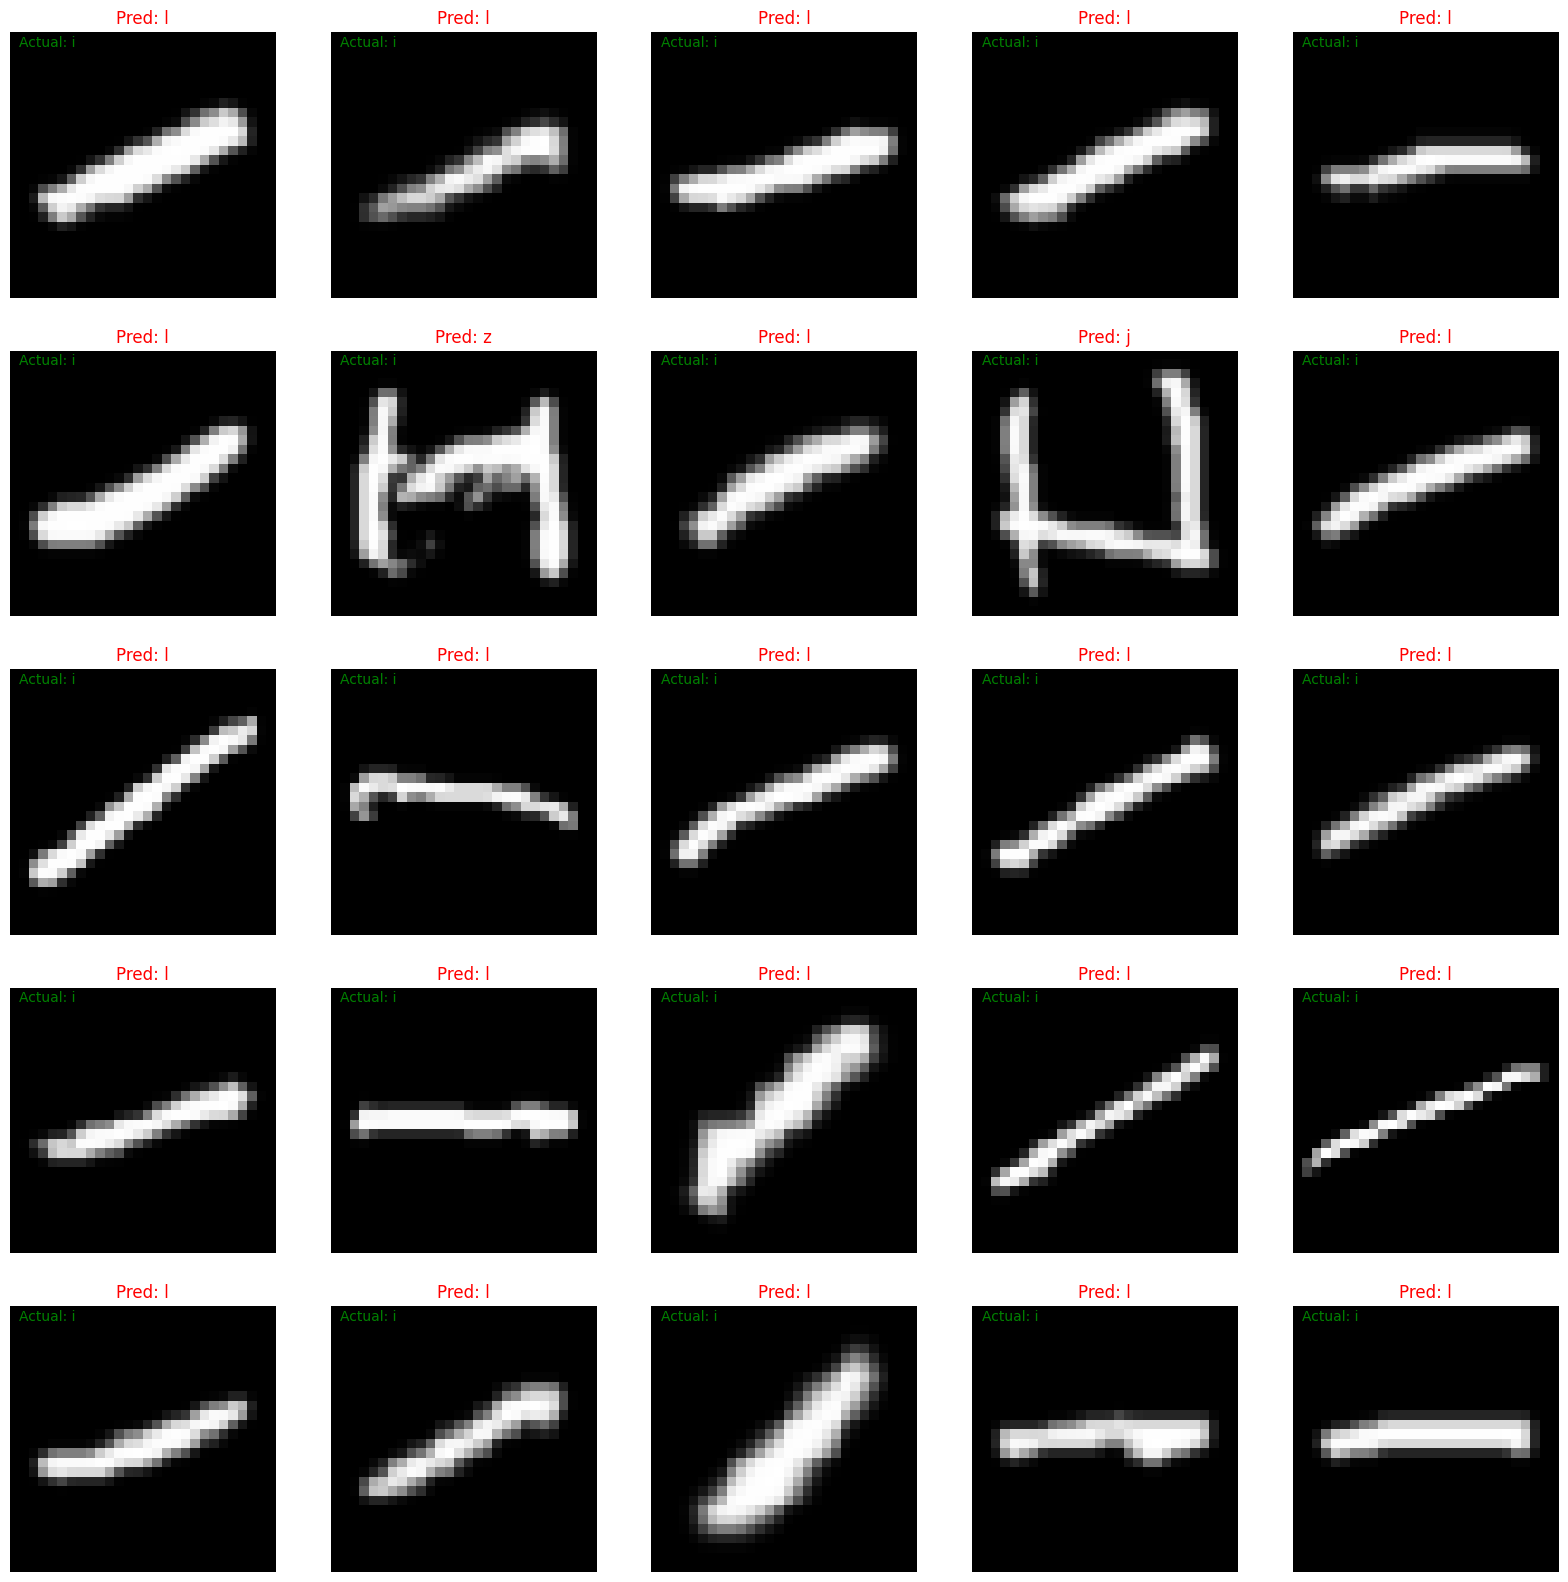

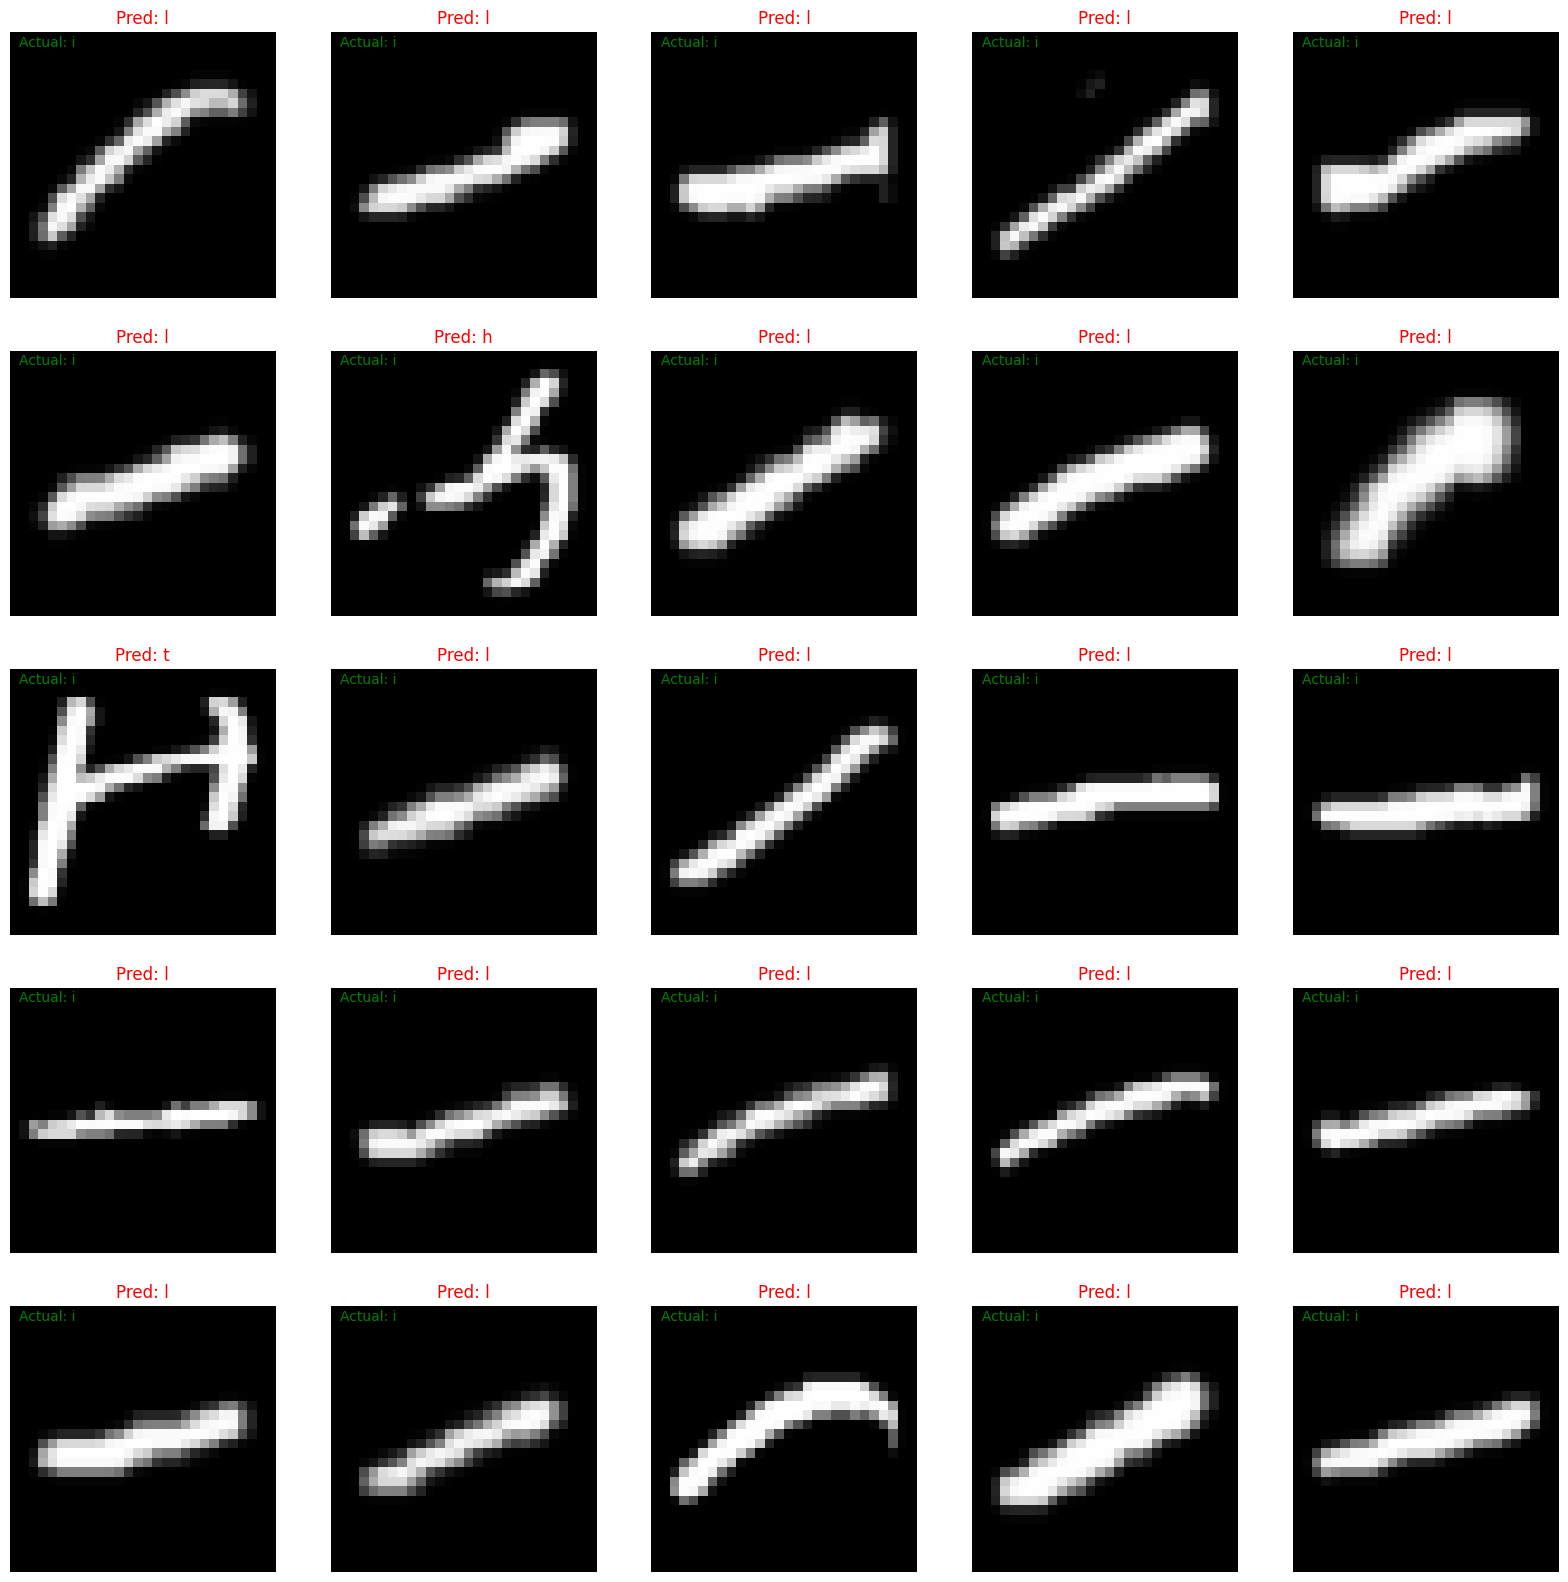

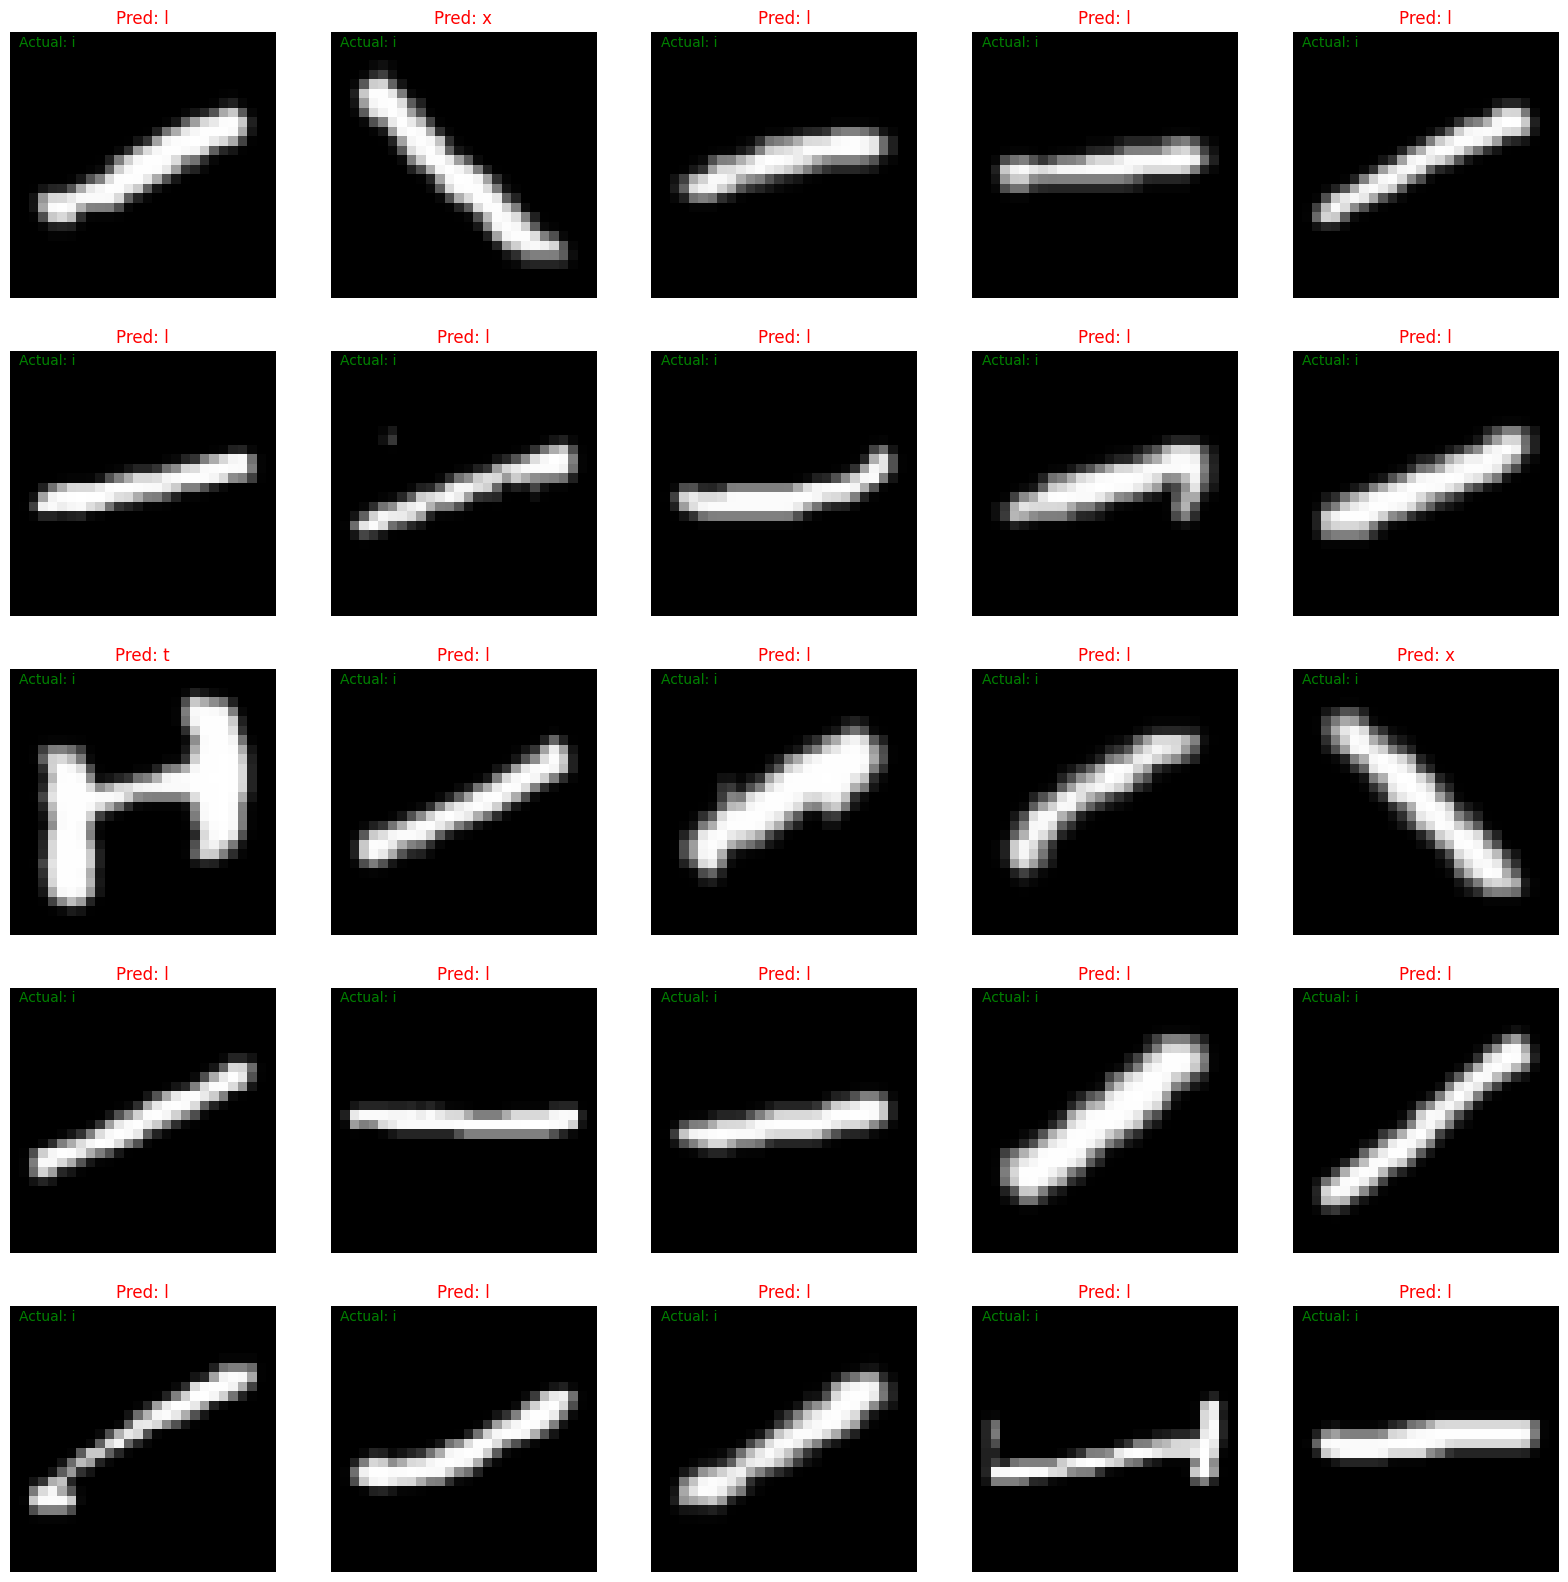

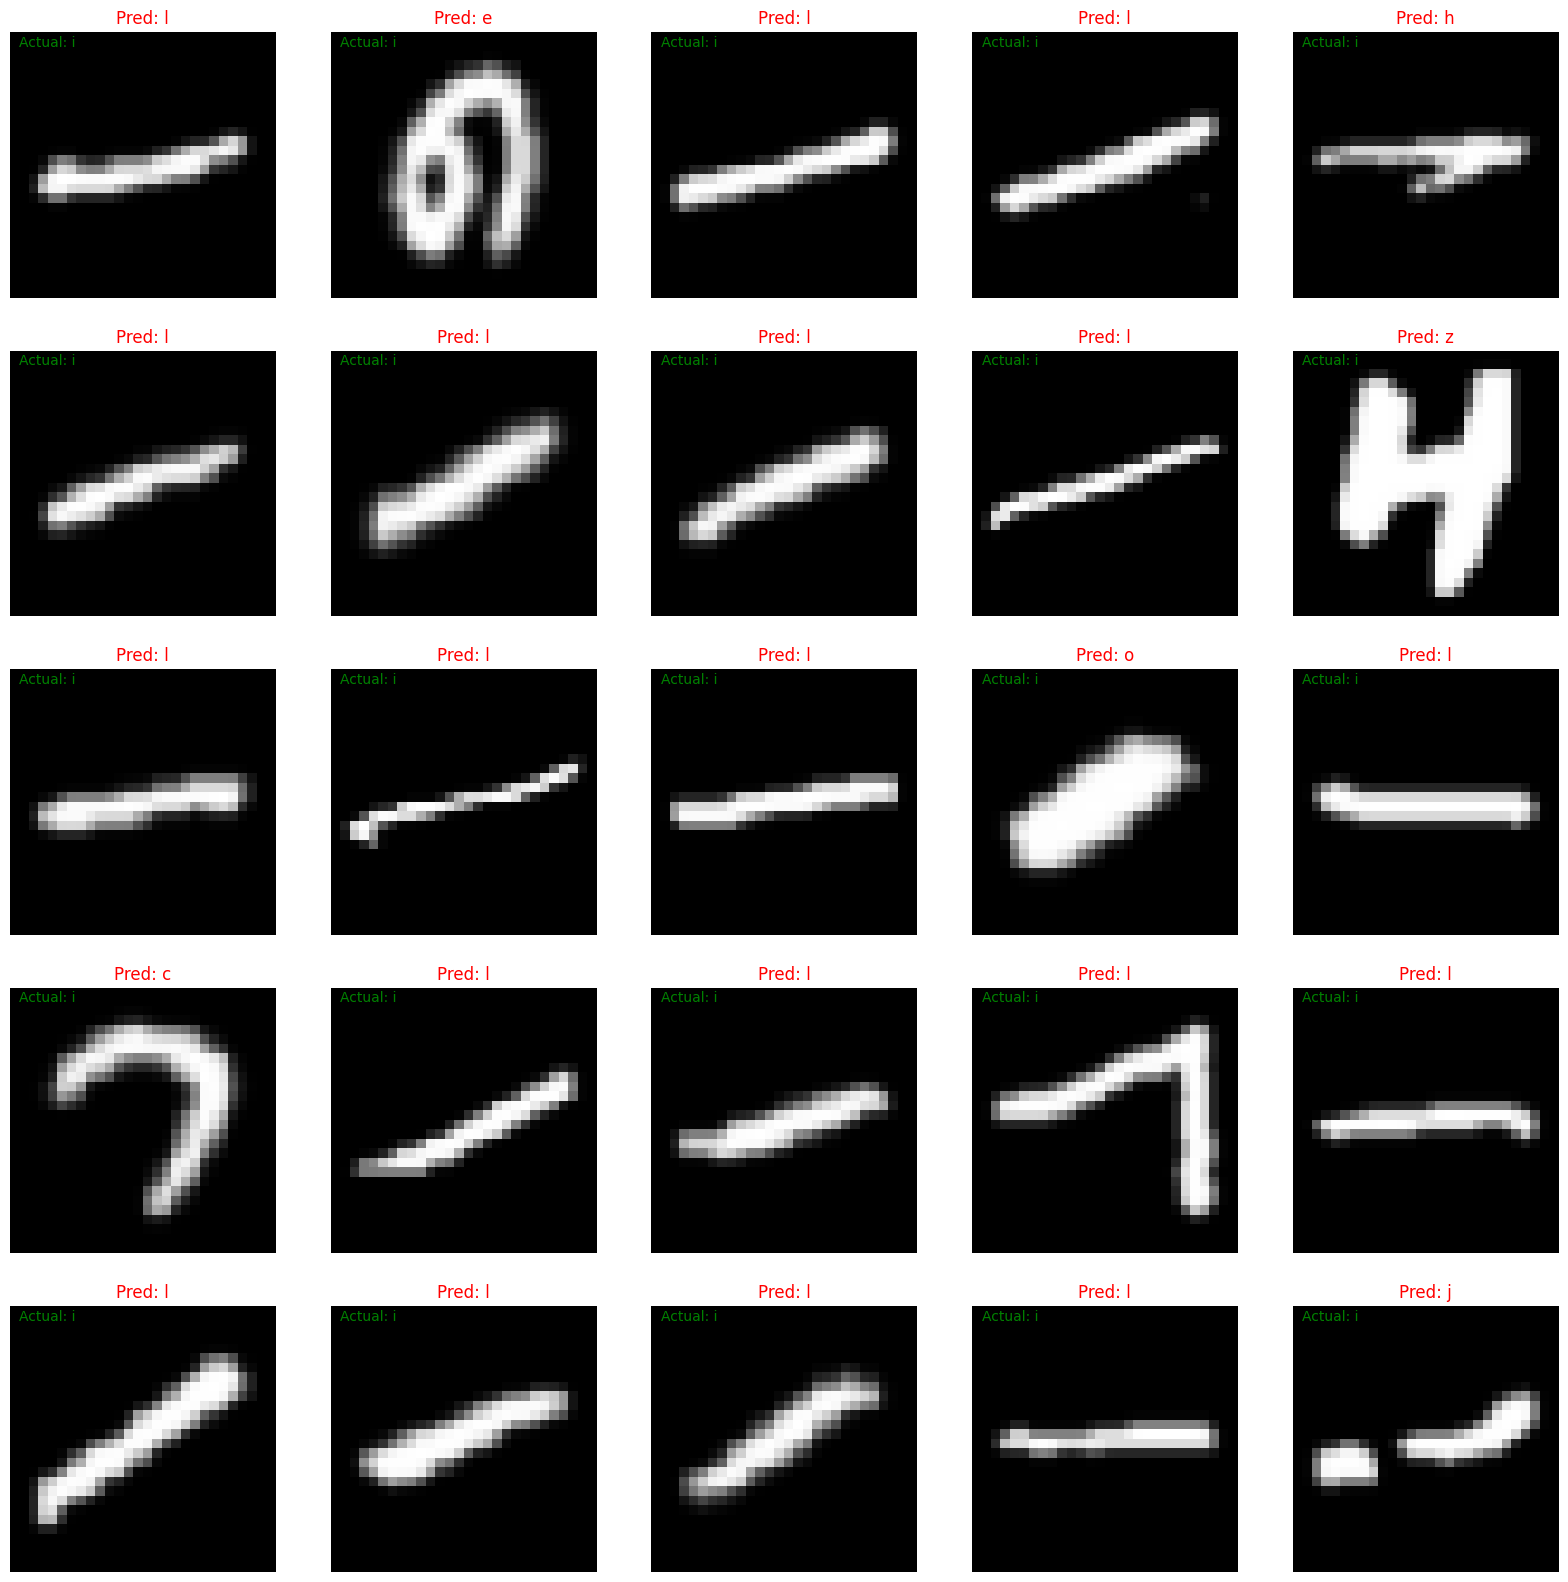

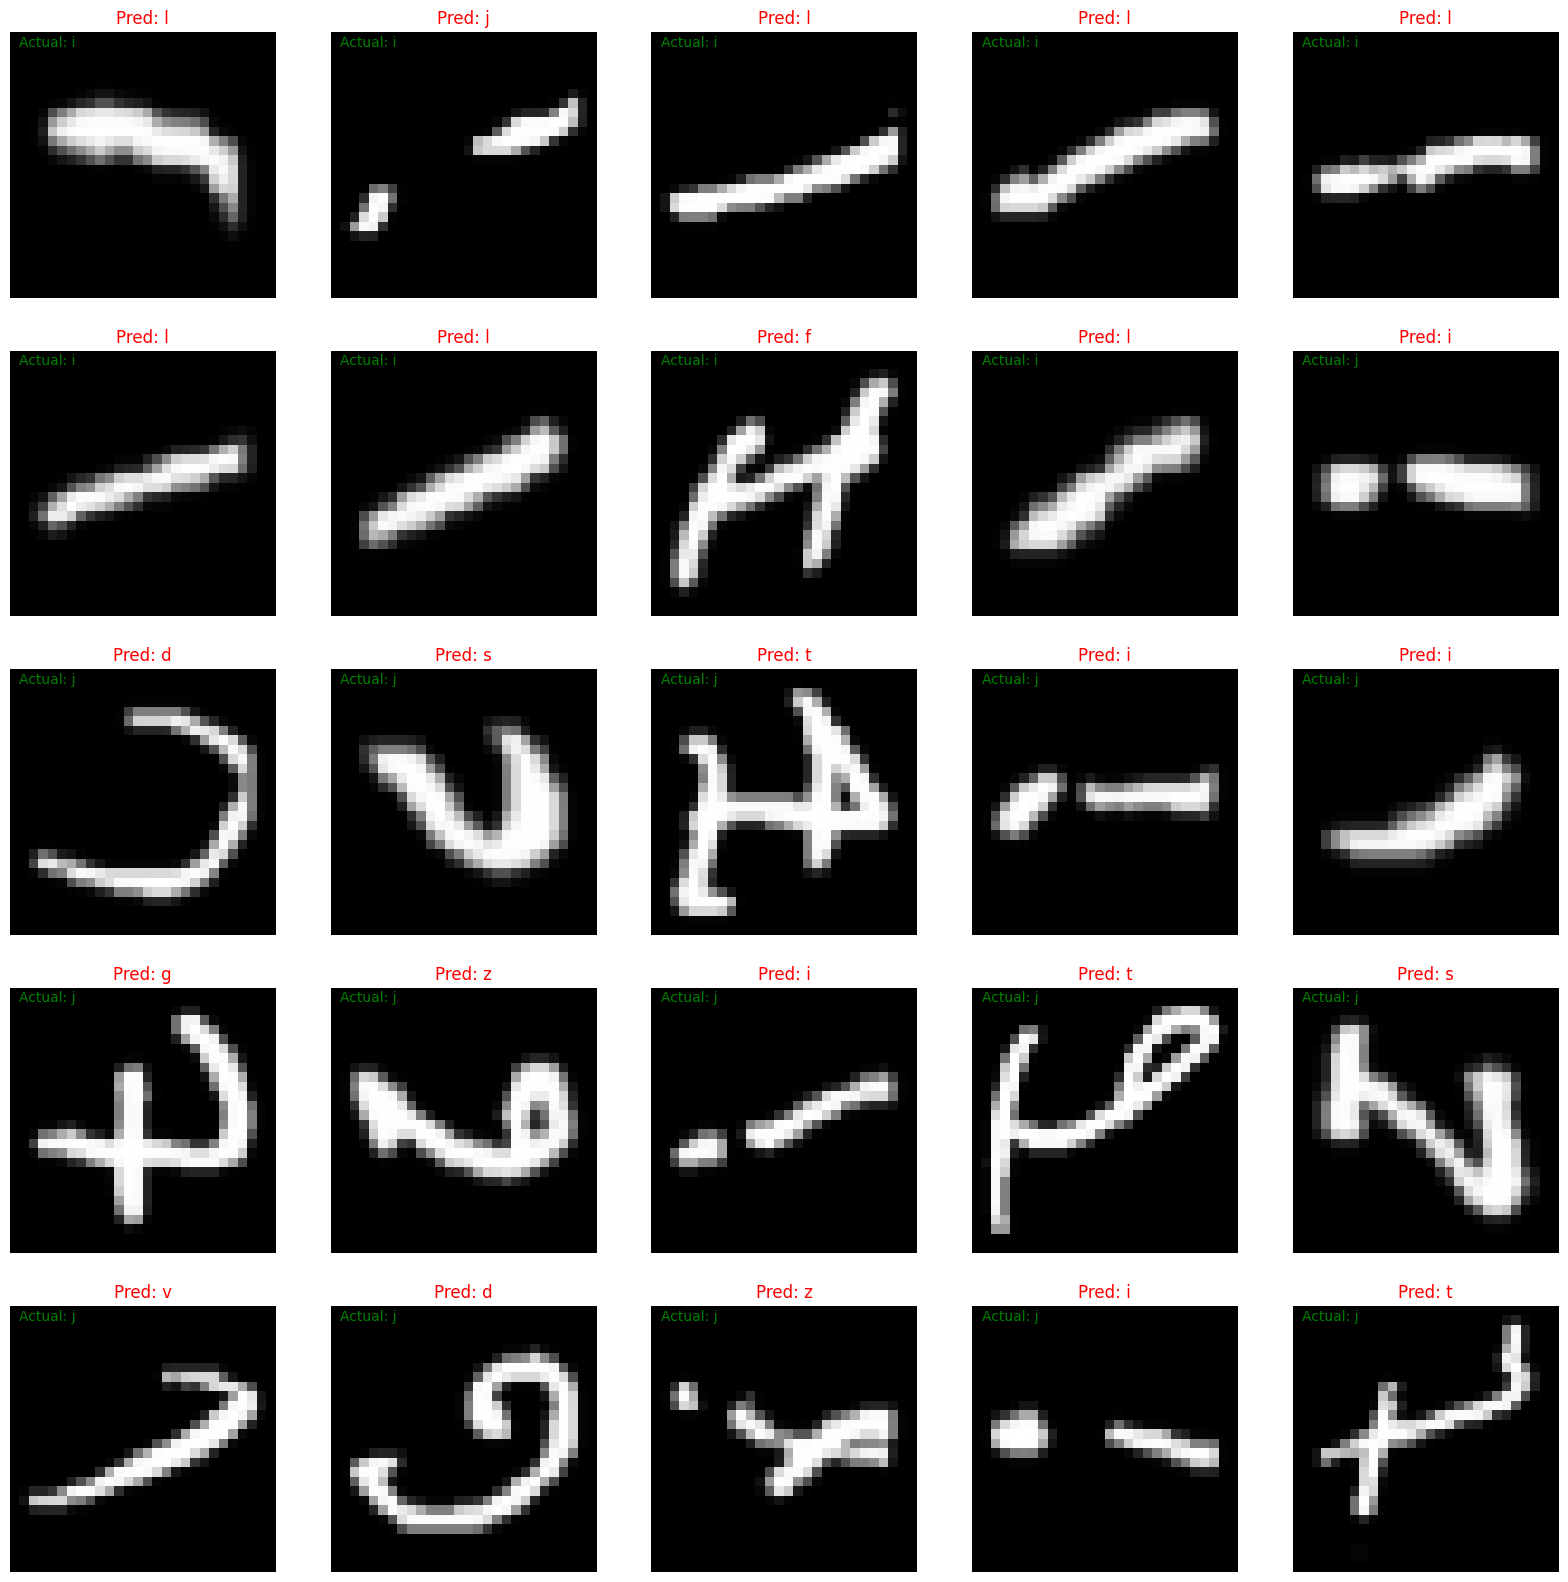

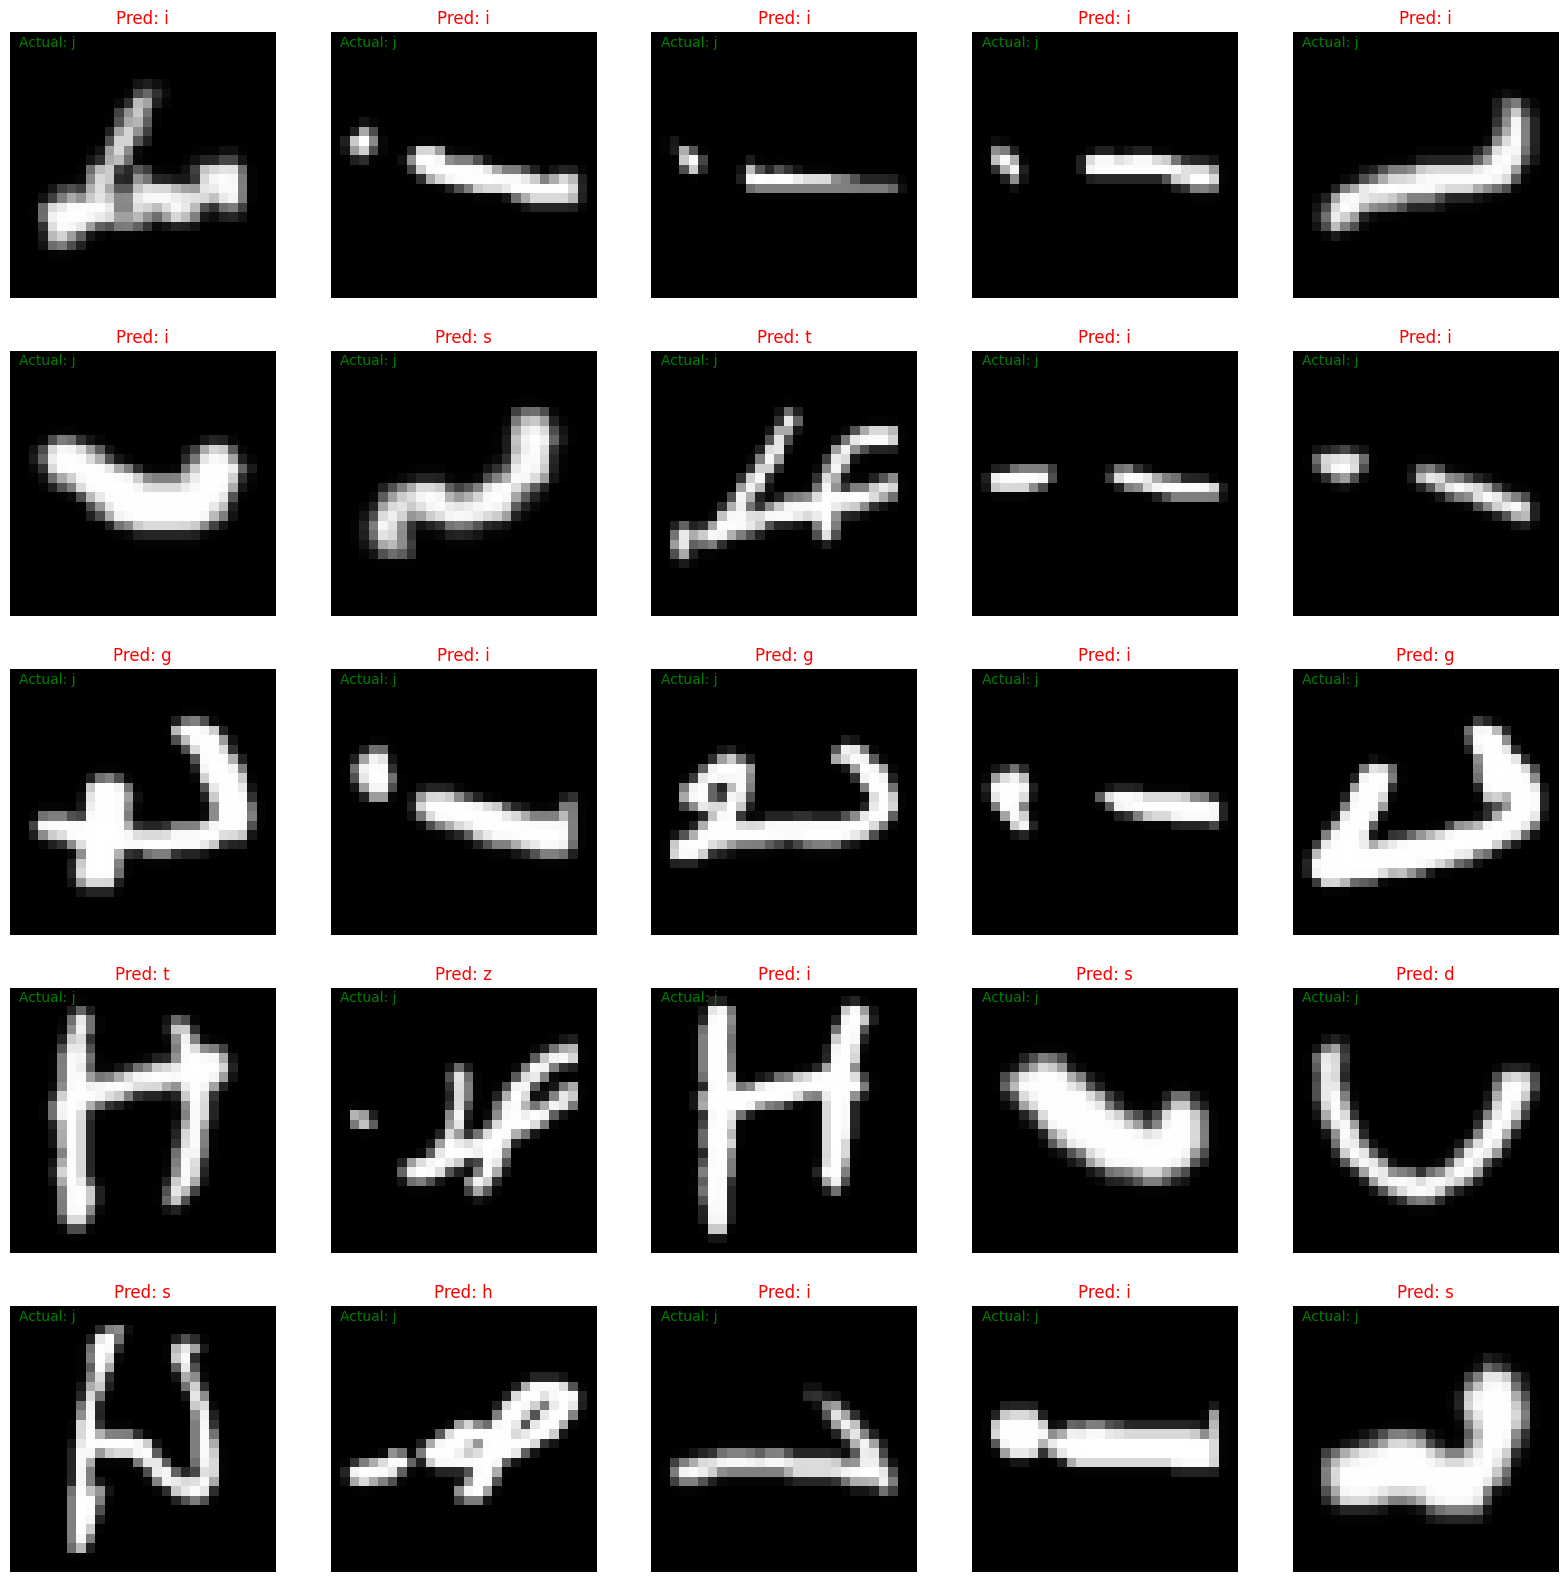

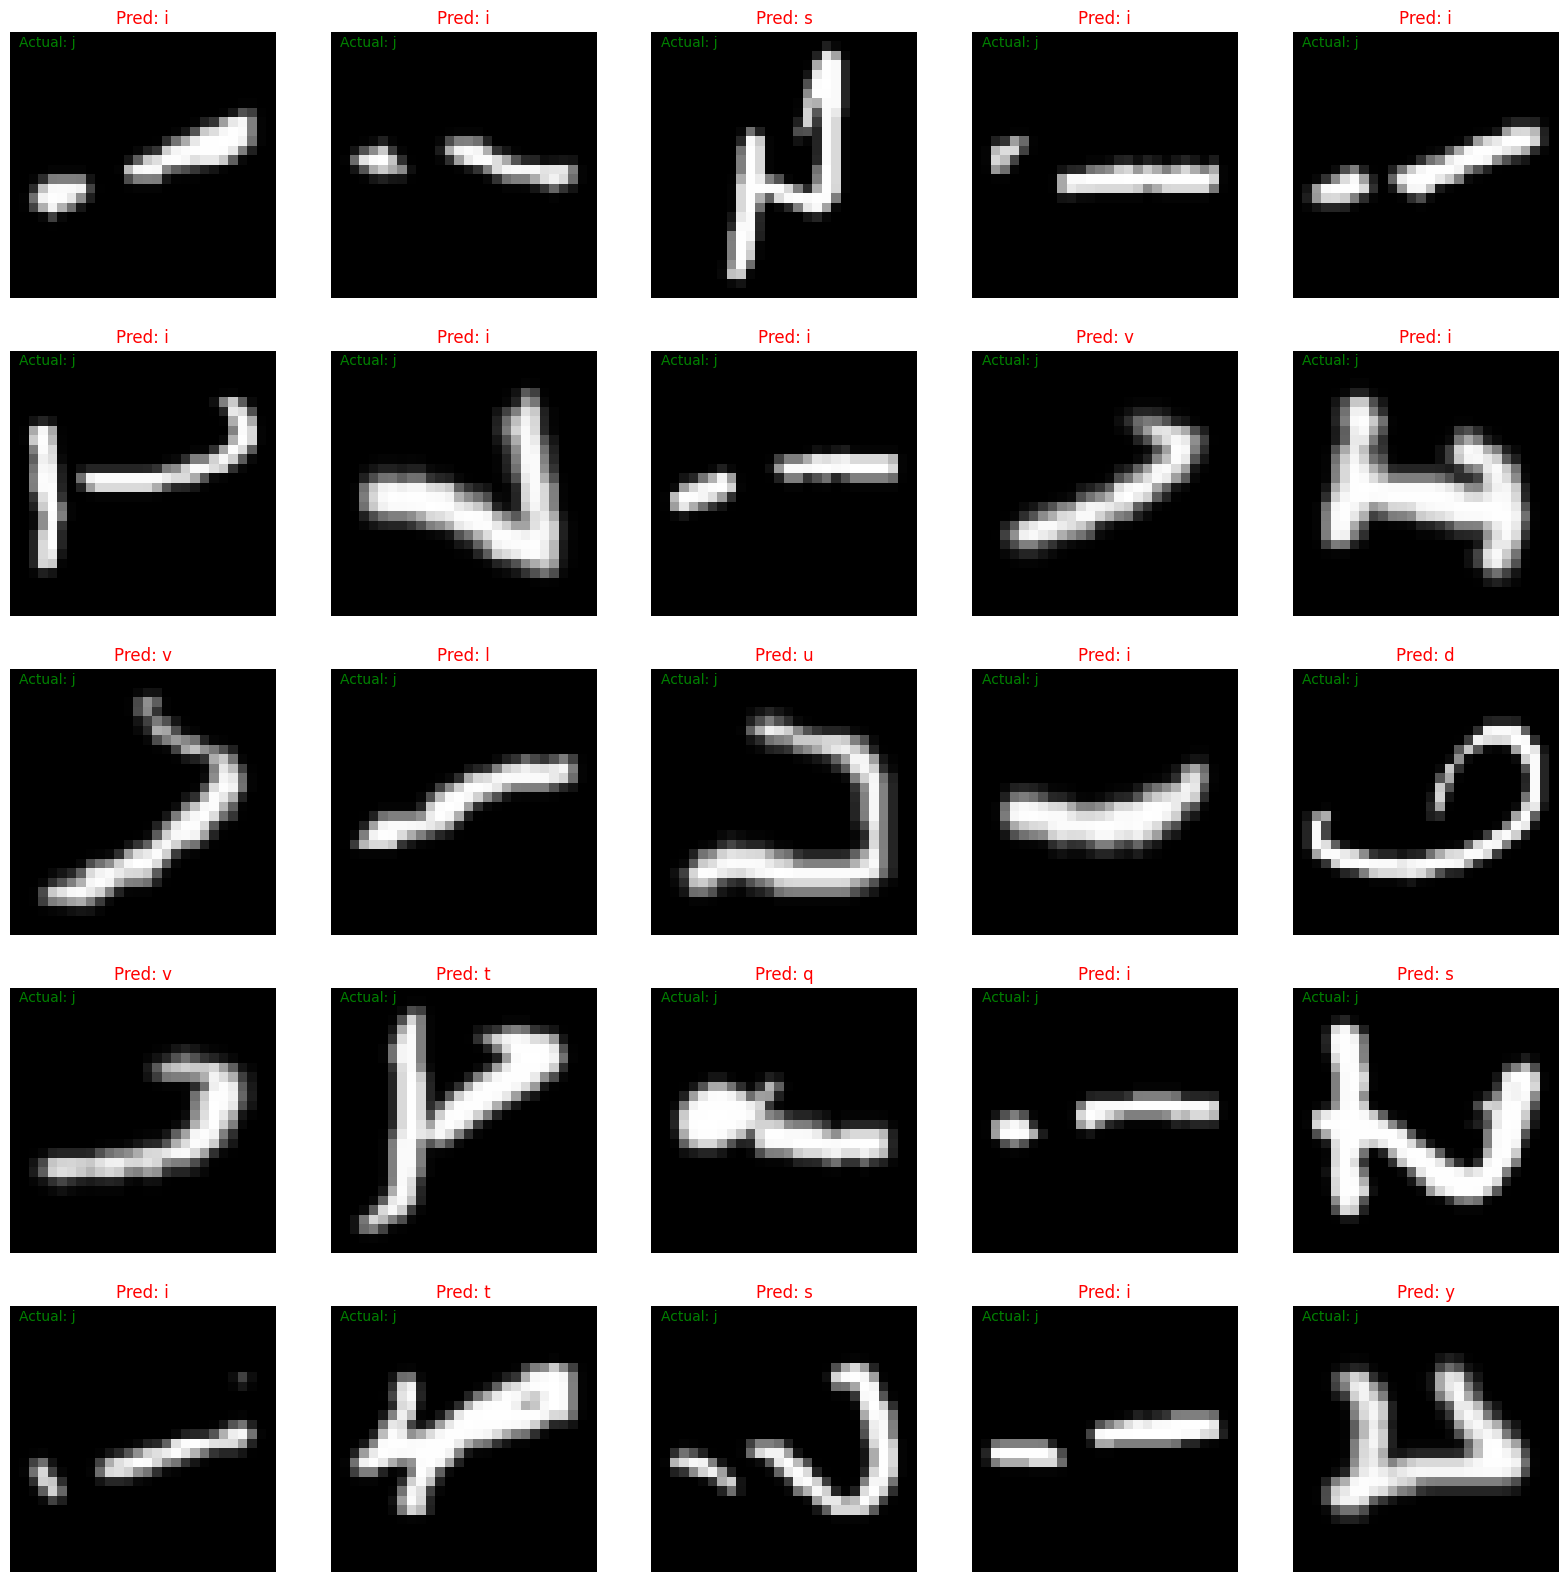

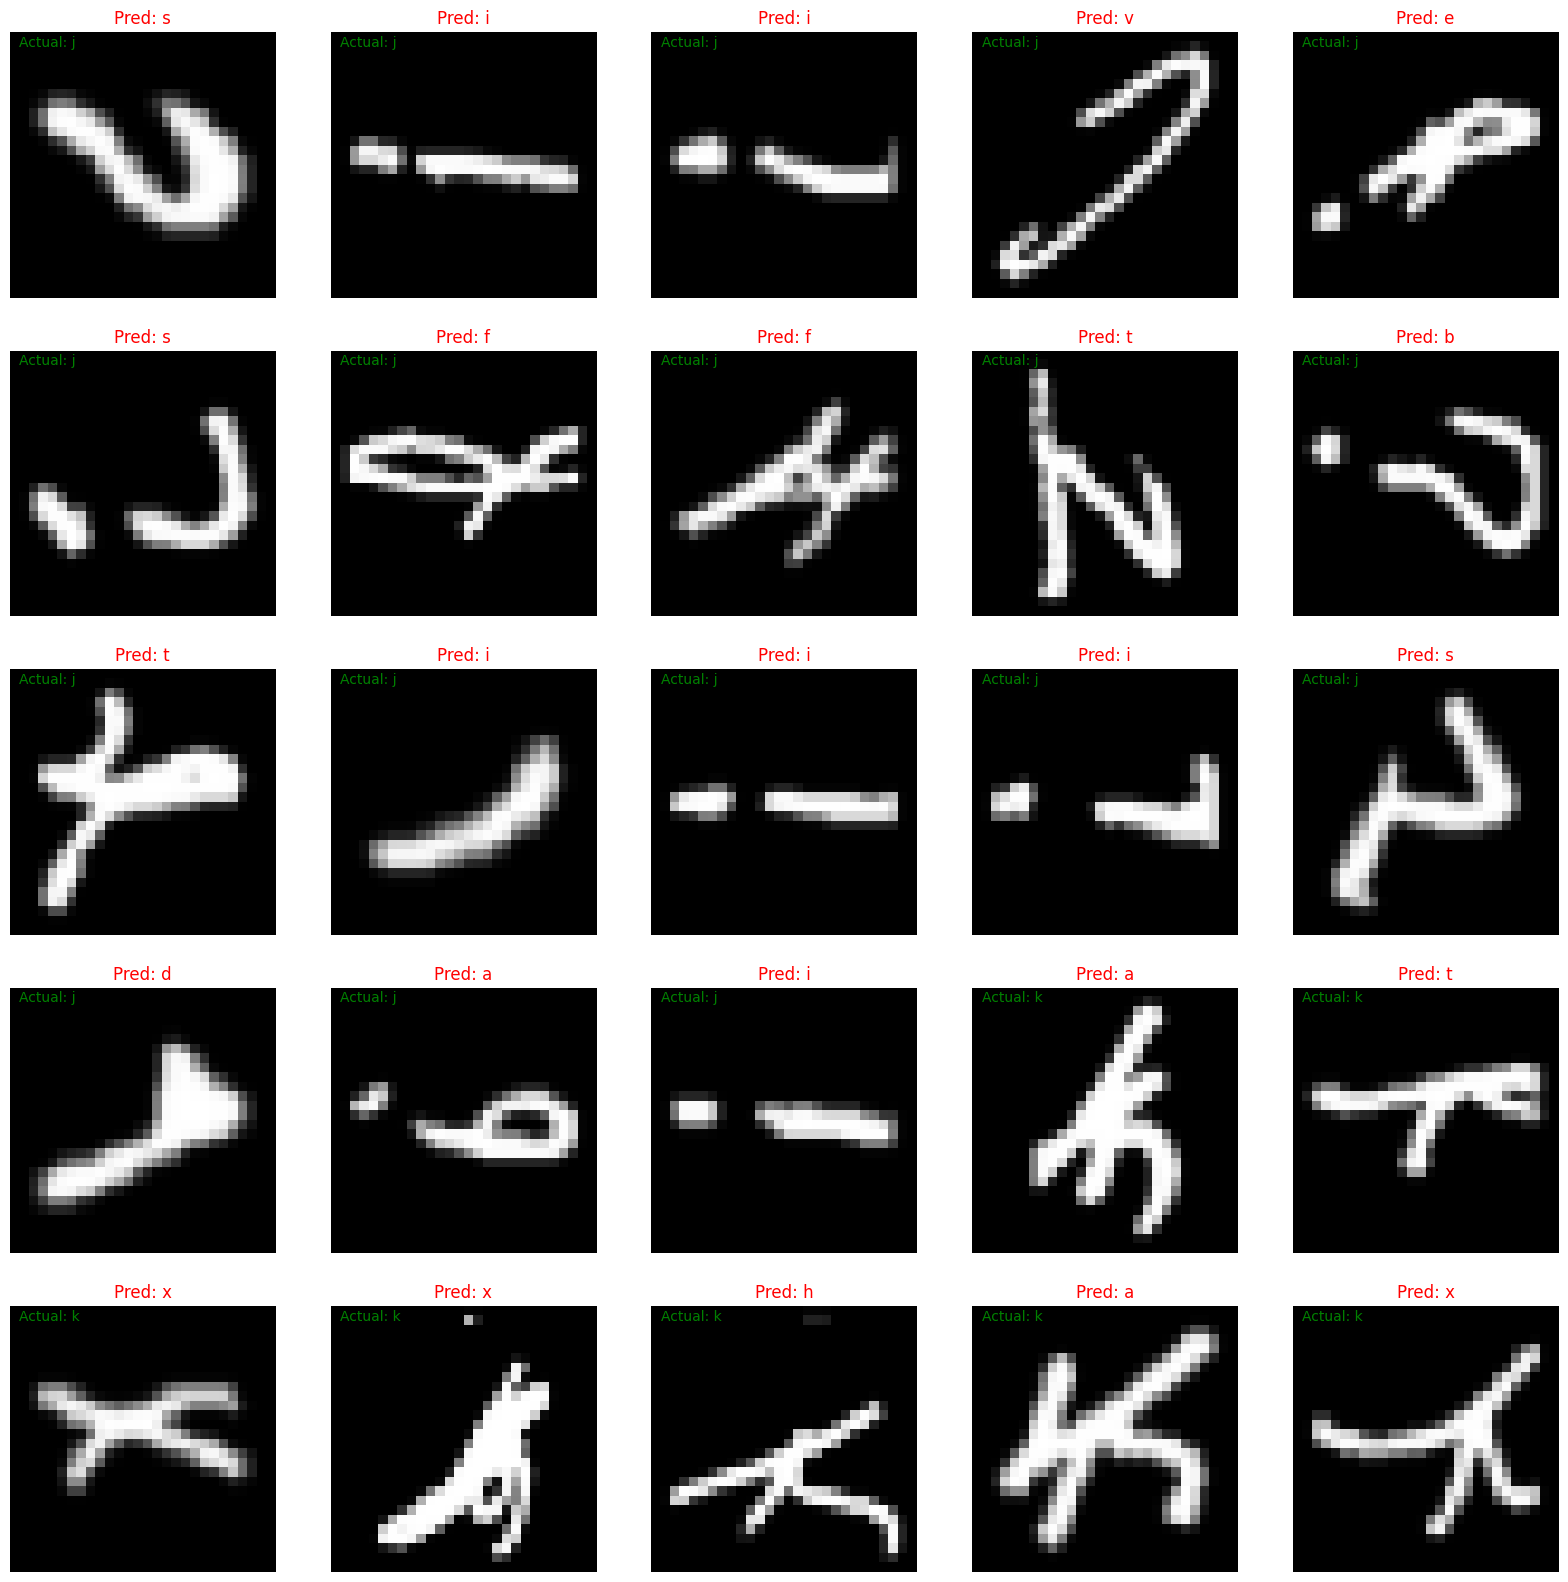

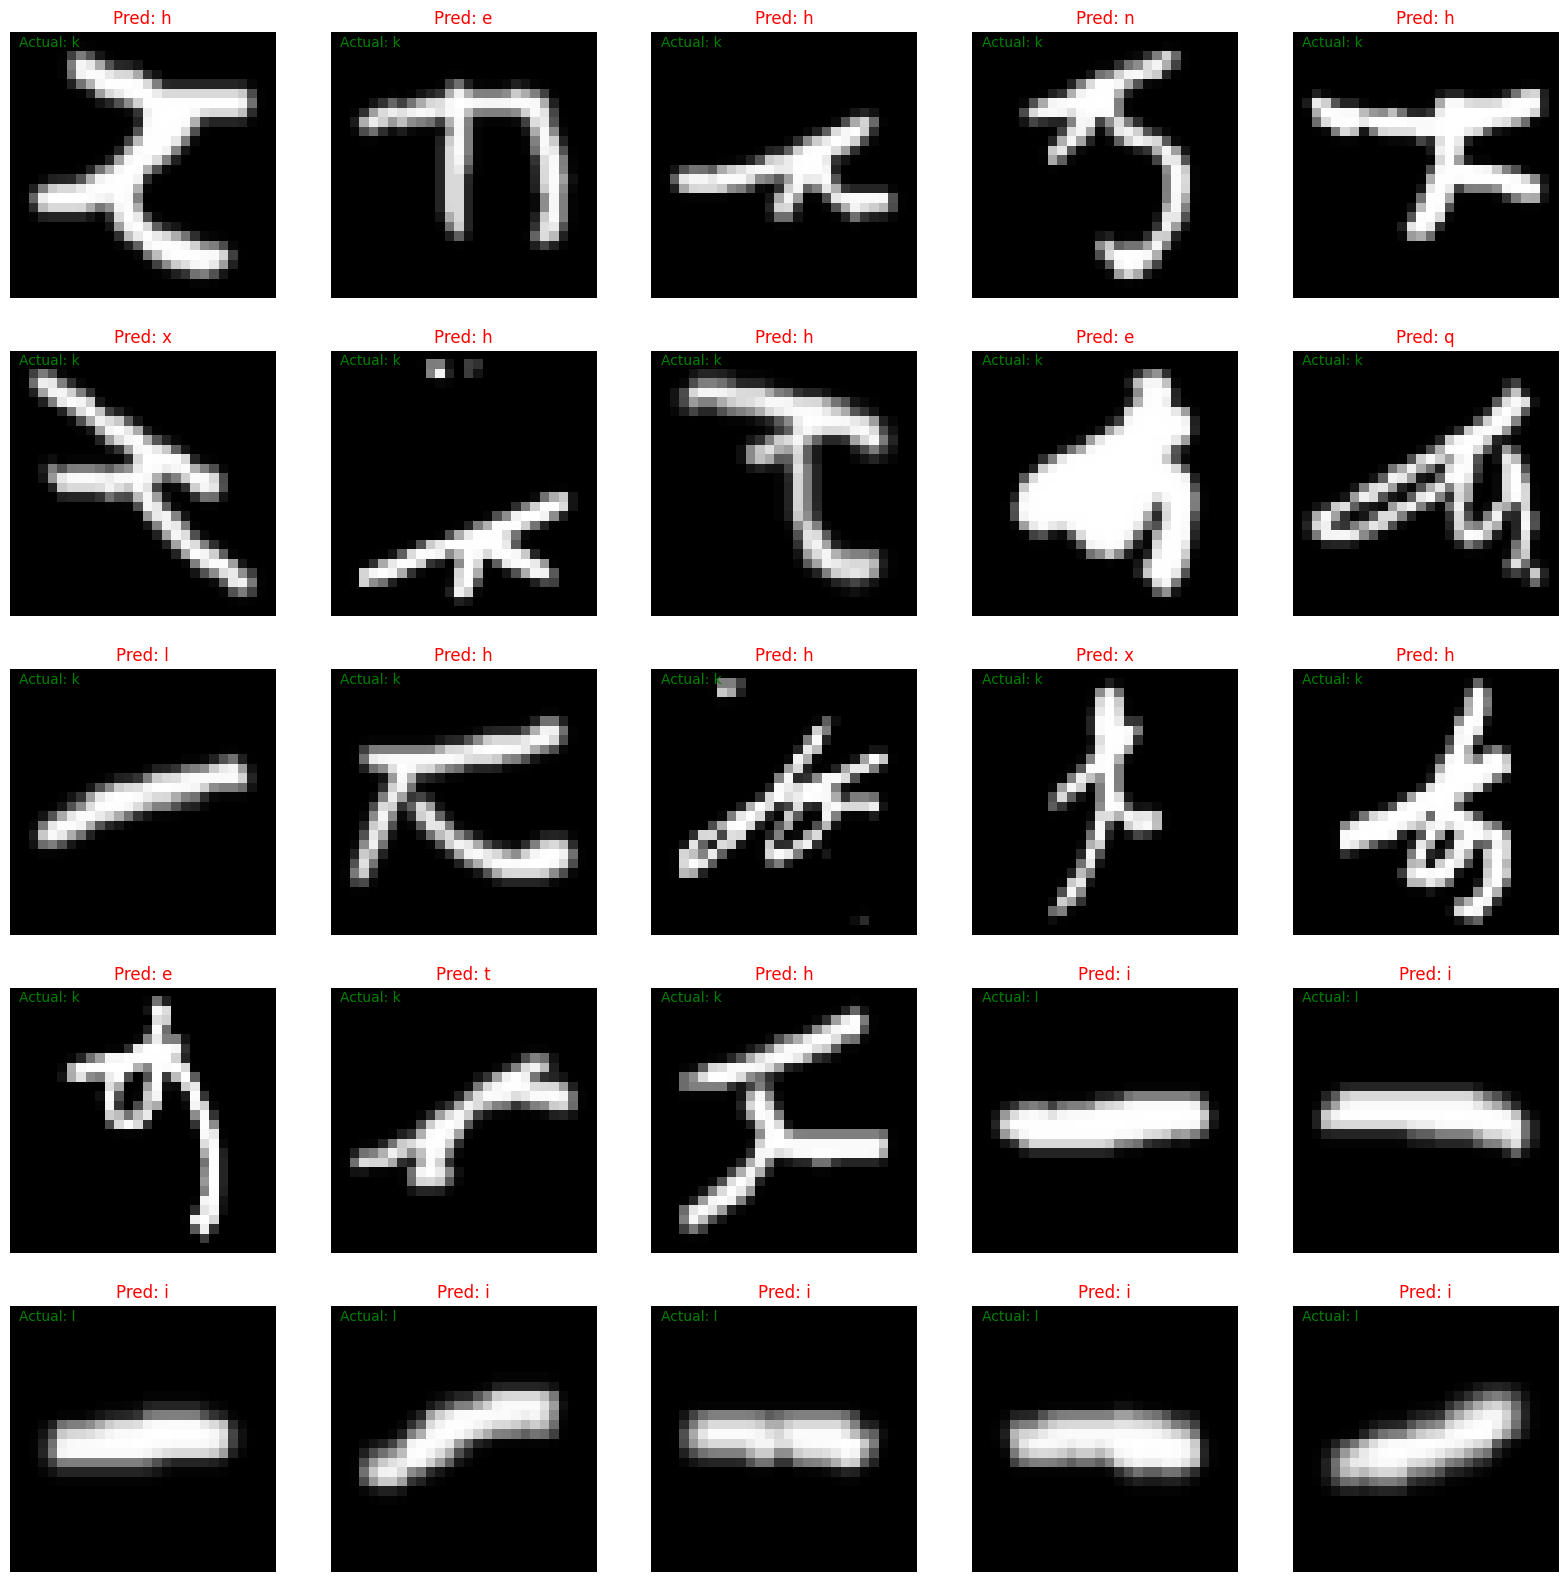

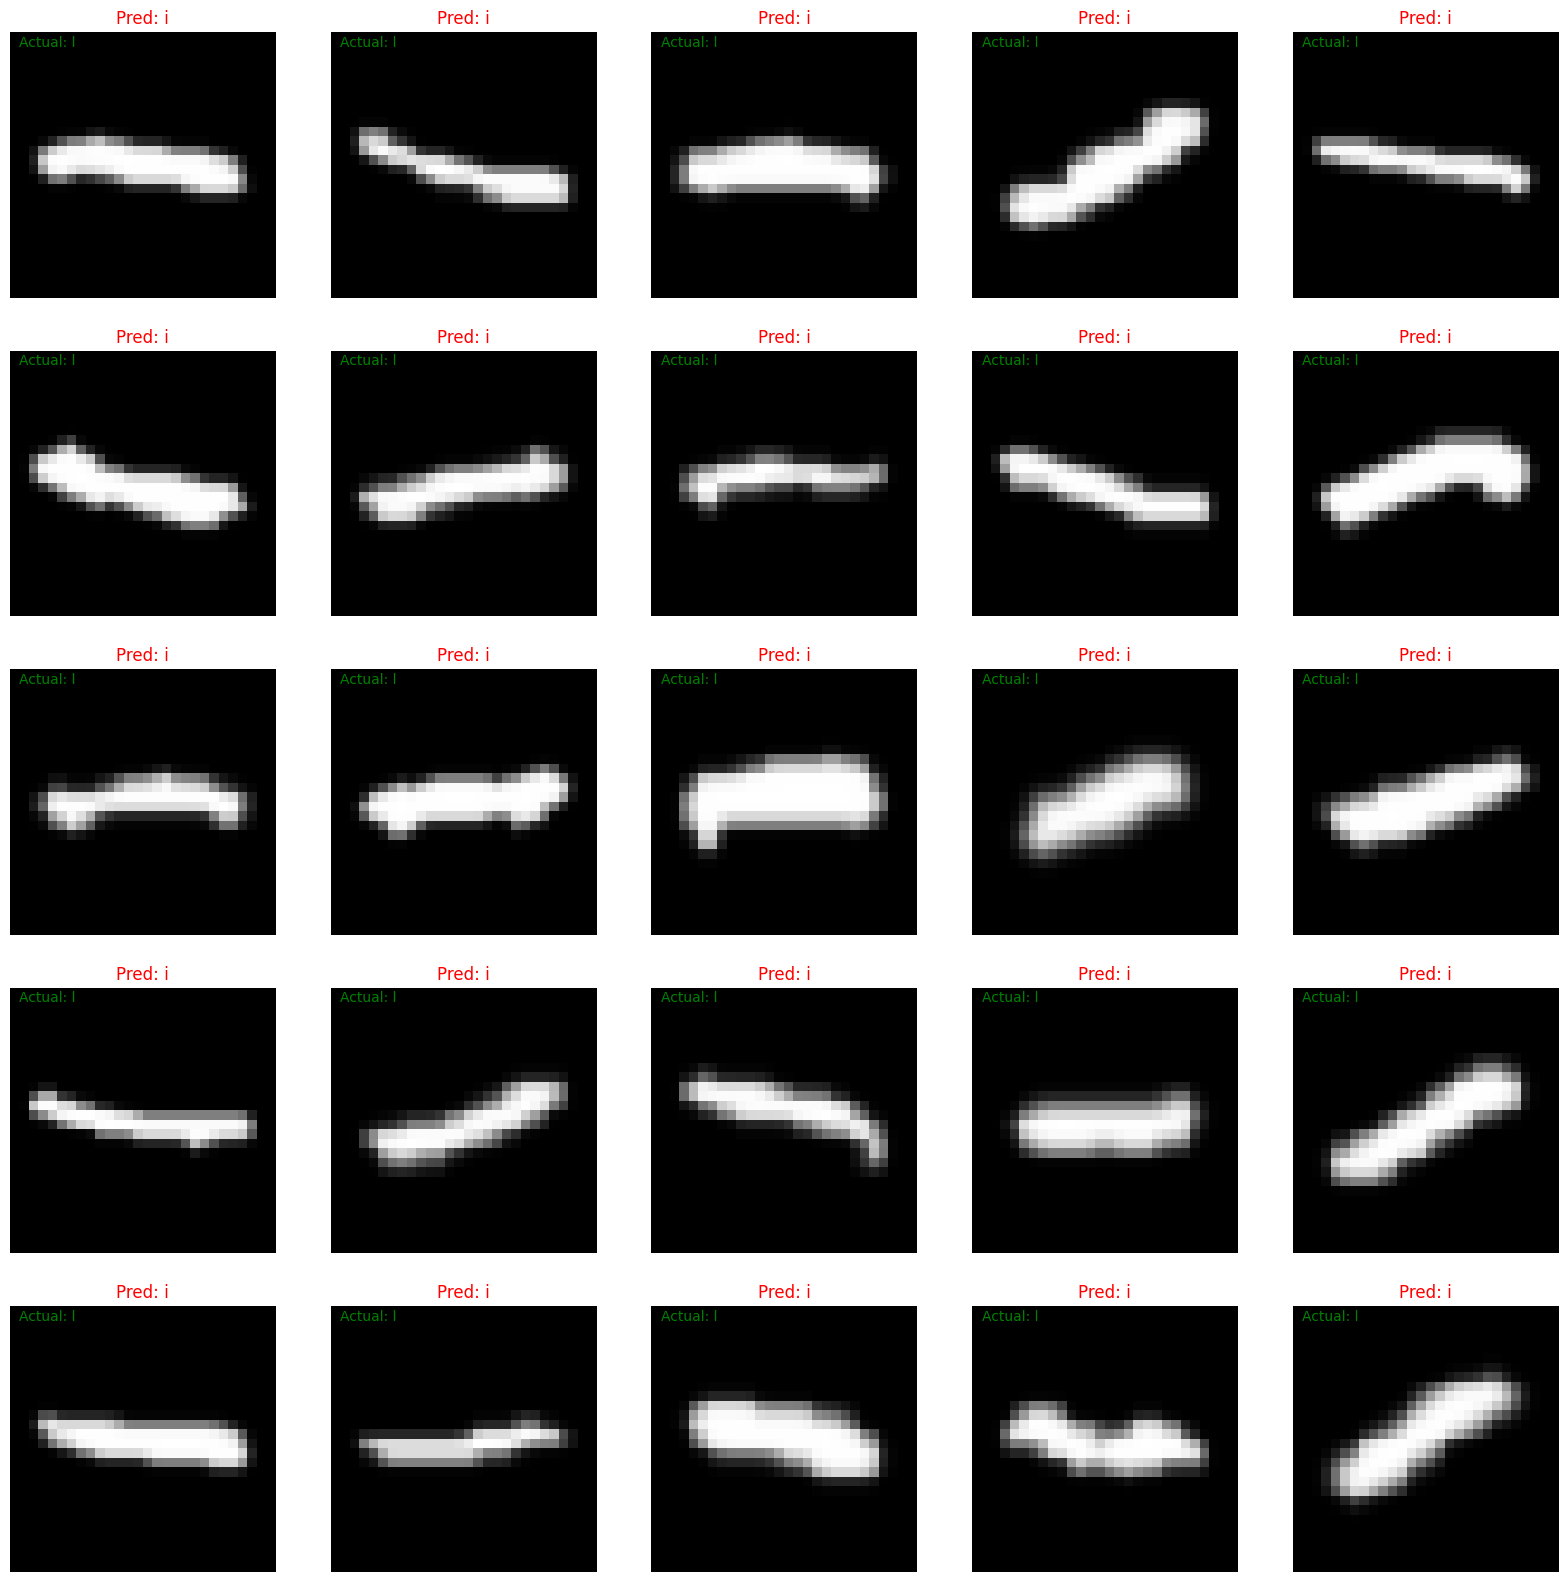

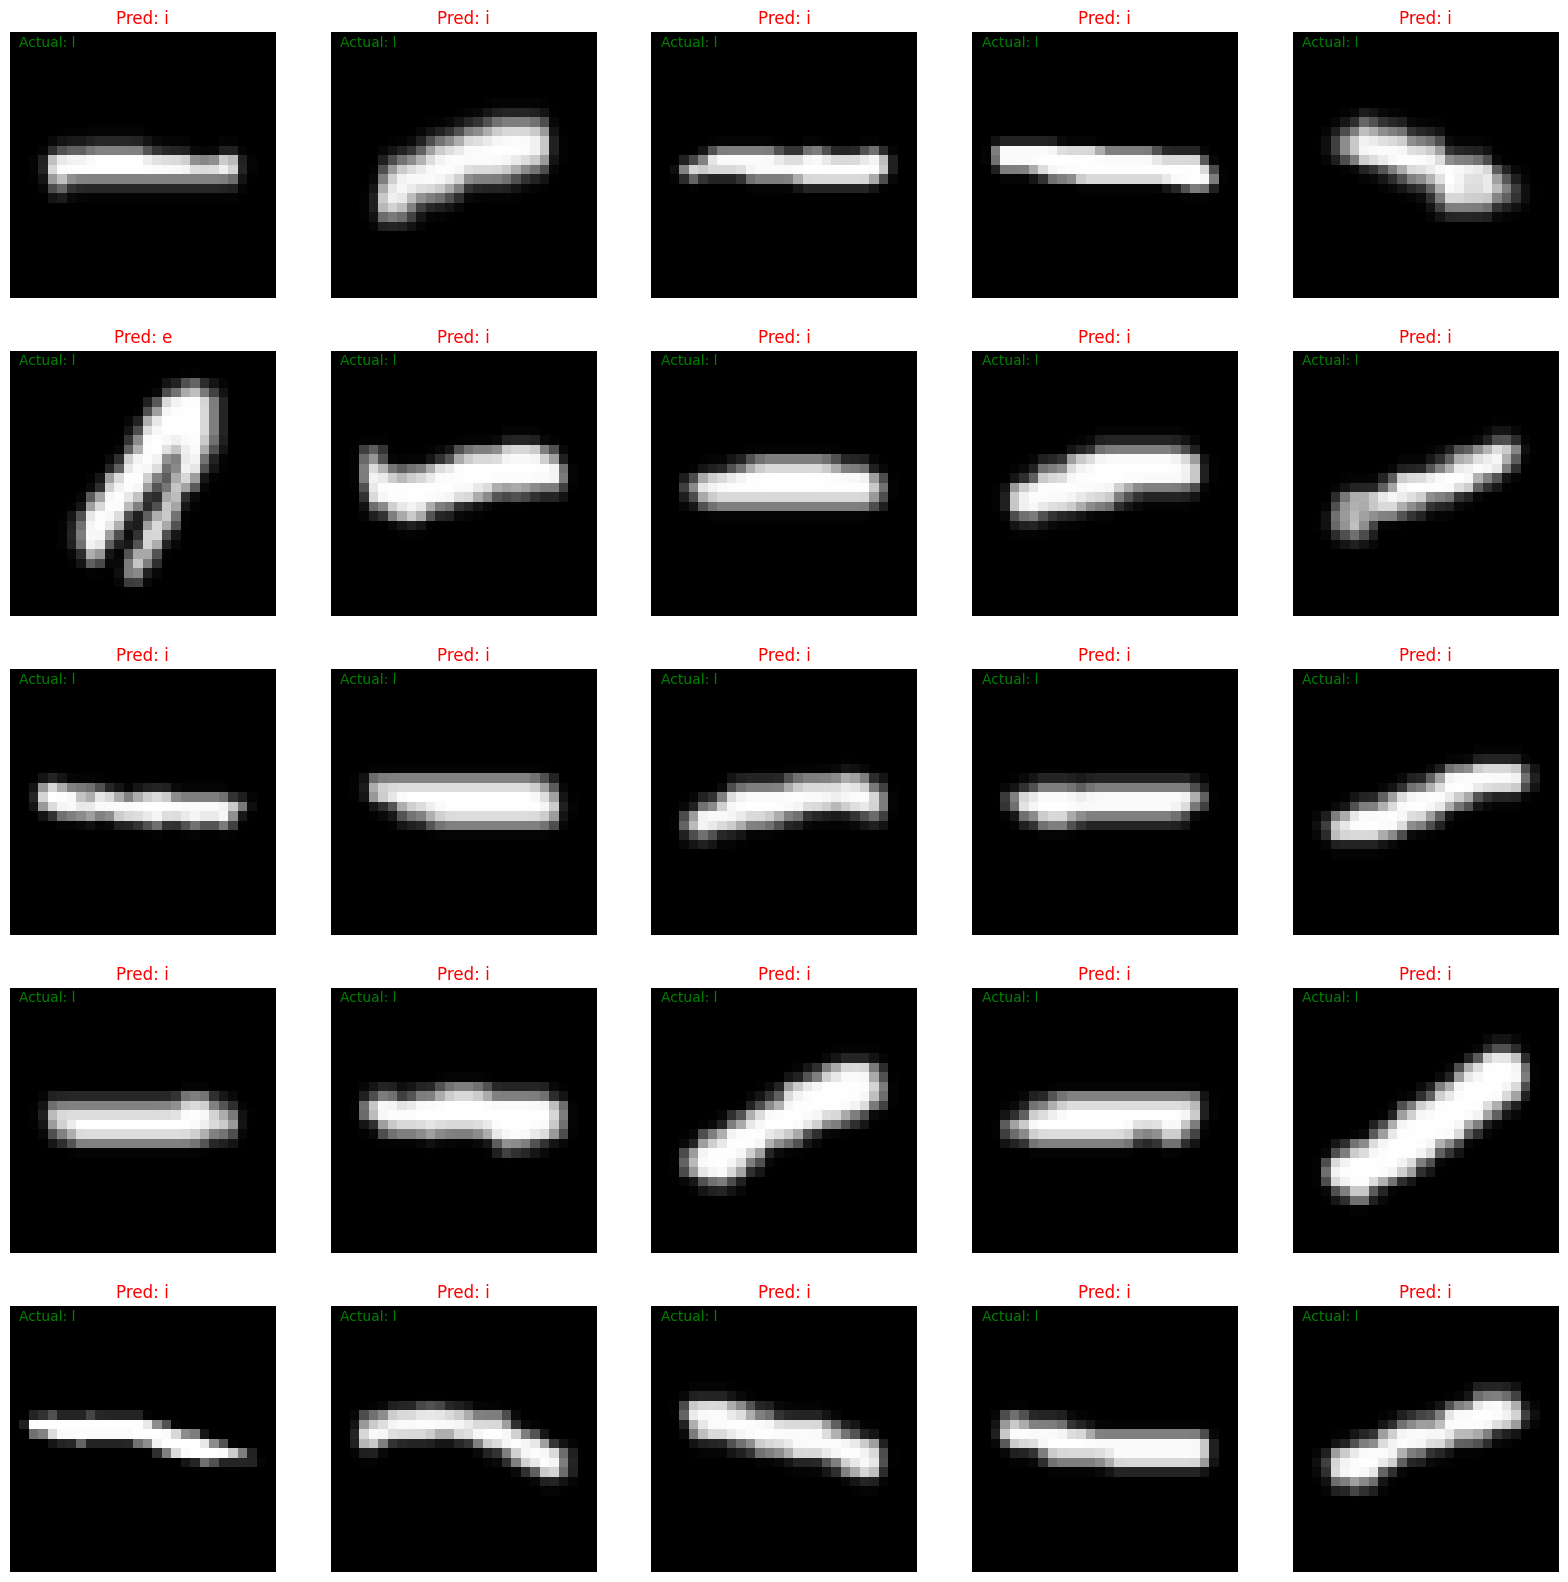

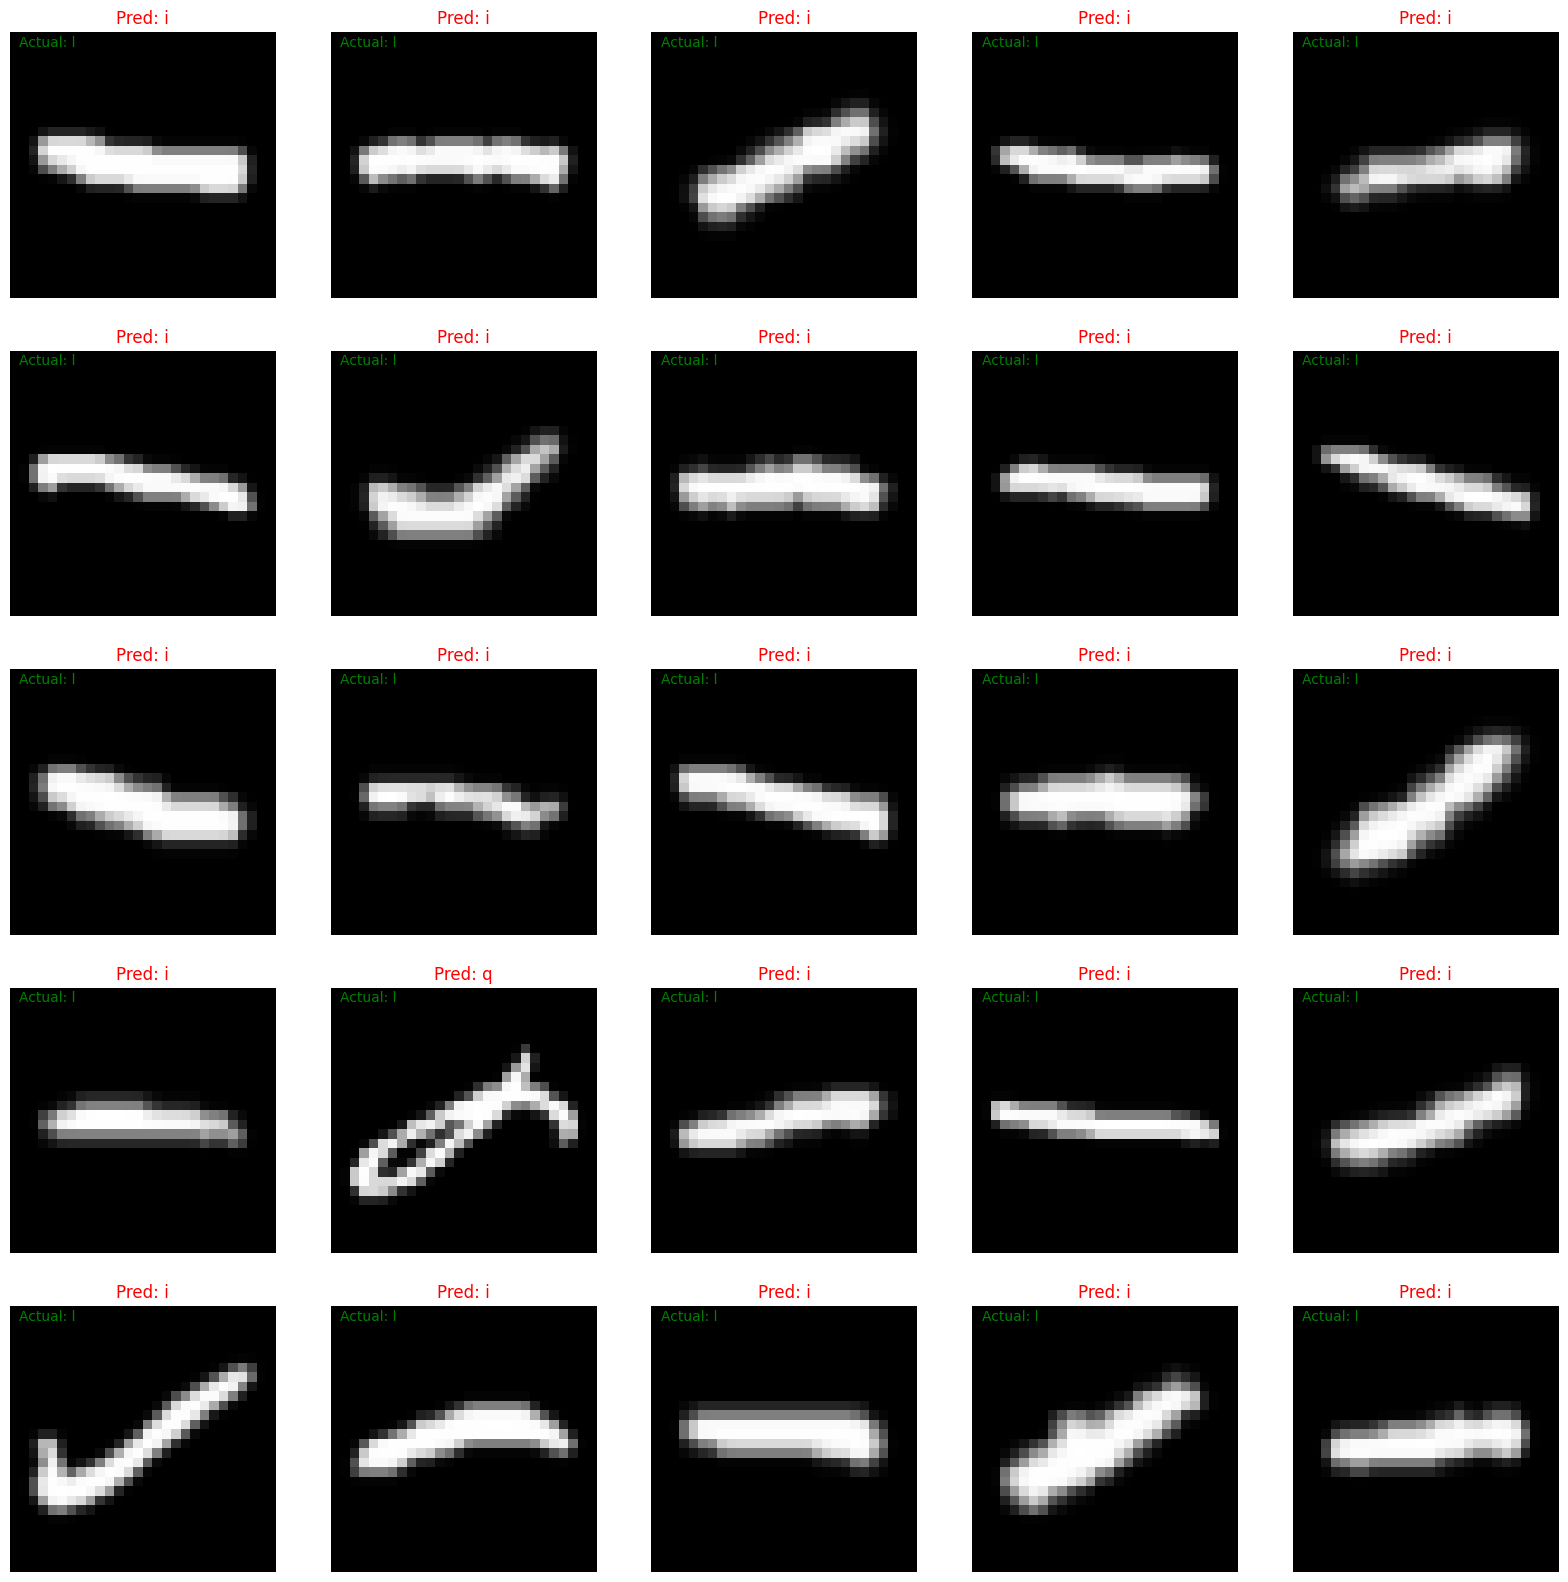

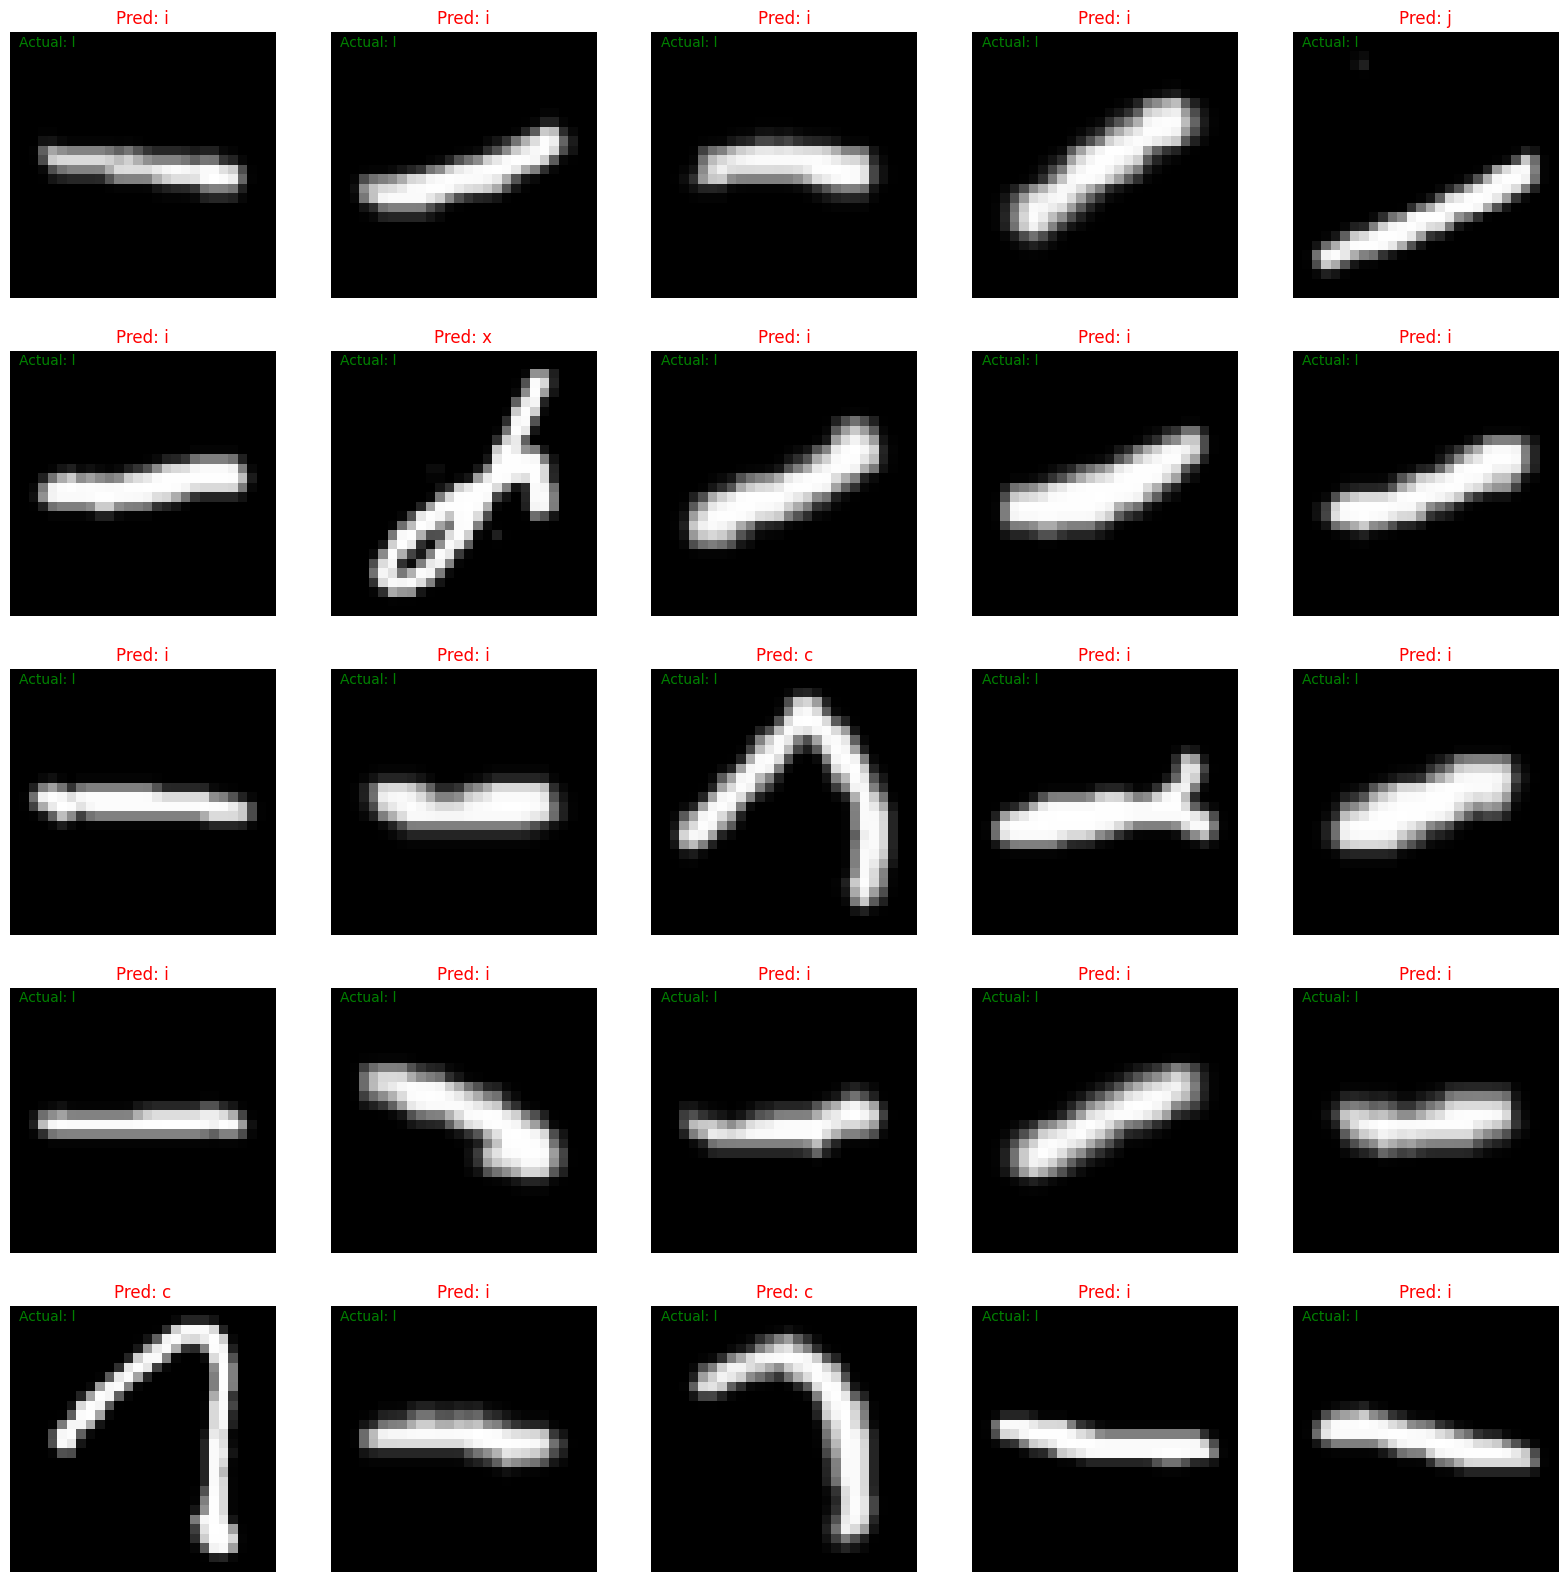

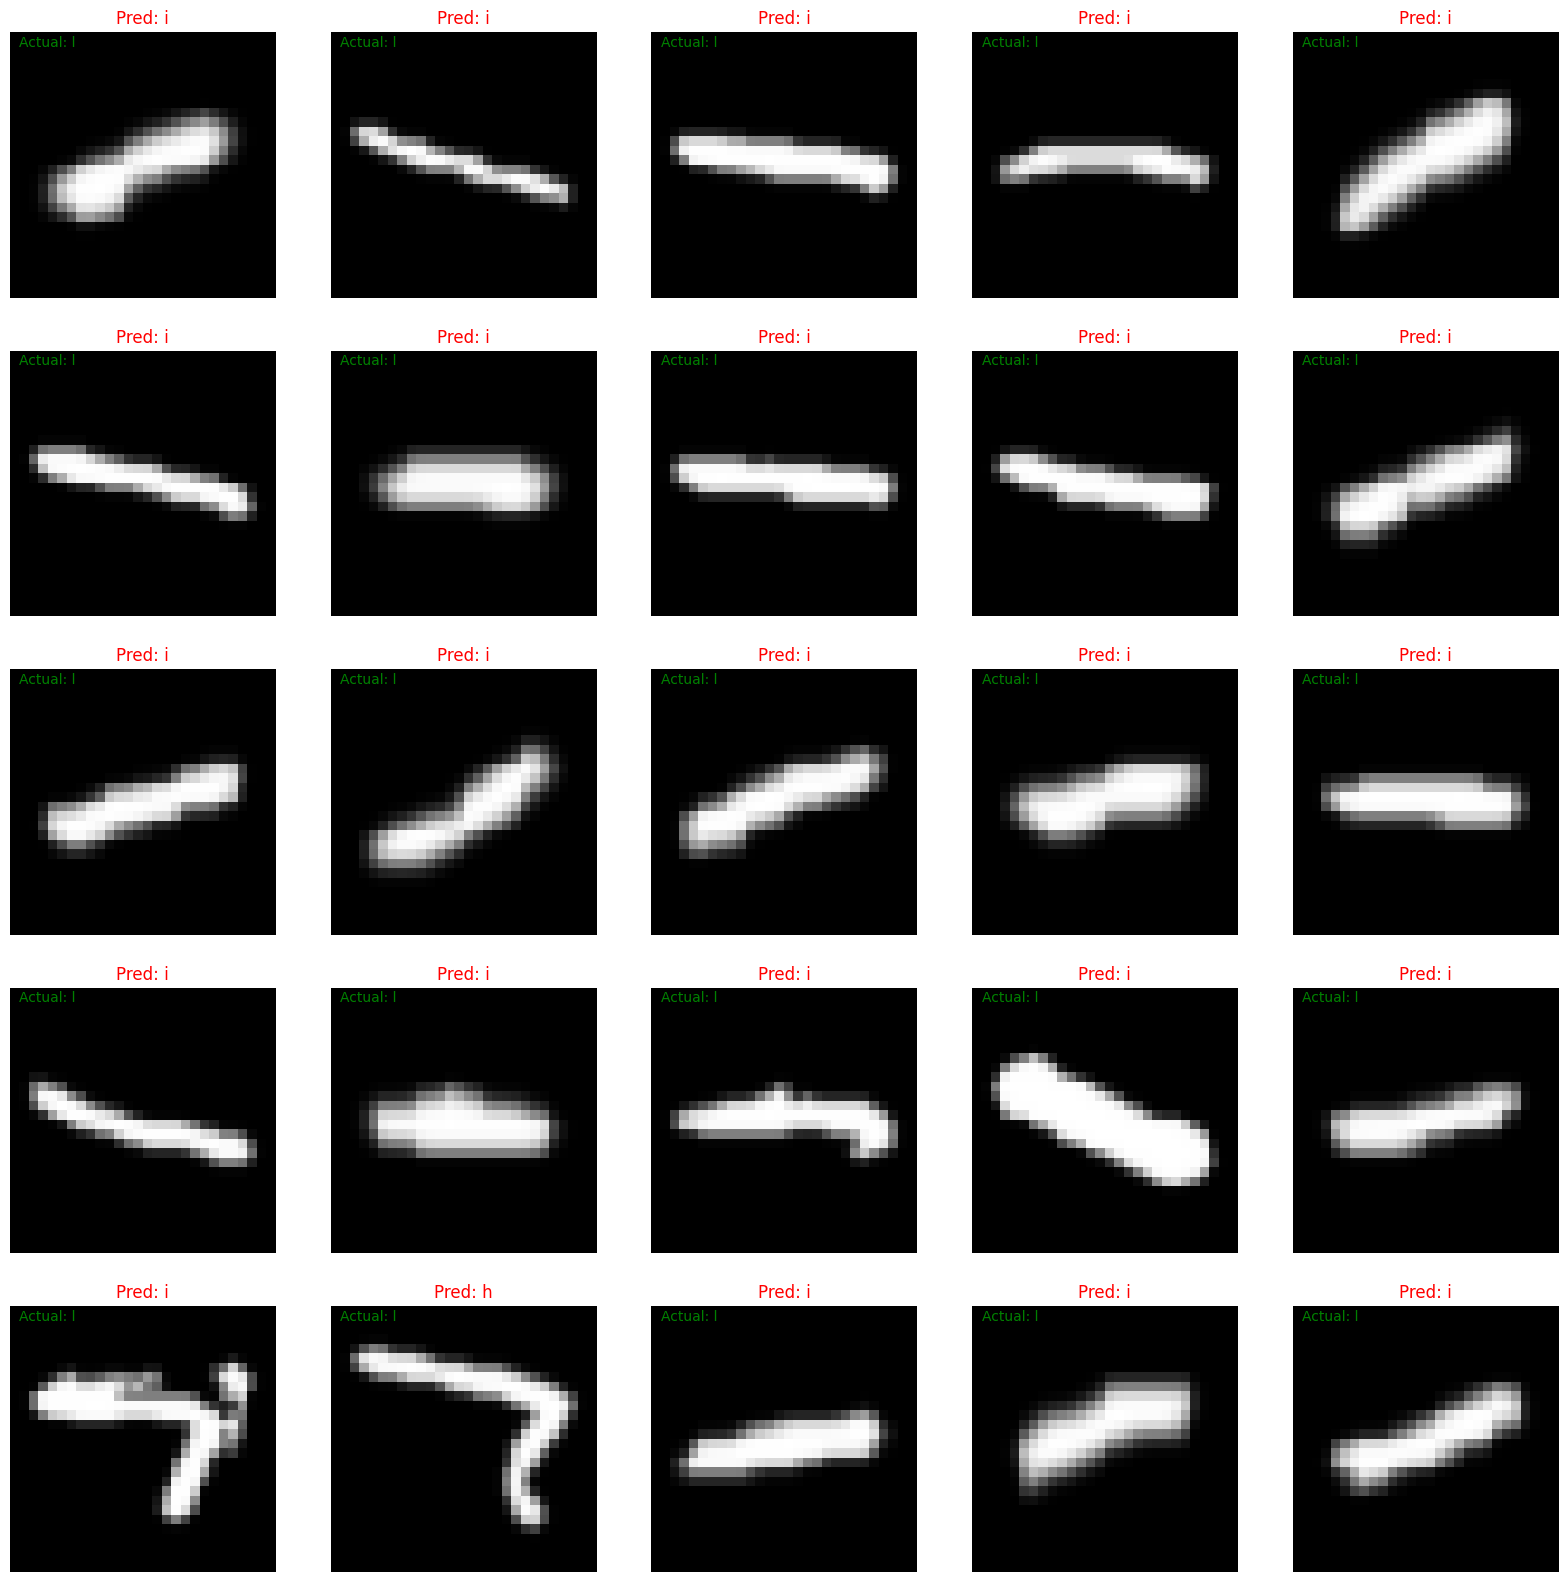

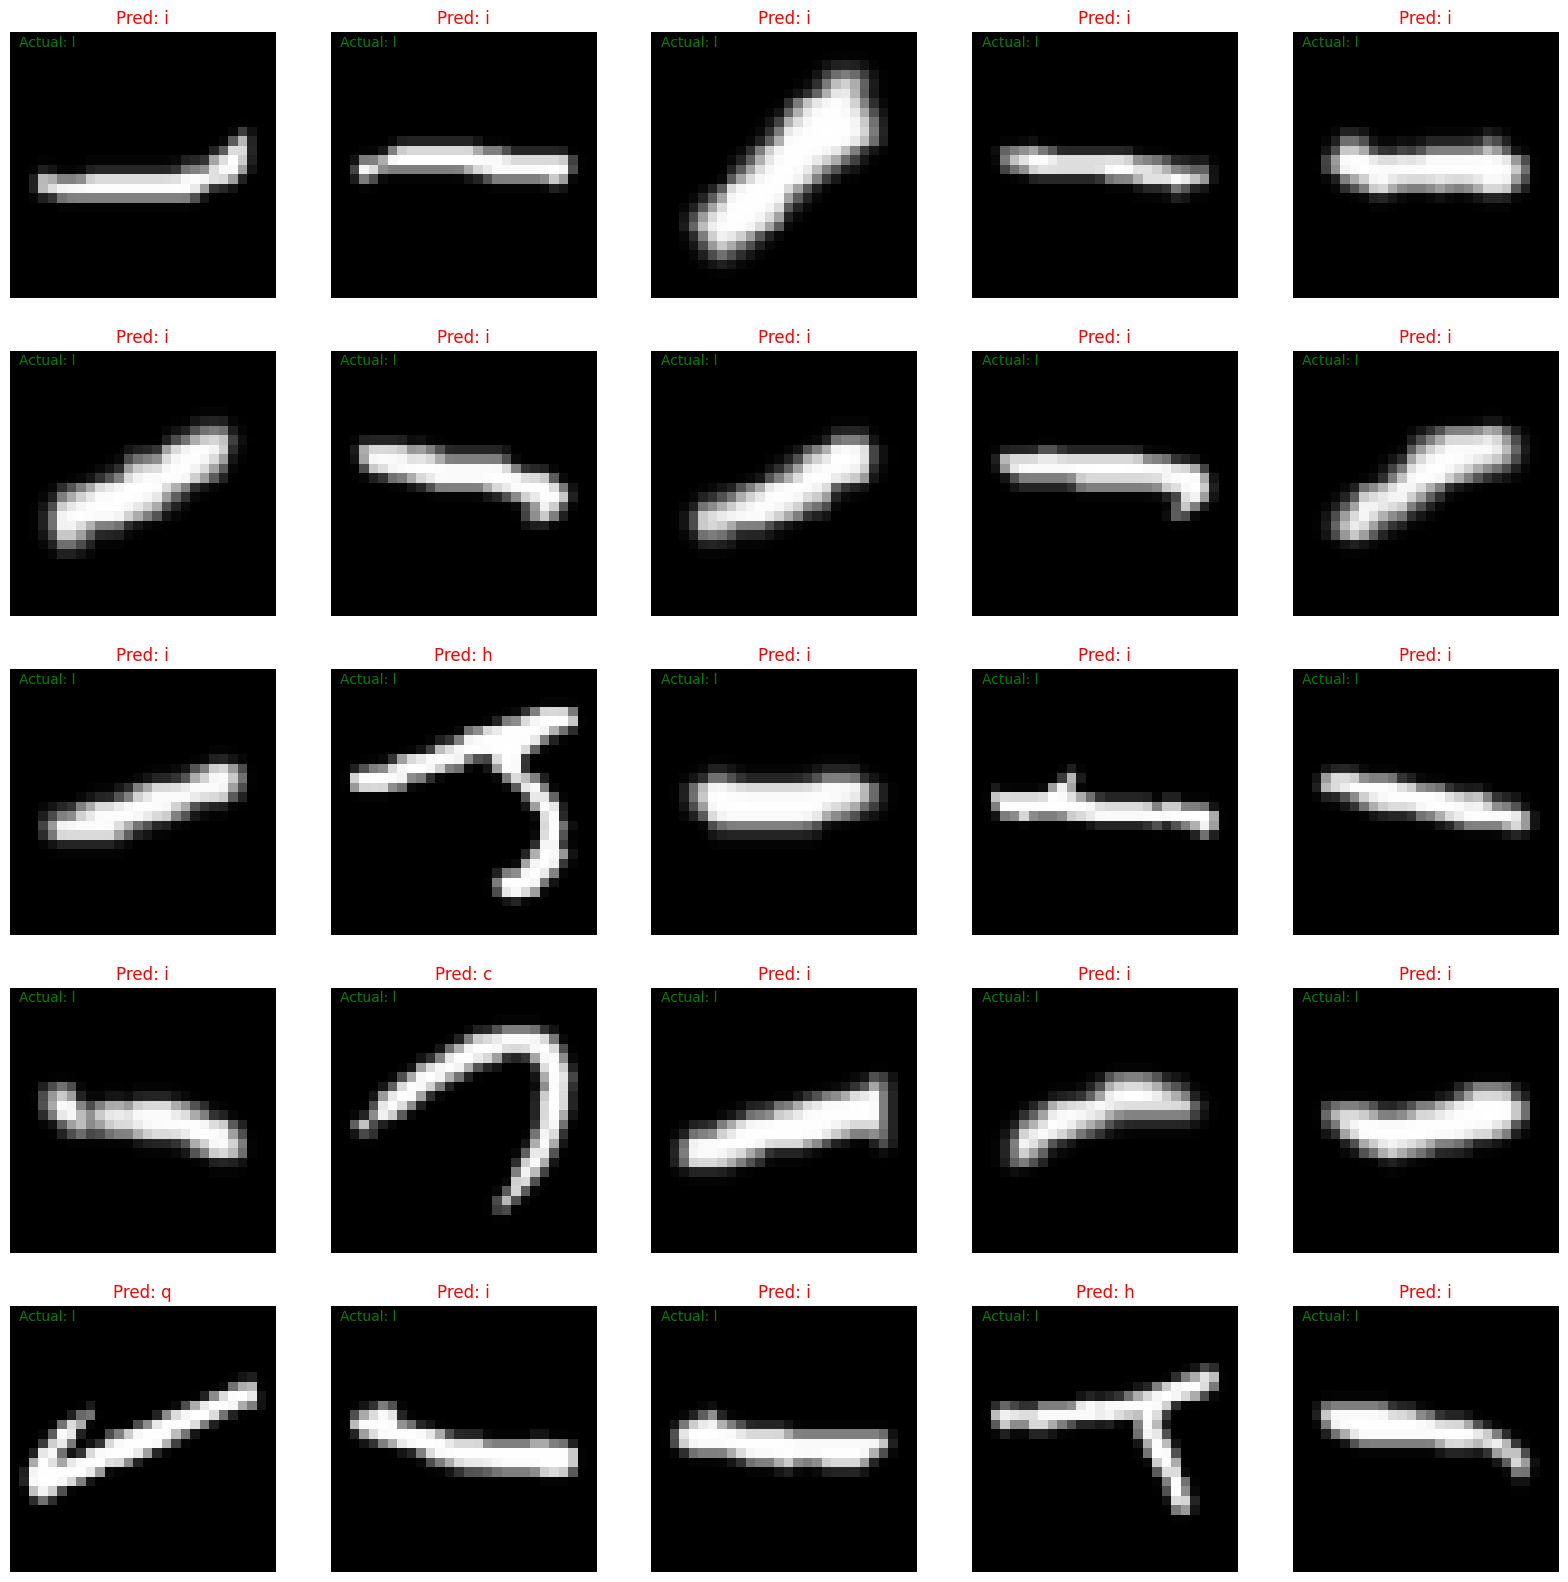

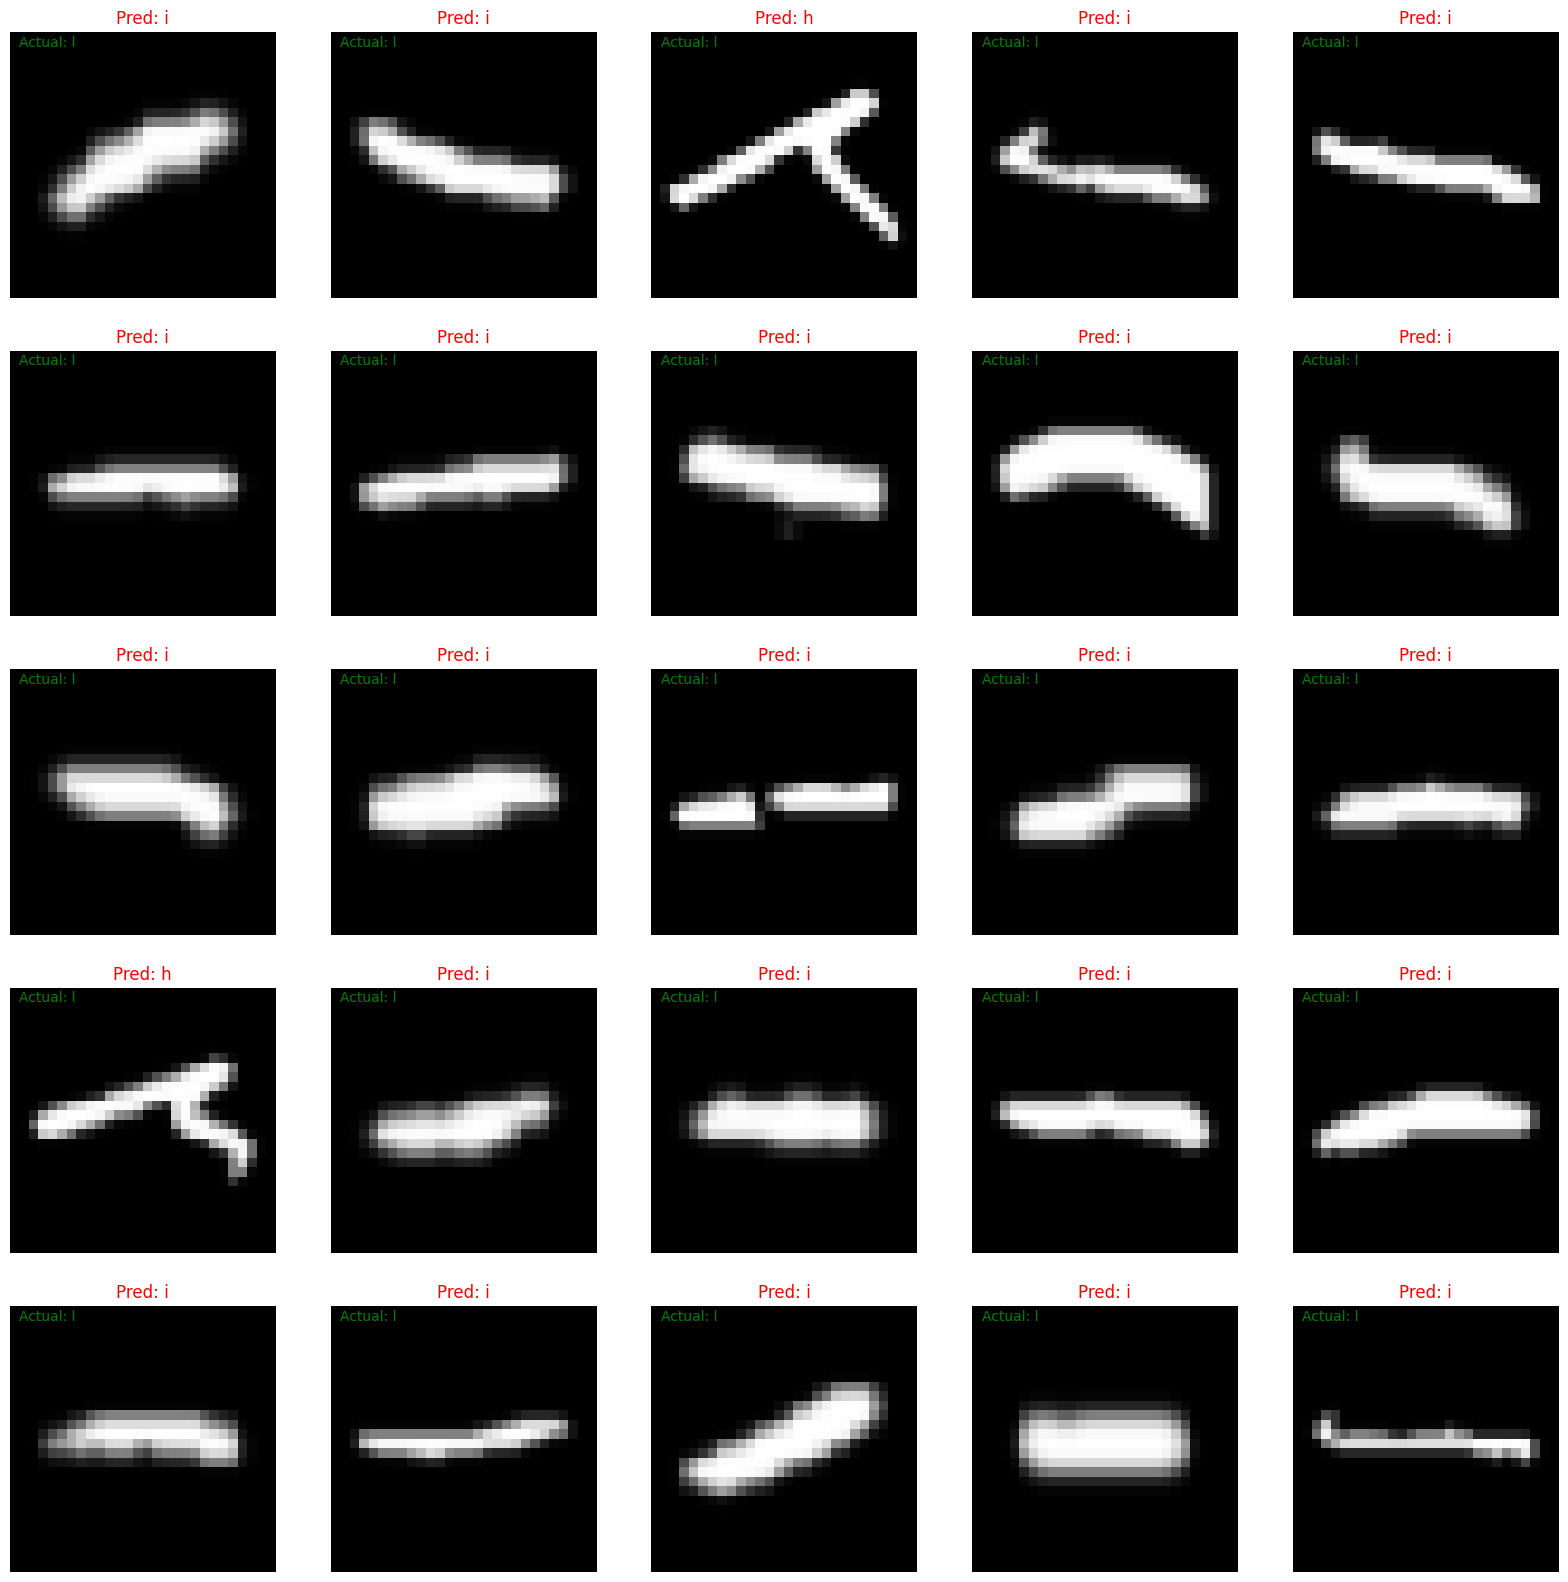

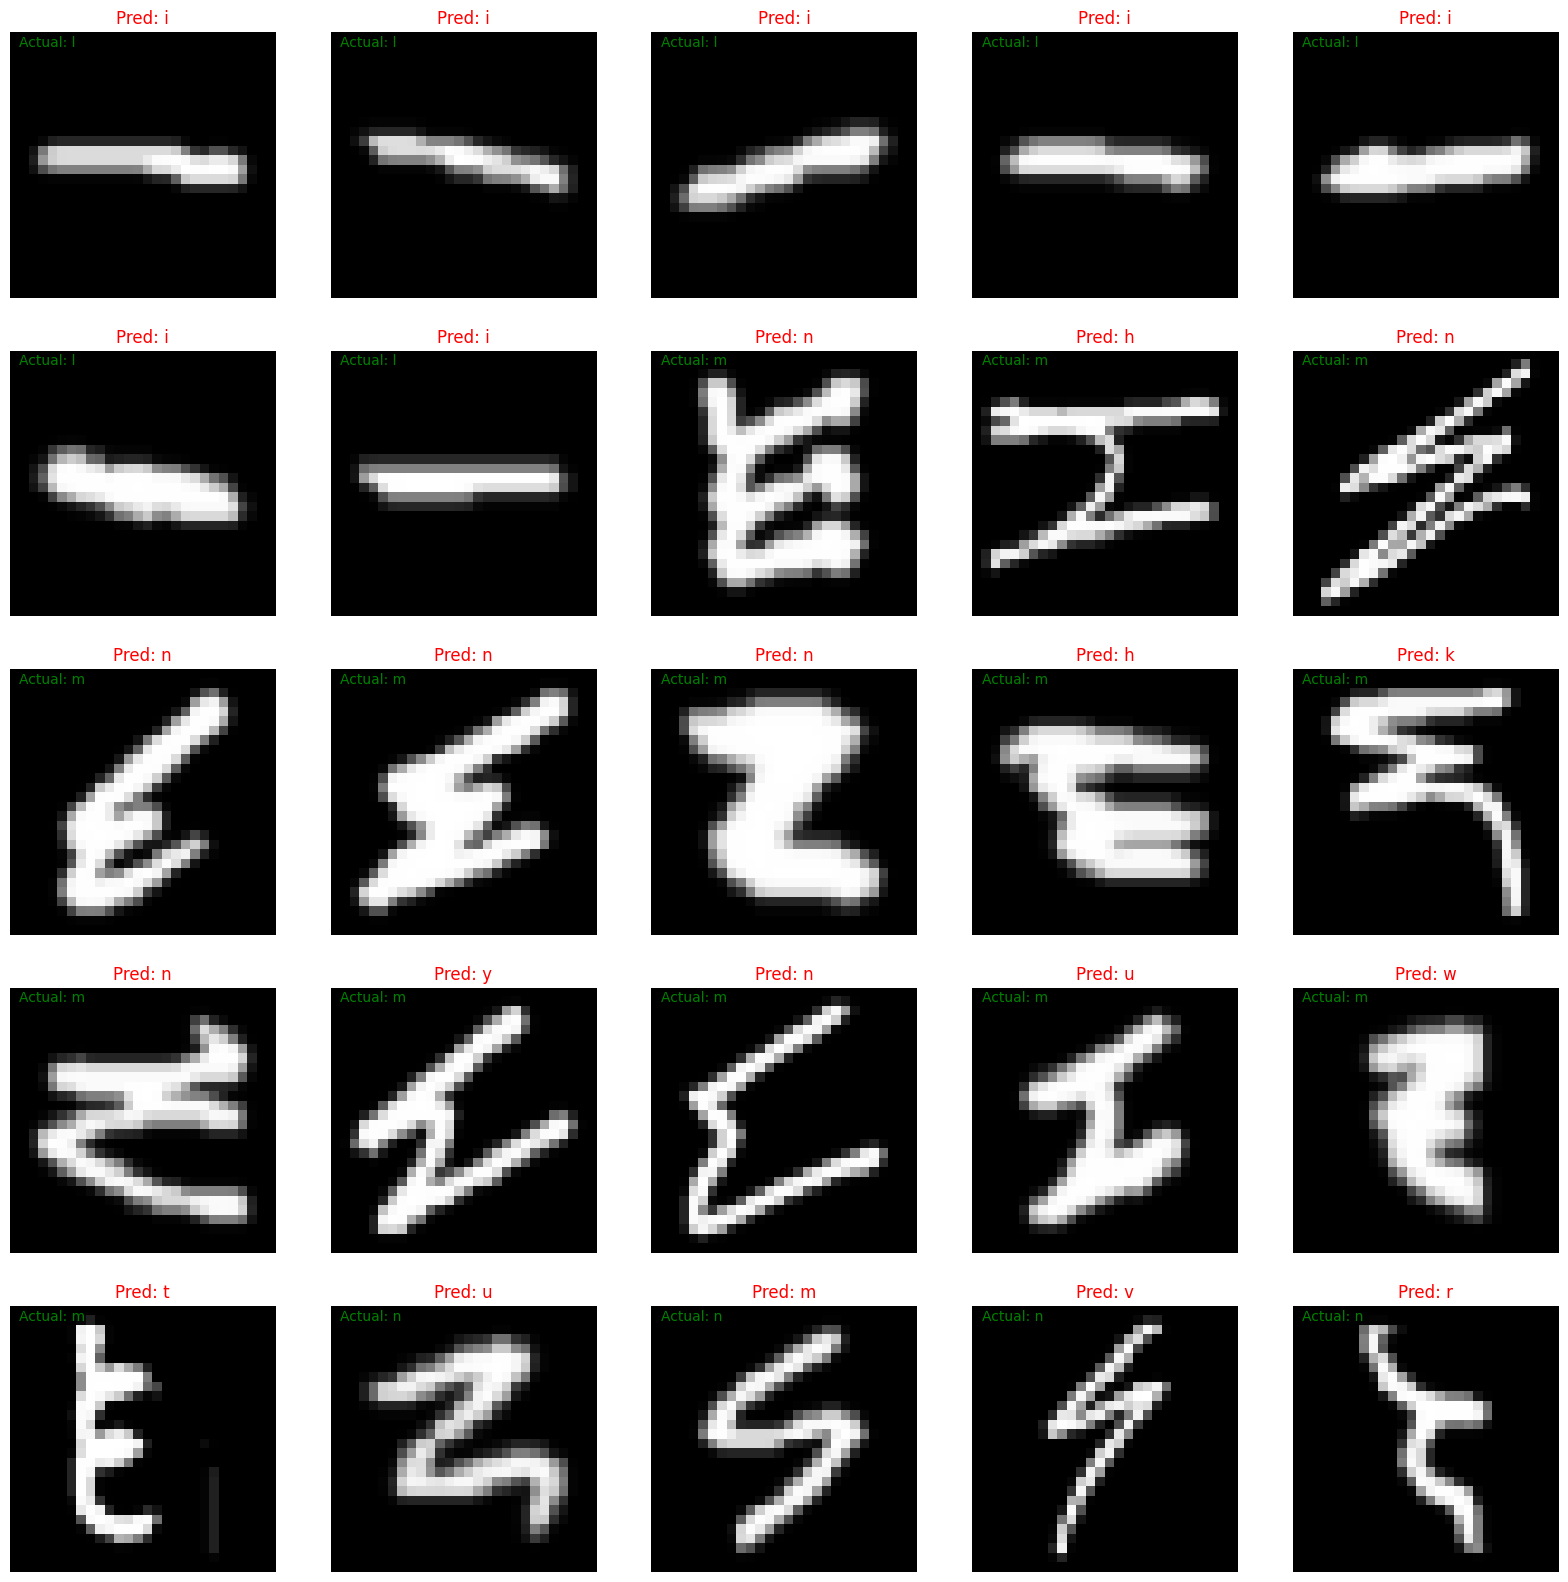

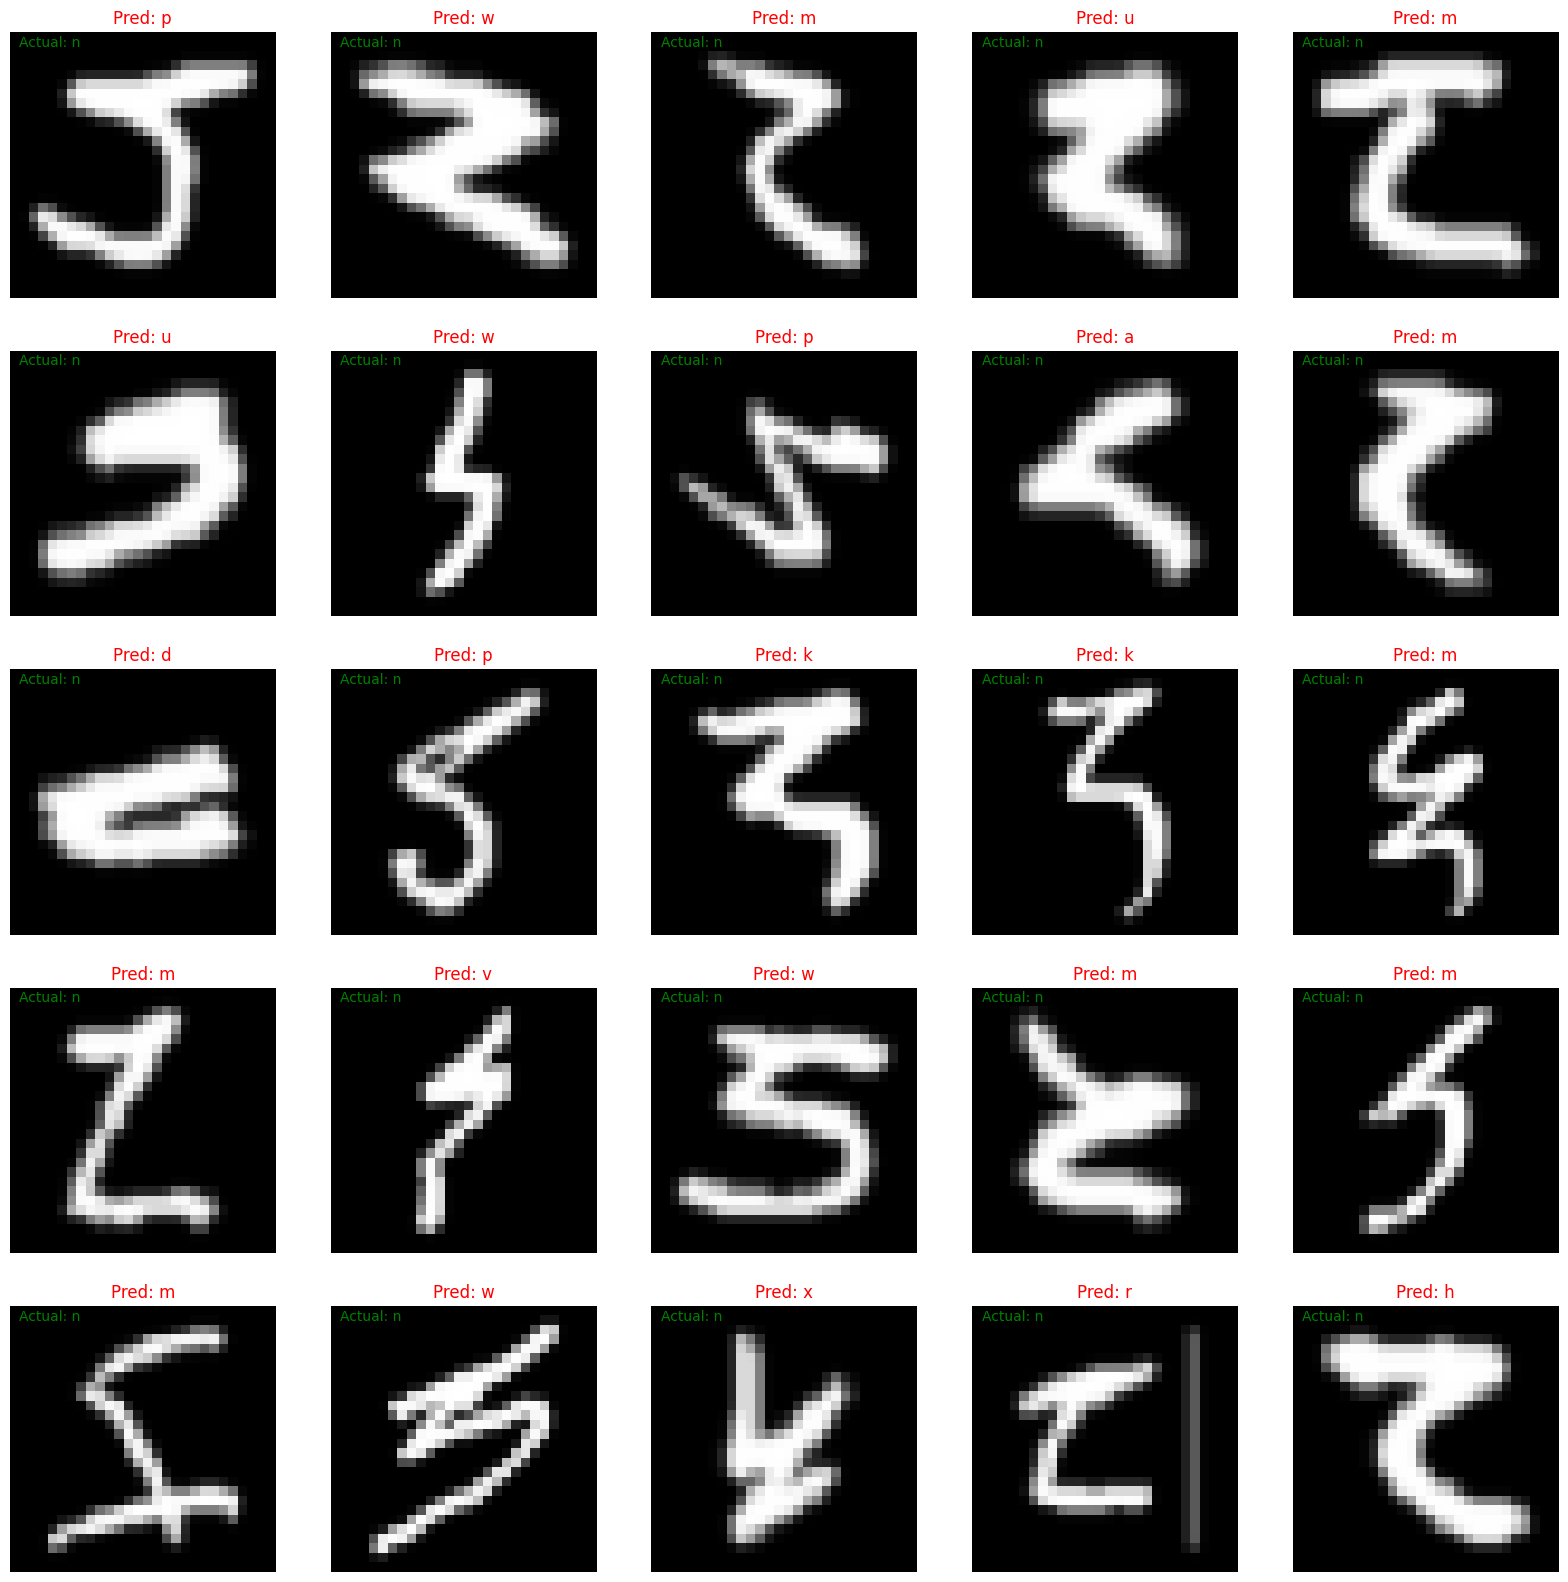

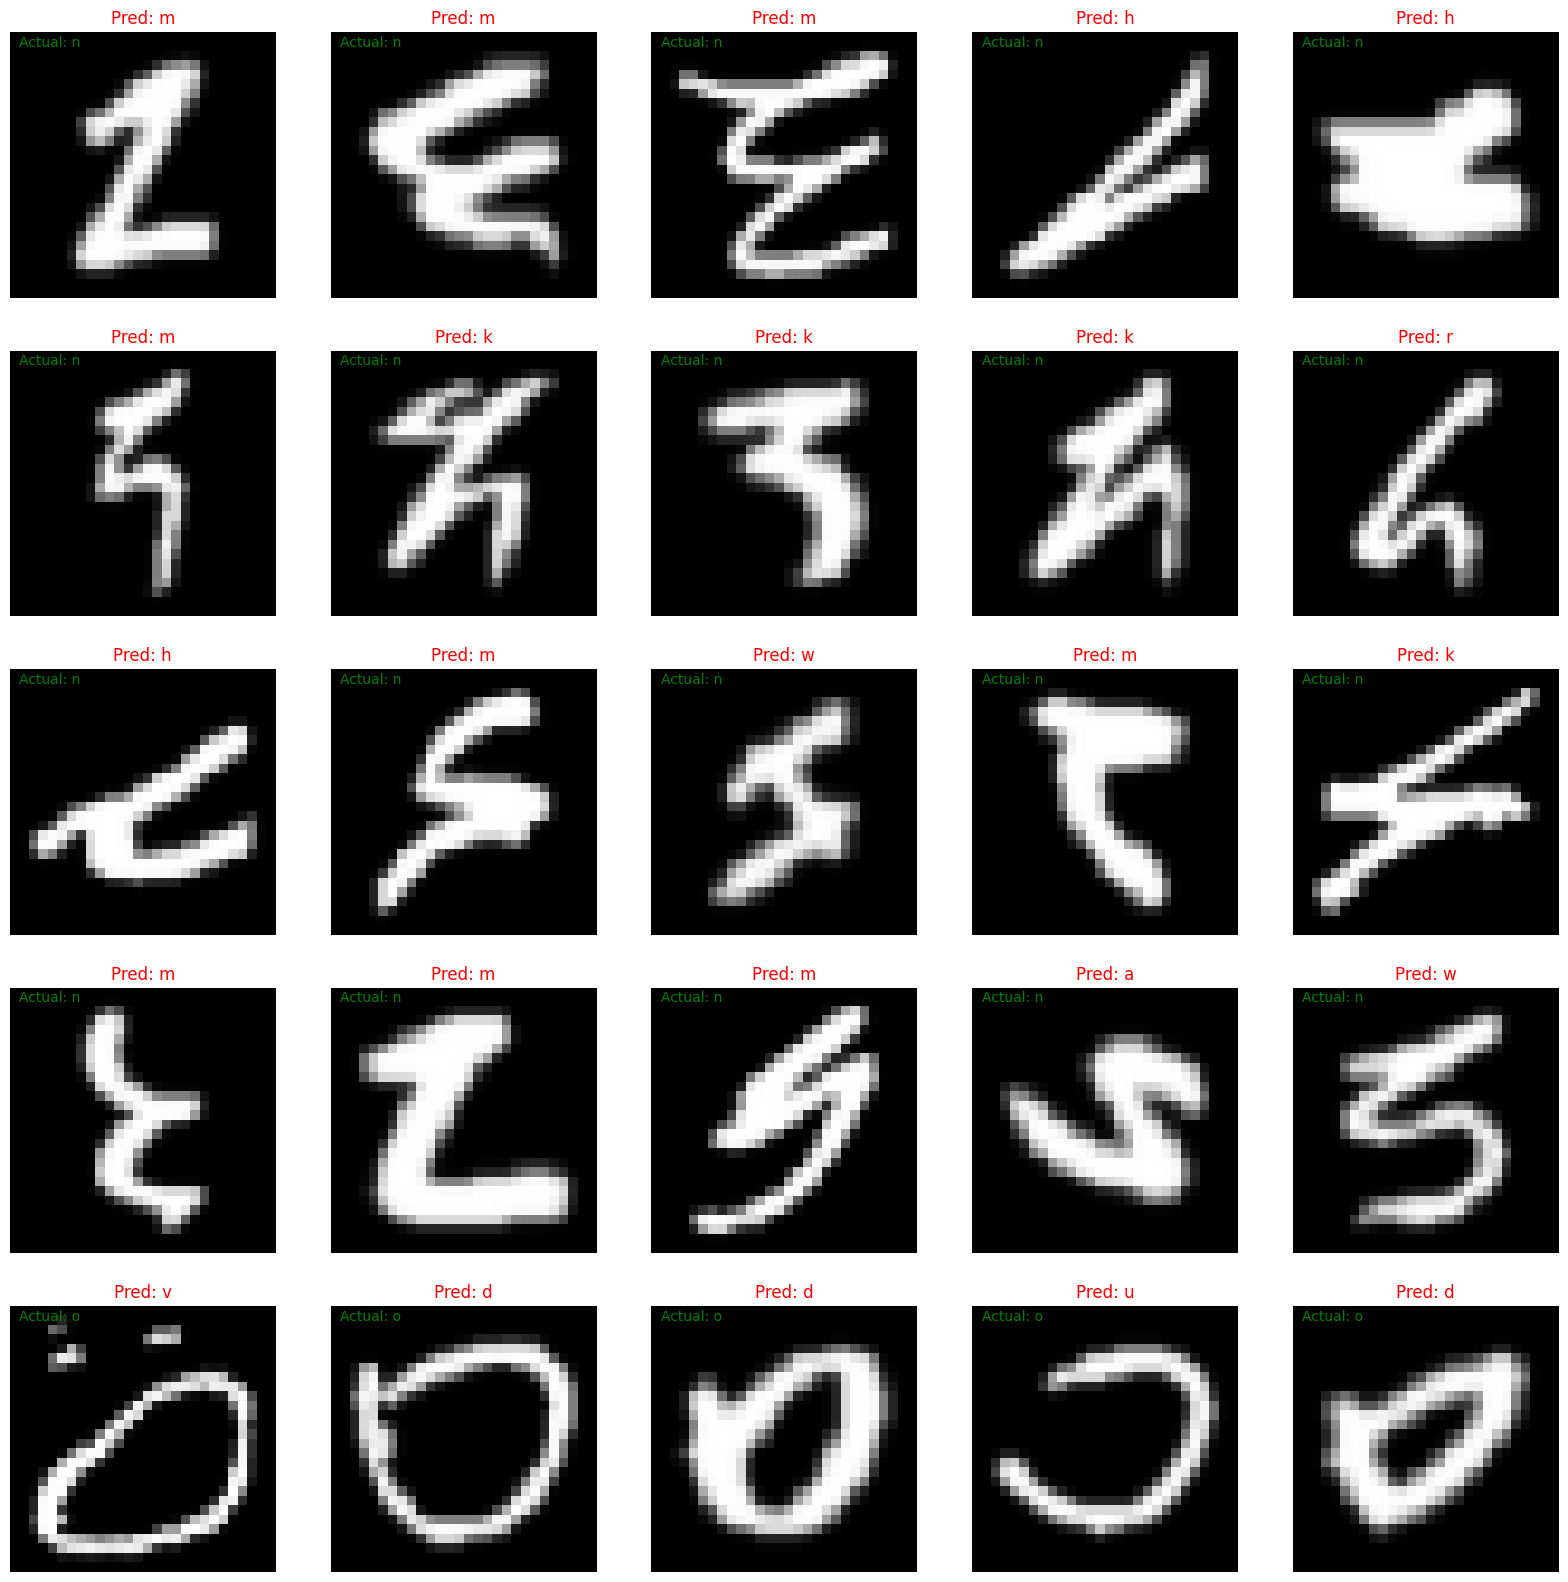

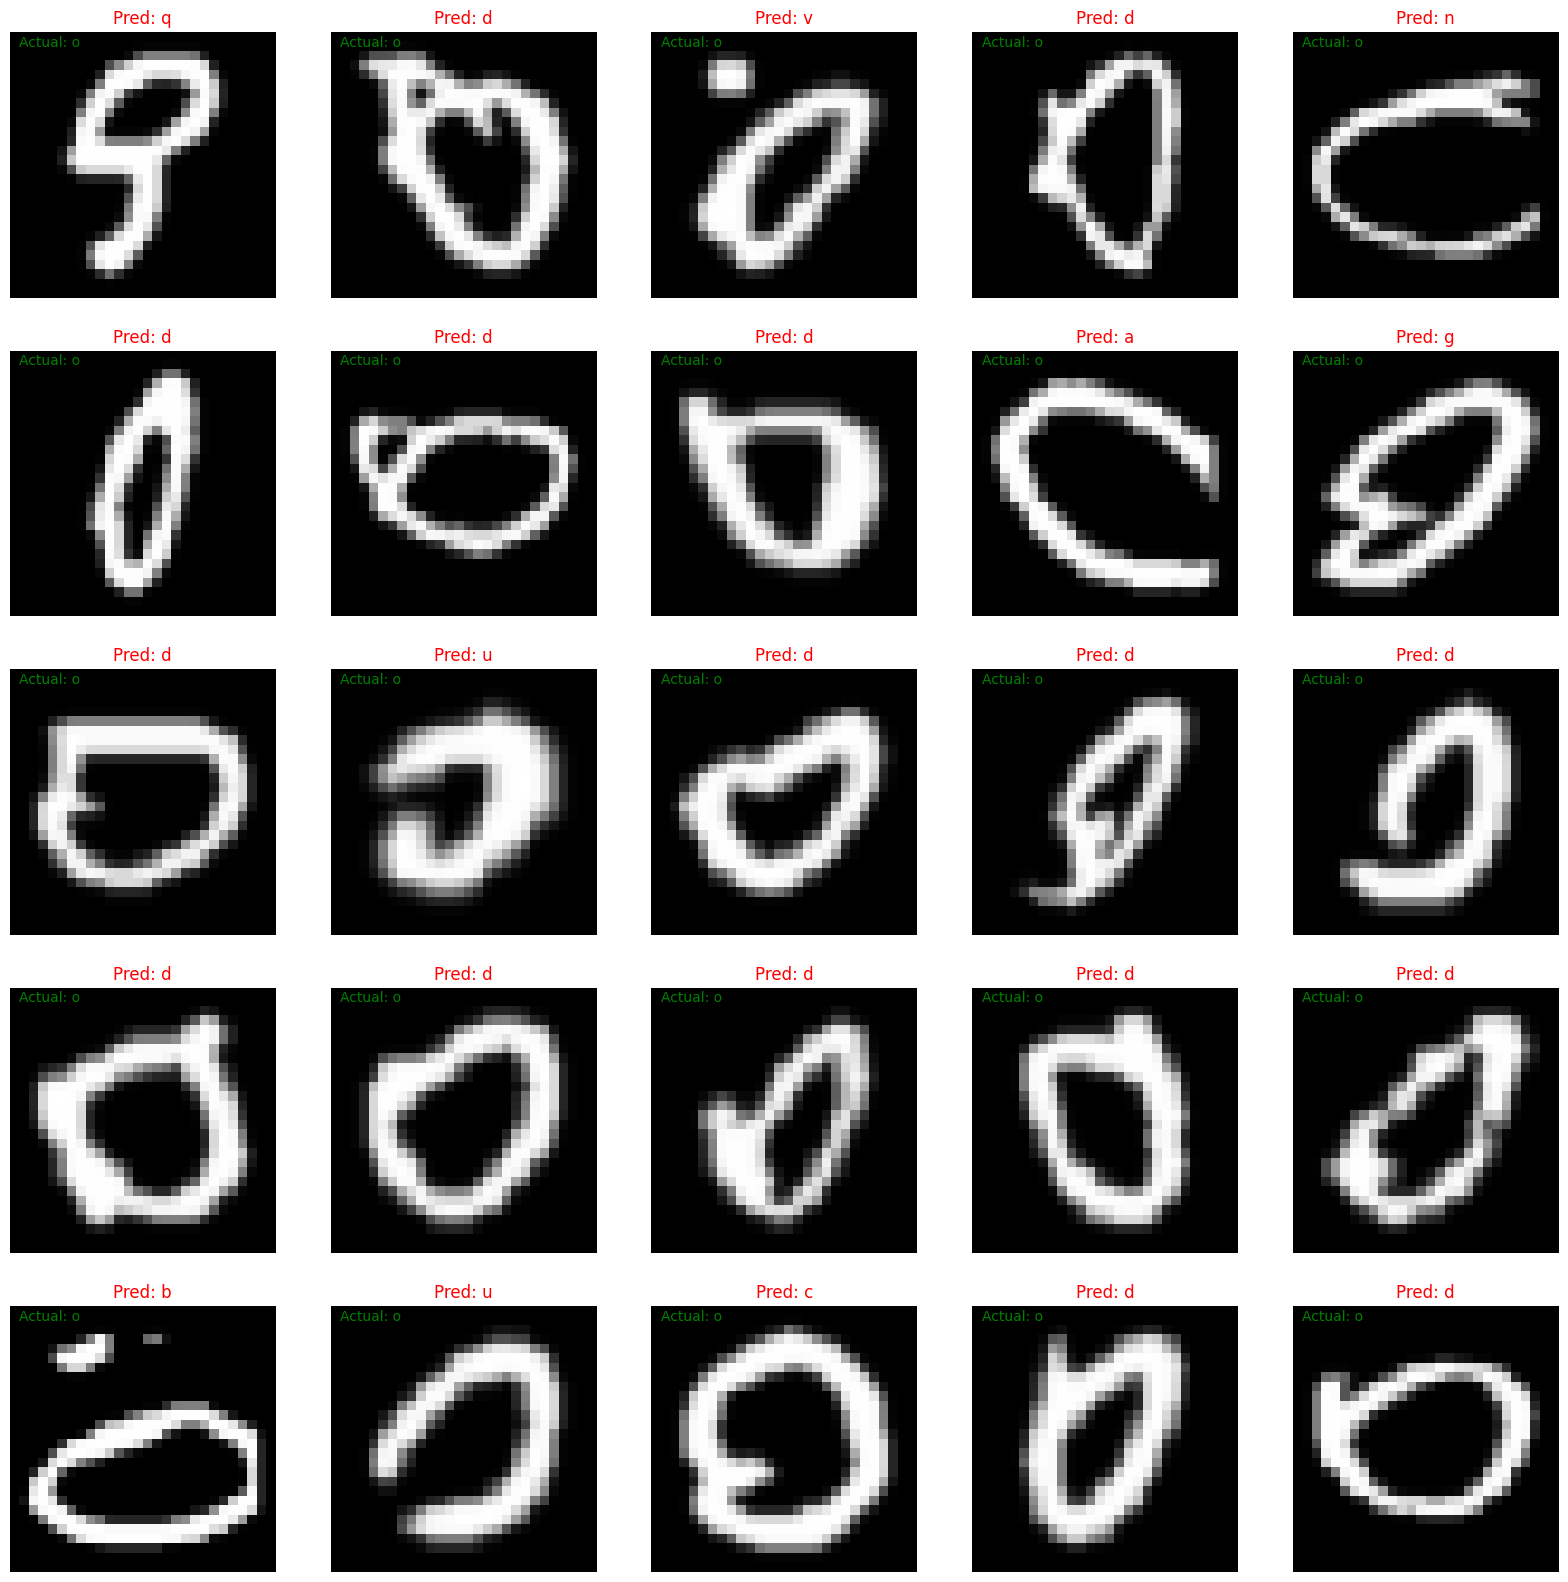

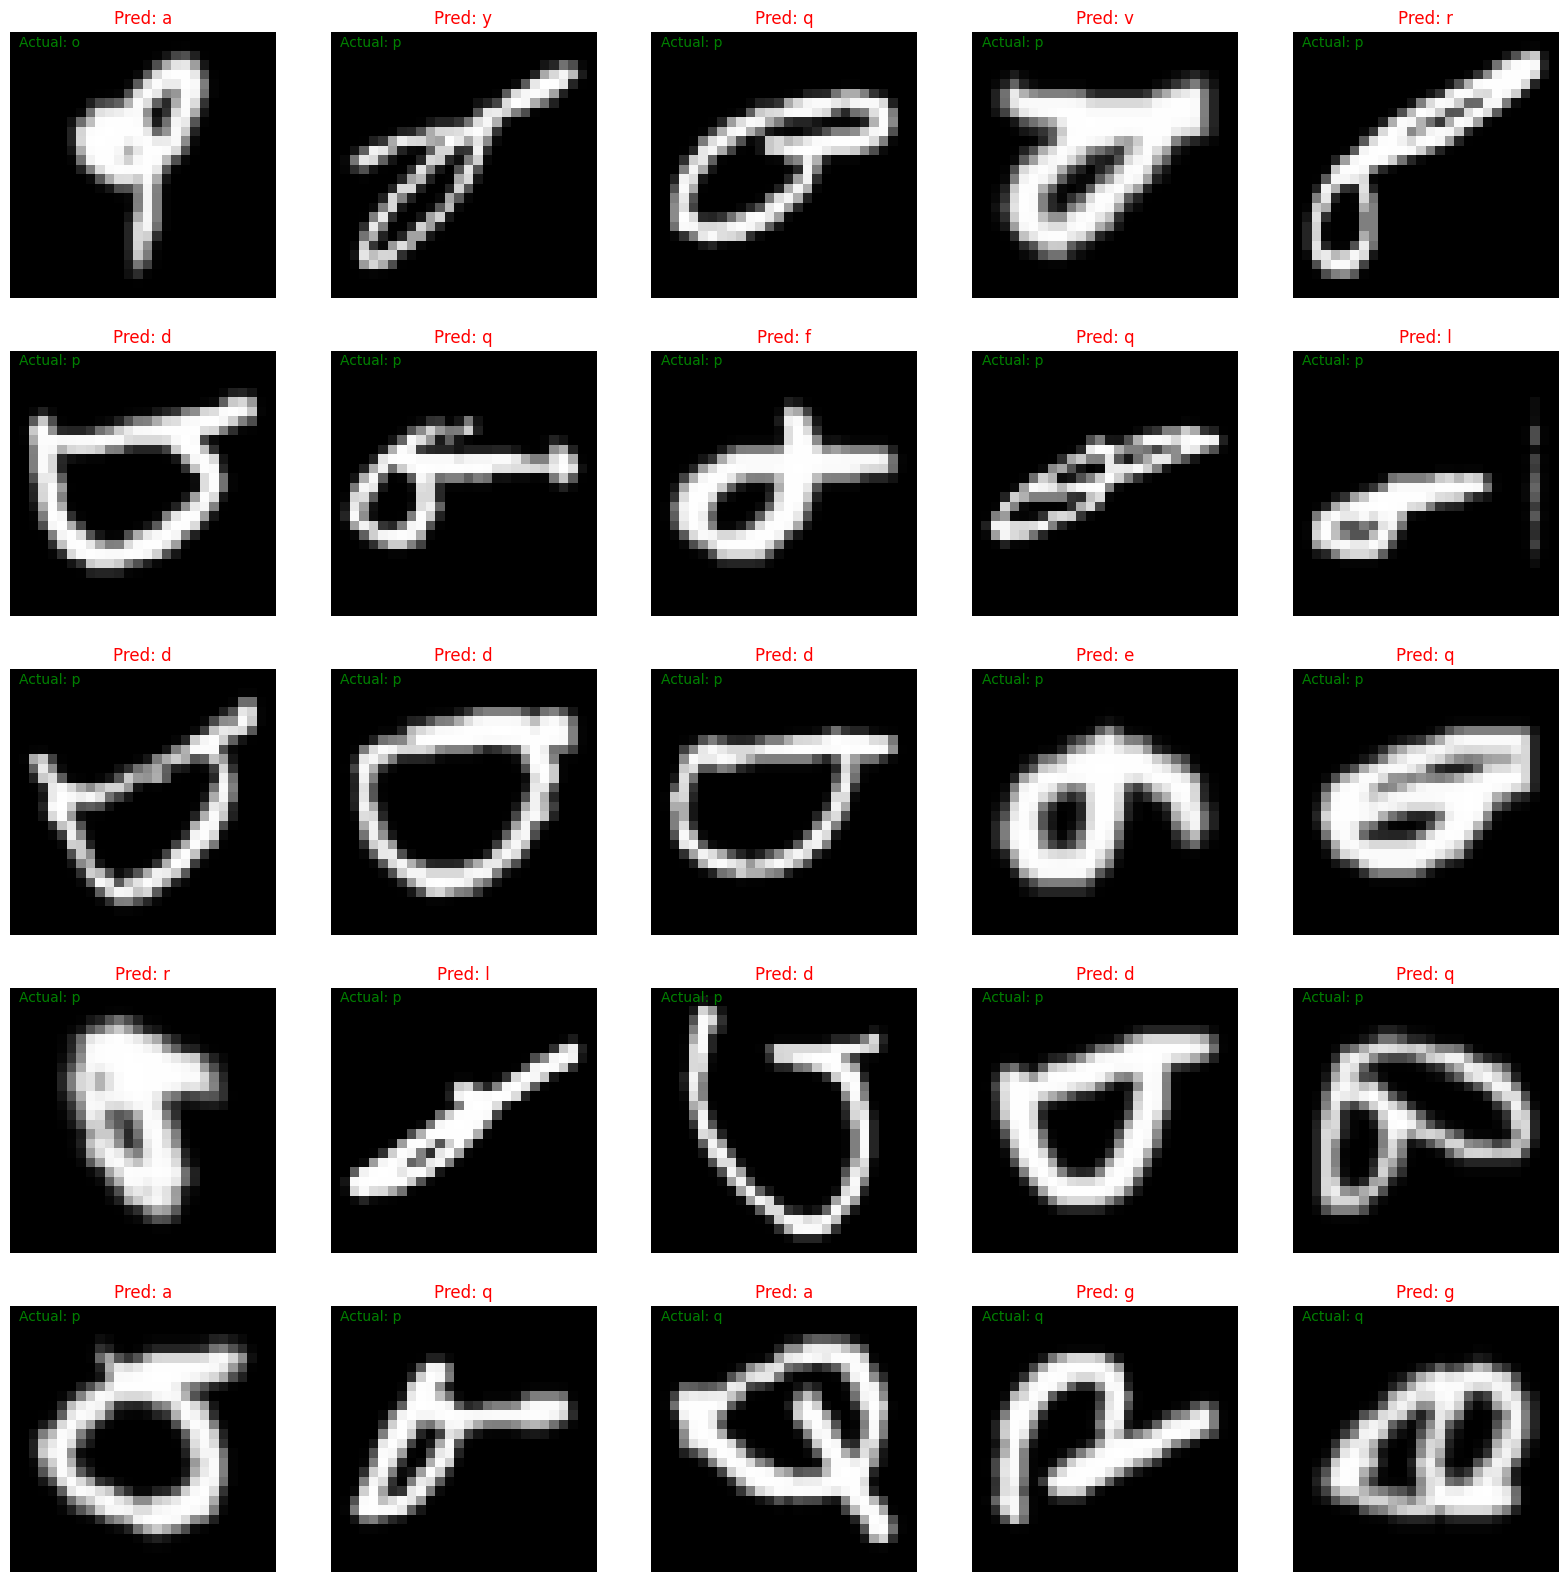

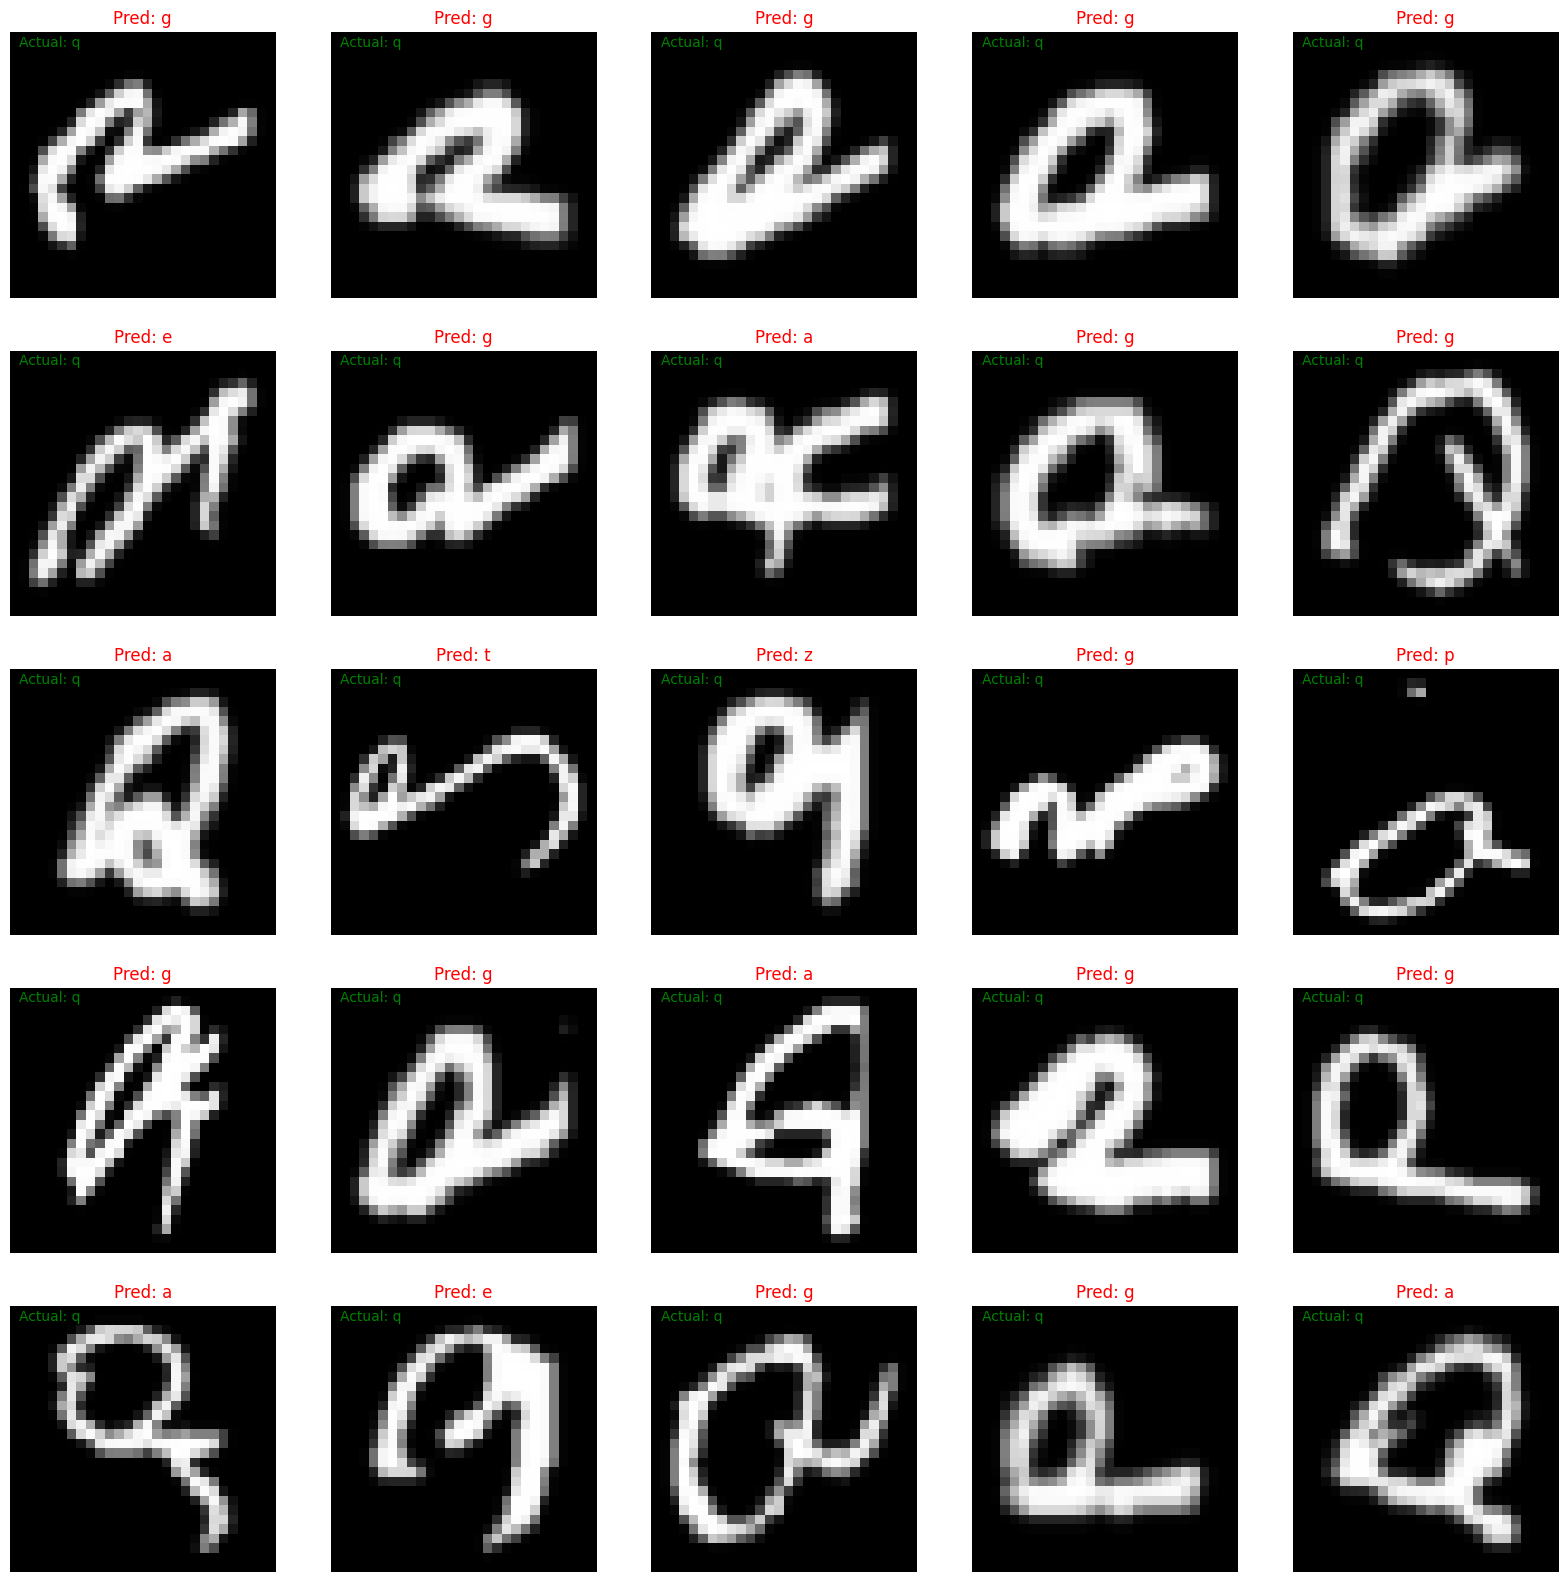

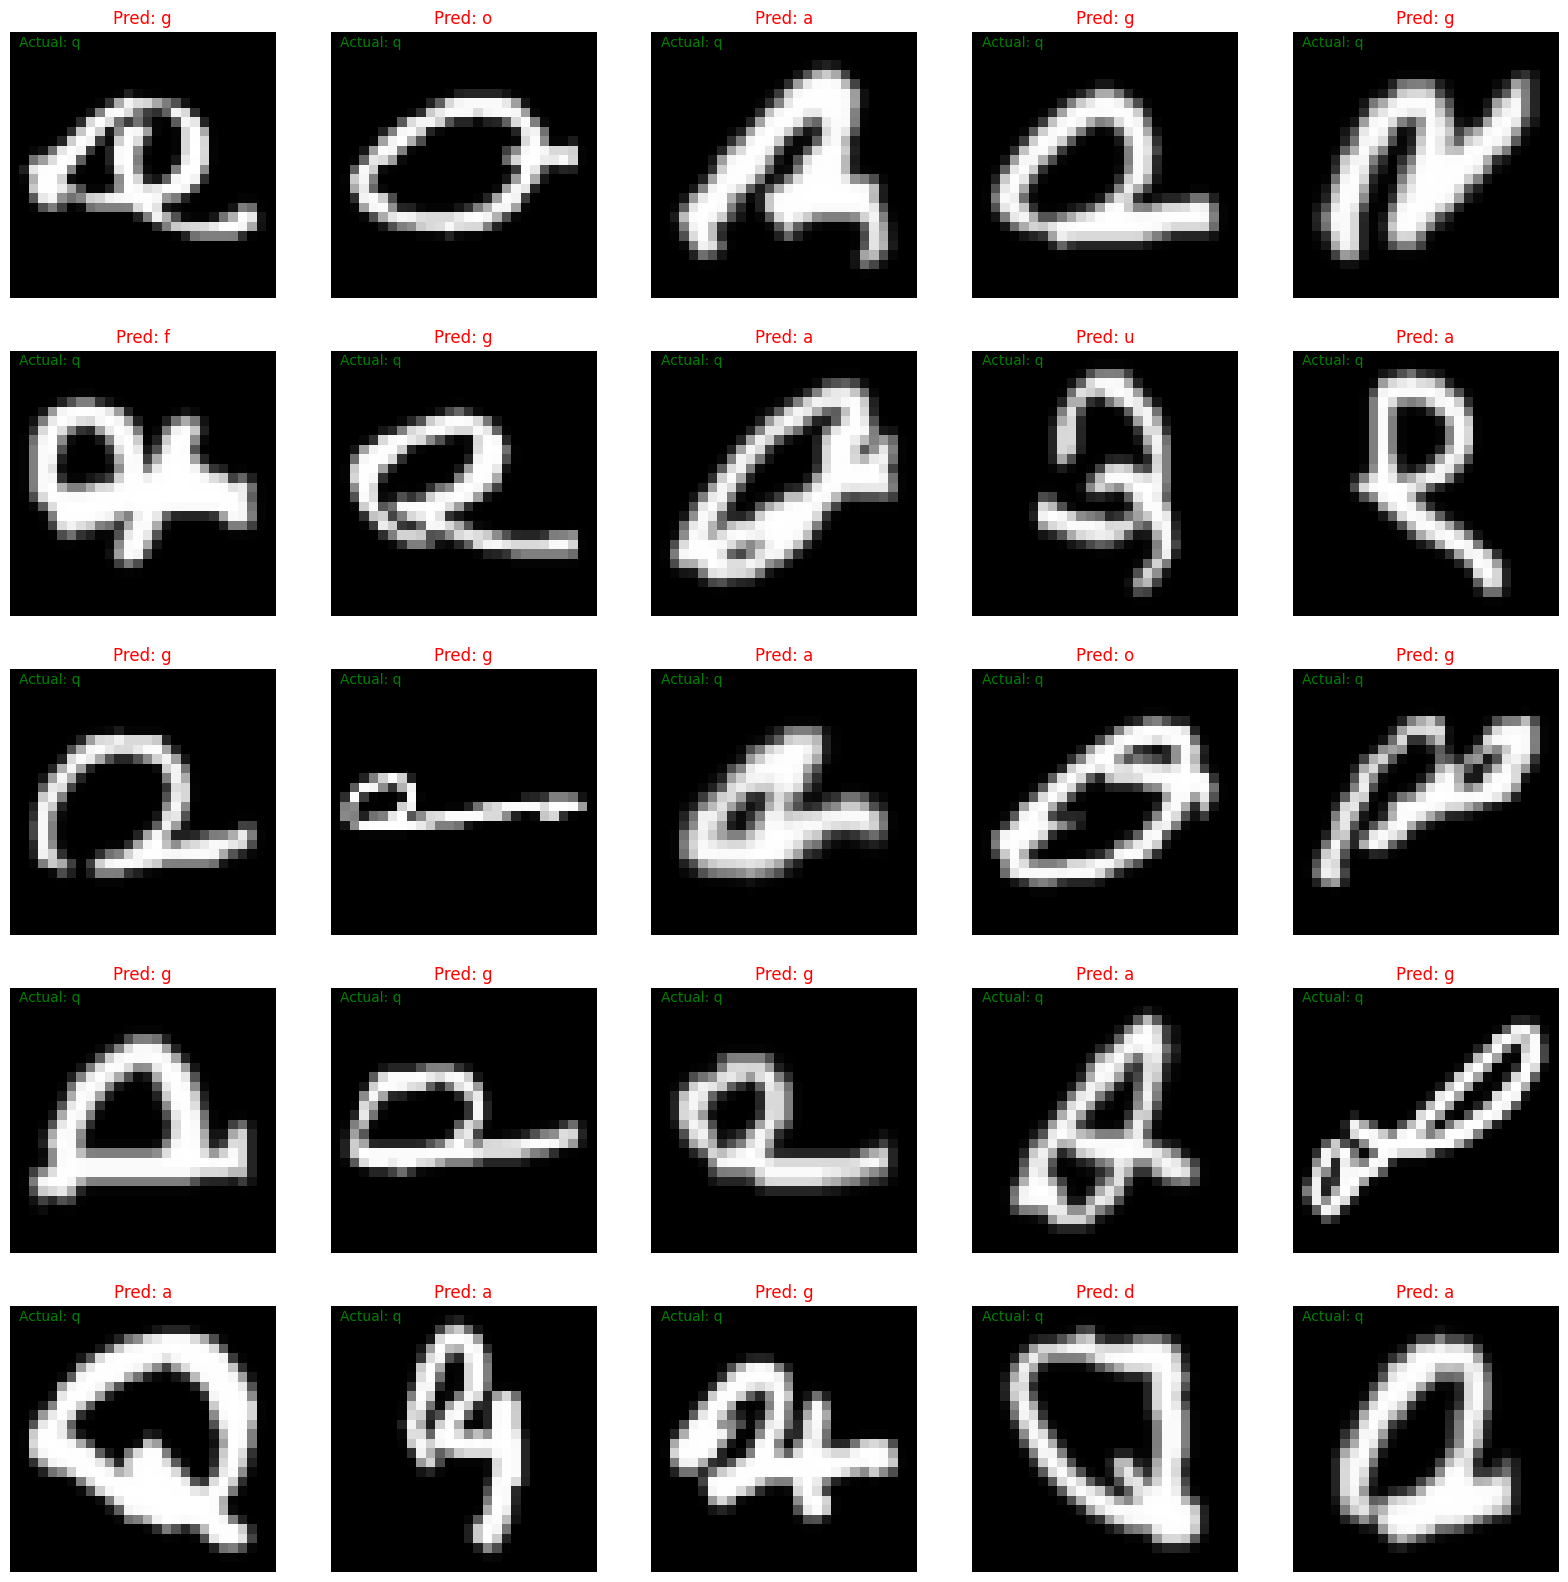

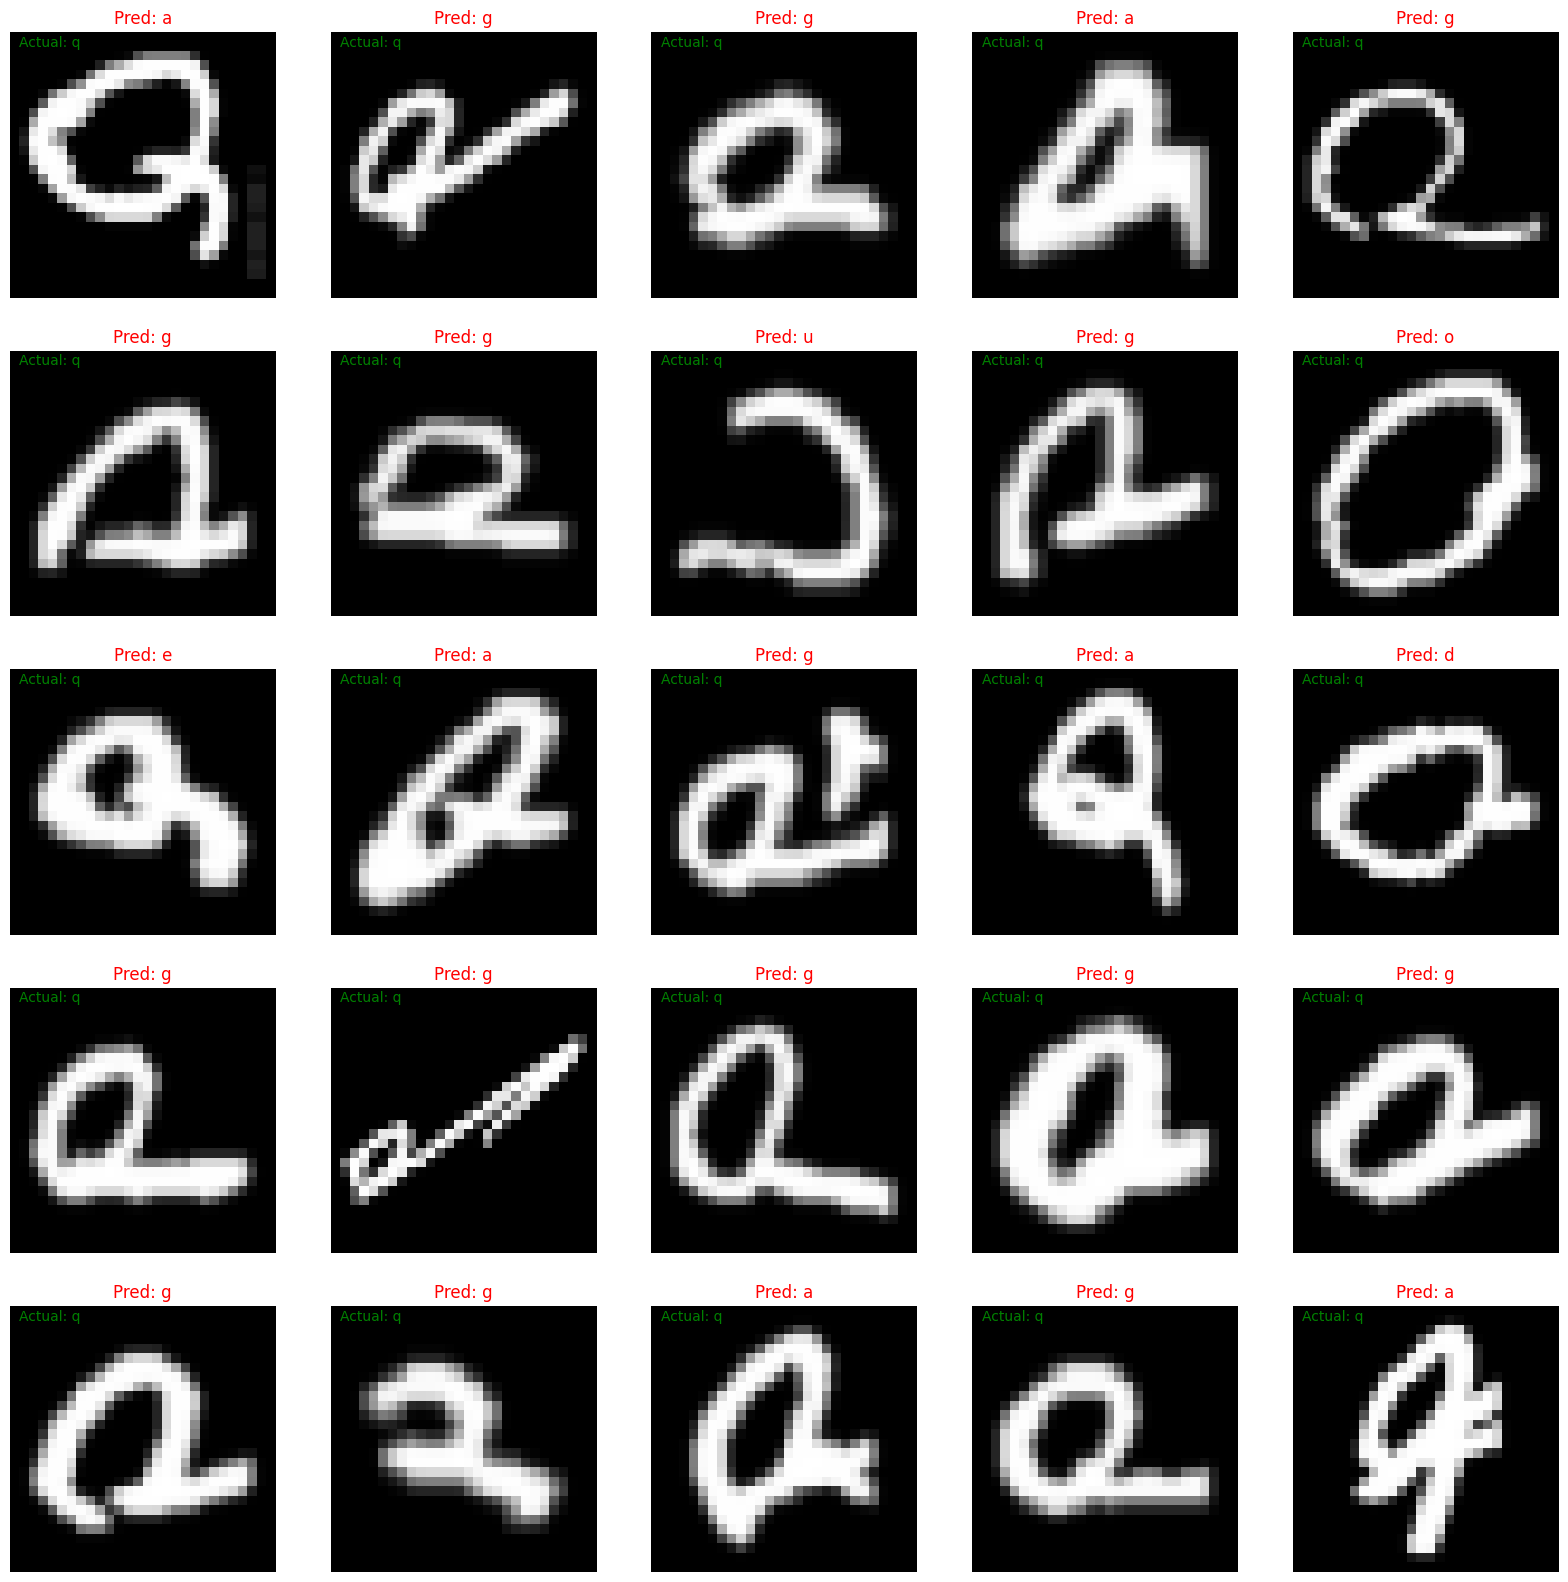

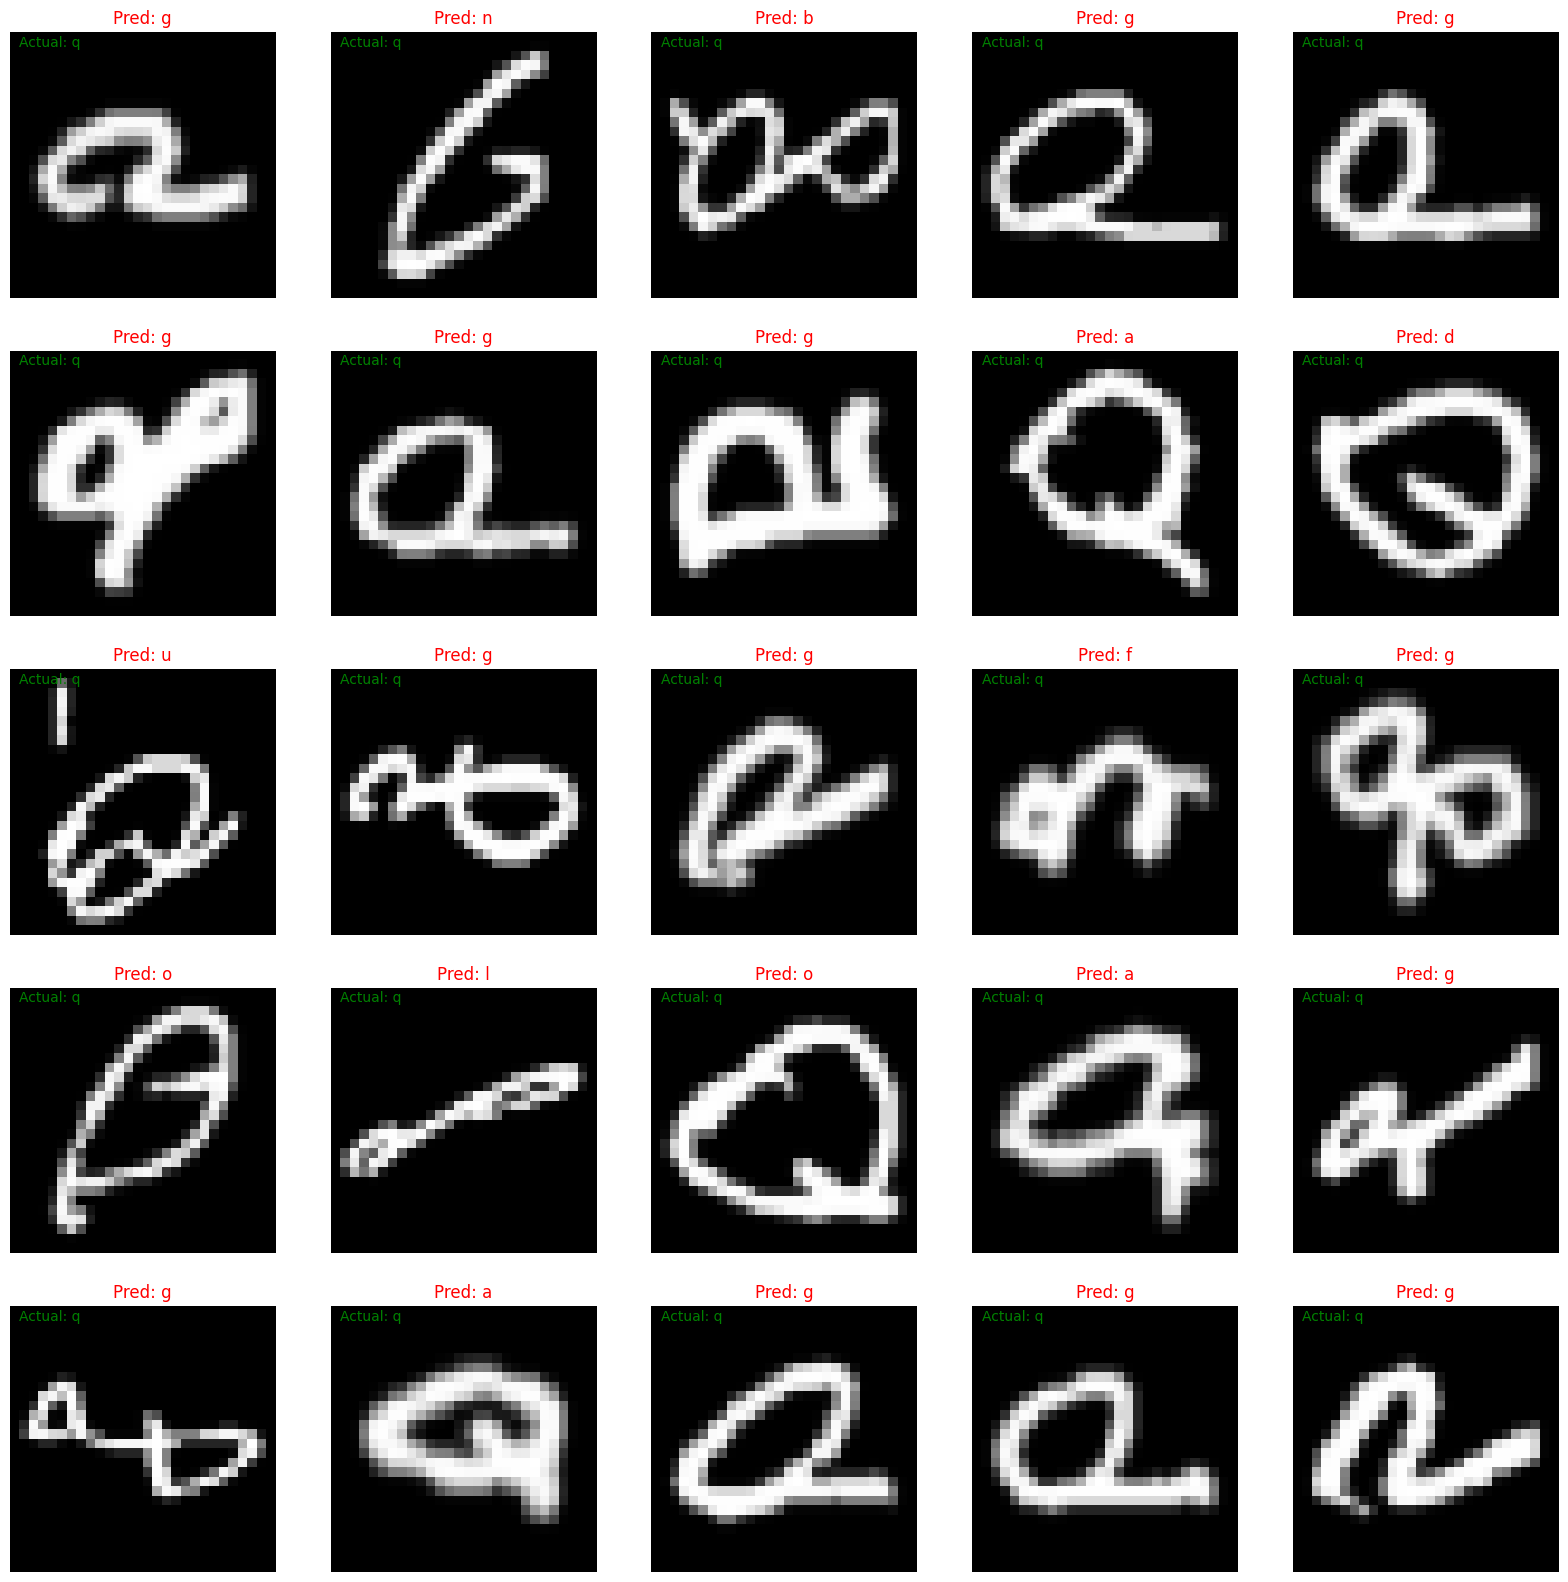

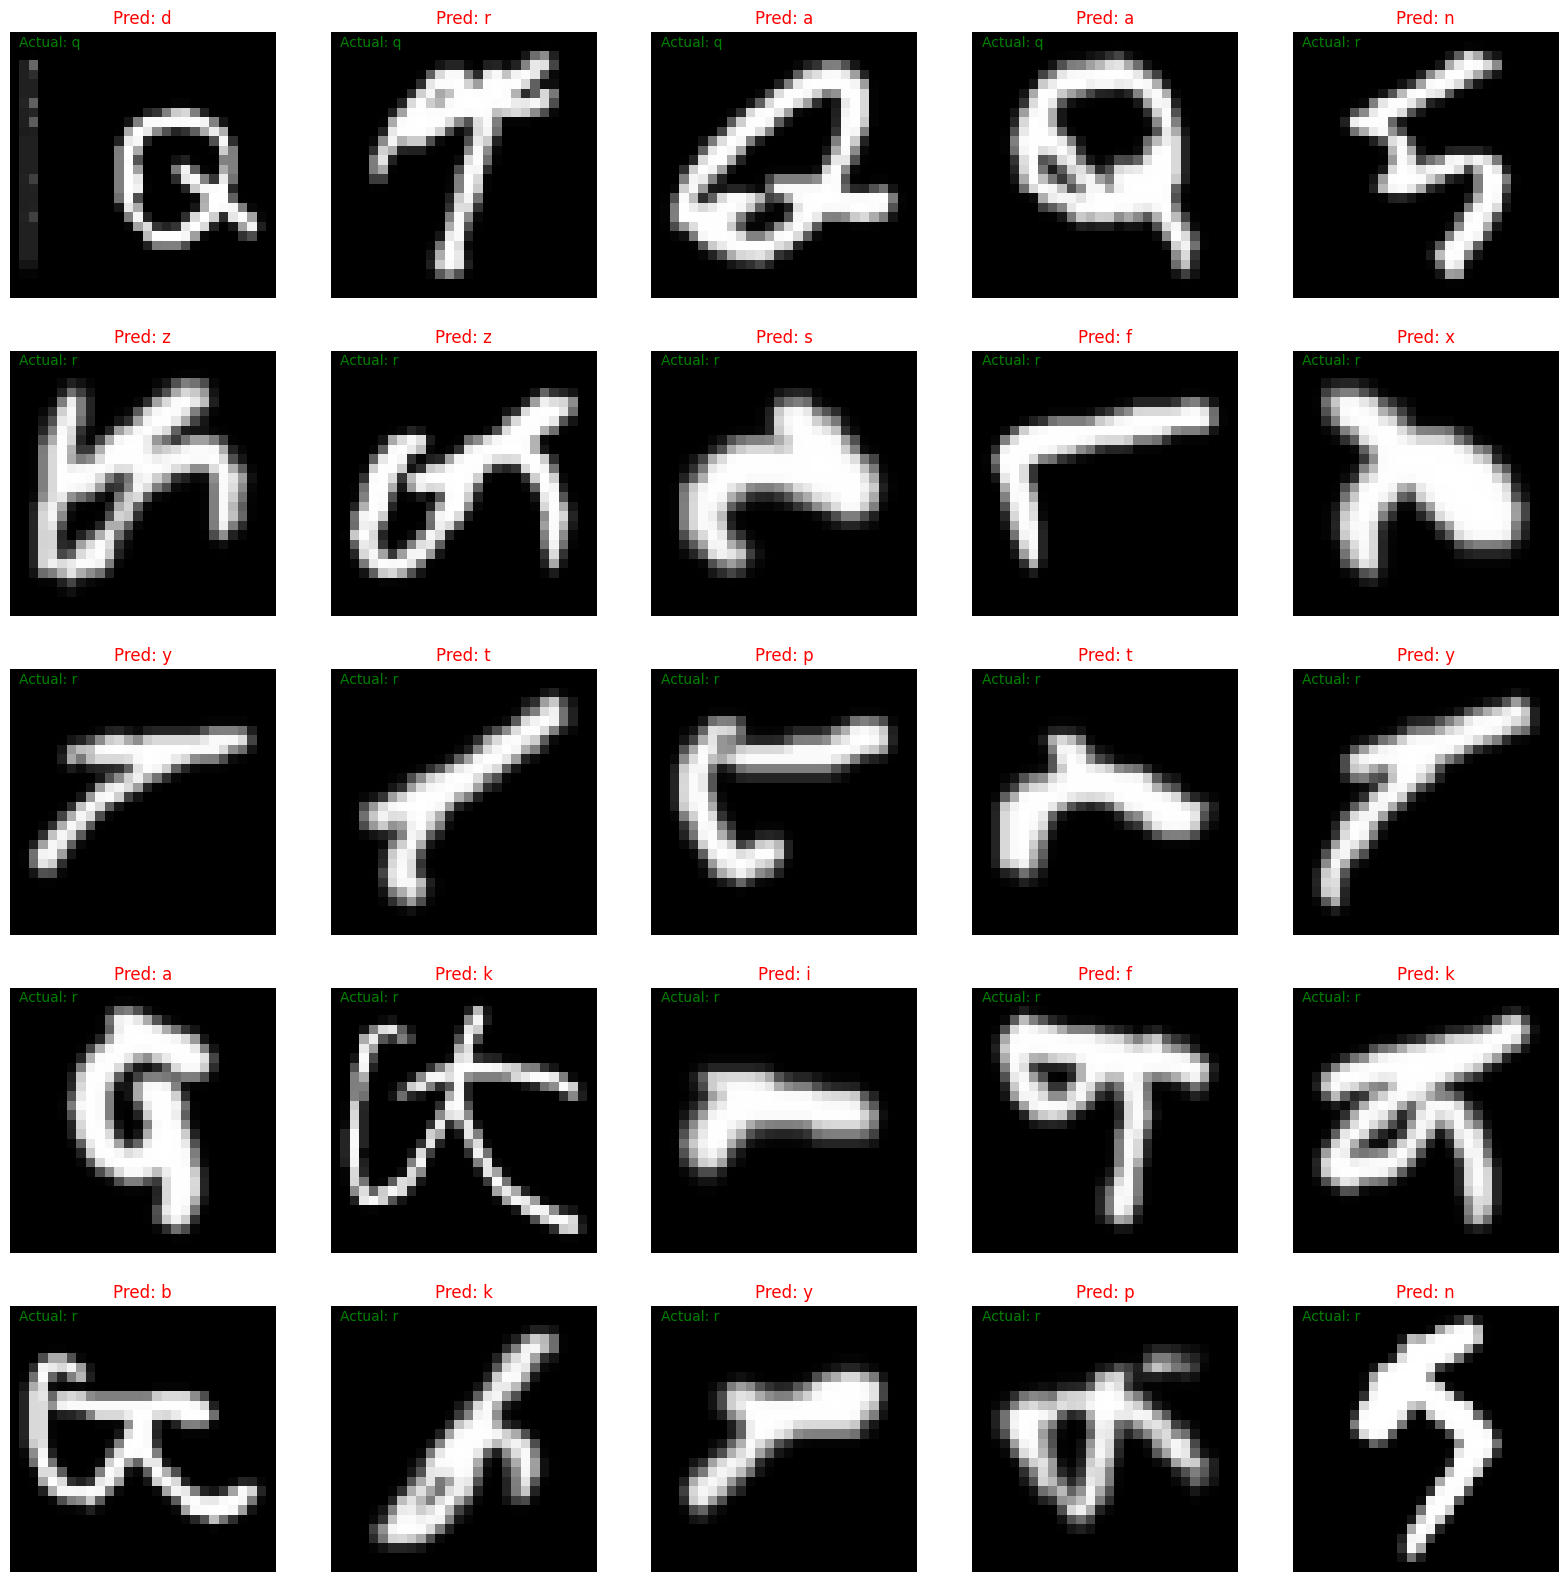

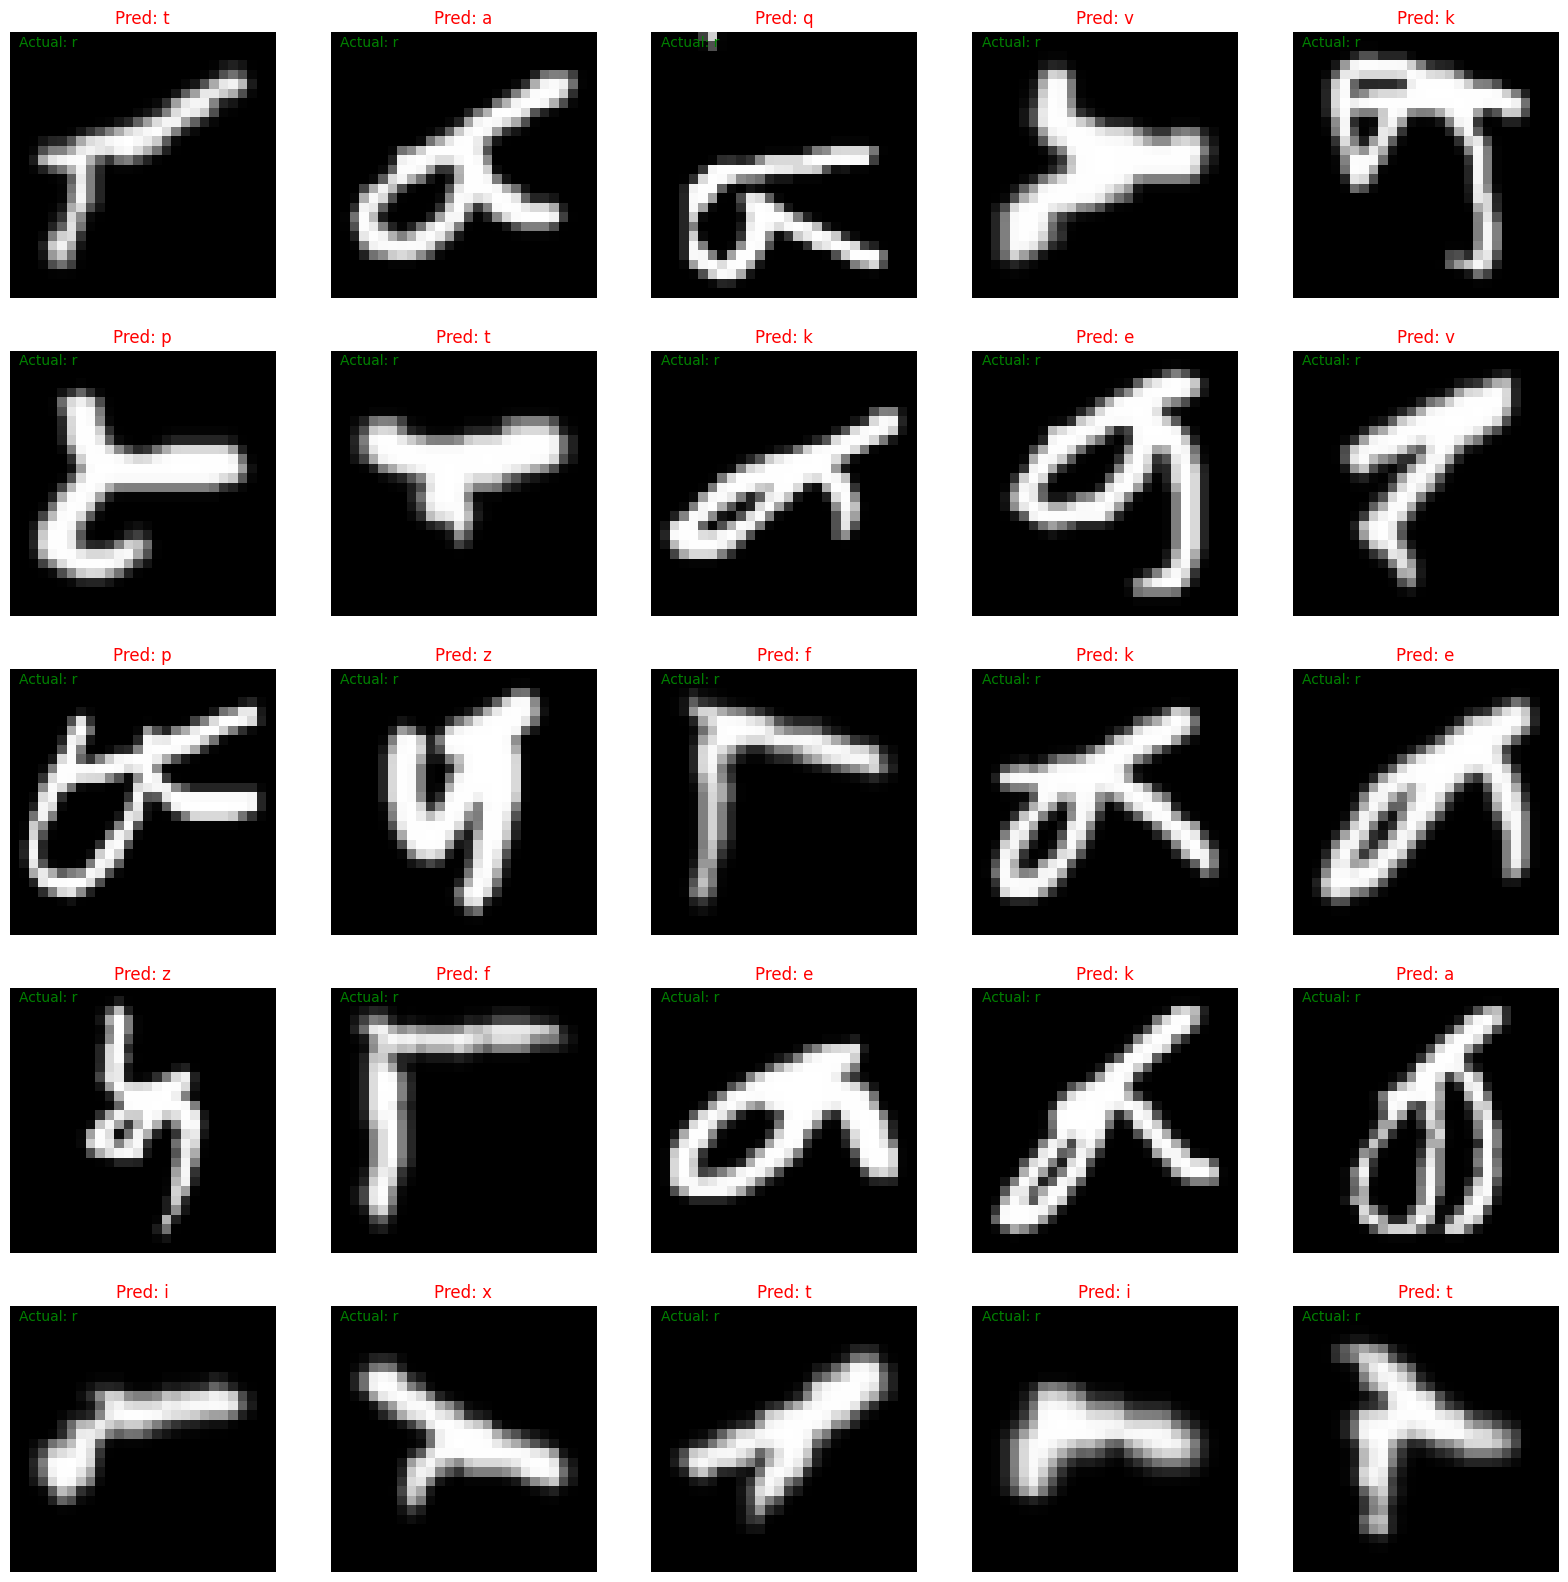

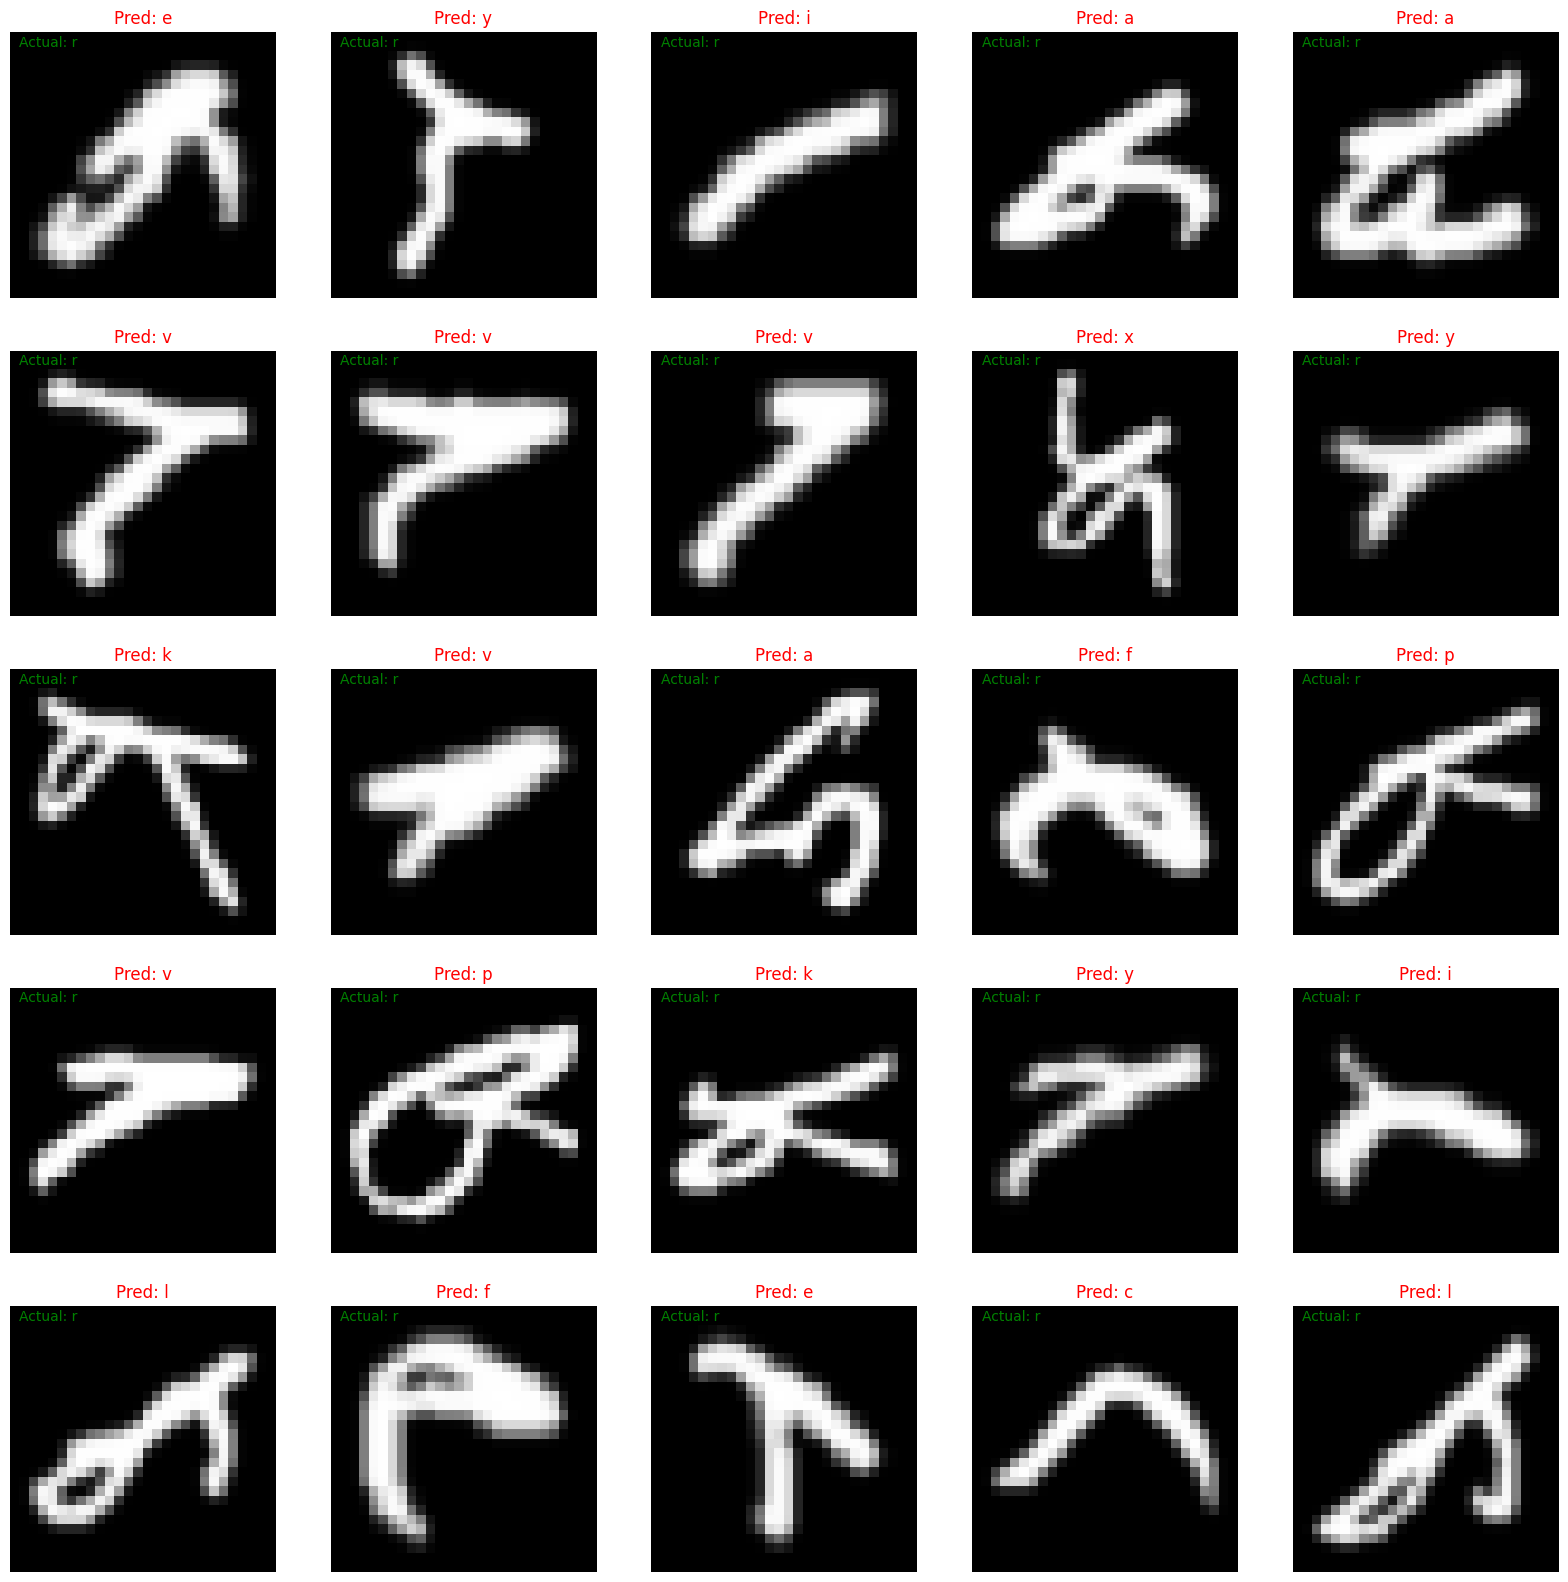

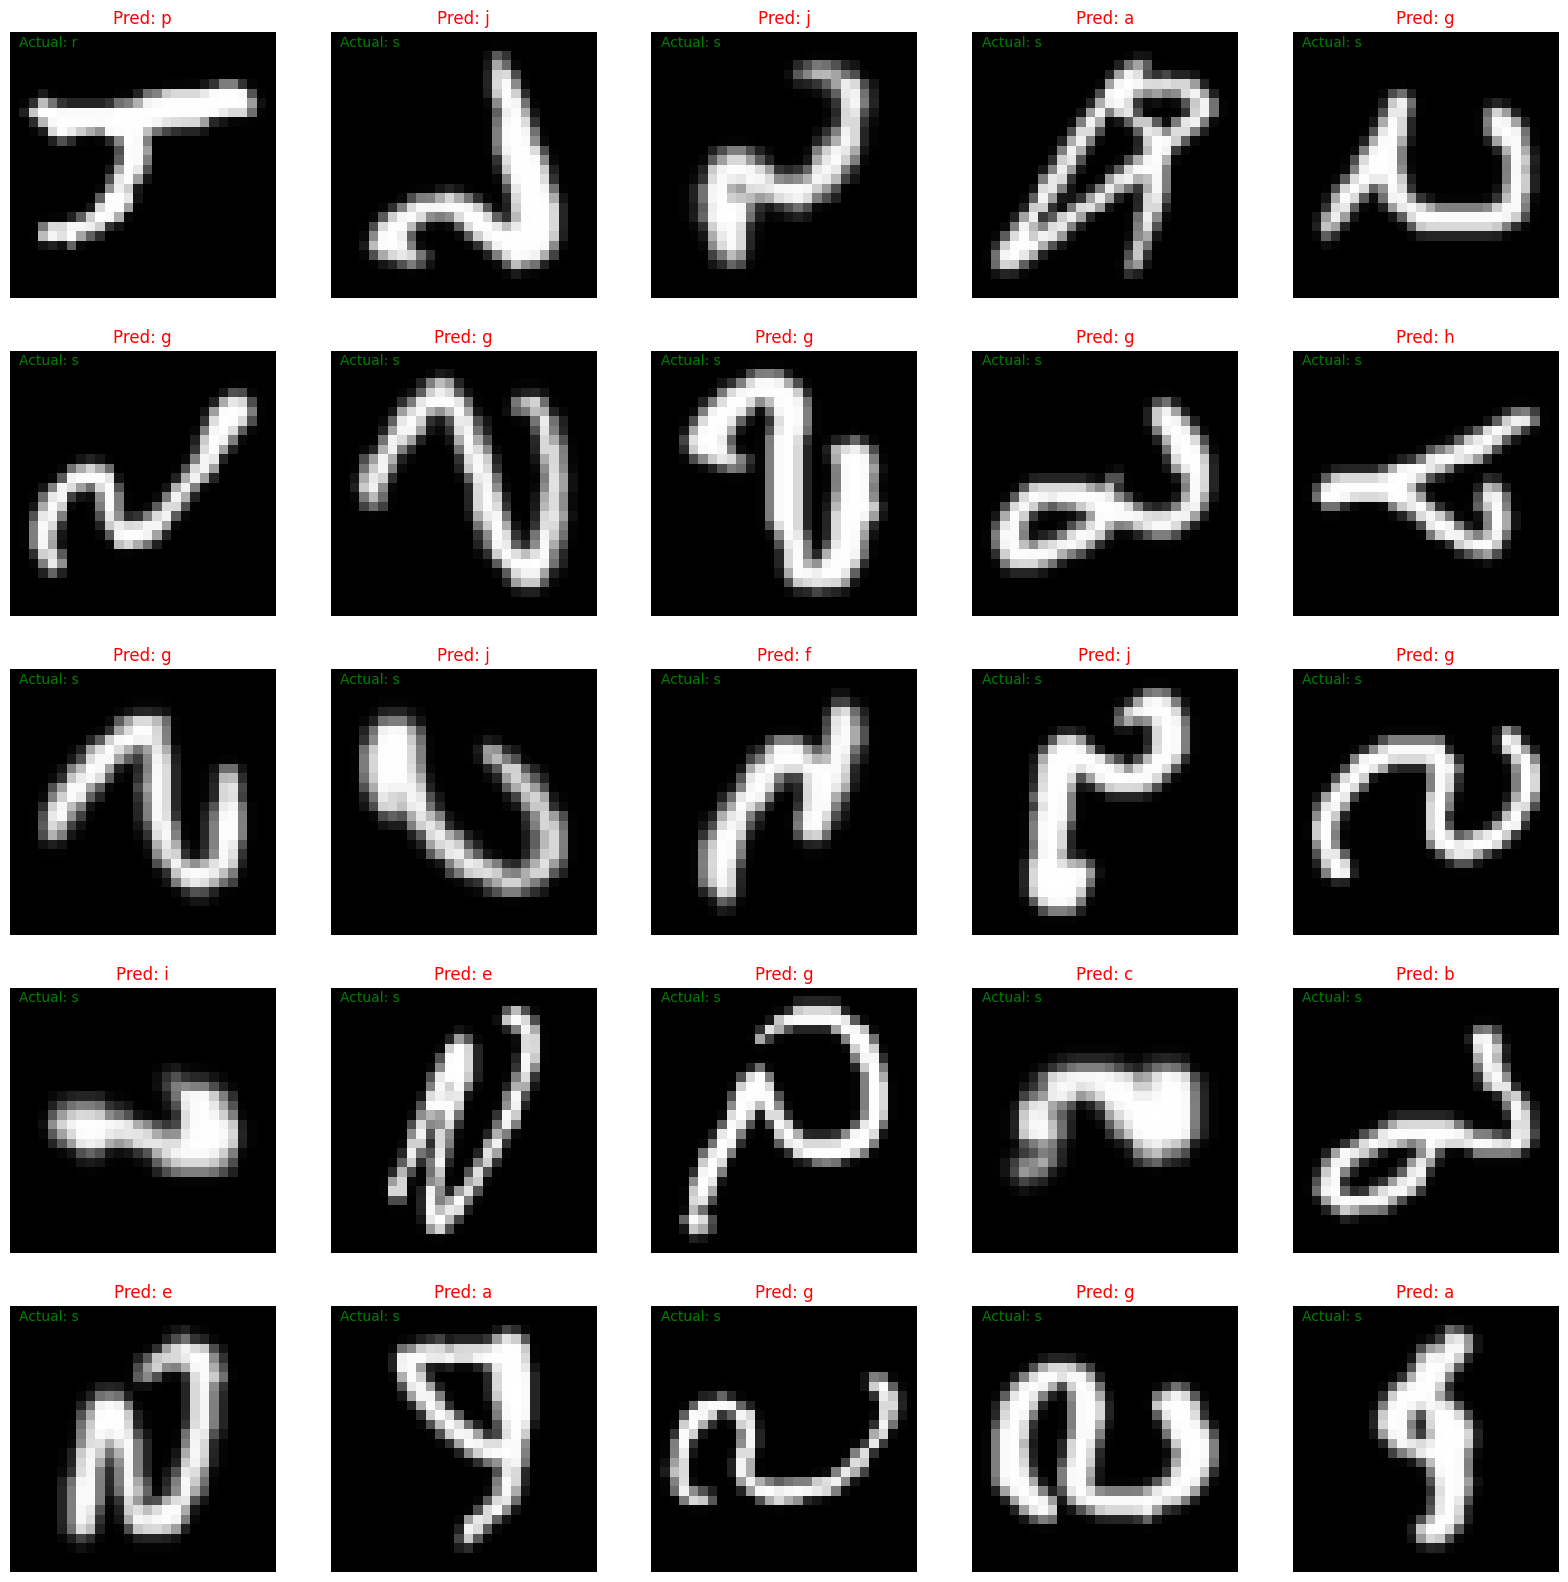

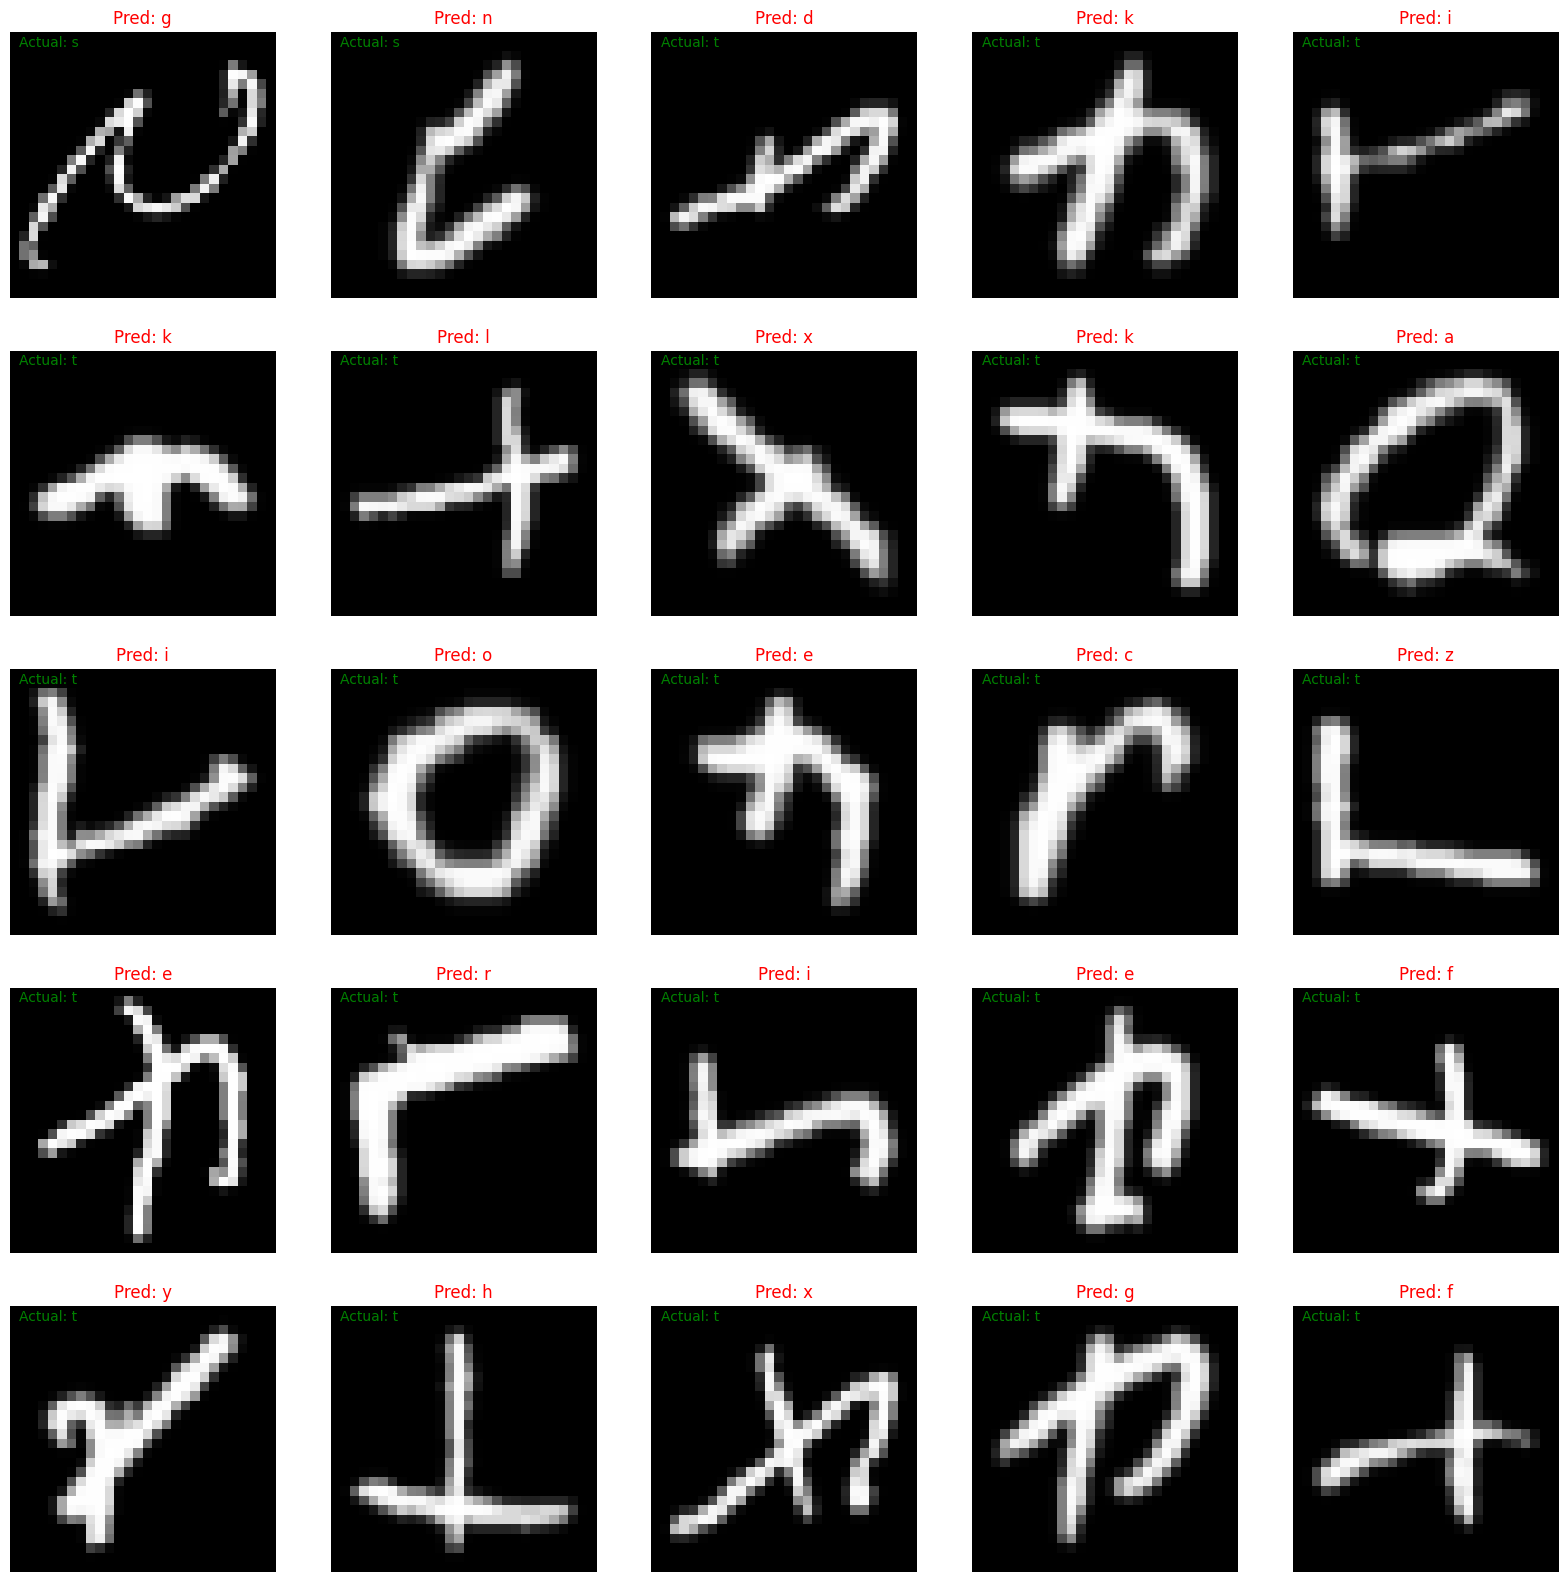

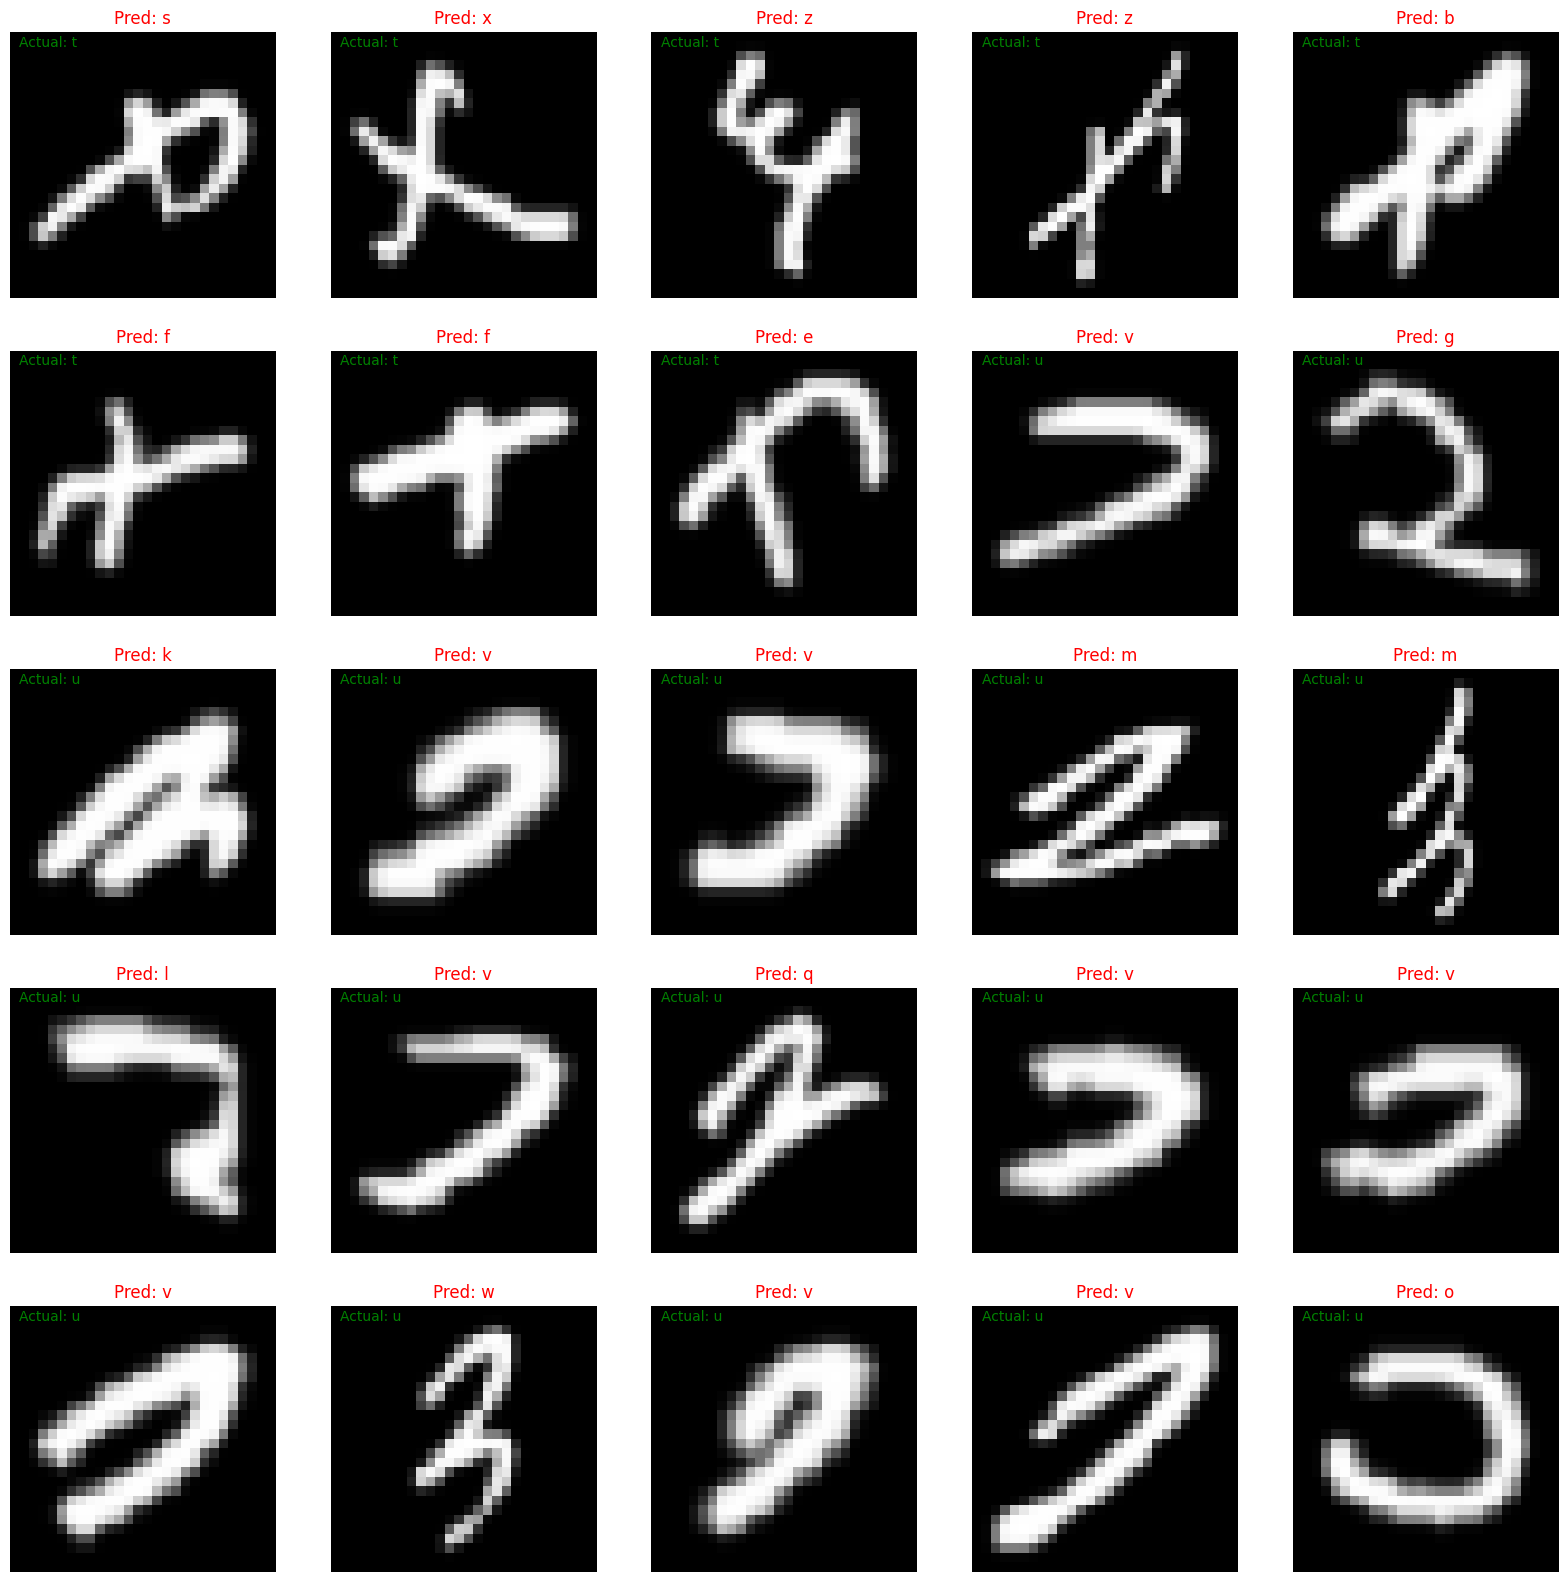

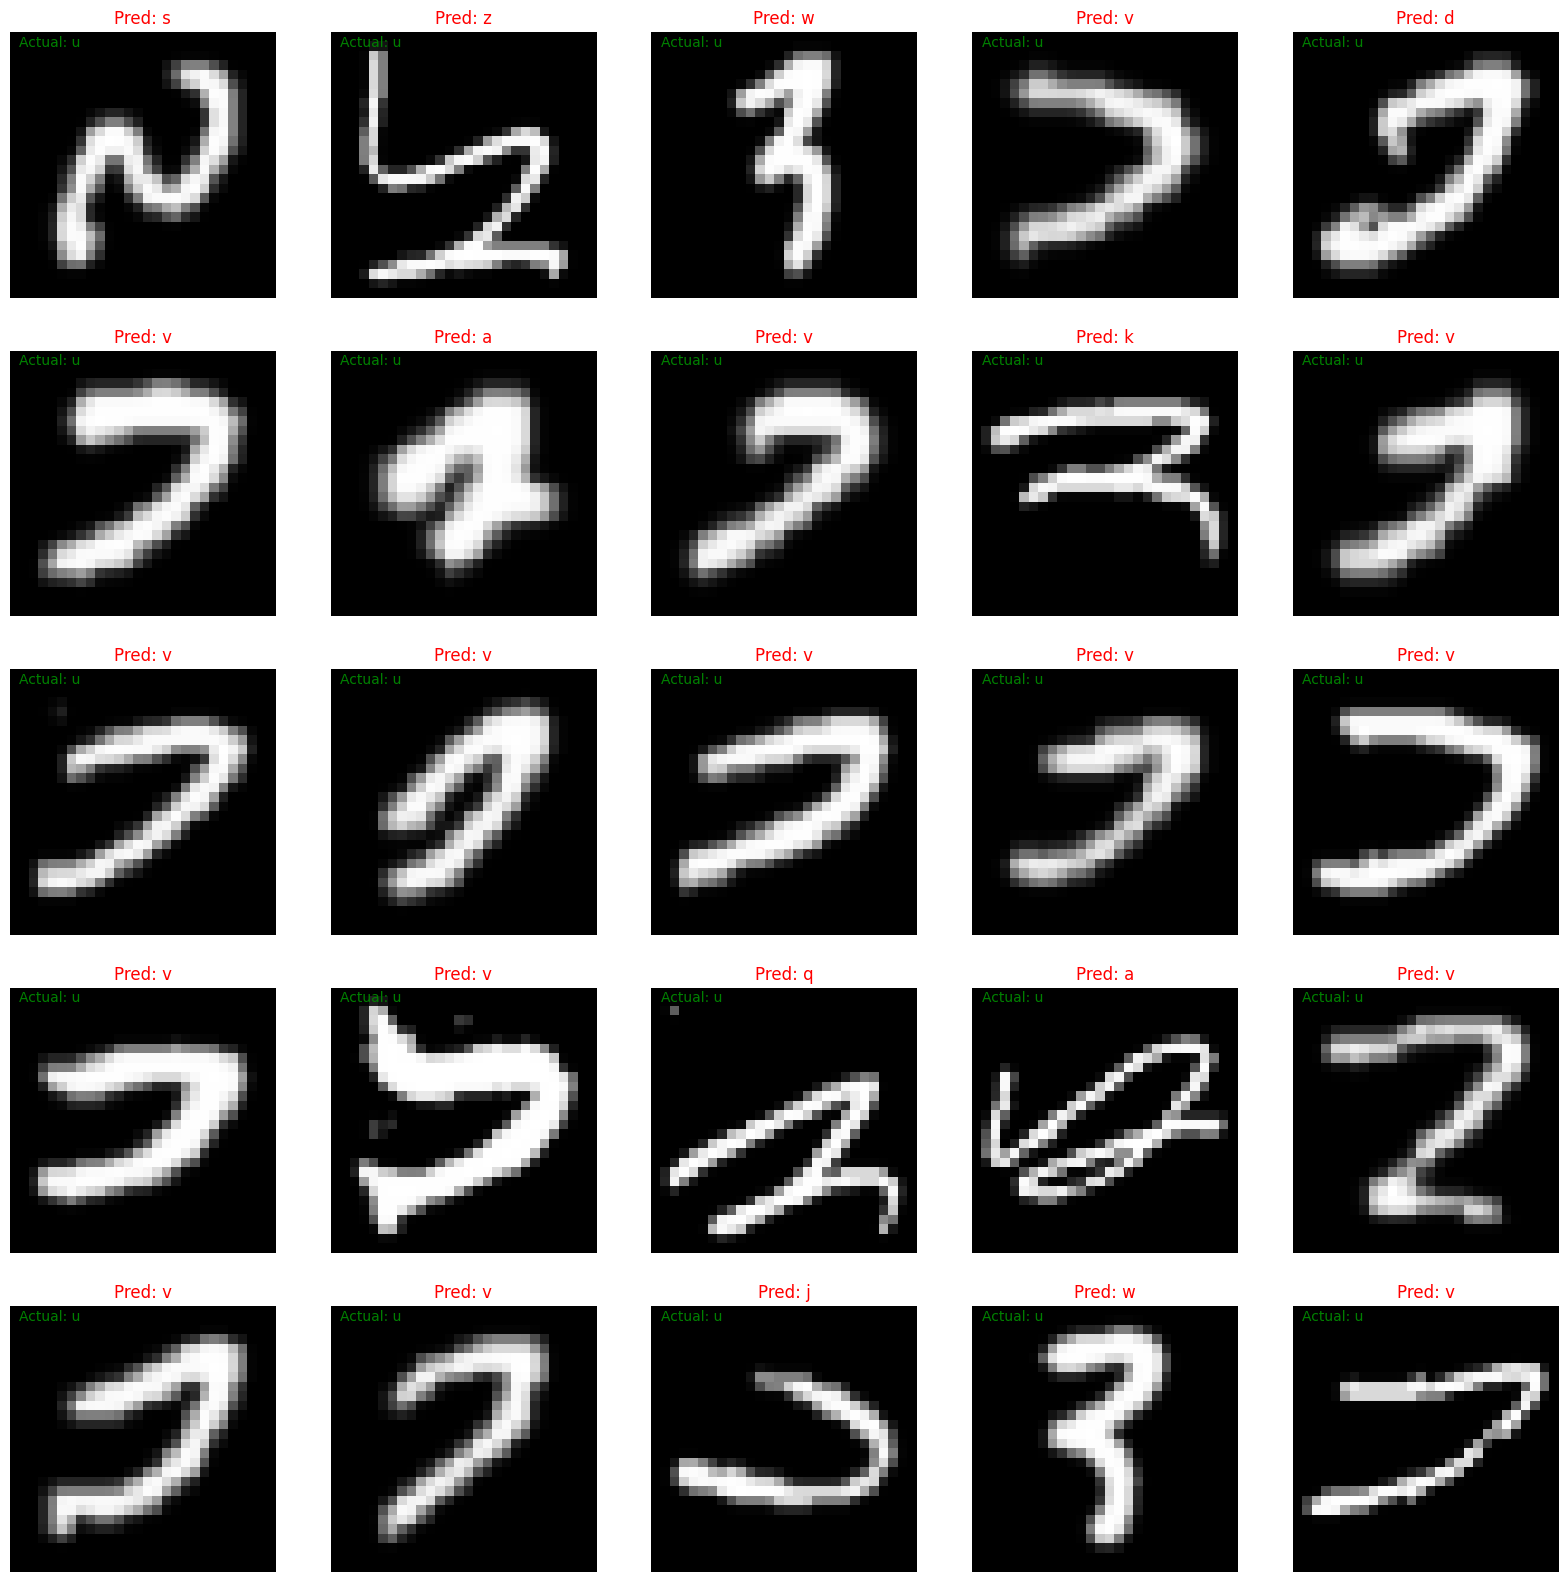

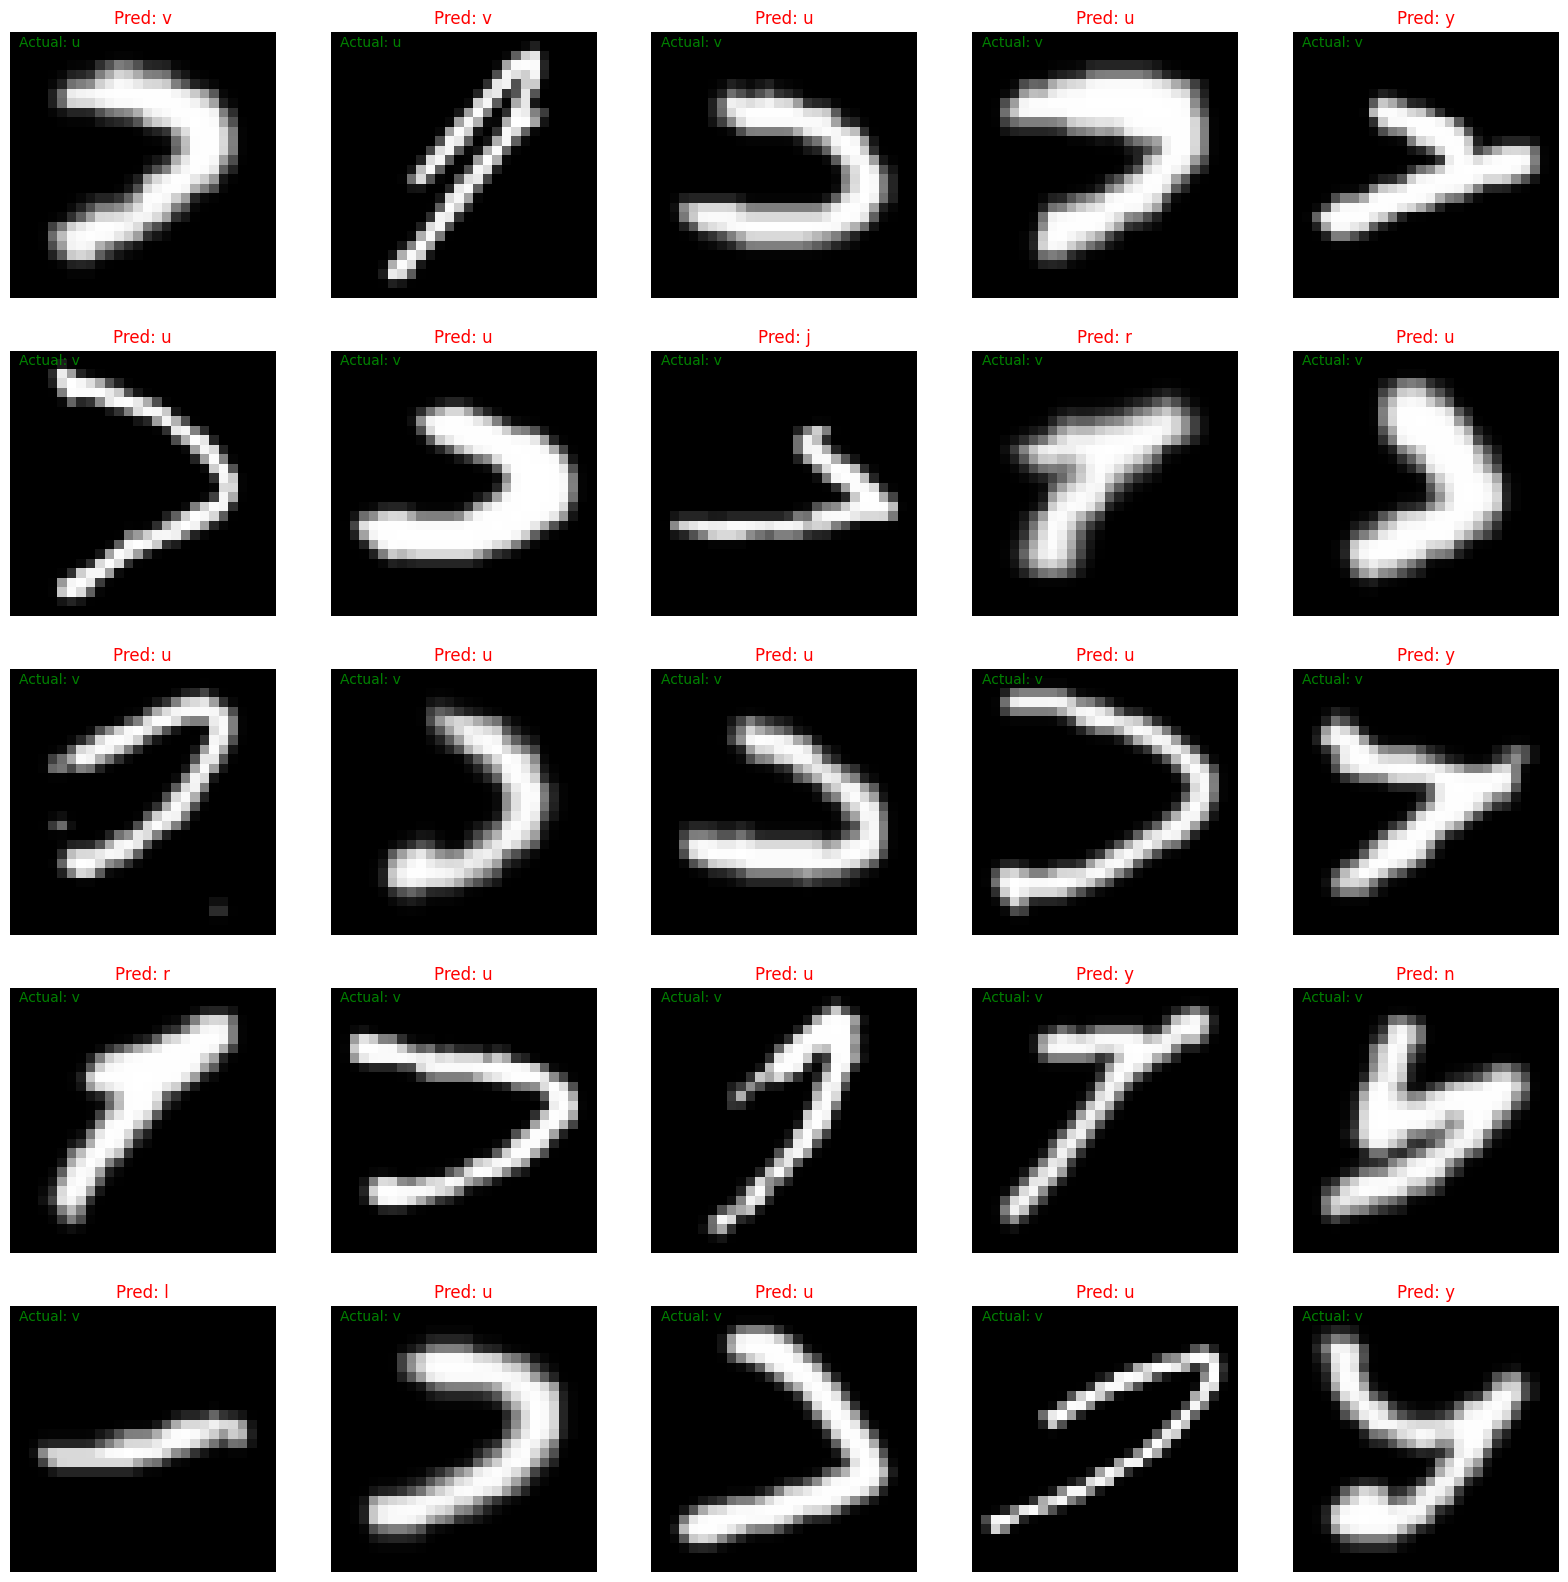

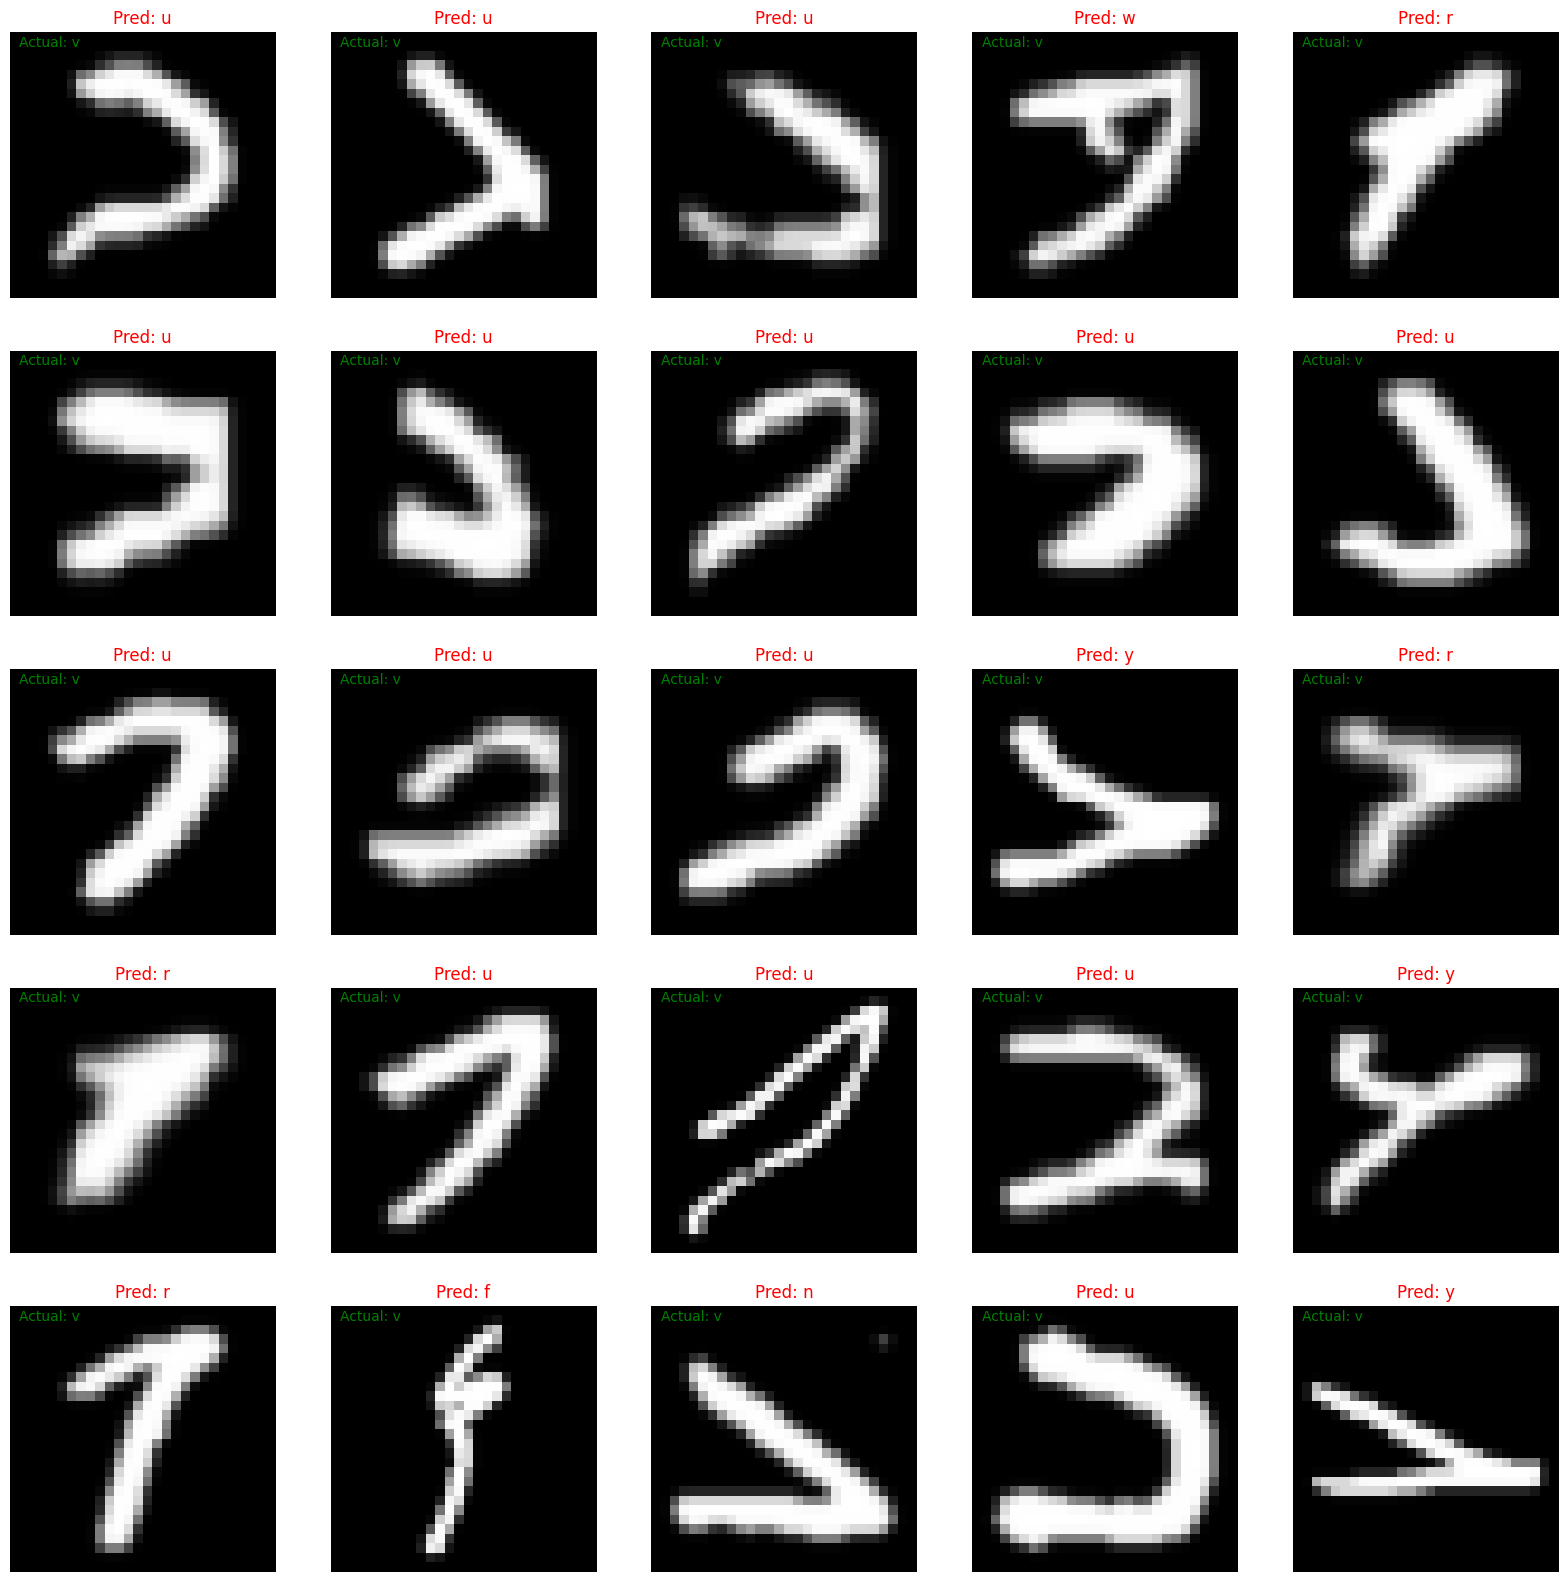

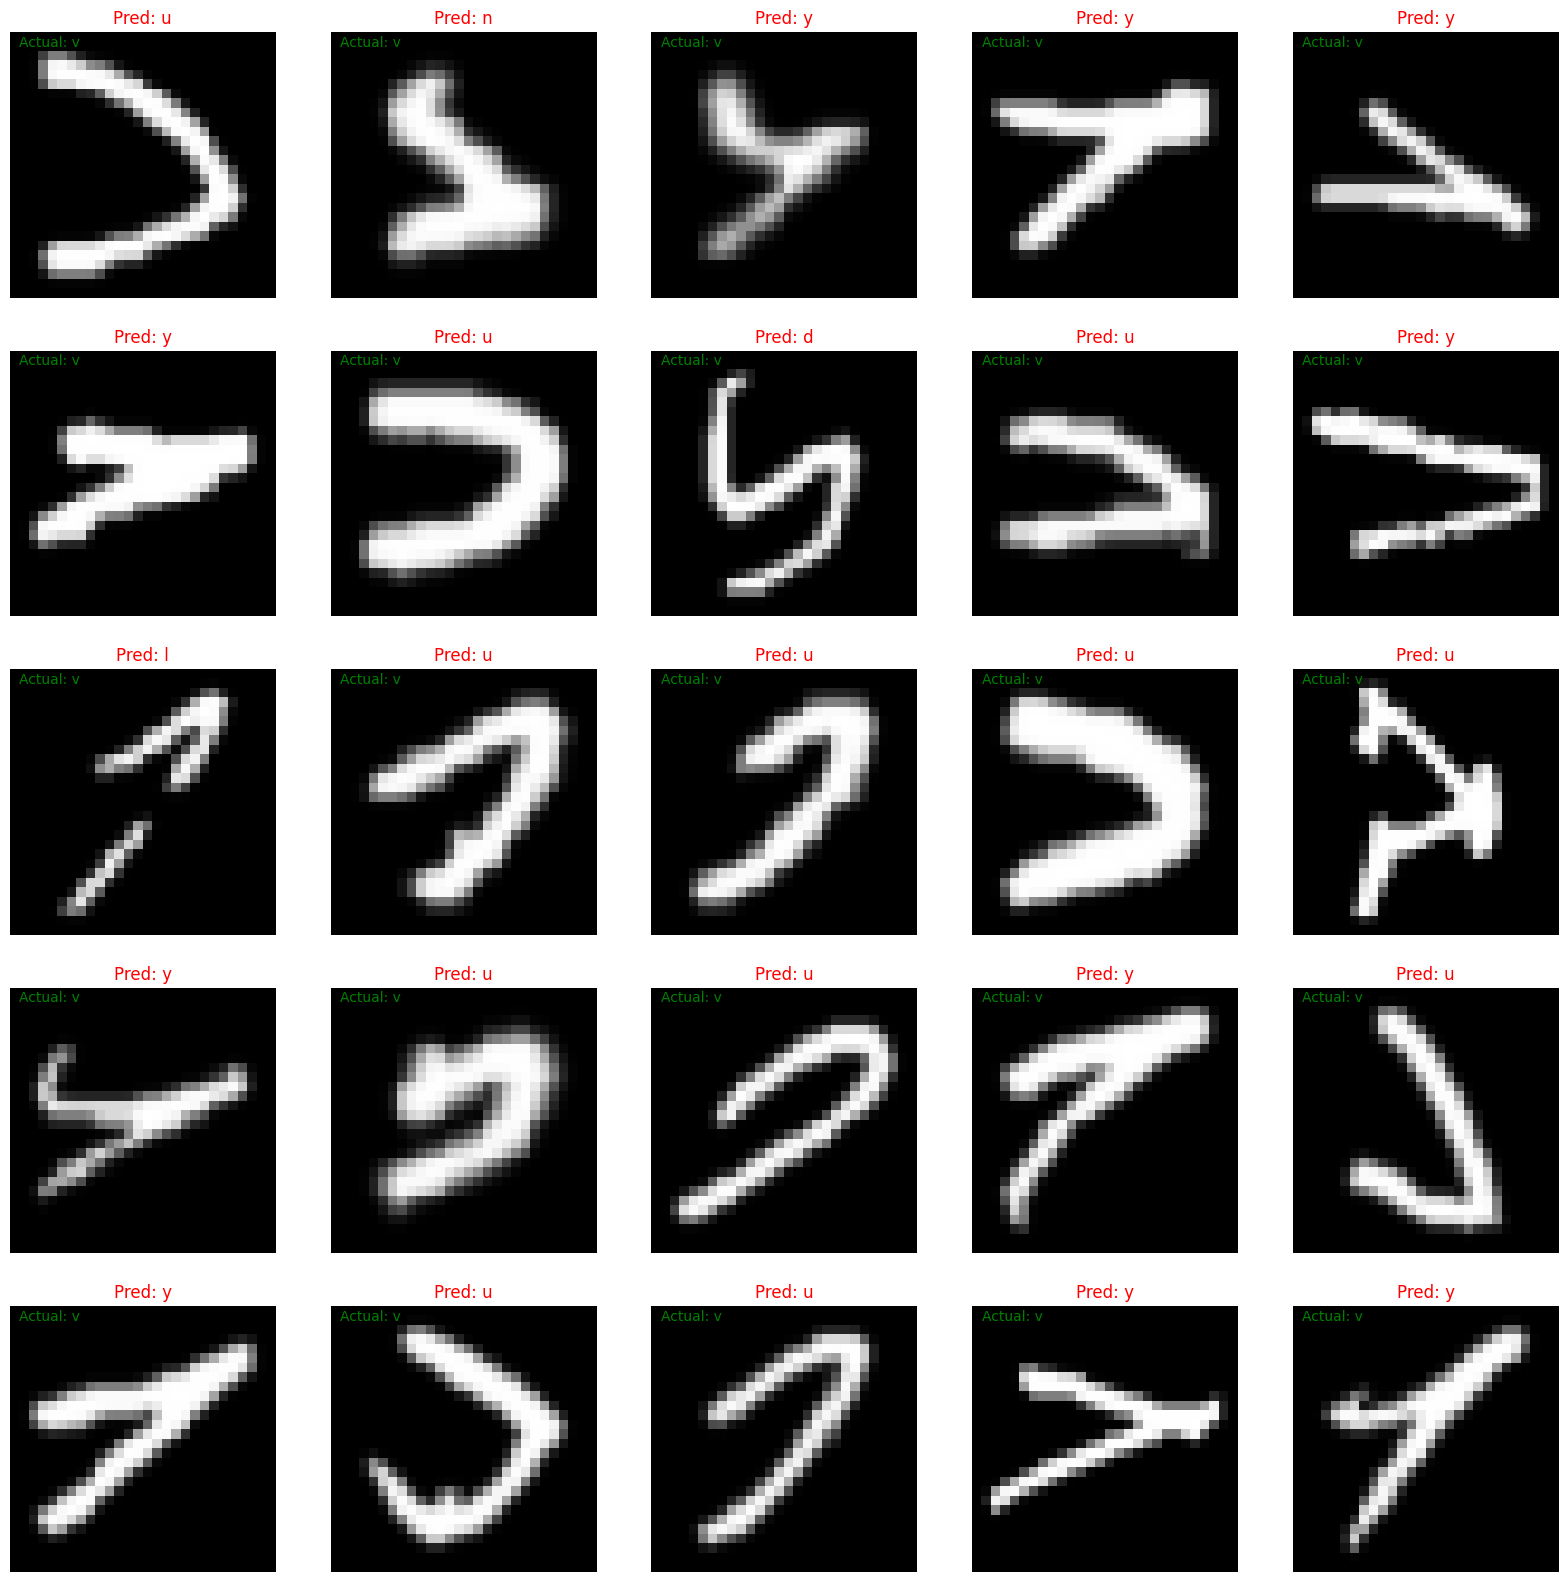

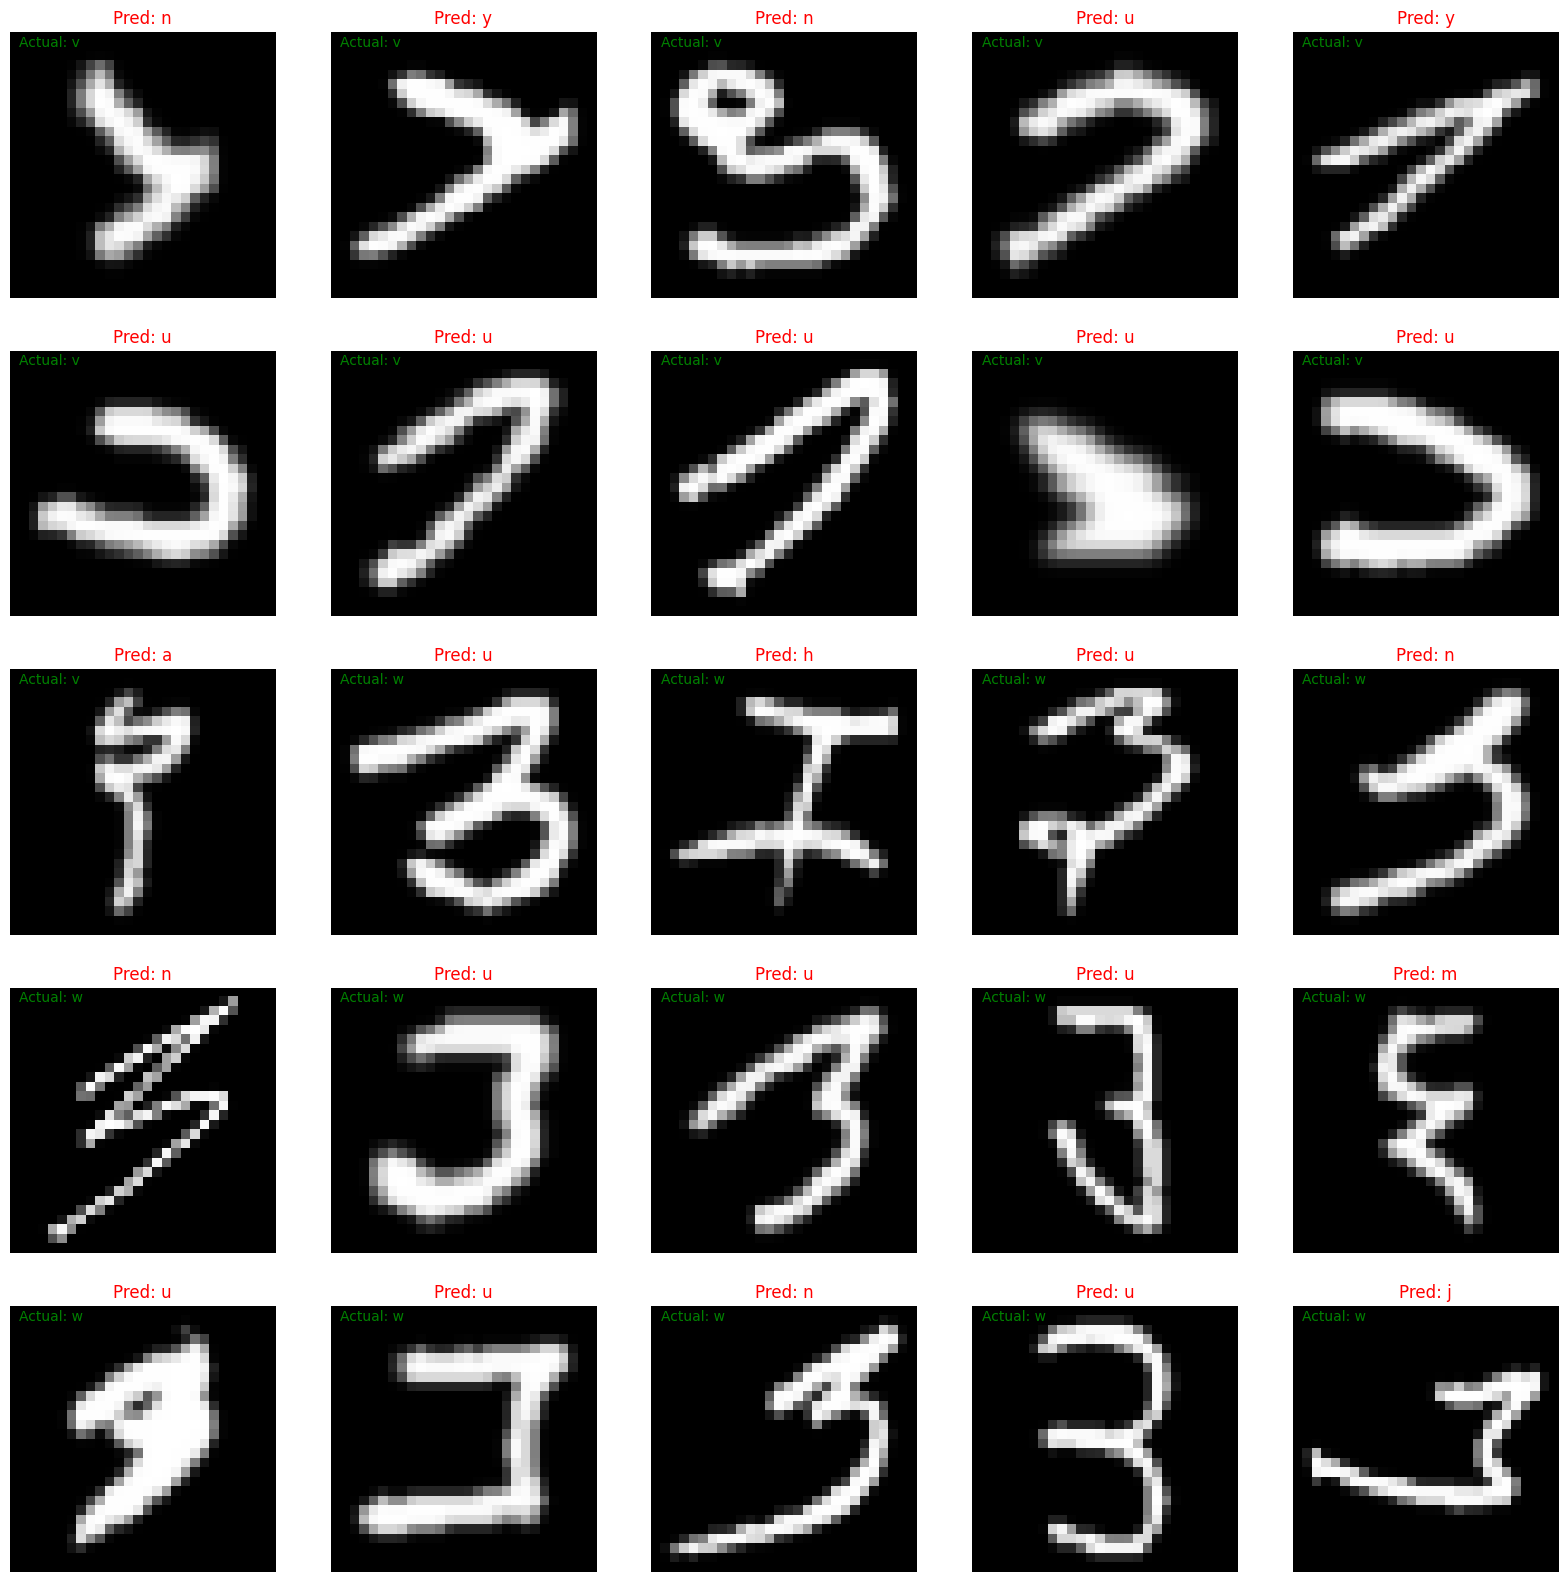

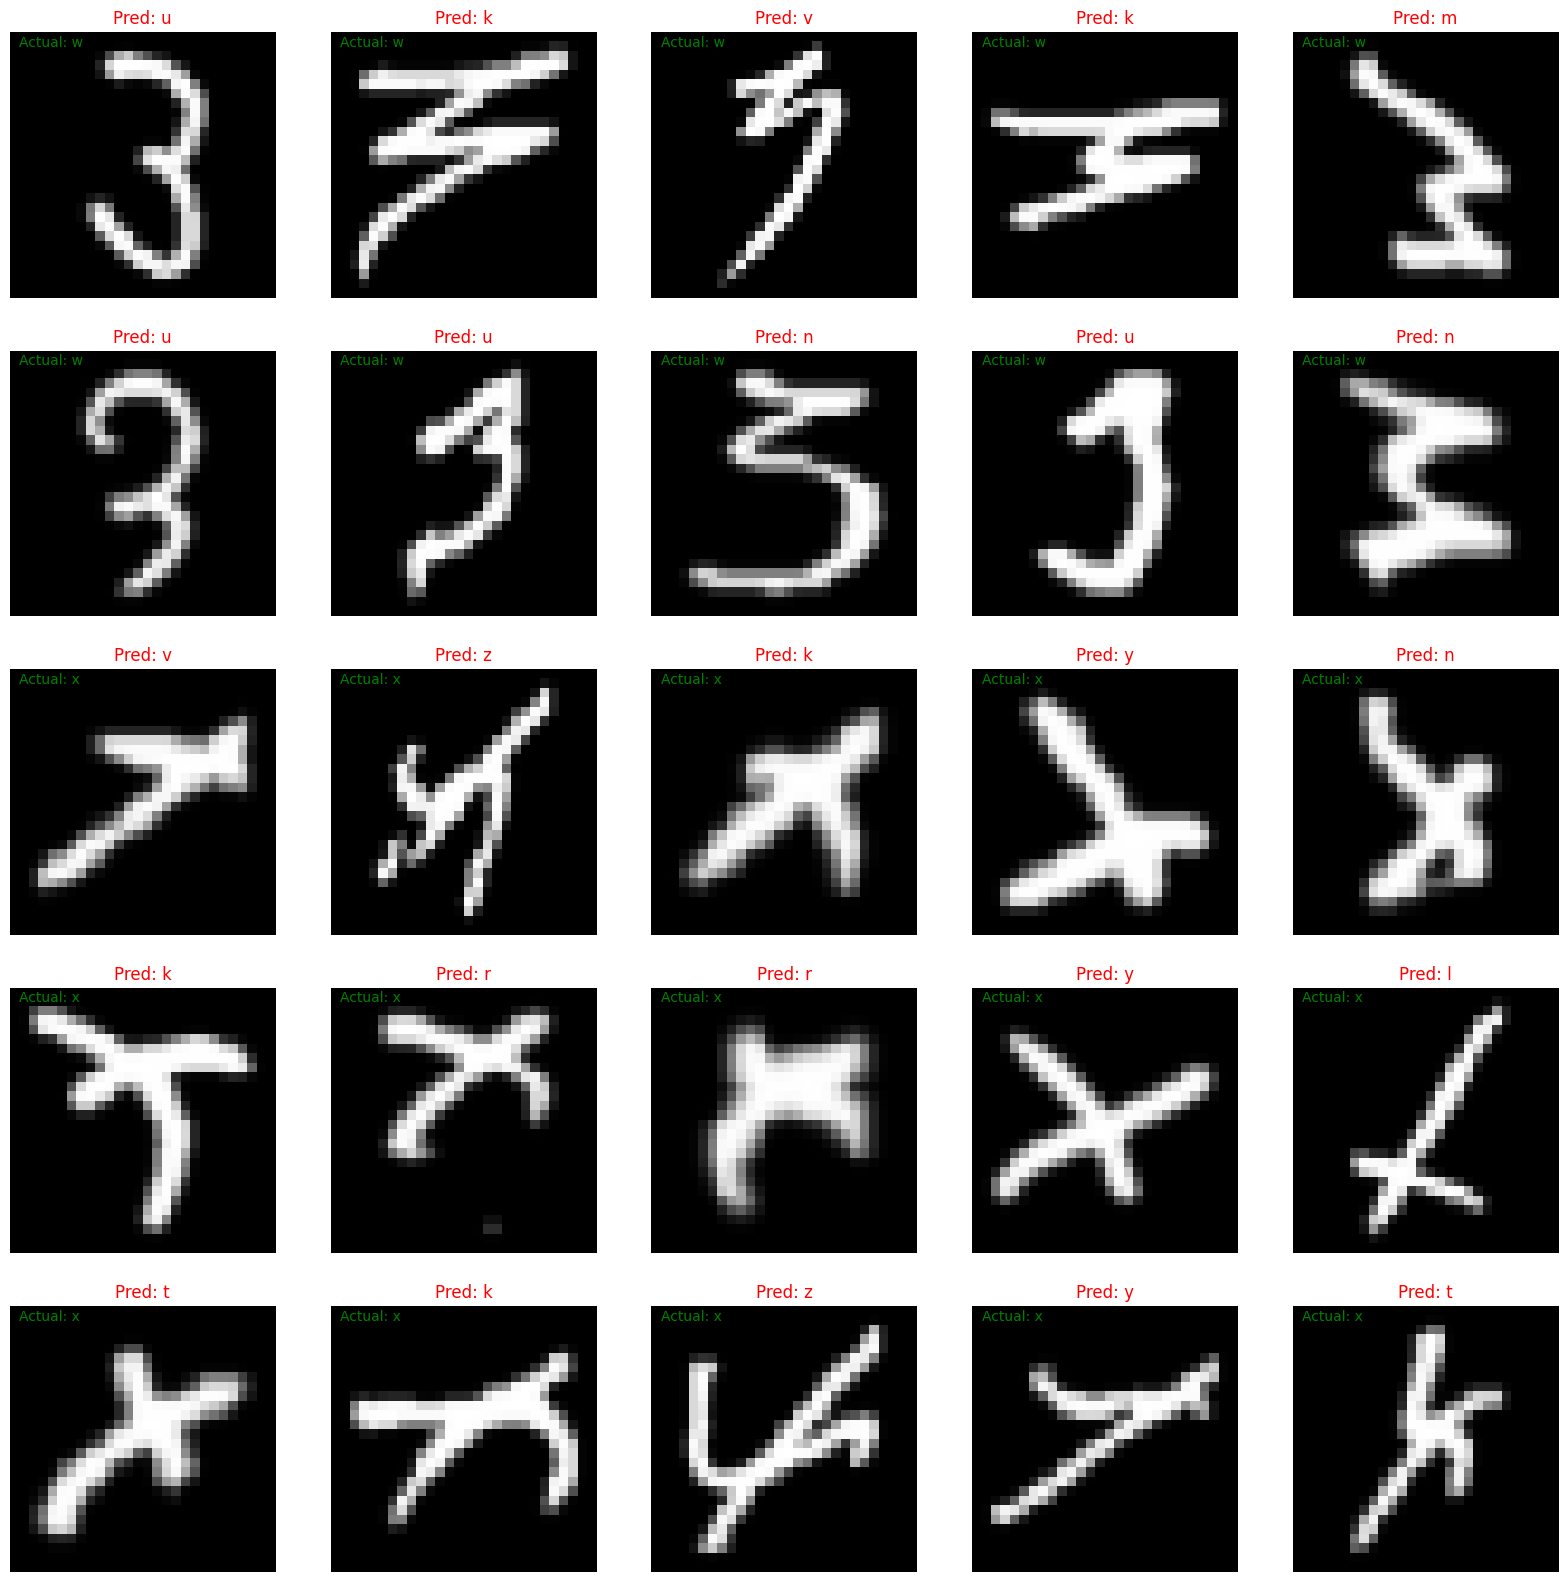

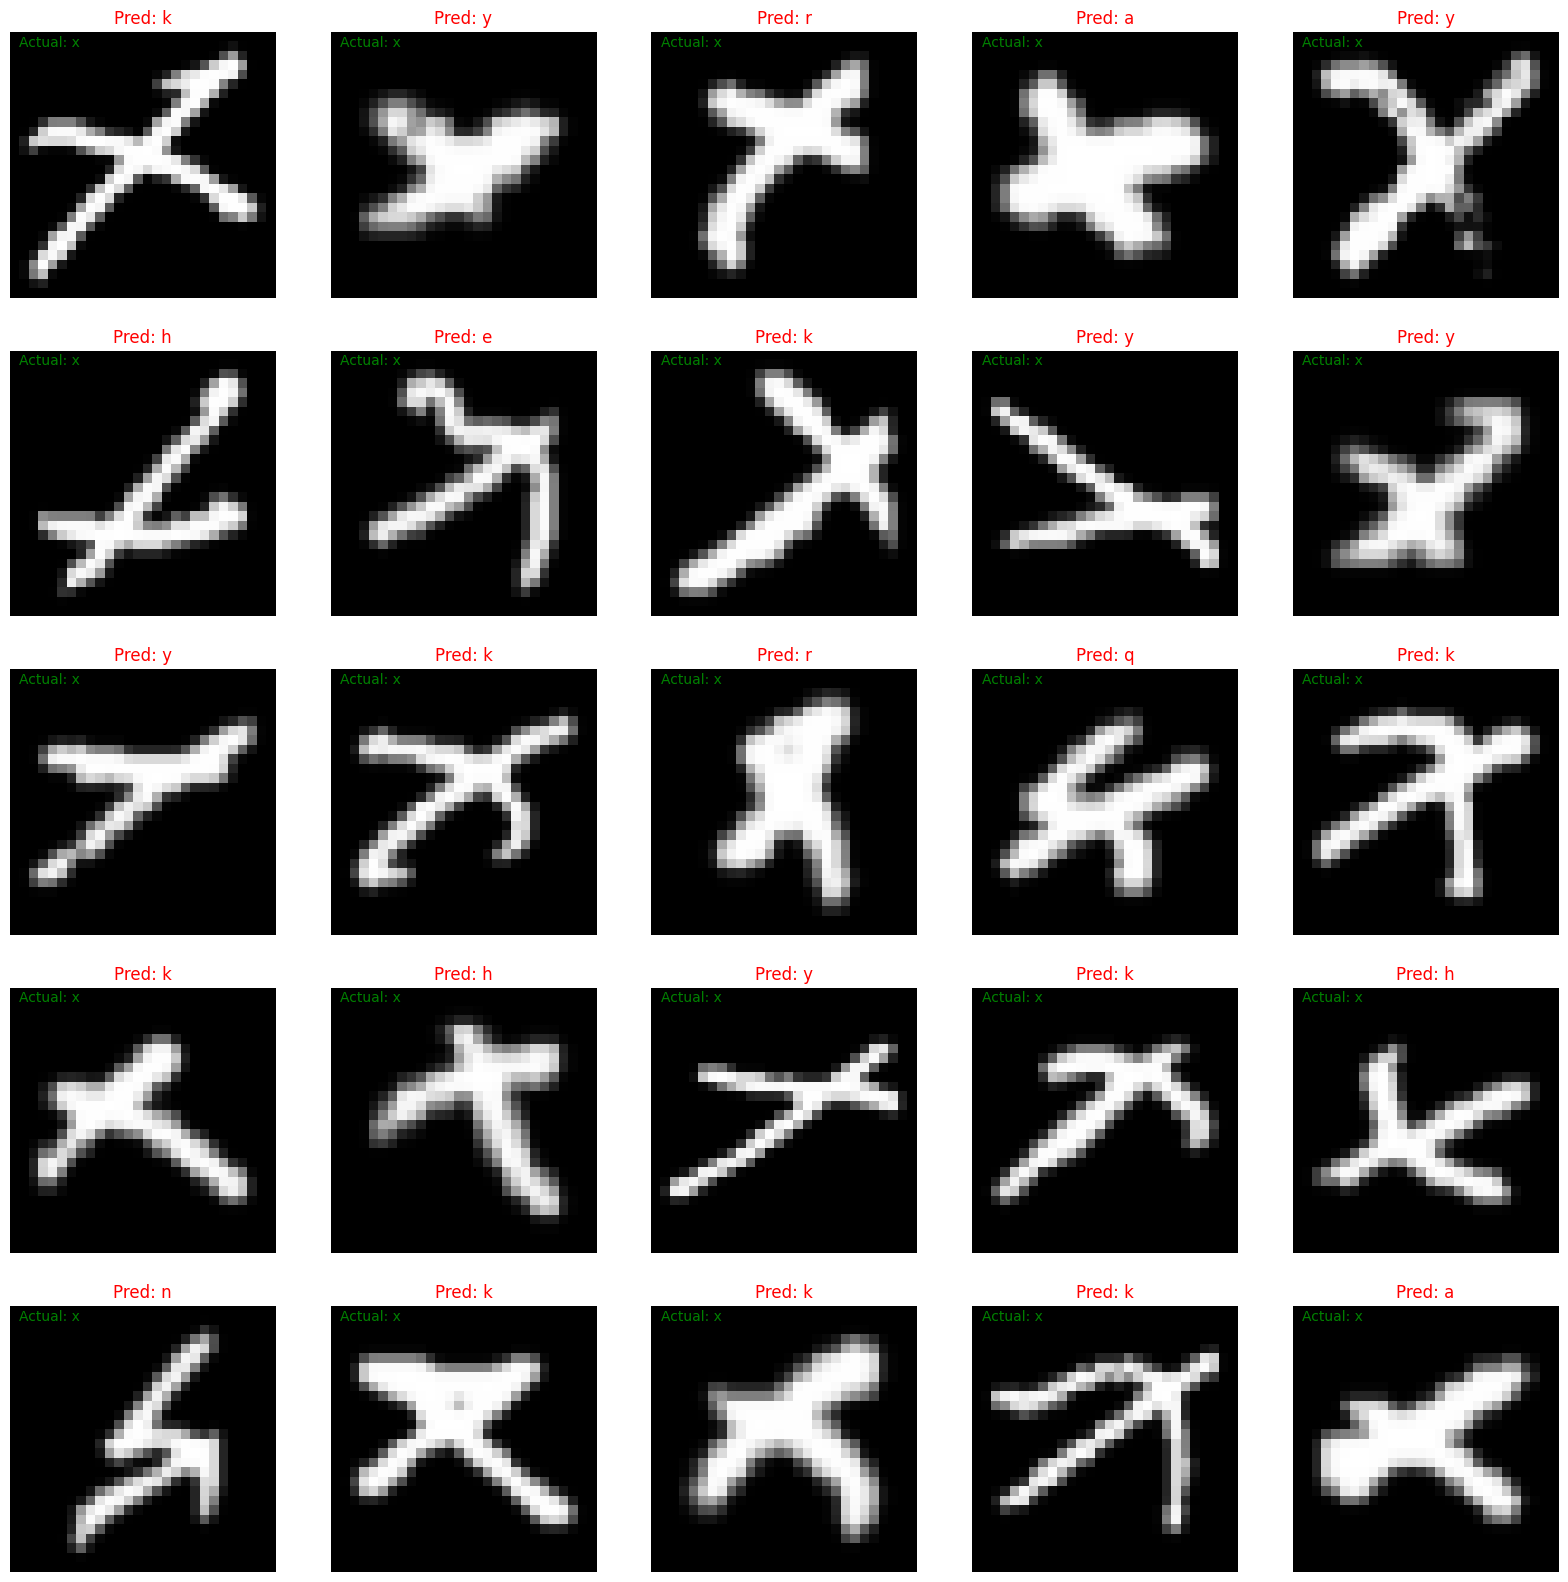

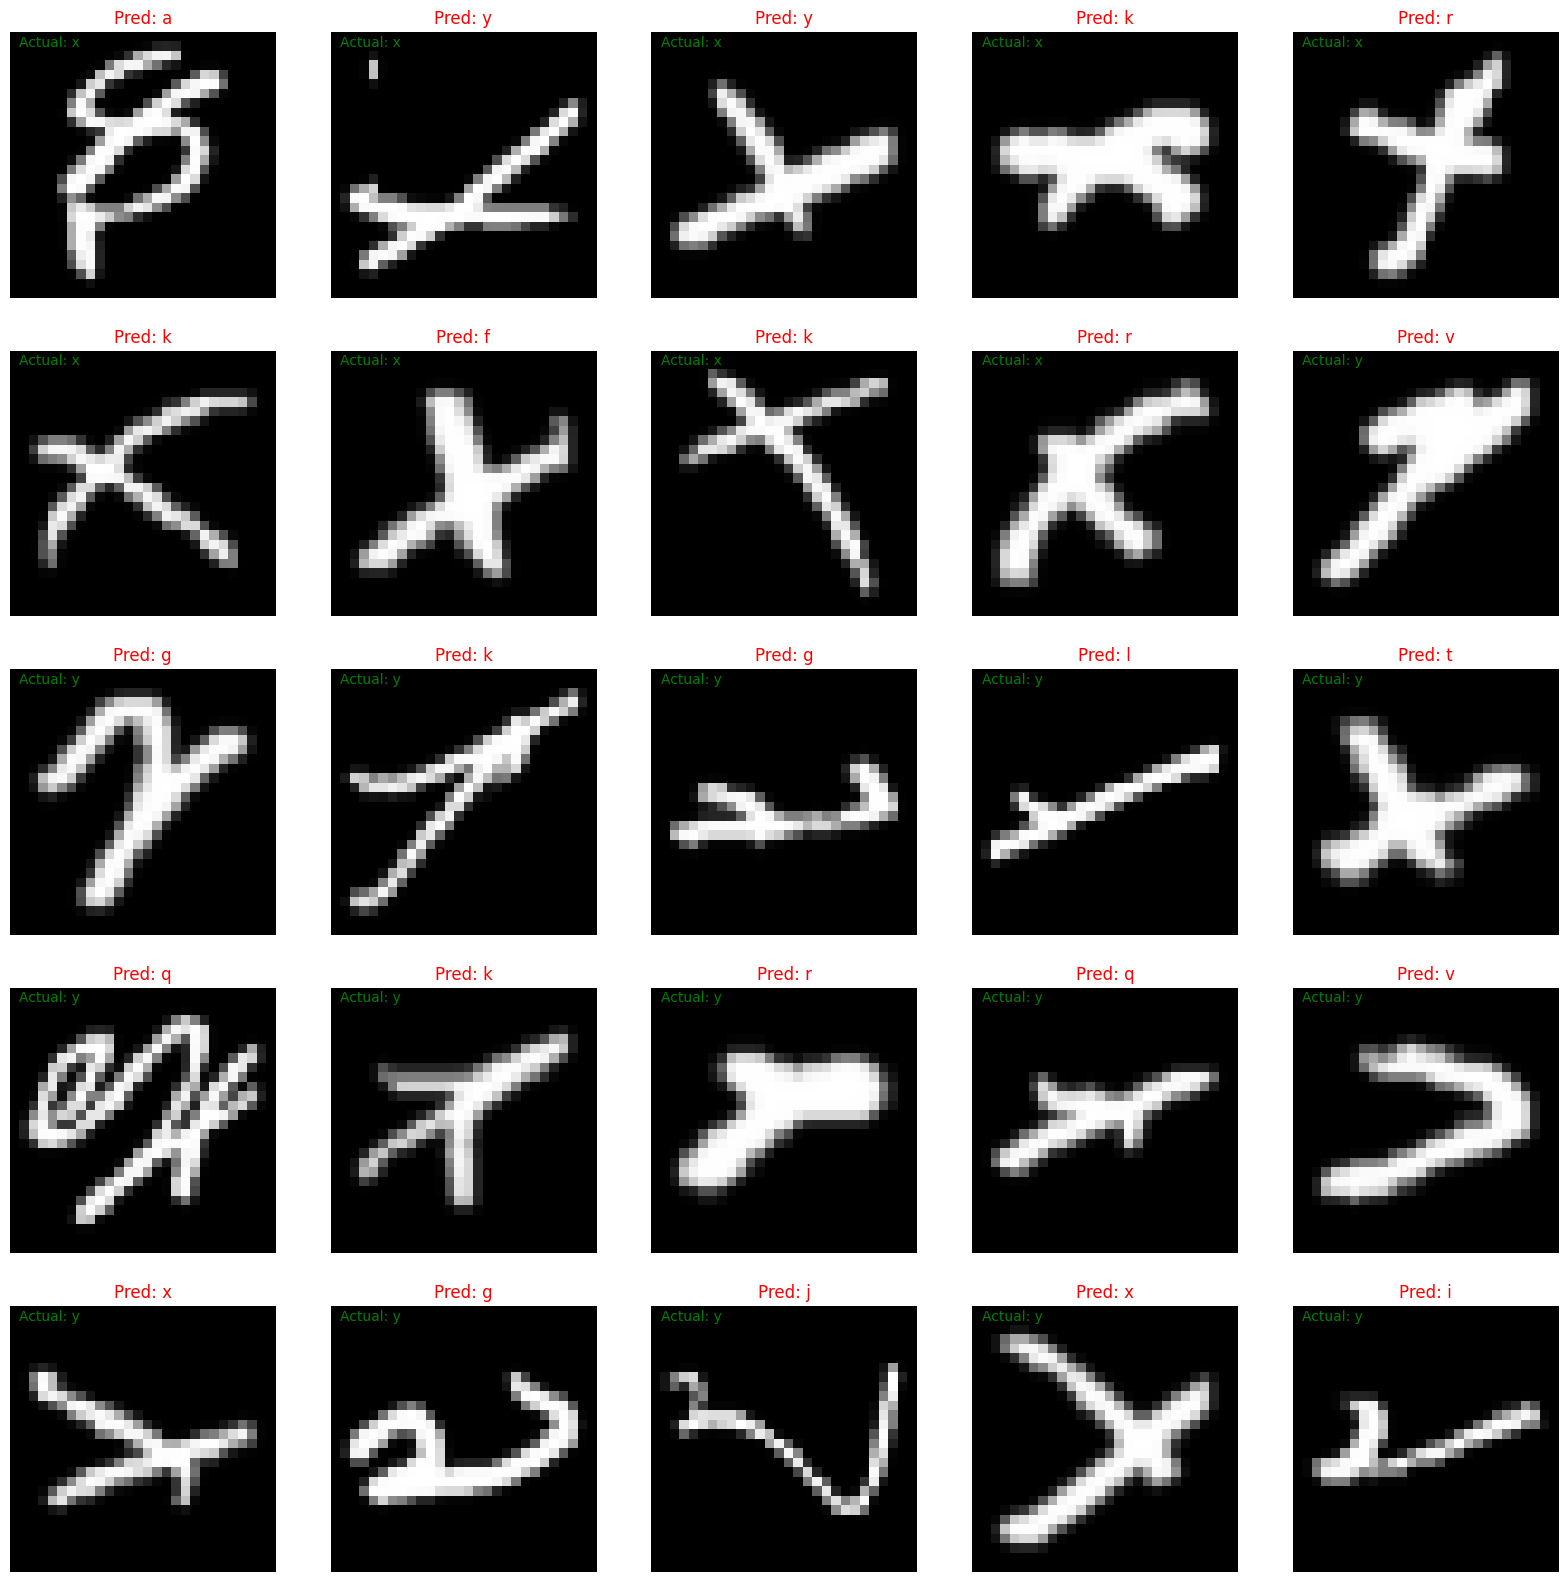

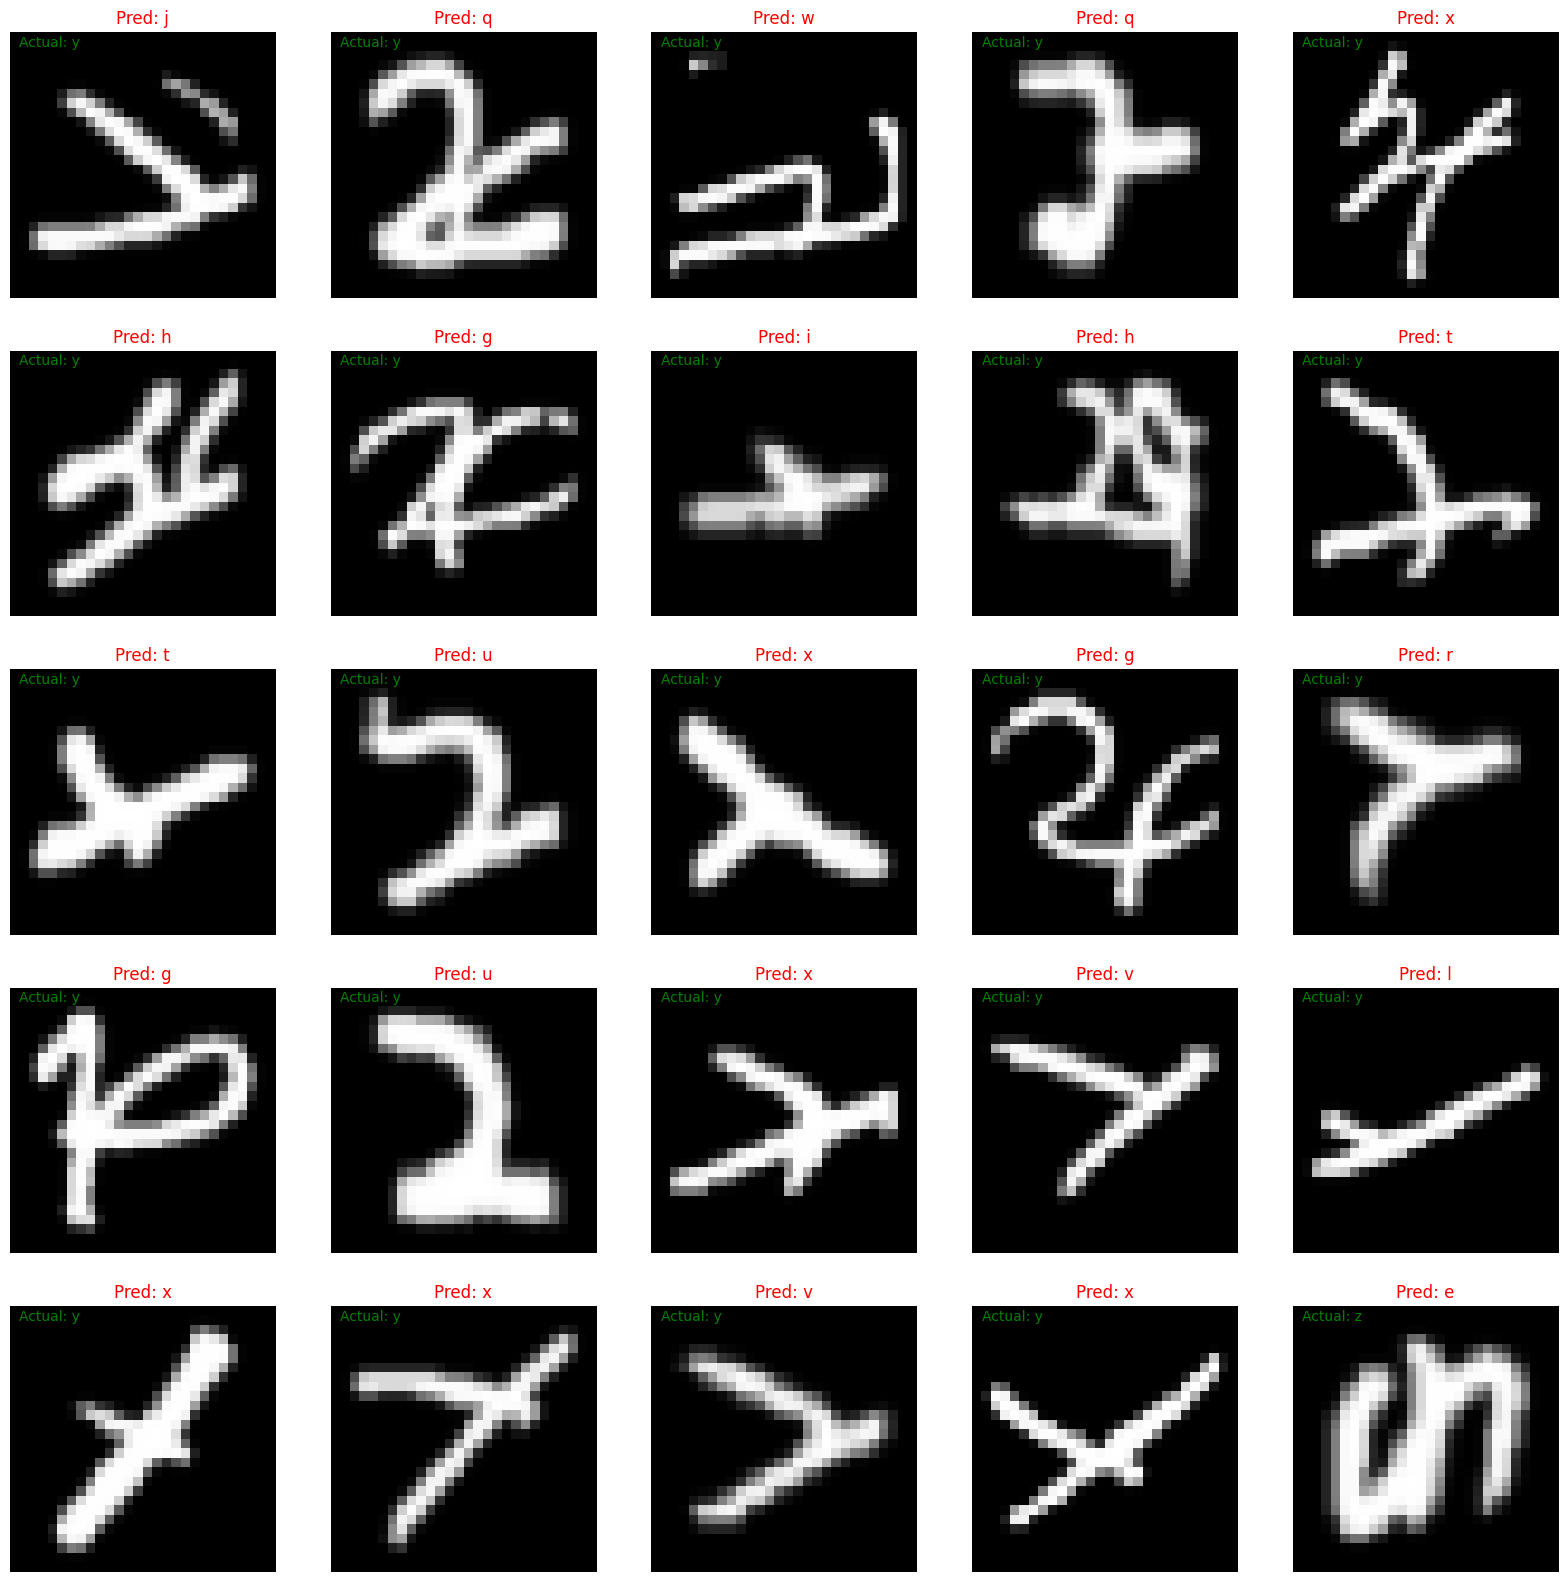

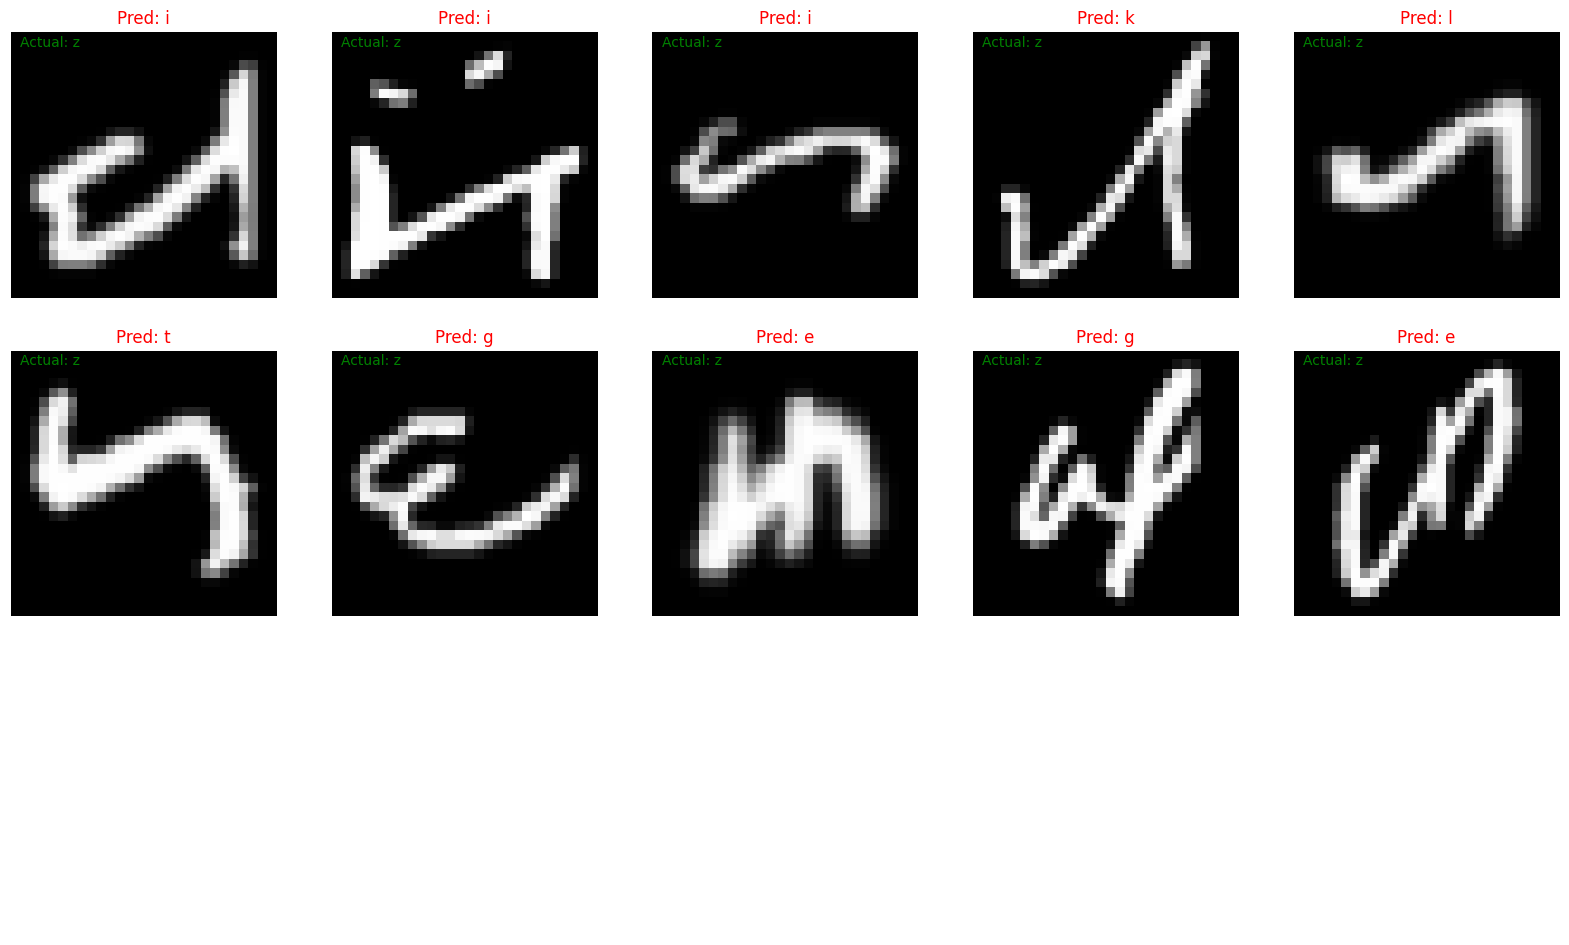

In [18]:
plt.figure(figsize=(20,20))
count=1
for i, y in enumerate(y_pred_tensor):
    if count > 25:
        plt.figure(figsize=(20, 20))
        count = 1
    plt.subplot(5, 5, count)
    plt.axis(False)
    if y != test_data.targets[i]:
        count+=1
        plt.imshow(test_data[i][0].squeeze(), cmap="gray")
        predStr = f"Pred: {class_names[y]}"
        targetStr = f"Actual: {class_names[test_data.targets[i]]}"
        # plt.title(f"Pred: {class_names[y]}| Actual: {class_names[test_data.targets[i]]}")
        plt.title(predStr, color = 'red')
        plt.text(.5, 1, targetStr, color='green')

In [21]:
torch. save(model, '/content/data/emnist_vgg_model.pt')